In [1]:
import os
os.chdir('..')
os.getcwd()

'/home/david/git/dalbandea/phd/codes/3-Phi4/pyScalar2D'

# Introduction to Normalizing Flows for Lattice Field Theory

*January 20, 2020*

**[Michael S. Albergo (NYU)](mailto:albergo@nyu.edu), [Denis Boyda (ANL,MIT)](mailto:boyda@mit.edu), [Daniel C. Hackett (MIT)](mailto:dhackett@mit.edu), [Gurtej Kanwar (MIT)](mailto:gurtej@mit.edu), Kyle Cranmer (NYU), Sébastien Racanière (DeepMind), Danilo Jimenez Rezende (DeepMind),  Phiala E. Shanahan (MIT)**


In this notebook tutorial, we describe and demonstrate a method for simulating lattice field theories through the use of normalizing flows, which allow sampling from complicated probability distributions using neural networks. We will:

**1.** Introduce the ideas behind normalizing flows and explain how to efficiently construct them

**2.** Apply them to a lattice scalar field theory

**3.** Demonstrate how to construct flows which explicitly encode gauge symmetries, and apply this to U(1) gauge theory

This notebook is based on ideas and approaches proposed in [arXiv:1904.12072](https://inspirehep.net/literature/1731778), [arXiv:2002.02428](https://inspirehep.net/literature/1779199), and [arXiv:2003.06413](https://inspirehep.net/literature/1785309) and can be considered as supplementary materials to these papers. Please cite these works in lieu of this pedagogical presentation.

To run this notebook on the cloud with GPU resources, we suggest uploading it to [Google Colab](https://colab.research.google.com/).

We begin by defining a few utilities and importing common packages. Readers may safely execute and skip over the remainder of this section.

In [1]:
import base64
import io
import pickle
import numpy as np
import torch
print(f'TORCH VERSION: {torch.__version__}')
import packaging.version
if packaging.version.parse(torch.__version__) < packaging.version.parse('1.5.0'):
    raise RuntimeError('Torch versions lower than 1.5.0 not supported')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

TORCH VERSION: 1.9.0+cu102


In [2]:
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double
    torch.set_default_tensor_type(torch.DoubleTensor)
print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cuda


In [3]:
def torch_mod(x):
    return torch.remainder(x, 2*np.pi)
def torch_wrap(x):
    return torch_mod(x+np.pi) - np.pi

Often we want to detach tensors from the computational graph and pull them to the CPU as a numpy array.

In [4]:
def grab(var):
    return var.detach().cpu().numpy()

The code below makes a live-updating plot during training.

In [5]:
from IPython.display import display

def init_live_plot(dpi=125, figsize=(8,4)):
    fig, ax_ess = plt.subplots(1,1, dpi=dpi, figsize=figsize)
    plt.xlim(0, N_era*N_epoch)
    plt.ylim(0, 1)
    
    ess_line = plt.plot([0],[0], alpha=0.5) # dummy
    plt.grid(False)
    plt.ylabel('ESS')
    
    ax_loss = ax_ess.twinx()
    loss_line = plt.plot([0],[0], alpha=0.5, c='orange') # dummy
    plt.grid(False)
    plt.ylabel('Loss')
    
    plt.xlabel('Epoch')

    display_id = display(fig, display_id=True)

    return dict(
        fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
        ess_line=ess_line, loss_line=loss_line,
        display_id=display_id
    )

def moving_average(x, window=10):
    if len(x) < window:
        return np.mean(x, keepdims=True)
    else:
        return np.convolve(x, np.ones(window), 'valid') / window

def update_plots(history, fig, ax_ess, ax_loss, ess_line, loss_line, display_id):
    Y = np.array(history['ess'])
    Y = moving_average(Y, window=15)
    ess_line[0].set_ydata(Y)
    ess_line[0].set_xdata(np.arange(len(Y)))
    Y = history['loss']
    Y = moving_average(Y, window=15)
    loss_line[0].set_ydata(np.array(Y))
    loss_line[0].set_xdata(np.arange(len(Y)))
    ax_loss.relim()
    ax_loss.autoscale_view()
    fig.canvas.draw()
    display_id.update(fig) # need to force colab to update plot

# Notation
This section is intended as a reference. The phrases and notation listed here will be defined in detail in the remainder of the notebook.

1. __Notation for generic normalizing flows__
  *  Coordinates $z, x \in$ some manifold $\mathcal{X}$ (a space with local $\mathbb{R}^n$ structure)  
   The manifolds used here are $\mathcal{X} = \mathbb{R}^n$ (for scalar field theory) and $\mathcal{X} = \mathbb{T}^n$ (for $\mathrm{U}(1)$ gauge theory) where $\mathbb{T}^n$ refers to the n-dimensional torus.
  *  Probability densities over those manifolds,
      *  Prior density $r(z)$ 
      *  Model density $q(x)$
      *  Target density $p(x)$
  *  Normalizing flow $f: \mathcal{X} \rightarrow \mathcal{X}$, invertible and differentiable
  *  Jacobian factor $J(z) = |\det_{ij} \partial f_i(z) / \partial z_j|$
  *  Coupling layer $g: \mathcal{X} \rightarrow \mathcal{X}$, invertible and differentiable
  *  Subsets of the components of the coordinate $x = (x_1, x_2)$, where the choice of subsets will be clear from context

2. __Notation for lattice field theories__
  *  Lattice spacing $a$  
  We work in "lattice units" where $a=1$.
  *  Spacetime dimension $N_d$  
  We work in this notebook with $N_d=2$.
  *  Lattice extent $L$, with volume $V = L^{N_d} = L^2$, in lattice units where $a=1$.
  *  Lattice position $\vec{x} = a\vec{n} \equiv (an_x, an_y)$, with $\vec{x}=\vec{n}$ in lattice units where $a=1$. We use $n_x, n_y \in [0, L-1]$.

3. __Notation for normalizing flows targeting scalar lattice field theory__ 
  *  Field configurations $z \in \mathbb{R}^V$ or $\phi \in \mathbb{R}^V$, corresponding to $z$ or $x$ in the generic notation
  *  $\phi(\vec{n})$ denotes the field configuration which lives on the sites of the lattice, while $\phi_{\vec{n}}$ denotes the unraveled 1D vector of lattice DOF
  *  Action $S[\phi] \in \mathbb{R}$
  *  Discretized path integral measure $\prod_{\vec{n}} d\phi_{\vec{n}}$

4. __Notation for normalizing flows targeting U(1) lattice gauge theory__
  *  Field configurations $U \in \mathbb{T}^{N_d V}$ or $U' \in \mathbb{T}^{N_d V}$, corresponding to $z$ or $x$ in the generic notation
  *  $U_\mu(\vec{n})$ denotes the component of field configuration $U$ which lives on the link $(n, n+\hat{\mu})$ of the lattice, where $\mu \in [0, N_d-1]$ indicates the Cartesian direction. $U_{\mu,\vec{n}}$ denotes the unraveled 1D vector of lattice DOF
  *  Action $S[U] \in \mathbb{R}$
  *  Angular parameterization of each component $U_{\mu, \vec{n}} \equiv e^{i\theta_{\mu, \vec{n}}}$
  *  Discretized path integral measure $\prod_{\mu,\vec{n}} dU_{\mu,\vec{n}}$, where $dU_{\mu, \vec{n}} = d\theta_{\mu, \vec{n}}$ is the Haar measure for $\mathrm{U}(1)$


# Normalizing flows (for lattice QFTs)

A powerful method to generate samples from complicated distributions is to combine (1) sampling from a simpler / tractable distribution with (2) applying a deterministic change-of-variables (a _normalizing flow_) to the output samples. The transformed samples are distributed according to a new distribution which is determined by the initial distribution and change-of-variables. These two components together define a _normalizing flow model_. See <span data-cite="papamakarios2019normalizing">[1912.02762]</span> for a review.



## **A simple example**
The Box-Muller transform is an example of this trick in practice: to produce Gaussian random variables, draw two variables $U_1$ and $U_2$ from $\text{unif}(0,1)$ then change variables to

\begin{equation}
    Z_1 = \sqrt{-2 \ln{U_1}} \cos(2\pi U_2)
    \quad \text{and} \quad
    Z_2 = \sqrt{-2 \ln{U_1}} \sin(2\pi U_2).
\end{equation}

The resulting variables $Z_1, Z_2$ are then distributed according to an uncorrelated, unit-variance Gaussian distribution.



We can analytically compute the density associated with output samples by the **change-of-variables formula** relating the _prior density_ $r(U_1, U_2) = 1$ to the _output density_ $q(Z_1, Z_2)$:

\begin{equation}
\begin{split}
    q(Z_1, Z_2) &= r(U_1, U_2) \left| \det_{kl} \frac{\partial Z_k(U_1, U_2)}{\partial U_l} \right|^{-1} \\
    &= 1 \times \left| \det \left( \begin{matrix}
        \frac{-1}{U_1 \sqrt{-2 \ln{U_1}}} \cos(2\pi U_2) &
        - 2\pi \sqrt{-2 \ln{U_1}} \sin(2\pi U_2) \\
        \frac{-1}{U_1 \sqrt{-2 \ln{U_1}}} \sin(2\pi U_2) &
        2\pi \sqrt{-2 \ln{U_1}} \cos(2\pi U_2)
        \end{matrix} \right) \right|^{-1} \\
    &= \left| \frac{2 \pi}{U_1} \right|^{-1}.
\end{split}
\end{equation}

Here, the term $J(U_1, U_2) \equiv \left| \det_{kl} \frac{\partial Z_k(U_1, U_2)}{\partial U_l} \right|$ is the determinant of the Jacobian of the transformation from $(U_1,U_2)$ to $(Z_1,Z_2)$. Intuitively, the Jacobian factor can be thought of as a change in volume element, therefore the change-of-variables formula must contain the inverse of this factor (spreading out volume decreases density). To complete the example, we can rearrange the change of variables to find $U_1 = \exp(-(Z_1^2 + Z_2^2) / 2)$ and therefore
\begin{equation}
    q(Z_1, Z_2) = \frac{1}{2\pi} e^{-(Z_1^2 + Z_2^2)/2}.
\end{equation}

**NOTE**: In this example, the model has no free parameters because we didn't need any to create a transform that exactly reproduced our target distribution (independent, unit-variance Gaussian). In general, we may not know a normalizing flow that exactly produces our desired distribution, and so instead construct parametrized models that we can variationally optimize to _approximate_ that target distribution, and because we can compute the density these can be corrected to nevertheless guarantee exactness.

## **The general approach**
Generalizing this example, it is clear that any invertible and differentiable function $f(z)$ will transform a prior density $r(z)$ on the (possibly multi-dimensional) random variable $z$ to an output density $q(x)$ on $x \equiv f(z)$. If the Jacobian factor $J(z) \equiv |\det_{kl} \partial f_k(z) / \partial z_l |$ is efficiently calculable, we can compute the output density **alongside** any samples drawn using the change-of-variables formula,
\begin{equation}
    q(x) = r(z) [J(z)]^{-1} = r(z) \left|\det_{kl} \frac{\partial f_k(z)}{ \partial z_l} \right|^{-1}.
\end{equation}

In some cases, it is easy to compute the Jacobian factor even when the whole Jacobian matrix is intractable; for example, only the diagonal elements are needed if the Jacobian matrix is known to be triangular. Below we will see how to construct $f$ with a triangular Jacobian using _coupling layers_.

In lattice field theory simulations, our goal is to draw samples from a distribution over lattice field configurations defined by the imaginary-time path integral. By optimizing the function $f$ we hope to find an output distribution that closely models this desired physical distribution. If the family of functions is **expressive** (i.e. includes a wide variety of possible functions) we expect the optimal choice to be a good approximation to the true distribution. Moreover, we can make the task of searching for the optimal choice more efficient by restricting to functions that guarantee certain **symmetries** in the output distribution. Once we have a good approximation to the output distribution, we can draw samples from it and use MCMC methods or reweighting to correct their statistics to the exact distribution of interest.

## **Prior distributions**
Any probability distribution that is easy to sample from and has calculable density $r(z)$ can be used as the prior distribution.

In code, our interface mimics a subset of the pytorch `Distribution` interface. For example, below we define a prior distribution corresponding to uncorrelated Gaussians (one per component of the field). Any other distribution you may want to define should provide analogous methods `log_prob` and `sample_n`.

The shape of `loc` and `var` determine the shape of samples drawn.

We use `SimpleNormal` as the prior distribution for scalar field theory, and later define a uniform distribution as the prior distribution for $\mathrm{U}(1)$ gauge theory.

## **Designing the flow $f$**
As a reminder, a normalizing flow $f$ must be **invertible** and **differentiable**. To be useful, it should also be efficient to compute the Jacobian factor and be expressive.

Expressive functions can be built through composition of simpler ones. When each simpler function is invertible and differentiable, the composed function is as well. Schematically, this subdivides the task of learning a complicated map as below:

<div align="center">
    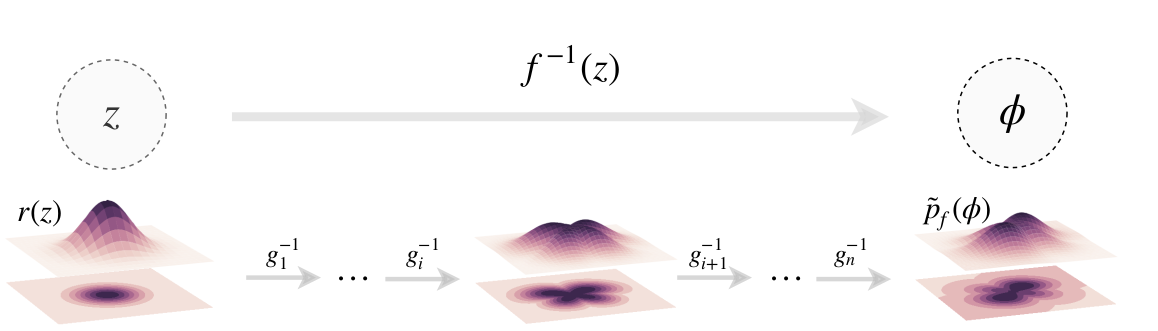
</div>
<div align="center">Fig. 1 of [1904.12072]. The notation superficially differs from what we present here.</div>

**Coupling layers** are one approach to defining the $g_i$ in the composed function. These functions are defined to update only a subset of the input variables, conditioned on the complimentary ("frozen") subset. For example, if the input to a coupling layer was a lattice with one real number per site, the layer could be defined to update only the odd sites in a checkerboard pattern. To ensure all variables are updated, we could then compose coupling layers that alternatingly update odd sites and even sites.

In a coupling layer, the transform applied to the updated subset of variables is manifestly a simply inverted operation such as a scaling ($x \rightarrow e^s x$) or affine transformation ($x \rightarrow e^s x + t$). For example, a coupling layer $g(x_1, x_2) = (x_1', x_2')$ based on an scaling transformation looks like

\begin{equation}
\begin{split}
  x_1 '  &= e^{s(x_2)}x_1 \\
  x_2 '  &= x_2
\end{split}
\end{equation}

where $x_1, x_2$ are subsets of the components of $x$. We say that $x_1$ is _updated_ based on the _frozen_ subset $x_2$, which is not changed by the coupling layer. $e^{s(x_2)}$ is a vector of the same shape as $x_1$, and $e^{x(s_2)} x_1$ denotes an elementwise product. The _parameters defining the transform_, $s(x_2)$, can be complicated, non-invertible functions of the frozen subset of variables.  However, the inverse of this transformation $g^{-1} (x_1', x_2') = (x_1, x_2)$ is simply computed using the same parameters,

\begin{equation}
\begin{split}
x_1  &= e^{-s(x_2')} x_1' \\
x_2  &= x_2'.
\end{split}
\end{equation}

Here the key to guaranteeing invertibility is that $x_2 = x_2'$. This "trick" is exactly what guarantees invertibility for leapfrog integrators, which alternately update position and momentum variables.

This also ensures a triangular Jacobian,
\begin{equation}
\frac{\partial g(x_1, x_2)}{\partial x} =
\left( \begin{matrix}
    \frac{\partial x_1'}{\partial x_1} & \frac{\partial x_1'}{\partial x_2} \\
    0 & 1
\end{matrix} \right),
\end{equation}
which in the scaling example takes the form
\begin{equation}
\frac{\partial g(x_1, x_2)}{\partial x} =
\left( \begin{array}{ccc|ccc}
    e^{[s(x_2)]_1} & & & \cdot & \cdot & \cdot \\
    & e^{[s(x_2)]_2} & & \cdot & \cdot & \cdot \\
    & & \ddots & \cdot & \cdot & \cdot \\
    \hline
    & & & 1 & & \\
    & 0 & & & 1 & \\
    & & & & & \ddots
\end{array} \right)
\end{equation}
where we have expanded the blocks over $(x_1', x_2') \times (x_1, x_2)$ from the first expression.
Therefore $J(x)$ is efficiently computed as
\begin{equation}
J(x) = \left|\det_{kl} \frac{\partial [g(x_1, x_2)]_k}{\partial x_l} \right| = \prod_{k} e^{[s(x_2)]_k}
\end{equation}
where $k$ runs over the components in $s(x_2)$. The Jacobian of the inverse transformation is simply $J_\text{reverse}(x') = 1/J(x') = \prod_k e^{[-s(x_2')]_k}$; note that here we were able to compute the reverse Jacobian in terms of the forward Jacobian applied to $x'$ because of the simplicity of the coupling layer.

The coupling layer architecture makes it easier to guarantee invertibility while retaining expressivity: the functions which provide the parameters of  the transformation are flexible while the inverse and Jacobian factor of such coupling transformations are easy to compute. Many such coupling layers can be stacked to compose expressive functions $f$ efficiently.


## **Simple coupling layer demo**

To demonstrate coupling layers in practice, we define a coupling layer using scaling (see above) for two-dimensional inputs $x \equiv (x_1,x_2)$ [i.e. in comparison to the previous section, here $x_1$ and $x_2$ are just scalars]. Because we have the freedom to make the function $s(x_2)$ arbitrarily complex without sacrificing invertibility, we parametrize $s(x_2)$ as a neural net made of alternating layers of linear transformations and ReLU ("rectified linear unit") activation functions, with a $\tanh$ activation function after the final linear transform.

<!--Although the neural net defined in the code below is very simple by NN standards, $s$ already has 36 free parameters. Altogether, this construction allows for very flexible behavior while remaining invertible.-->

We implement coupling layers as an extension of `torch.nn.Module` to include application of $g$ (see `forward`) and inverse $g^{-1}$ (see `reverse`). These both map from the domain of lattice degrees of freedom to itself, $\mathcal{X} \rightarrow \mathcal{X}$; in this case, this is just $\mathbb{R}^2 \rightarrow \mathbb{R}^2$. The superclass automatically holds references to all tunable parameters (weights) that will later be optimized.

In [6]:
class SimpleNormal:
    def __init__(self, loc, var):
        self.dist = torch.distributions.normal.Normal(
            torch.flatten(loc), torch.flatten(var))
        self.shape = loc.shape
    def log_prob(self, x):
        logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
        return torch.sum(logp, dim=1)
    def sample_n(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x.reshape(batch_size, *self.shape)

In [7]:
# init weights in a way that gives interesting behavior without training
def set_weights(m):
    if hasattr(m, 'weight') and m.weight is not None:
        torch.nn.init.normal_(m.weight, mean=1, std=2)
    if hasattr(m, 'bias') and m.bias is not None:
        m.bias.data.fill_(-1)

Let's see what our simple coupling layer $g$ does. We draw a batch of samples $x$ from an arbitrary input distribution (uniform in $[0,1]^2$), feed it through the coupling layer forwards to get samples $g(x)$ from a new distribution, then feed $g(x)$ backwards through the coupling layer to double-check that we recover our original sample $x' = g^{-1}(g(x)) \overset{!}{=} x$.

Añadido por mí: el modelo `coupling_layer.s()` aplica la misma función `s` a cada punto. Por eso el `torch.nn.Linear` inicial comienza con 1 nodo solo. Ejemplo:

Continuación notebook

## **Composition**

The Jacobian factors $J_i$ from each coupling layer simply multiply together to define the Jacobian factor of the composed function, so that the final density is
\begin{equation}
\begin{split}
    q(x) &= r(z) \left| \det \frac{\partial f(z)}{\partial z} \right|^{-1} = r(z) \prod_{i} J_i^{-1}.
\end{split}
\end{equation}
In practice, we'll add together log Jacobians instead. Altogether, sampling and computing the density is simple composition.

In [8]:
def apply_flow_to_prior(prior, coupling_layers, *, batch_size):
    x = prior.sample_n(batch_size)
    logq = prior.log_prob(x)
    for layer in coupling_layers:
        x, logJ = layer.forward(x)
        logq = logq - logJ
    return x, logq

# Application 1: $\phi^4$ lattice scalar field theory in 2d

As an example, we consider applying normalizing flows to sampling the distributions associated with scalar field theory in two spacetime dimensions with a $\phi^4$ interaction. See <span data-cite="Albergo:2019eim">[1904.12072]</span> for details.

## **Physical theory**

The continuum theory consists of a single real scalar field $\phi(\vec{x})$ as a function of 2D coordinates $\vec{x}$. To access non-perturbative results, such as behavior in the strong-coupling regime, we can regularize the theory on a 2D lattice, assigning one real degree of freedom per site of the lattice. Let's initialize some configurations of an example lattice of size $8\times8$ and generate two random configurations:

In [9]:
L = 8
lattice_shape = (L,L)

phi_ex1 = np.random.normal(size=lattice_shape).astype(float_dtype)
phi_ex2 = np.random.normal(size=lattice_shape).astype(float_dtype)
cfgs = torch.from_numpy(np.stack((phi_ex1, phi_ex2), axis=0)).to(torch_device)


A simple discretization of the derivatives in the continuum Euclidean action gives rise to a valid lattice Euclidean action,
\begin{equation}
\begin{split}
S^E_{\text{cont}}[\phi] &= \int d^2\vec{x} ~ (\partial_\mu \phi(\vec{x}))^2 + m^2 \phi(\vec{x})^2 + \lambda \phi(\vec{x})^4 \\
\rightarrow S^E_{\text{latt}}(\phi) &= \sum_{\vec{n}} \phi(\vec{n}) \left[ \sum_{\mu \in \{1,2\}} 2\phi(\vec{n}) - \phi(\vec{n}+\hat{\mu}) - \phi(\vec{n}-\hat{\mu}) \right] + m^2 \phi(\vec{n})^2 + \lambda \phi(\vec{n})^4
\end{split}
\end{equation}
where now $\phi(\vec{n})$ is only defined on the sites of the $L_x \times L_y$ lattice, $\vec{n} = (n_x, n_y)$, with integer $n_x, n_y$. We have implicitly moved to "lattice units" where $a=1$ such that $L_x, L_y, V$ are integers and all quantities are unitless. The discretized field $\phi$ can therefore be thought of as an $(L_x \times L_y)$-dimensional vector. We use periodic boundary conditions in all directions, i.e. $\phi(L_x, y) \equiv \phi(0, y)$, etc. For convenience, we typically abbreviate $S^E_{\text{latt}} \equiv S$.

More details on $\phi^4$ lattice scalar field theory can be found in <span data-cite="vierhaus2010simulation">[this thesis](https://edoc.hu-berlin.de/bitstream/handle/18452/14790/schroeder.pdf?sequence=1)</span>.

The lattice action then defines a probability distribution over configurations $\phi$,
\begin{equation}
p(\phi) = \frac{1}{Z} e^{-S(\phi)}, \quad
Z \equiv \int \prod_{\vec{n}} d\phi(\vec{n}) ~ e^{-S(\phi)},
\end{equation}
where $\prod_{\vec{n}}$ runs over all lattice sites $\vec{n}$.
This is the distribution we are training the normalizing flows to reproduce. While $Z$ is difficult to calculate, in practice we only need $p(\phi)$ up to a constant. The action can be efficiently calculated on arbitrary configurations using Pytorch. Note that while the theory describes 2D spacetime, the dimensionality of distribution $p(\phi)$ is the number of lattice sites, scaling with the volume of the lattice.

In [10]:
class ScalarPhi4Action:
    def __init__(self, M2, lam):
        self.M2 = M2
        self.lam = lam
    def __call__(self, cfgs):
        # potential term
        action_density = self.M2*cfgs**2 + self.lam*cfgs**4
        # kinetic term (discrete Laplacian)
        Nd = len(cfgs.shape)-1
        dims = range(1,Nd+1)
        for mu in dims:
            action_density += 2*cfgs**2
            action_density -= cfgs*torch.roll(cfgs, -1, mu)
            action_density -= cfgs*torch.roll(cfgs, 1, mu)
        return torch.sum(action_density, dim=tuple(dims))

print("Actions for example configs:", ScalarPhi4Action(M2=1.0, lam=1.0)(cfgs))

Actions for example configs: tensor([511.7663, 383.2905])


The theory has a symmetric phase and a broken symmetry phase, corresponding respectively to nearly one mode of the distribution or two widely separated modes (with intermediate configurations suppressed exponentially in volume). The broken symmetry phase can be accessed for $m^2 < 0$ and $\lambda$ less than a critical $\lambda_c$. For simplicity, we restrict focus to the **symmetric phase**, but remain close to this phase transition such that the system has a non-trivial correlation length.

In [12]:
M2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(M2=M2, lam=lam)

###  Comparing with $\beta$ parametrization

In [13]:
def get_action(phi, k, l):
    return np.sum(-2 * k * phi * (np.roll(phi, 1, 0) + np.roll(phi, 1, 1))
                  + (1 - 2 * l) * phi**2 + l * phi**4)

def get_drift(phi, k, l):
    return (2 * k * (np.roll(phi, 1, 0) + np.roll(phi, -1, 0)
                     + np.roll(phi, 1, 1) + np.roll(phi, -1, 1))
            + 2 * phi * (2 * l * (1 - phi**2) - 1))

def get_hamiltonian(chi, action):
    return 0.5 * np.sum(chi**2) + action

In [14]:
np_cfgs = grab(cfgs)

In [15]:
L = 8
k = 0.3
l = 0.02

In [16]:
get_action(np_cfgs[1], k, l)

52.78133

## **Prior distribution**

We choose the prior distribution to be I.I.D. Gaussians at each lattice site. This is easy to sample from, and intuitively gives the coupling layers a "blank slate" from which to build in correlations.

In [17]:
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))

We can use the `draw` function to acquire samples from the prior. Some samples drawn from the prior are visualized below.

z.shape = (1024, 8, 8)


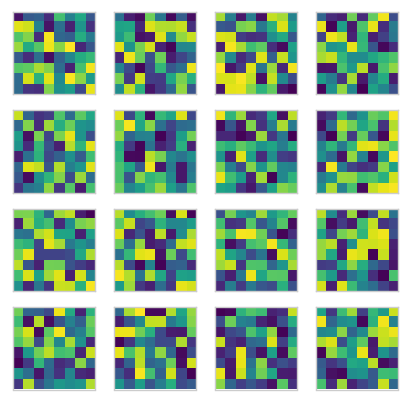

In [18]:
torch_z = prior.sample_n(1024)
z = grab(torch_z)
print(f'z.shape = {z.shape}')

fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(np.tanh(z[ind]), vmin=-1, vmax=1, cmap='viridis')
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
plt.show()

These samples look nothing like typical lattice configurations for the theory, which should exhibit patches of correlated positive and negative fluctuations (see configurations drawn from the true distribution in later sections). Samples from the prior do not have any correlations.

Below we show two-way histograms between various sites, demonstrating the uncorrelated nature of the prior distribution.

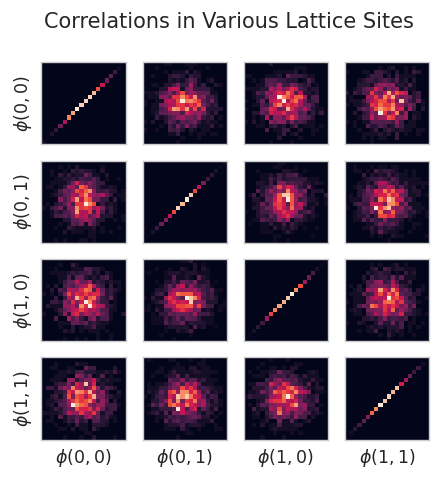

In [19]:
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for x1 in range(2):
    for y1 in range(2):
        i1 = x1*2 + y1
        for x2 in range(2):
            for y2 in range(2):
                i2 = x2*2 + y2
                ax[i1,i2].hist2d(z[:,x1,y1], z[:,x2,y2], range=[[-3,3],[-3,3]], bins=20)
                ax[i1,i2].set_xticks([])
                ax[i1,i2].set_yticks([])
                if i1 == 3:
                    ax[i1,i2].set_xlabel(rf'$\phi({x2},{y2})$')
                if i2 == 0:
                    ax[i1,i2].set_ylabel(rf'$\phi({x1},{y1})$')
fig.suptitle("Correlations in Various Lattice Sites")
plt.show()

We can also investigate the correlation between the "effective action" defining the model distribution (here, $-\log{r}(z)$) and the true action ($S(z)$). If the prior distribution was already a good model for the true distribution, all samples should have identical action under the prior and true distributions, up to an overall shift. In other words, these should have linear correlation with slope $1$.

slope 1 linear regression S = -logr + 1439.2820


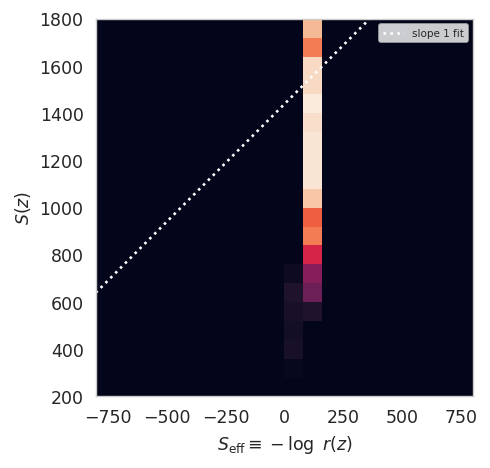

In [20]:
S_eff = -grab(prior.log_prob(torch_z))
S = grab(phi4_action(torch_z))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = -logr + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[-800, 800], [200,1800]])
xs = np.linspace(-800, 800, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
ax.set_xlabel(r'$S_{\mathrm{eff}} \equiv -\log~r(z)$')
ax.set_ylabel(r'$S(z)$')
ax.set_aspect('equal')
plt.legend(prop={'size': 6})
plt.show()

As expected, we are far from that goal because we have not flowed yet! We will revisit this plot after including and training the change-of-variables $f$.


## **Affine coupling layers**

As mentioned earlier, an affine transformation is a particularly simple, yet effective, transform to use within a coupling layer acting on real degrees of freedom. The transformation of the subset of variables $\phi_1$, conditioned on the frozen subset $\phi_2$, is defined as
\begin{equation}
    g(\phi_1, \phi_2) = \left(e^{s(\phi_2)} \phi_1 + t(\phi_2),  \phi_2\right),
\end{equation}
with inverse given by:
\begin{equation} g^{-1}(\phi_1', \phi_2') =  \left((\phi_1' - t(\phi_2')) e^{-s(\phi_2')}, \phi_2'\right)  \end{equation}
where $s(\phi_2)$ and $t(\phi_2)$ produce vectors of the same dimension as $\phi_1$ and operations above are element-wise on these vectors. We define the functions $s$ and $t$ using a feed-forward neural network. The coupling layer leaves $\phi_2$ unchanged. Note that this is just a simple extension of the scaling transformation introduced above, with a constant offset $t(\phi_2)$ added to the transformation.



The Jacobian factor for such an affine transformation is easy to compute (both analytically and numerically). In fact, because $\partial [t(\phi_2)] / \partial \phi_1 = 0$, the Jacobian is the same as for the scaling transformation worked out above. In practice, we work with log probabilities, so we note that the forward and reverse transformation return
\begin{align}
&&\text{forward:} \qquad &\log J(\phi) &&= \sum_k [s(\phi_2)]_k \\ 
&&\text{reverse:} \qquad &\log J_\text{reverse}(\phi') &&= \sum_k -[s(\phi_2')]_k .
\end{align}


The subsets $\phi_1, \phi_2$ are defined by a mask $m(\vec{n}) \in \{0, 1\}$. In our conventions $m(\vec{n}) = 1$ implies an input to the neural net defining $s$ and $t$, and therefore that the variable on site $\vec{n}$ is an element of the frozen subset $\phi_2$.
We choose checkerboard masking, as this intuitively allows sites to influence the transformation of their direct neighbors and build local correlations.

In [21]:
def make_checker_mask(shape, parity):
    checker = torch.ones(shape, dtype=torch.uint8) - parity
    checker[::2, ::2] = parity
    checker[1::2, 1::2] = parity
    return checker.to(torch_device)

print("For example this is the mask for an 8x8 configuration:\n",
      make_checker_mask(lattice_shape, 0))

For example this is the mask for an 8x8 configuration:
 tensor([[0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0]], dtype=torch.uint8)


We implement the described coupling layer in the code cell below.

For simplicity in our implementation below, we allow $s(\phi_2)$ and $t(\phi_2)$ to produce outputs for $\phi_2$ as well as $\phi_1$ and then mask them out. We use the same NN to parametrize $s$ and $t$, so they have shared parameters; this does not add formal complications and just makes the model simpler. 

**Technical note:** Pytorch's implementation of 2D CNNs requires inputs shaped like `(batch_size, n_input_channels, L_x, L_y)`, hence the use of `unsqueeze` below which adds a fake `n_input_channels` dimension of length 1. The CNNs return an output shaped like `(batch_size, n_output_channels, L_x, L_y)`; we use `n_output_channels == 2`, where the two channels are $s(x_2)$ and $t(x_2)$.

In [22]:
class AffineCoupling(torch.nn.Module):
    def __init__(self, net, *, mask_shape, mask_parity):
        super().__init__()
        self.mask = make_checker_mask(mask_shape, mask_parity)
        self.net = net

    def forward(self, x):
        x_frozen = self.mask * x      
        x_active = (1 - self.mask) * x
        net_out = self.net(x_frozen.unsqueeze(1))
        s, t = net_out[:,0], net_out[:,1]
        fx = (1 - self.mask) * t + x_active * torch.exp(s) + x_frozen
        axes = range(1,len(s.size()))
        logJ = torch.sum((1 - self.mask) * s, dim=tuple(axes))
        return fx, logJ

    def reverse(self, fx):
        fx_frozen = self.mask * fx
        fx_active = (1 - self.mask) * fx  
        net_out = self.net(fx_frozen.unsqueeze(1))
        s, t = net_out[:,0], net_out[:,1]
        x = (fx_active - (1 - self.mask) * t) * torch.exp(-s) + fx_frozen
        axes = range(1,len(s.size()))
        logJ = torch.sum((1 - self.mask)*(-s), dim=tuple(axes))
        return x, logJ

## **Convolutional neural nets (CNNs)**

Any continuous function can be used to define the coupling layer parameters $s$ and $t$. We'll use CNNs because they're cheap and explicitly encode partial spacetime translation symmetry: the parity-preserving translations are exact symmetries of the output distribution, due to the checkerboard subsets. (**Note:** in <span data-cite="Albergo:2019eim">[1904.12072]</span>, fully-connected networks were used as a proof of principle; we find CNNs are generally the better choice.)

Unlike typical uses of CNNs, our flow formalism requires the input and output (spatial) shapes to be identical, so there are no pooling operations and we use stride 1. To implement periodic BCs, we employ circular padding.

**Technical note:** In below code we assume PyTorch >= 1.5.0 where padding semantics changed. If you are willing to downgrade, the requirement than kernels have odd side length can be dropped, and padding semantics should be changed to `padding_size = kernel_size-1`.


In [23]:
def make_conv_net(*, hidden_sizes, kernel_size, in_channels, out_channels, use_final_tanh):
    sizes = [in_channels] + hidden_sizes + [out_channels]
    assert packaging.version.parse(torch.__version__) >= packaging.version.parse('1.5.0')
    assert kernel_size % 2 == 1, 'kernel size must be odd for PyTorch >= 1.5.0'
    padding_size = (kernel_size // 2)
    net = []
    for i in range(len(sizes) - 1):
        net.append(torch.nn.Conv2d(
            sizes[i], sizes[i+1], kernel_size, padding=padding_size,
            stride=1, padding_mode='circular'))
        if i != len(sizes) - 2:
            net.append(torch.nn.LeakyReLU())
        else:
            if use_final_tanh:
                net.append(torch.nn.Tanh())
    return torch.nn.Sequential(*net)

## **Assemble the model**

We can construct our model for $p(\phi)$ by composing a sequence of these affine coupling layers. We'll use 16 layers, with checkerboard parity alternating between sites. The CNNs used to compute parameters have kernel size 3x3 which is sufficient to condition on local information in each transform, allowing the flow to build up local correlations in the field configuration. Larger kernel sizes are also possible at increased cost.

Each network has one input channel $\phi$ and two output channels $\left(s(\phi), t(\phi)\right)$.



In [24]:
def make_phi4_affine_layers(*, n_layers, lattice_shape, hidden_sizes, kernel_size):
    layers = []
    for i in range(n_layers):
        parity = i % 2
        net = make_conv_net(
            in_channels=1, out_channels=2, hidden_sizes=hidden_sizes,
            kernel_size=kernel_size, use_final_tanh=True)
        coupling = AffineCoupling(net, mask_shape=lattice_shape, mask_parity=parity)
        layers.append(coupling)
    return torch.nn.ModuleList(layers)

In [25]:
n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_affine_layers(
    lattice_shape=lattice_shape, n_layers=n_layers, 
    hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}

## **Train the model**

With a model in hand, we need to optimize the coupling layers to improve the model distribution $q(\phi)$. To do that, we need a way to measure how close the model and true distributions are [$q(\phi)$ vs $p(\phi)$, respectively]. We use a quantity known as the Kullback-Leibler (KL) divergence to do this. The KL divergence is minimized when $p = q$.

Those familiar with flows will note that they are usually trained with the "forward direction" of the KL divergence,
\begin{equation}
D_{KL}(p || q) \equiv \int d\phi ~ p(\phi) \left[ \log{p}(\phi) - \log{q}(\phi) \right]
\end{equation}
which we can estimate with $N$ samples drawn from the target distribution ($\phi_i \sim p$) as
\begin{equation}
\widehat{D}_{KL}(p || q) = \frac{1}{N} \sum_{i=1}^N \left[ \log{p}(\phi_i) - \log{q}(\phi_i) \right] \quad \left( \phi_i \sim p \right)
\end{equation}
corresponding to maximum likelihood estimation with respect to training data from the true distribution.

Because training data drawn from $p$ can be scarce in simulations of lattice field theories, we instead make use of the "reverse" KL divergence,
\begin{equation}
D_{KL}(q || p) \equiv \int d\phi ~ q(\phi) \left[ \log{q}(\phi) - \log{p}(\phi) \right]
\end{equation}
which we can estimate using $N$ samples drawn from the model distribution ($\phi_i \sim q$) as
\begin{equation}
\widehat{D}_{KL}(q || p) = \frac{1}{N} \sum_{i=1}^N \left[ \log{q}(\phi_i) - \log{p}(\phi_i) \right] \quad \left( \phi_i \sim q \right).
\end{equation}
Because data need only be sampled from the _model_ distribution, we can optimize $q(\phi)$ without data from $p(\phi)$ [which typically is expensive to generate using standard algorithms like HMC]. This "self-training" protocol then consists of
  1. Drawing samples and density estimates from the model
  2. Estimating the reverse KL divergence
  3. Using standard stochastic gradient descent methods to iteratively update neural network weights (we'll use the Adam optimizer)

A possible tradeoff of this approach is that the reverse KL is known as mode-seeking / zero-forcing (see e.g. <span data-cite="huszar2015not">[1511.05101]</span>) which means it favors assigning mass  to a large mode in the probability density, and places zero mass elsewhere. This could be disadvantageous for multimodal target densities. This problem will be investigated in future work.

In [26]:
def calc_dkl(logp, logq):
    return (logq - logp).mean()  # reverse KL, assuming samples from q

Note that the training step defined below logs a few metrics, including the effective sample size (ESS) defined and explained later.

In [27]:
def train_step(model, action, loss_fn, optimizer, metrics):
    layers, prior = model['layers'], model['prior']
    optimizer.zero_grad()

    x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
    logp = -action(x)
    loss = calc_dkl(logp, logq)
    loss.backward()

    optimizer.step()

    metrics['loss'].append(grab(loss))
    metrics['logp'].append(grab(logp))
    metrics['logq'].append(grab(logq))
    metrics['ess'].append(grab( compute_ess(logp, logq) ))

**Caveat:** $p(\phi)$ is only known up to normalization, $p(\phi) \propto e^{-S[\phi]}$. Using this unnormalized value shifts the KL divergence by an overall constant. This does not affect training, but without this normalization we cannot know whether we are converging to a good estimate directly from the unnormalized KL.

### **Telemetry**

We'll measure some observables and diagnostics as we go.

For a batch of samples $\phi_i$, the effective sample size (ESS) is defined as
\begin{equation}
\frac{ \left(\frac{1}{N} \sum_i p[\phi_i]/q[\phi_i] \right)^2 }{ \frac{1}{N} \sum_i \left( p[\phi_i]/q[\phi_i] \right)^2 }
\end{equation}
where $i$ indexes the samples. This definition normalizes the ESS to live in the range $[0,1]$. The ESS provides a useful measure of model quality that doesn't require the overall normalization of $p(x)$, where larger values indicate a better effective sampling of the desired distribution and $\mathrm{ESS} = 1$ is a perfect independent draw from the desired distribution for each sample.

Why not use this directly to train? It's much noisier than the KL divergences, so in practice we find it's less effective as a loss function.

**Caution:** The ESS is biased towards larger values when estimated using small batches of samples. Much like measures of autocorrelation time in MCMC approaches, a sufficiently large sample size is needed to determine whether any regions of sample space are missed.

In [28]:
def compute_ess(logp, logq):
    logw = logp - logq
    log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
    ess_per_cfg = torch.exp(log_ess) / len(logw)
    return ess_per_cfg

In [29]:
def print_metrics(history, avg_last_N_epochs):
    print(f'== Era {era} | Epoch {epoch} metrics ==')
    for key, val in history.items():
        avgd = np.mean(val[-avg_last_N_epochs:])
        print(f'\t{key} {avgd:g}')

### **Do the training!**

We find that this model trains to achieve an average ESS $\sim 20 \%$ after 40 eras with 100 epochs each, which takes  $\sim 30$ minutes on a Colab GPU. We point out that ESS is a good metric for training but it fluctuates significantly and can have a bias at finite sample size, so care should be taken in interpreting the results.

You can either load a pre-trained model or train your own based on the flag below.

In [30]:
use_pretrained = False

Below we summarize all parameters discussed so far for the sake of convenience. 

In [31]:
# Lattice Theory
L = 8
lattice_shape = (L,L)
beta = np.sqrt(1./16.)
lam = 0.5
phi4_action = ScalarPhi4ActionBeta(beta=beta, lam=lam)

# Model
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))

n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_affine_layers(lattice_shape=lattice_shape, n_layers=n_layers, 
    hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}

# Training
base_lr = .001
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)

As with any good cooking show, we made a trained version of the model weights ahead of time (loaded if `use_pretrained == True`).



Main training setup and loop.

In [32]:
N_era = 10
N_epoch = 100
batch_size = 64
print_freq = N_epoch
plot_freq = 1

history = {
    'loss' : [],
    'logp' : [],
    'logq' : [],
    'ess' : []
}

In [33]:
use_pretrained = False

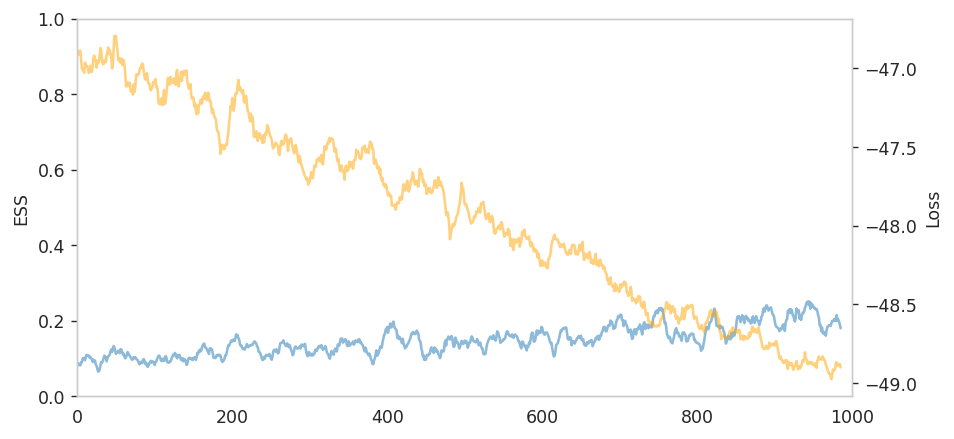

== Era 0 | Epoch 0 metrics ==
	loss -47.274
	logp -14.2525
	logq -61.5265
	ess 0.0447178
== Era 1 | Epoch 0 metrics ==
	loss -46.9863
	logp -15.0857
	logq -62.0719
	ess 0.100865
== Era 2 | Epoch 0 metrics ==
	loss -47.1911
	logp -15.1051
	logq -62.2961
	ess 0.102799
== Era 3 | Epoch 0 metrics ==
	loss -47.3942
	logp -15.0655
	logq -62.4597
	ess 0.13039
== Era 4 | Epoch 0 metrics ==
	loss -47.5836
	logp -15.0907
	logq -62.6742
	ess 0.126331
== Era 5 | Epoch 0 metrics ==
	loss -47.8024
	logp -15.1174
	logq -62.9198
	ess 0.141796
== Era 6 | Epoch 0 metrics ==
	loss -48
	logp -15.0651
	logq -63.0651
	ess 0.150208
== Era 7 | Epoch 0 metrics ==
	loss -48.2015
	logp -15.042
	logq -63.2435
	ess 0.156571
== Era 8 | Epoch 0 metrics ==
	loss -48.5111
	logp -15.0915
	logq -63.6026
	ess 0.182532
== Era 9 | Epoch 0 metrics ==
	loss -48.6663
	logp -15.0566
	logq -63.7229
	ess 0.187812


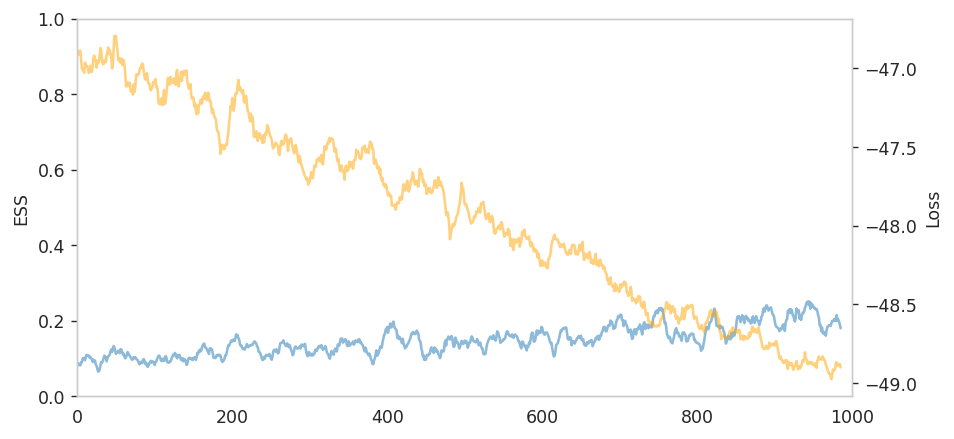

In [59]:
if not use_pretrained:
    [plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
    live_plot = init_live_plot()

    for era in range(N_era):
        for epoch in range(N_epoch):
            train_step(model, phi4_action, calc_dkl, optimizer, history)

            if epoch % print_freq == 0:
                print_metrics(history, avg_last_N_epochs=print_freq)

            if epoch % plot_freq == 0:
                update_plots(history, **live_plot)
else:
    print('Skipping training')

Serialize the weights to distribute the model in this state.

In [83]:
print('Model weights blob:\n===')
serialized_model = io.BytesIO()
torch.save(model['layers'].state_dict(), serialized_model)
print(base64.b64encode(serialized_model.getbuffer()).decode('utf-8'))
print('===')

Model weights blob:
===
UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRmxvYXRTdG9yYWdlCnEFWAEAAAAwcQZYBgAAAGN1ZGE6MHEHS0h0cQhRSwAoSwhLAUsDSwN0cQkoSwlLCUsDSwF0cQqJaAApUnELdHEMUnENWAwAAAAwLm5ldC4wLmJpYXNxDmgDKChoBGgFWAEAAAAxcQ9YBgAAAGN1ZGE6MHEQSwh0cRFRSwBLCIVxEksBhXETiWgAKVJxFHRxFVJxFlgOAAAAMC5uZXQuMi53ZWlnaHRxF2gDKChoBGgFWAEAAAAycRhYBgAAAGN1ZGE6MHEZTUACdHEaUUsAKEsISwhLA0sDdHEbKEtISwlLA0sBdHEciWgAKVJxHXRxHlJxH1gMAAAAMC5uZXQuMi5iaWFzcSBoAygoaARoBVgBAAAAM3EhWAYAAABjdWRhOjBxIksIdHEjUUsASwiFcSRLAYVxJYloAClScSZ0cSdScShYDgAAADAubmV0LjQud2VpZ2h0cSloAygoaARoBVgBAAAANHEqWAYAAABjdWRhOjBxK0uQdHEsUUsAKEsCSwhLA0sDdHEtKEtISwlLA0sBdHEuiWgAKVJxL3RxMFJxMVgMAAAAMC5uZXQuNC5iaWFzcTJoAygoaARoBVgBAAAANXEzWAYAAABjdWRhOjBxNEsCdHE1UUsASwKFcTZLAYVxN4loAClScTh0cTlScTpYDgAAADEubmV0LjAud2VpZ2h0cTtoAygoaARoBVgBAAAANnE8WAYAAABjdWRh

## **Gradient of the fields**

In [110]:
phi = prior.sample_n(1)

In [119]:
phi.requires_grad = True

In [120]:
phi.shape

torch.Size([1, 8, 8])

In [121]:
def apply_flow_to_fields(phis, coupling_layers):
    logq = prior.log_prob(phis)
    for layer in coupling_layers:
        phis, logJ = layer.forward(phis)
        logq = logq - logJ
    return phis, logq

In [122]:
phis_2, logq_2 = apply_flow_to_fields(phi, model['layers'])

In [123]:
external_grad_phis = torch.ones(phis_2.shape)
external_grad_logq = torch.ones(logq_2.shape)

In [124]:
#phis_2.backward(gradient=external_grad, retain_graph=True)
logq_2.backward(gradient=external_grad_logq)

In [130]:
phi.grad

tensor([[[ 1.2810, -1.3546,  0.5344,  0.7735,  0.0559, -0.2606, -0.6509,
           0.6387],
         [-0.2985, -0.5011,  0.6817, -0.1592,  0.2939, -0.5008,  0.2862,
          -0.1157],
         [ 0.0748, -0.9043,  0.9697,  0.1666, -0.9535,  0.8964,  0.0992,
          -0.0891],
         [-0.5409,  0.3045, -1.2997,  0.1931,  0.6702,  0.0725, -0.8656,
           0.4241],
         [ 0.3262, -0.3673,  0.0148,  1.5132, -0.5417,  0.0119, -0.7781,
           0.5223],
         [-1.4293, -0.2741, -1.1698, -0.7851,  0.9726, -0.0387, -0.3024,
          -0.7301],
         [ 0.5128, -0.3689,  0.4438,  0.1714,  0.8393, -2.5479, -0.4003,
           0.2337],
         [-0.0498, -0.0277, -0.2733, -1.2515,  0.3847,  1.6794,  0.8950,
          -0.4602]]])

In [118]:
# Needs to be reset, otherwise it is accumulated
phi.grad.zero_()

tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]])

In [190]:
phi.grad[0,0,2]

tensor(0.5344)

In [191]:
phi_cp = torch.clone(phi).detach()
phi_cp_eps = torch.clone(phi).detach()

In [196]:
epsilon = 0.001
phi_cp_eps[0,0,2] = phi_cp[0,0,2]+epsilon

In [197]:
trash, logq_cp = apply_flow_to_fields(phi_cp, model['layers'])

In [198]:
trash, logq_cp_eps = apply_flow_to_fields(phi_cp_eps, model['layers'])

In [199]:
(logq_cp_eps - logq_cp)/epsilon

tensor([0.5112], grad_fn=<DivBackward0>)

## **Evaluate the model**

With a trained model, we now directly draw samples from the model and check their quality  below. We find samples that have regions with smoother, correlated fluctuations, in comparison to the raw noise from the prior distribution seen above.

**Caution:** These samples are drawn from a distribution that only _approximates_ the desired one, so we stress that one should not measure and report observables directly using these model samples, as this would introduce bias. However, as discussed later, the reported probability density from the models allows us to either reweight or resample, producing **unbiased estimates of observables** when these steps are taken.

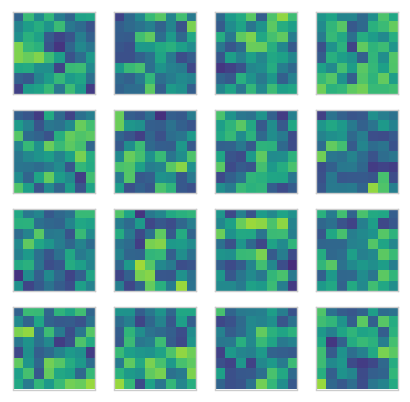

In [89]:
torch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)
x = grab(torch_x)

fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(np.tanh(x[ind]), vmin=-1, vmax=1, cmap='viridis')
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
plt.show()

We further see below that the model effective action ($-\log{q}(x)$) is very close to the true action, once we account for an overall shift. This offset corresponds to the unknown multiplicative constant $1/Z$ that our training is insensitive to. There is still some variation, especially in the regions with lower density, indicating the tails of the distribution are not perfectly modeled.

slope 1 linear regression S = S_eff + -48.9638


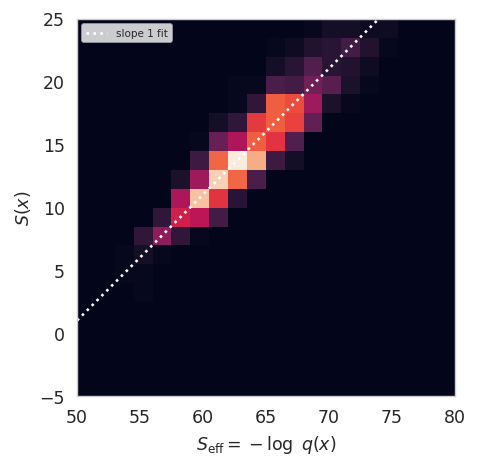

In [61]:
S_eff = -grab(torch_logq)
S = grab(phi4_action(torch_x))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[50, 80], [-5, 25]])
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$')
ax.set_ylabel(r'$S(x)$')
ax.set_aspect('equal')
xs = np.linspace(50, 80, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
plt.legend(prop={'size': 6})
plt.show()

We can see how the model density evolved over training time to become well-correlated with $p(x)$ over time (if `use_pretrained == False`).

ValueError: slice step cannot be zero

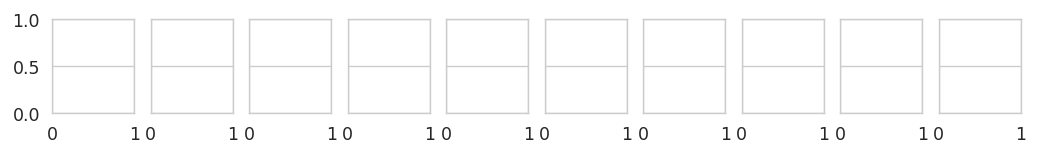

In [28]:
if not use_pretrained:
    fig, axes = plt.subplots(1, 10, dpi=125, sharey=True, figsize=(10, 1))
    logq_hist = np.array(history['logq']).reshape(N_era, -1)[::N_era//10]
    logp_hist = np.array(history['logp']).reshape(N_era, -1)[::N_era//10]
    for i, (ax, logq, logp) in enumerate(zip(axes, logq_hist, logp_hist)):
        ax.hist2d(-logq, -logp, bins=20, range=[[5, 35], [-5, 25]])
        if i == 0:
            ax.set_ylabel(r'$S(x)$')
        ax.set_xlabel(r'$S_{\mathrm{eff}}$')
        ax.set_title(f'Era {i * (N_era//10)}')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    plt.show()

### **Independence Metropolis**

To produce **unbiased** estimates of observables, either reweighting or resampling can be performed according to the weights $p(\phi_i)/q(\phi_i)$. See Sec. IIA of <span data-cite="Boyda:2020hsi">[2008.05456](https://arxiv.org/abs/2008.05456)</span> for a discussion of the tradeoffs in this choice. There are a number of possible resampling approaches; we choose to use the model samples as proposals in a Markov Chain Monte Carlo.

We'll use the Metropolis-Hastings (MH) algorithm to construct the asymptotically exact Markov chain sampler.
Generally, the MH algorithm consists of proposing an updated configuration $\phi'$ to the current configuration $\phi^{i-1}$ and stochastically accepting or rejecting the configuration with probability
\begin{equation}
p_{\mathrm{accept}}(\phi'|\phi^{i-1}) = \min \left(
    1,\;
    \frac{T(\phi' \rightarrow \phi^{i-1})}{T(\phi^{i-1} \rightarrow \phi')}
    \frac{p(\phi')}{p(\phi^{i-1})}
\right).
\end{equation}
Here $T(x \rightarrow y)$ is the probability of proposing config $y$ starting from $x$. If accepted, we define the next configuration in the chain to be $\phi^i = \phi'$; if rejected, the last configuration is repeated and $\phi^i = \phi^{i-1}$. Often, $p(\phi) \sim e^{-S}$ is computationally tractable but $T$ is not, so algorithms are engineered to have symmetric proposal probabilities such that $T(x \rightarrow y) = T(y \rightarrow x)$ and the factors in $p_{\text{accept}}$ cancel, leading to the familiar Metropolis formula $p^{\text{symm}}_{\text{accept}} = \min(1, \exp[-\Delta S])$.

We instead propose updates by drawing samples from our model independently of the previous configuration, so $T(x \rightarrow y) = T(y) = q(y)$, where $q(y)$ is the model density computed alongside sample $y$. The resulting proposal probability $T$ is therefore not symmetric but is known. We thus must accept or reject based on
\begin{equation}
p_{\mathrm{accept}}(\phi'|\phi^{i-1}) = \min \left(
    1,\;
    \frac{q(\phi^{i-1})}{p(\phi^{i-1})}
    \frac{p(\phi')}{q(\phi')}
\right).
\end{equation}
This procedure is known as the independence Metropolis sampler. Note that rejections occur proportionally to how poorly the model density matches the desired density; if $p(\phi') = q(\phi')$, all (independent) proposals are accepted, and the chain is a sequence of totally uncorrelated samples. As the rejection rate increases, the autocorrelation time does as well.

Below we build the MH algorithm in two stages. First, we need some way of generating an ordered list of samples using our model. The code below defines a generator which does this by drawing batches efficiently in parallel, then iterating over them one at at time.

In [29]:
def serial_sample_generator(model, action, batch_size, N_samples):
    layers, prior = model['layers'], model['prior']
    layers.eval()
    x, logq, logp = None, None, None
    for i in range(N_samples):
        batch_i = i % batch_size
        if batch_i == 0:
            # we're out of samples to propose, generate a new batch
            x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
            logp = -action(x)
        yield x[batch_i], logq[batch_i], logp[batch_i]

Now we need to iterate over the samples and construct them into a Markov Chain. The code below implements the Metropolis independence sampler to do this.

In [30]:
def make_mcmc_ensemble(model, action, batch_size, N_samples):
    history = {
        'x' : [],
        'logq' : [],
        'logp' : [],
        'accepted' : []
    }

    # build Markov chain
    sample_gen = serial_sample_generator(model, action, batch_size, N_samples)
    for new_x, new_logq, new_logp in sample_gen:
        if len(history['logp']) == 0:
            # always accept first proposal, Markov chain must start somewhere
            accepted = True
        else: 
            # Metropolis acceptance condition
            last_logp = history['logp'][-1]
            last_logq = history['logq'][-1]
            p_accept = torch.exp((new_logp - new_logq) - (last_logp - last_logq))
            p_accept = min(1, p_accept)
            draw = torch.rand(1) # ~ [0,1]
            if draw < p_accept:
                accepted = True
            else:
                accepted = False
                new_x = history['x'][-1]
                new_logp = last_logp
                new_logq = last_logq
        # Update Markov chain
        history['logp'].append(new_logp)
        history['logq'].append(new_logq)
        history['x'].append(new_x)
        history['accepted'].append(accepted)
    return history

Finally, the cell below uses the code above to generate an ensemble of configurations using our trained flow model. You should see a 30-40% accept rate.

In [81]:
ensemble_size = 1000
phi4_ens = make_mcmc_ensemble(model, phi4_action, 64, ensemble_size)
print("Accept rate:", np.mean(phi4_ens['accepted']))

Accept rate: 0.292


In [63]:
import gc

In [78]:
gc.collect()

3036

The generated ensemble is asymptotically unbiased. As an example of an observable measurements, we measure the two-point susceptibility below and compare against a value determined from a large HMC ensemble evaluated at the same choice of parameters.

In [82]:
n_therm = 512
cfgs = np.stack(list(map(grab, phi4_ens['x'])), axis=0)[n_therm:]
C = 0
for x in range(L):
    for y in range(L):
        C = C + cfgs*np.roll(cfgs, (-x, -y), axis=(1,2))
X = np.mean(C, axis=(1,2))

def bootstrap(x, *, Nboot, binsize):
    boots = []
    x = x.reshape(-1, binsize, *x.shape[1:])
    for i in range(Nboot):
        boots.append(np.mean(x[np.random.randint(len(x), size=len(x))], axis=(0,1)))
    return np.mean(boots), np.std(boots)
X_mean, X_err = bootstrap(X, Nboot=100, binsize=4)
print(f'Two-point susceptibility = {X_mean:.2f} +/- {X_err:.2f}')
print(f'... vs HMC estimate = 0.75 +/- 0.01')

Two-point susceptibility = 1.22 +/- 0.15
... vs HMC estimate = 0.75 +/- 0.01


**Caveat:** A poorly trained model can result in a small acceptance rate and large autocorrelations, in which case a more careful error analysis is needed to avoid underestimation of errors. Above we employ binning to reliably estimate error for despite any autocorrelations in the data.

###  Pre-trained MIT

In [88]:
if use_pretrained:
    print('Loading pre-trained model')
    phi4_trained_weights = torch.load(io.BytesIO(base64.b64decode(b"""
    UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRmxvYXRTdG9yYWdlCnEFWAoAAAAyMTg1MTM5ODA4cQZYBgAAAGN1ZGE6MHEHS0h0cQhRSwAoSwhLAUsDSwN0cQkoSwlLCUsDSwF0cQqJaAApUnELdHEMUnENWAwAAAAwLm5ldC4wLmJpYXNxDmgDKChoBGgFWAoAAAAyMTg1MTM5ODg4cQ9YBgAAAGN1ZGE6MHEQSwh0cRFRSwBLCIVxEksBhXETiWgAKVJxFHRxFVJxFlgOAAAAMC5uZXQuMi53ZWlnaHRxF2gDKChoBGgFWAoAAAAyMTg1MTM5OTY4cRhYBgAAAGN1ZGE6MHEZTUACdHEaUUsAKEsISwhLA0sDdHEbKEtISwlLA0sBdHEciWgAKVJxHXRxHlJxH1gMAAAAMC5uZXQuMi5iaWFzcSBoAygoaARoBVgKAAAAMjE4NTE0MDA0OHEhWAYAAABjdWRhOjBxIksIdHEjUUsASwiFcSRLAYVxJYloAClScSZ0cSdScShYDgAAADAubmV0LjQud2VpZ2h0cSloAygoaARoBVgKAAAAMjE4NTE0MDEyOHEqWAYAAABjdWRhOjBxK0uQdHEsUUsAKEsCSwhLA0sDdHEtKEtISwlLA0sBdHEuiWgAKVJxL3RxMFJxMVgMAAAAMC5uZXQuNC5iaWFzcTJoAygoaARoBVgKAAAAMjE4NTE0MDIwOHEzWAYAAABjdWRhOjBxNEsCdHE1UUsASwKFcTZLAYVxN4loAClScTh0cTlScTpYDgAAADEubmV0LjAud2VpZ2h0cTtoAygoaARoBVgKAAAAMjE4NTE0MDI4OHE8WAYAAABjdWRhOjBxPUtIdHE+UUsAKEsISwFLA0sDdHE/KEsJSwlLA0sBdHFAiWgAKVJxQXRxQlJxQ1gMAAAAMS5uZXQuMC5iaWFzcURoAygoaARoBVgKAAAAMjE4NTE0MDM2OHFFWAYAAABjdWRhOjBxRksIdHFHUUsASwiFcUhLAYVxSYloAClScUp0cUtScUxYDgAAADEubmV0LjIud2VpZ2h0cU1oAygoaARoBVgKAAAAMjE4NTE0MDUyOHFOWAYAAABjdWRhOjBxT01AAnRxUFFLAChLCEsISwNLA3RxUShLSEsJSwNLAXRxUoloAClScVN0cVRScVVYDAAAADEubmV0LjIuYmlhc3FWaAMoKGgEaAVYCgAAADIxODUxNDA2MDhxV1gGAAAAY3VkYTowcVhLCHRxWVFLAEsIhXFaSwGFcVuJaAApUnFcdHFdUnFeWA4AAAAxLm5ldC40LndlaWdodHFfaAMoKGgEaAVYCgAAADIxODUxNDA2ODhxYFgGAAAAY3VkYTowcWFLkHRxYlFLAChLAksISwNLA3RxYyhLSEsJSwNLAXRxZIloAClScWV0cWZScWdYDAAAADEubmV0LjQuYmlhc3FoaAMoKGgEaAVYCgAAADIxODUxNDA3NjhxaVgGAAAAY3VkYTowcWpLAnRxa1FLAEsChXFsSwGFcW2JaAApUnFudHFvUnFwWA4AAAAyLm5ldC4wLndlaWdodHFxaAMoKGgEaAVYCgAAADIxODUxNDA4NDhxclgGAAAAY3VkYTowcXNLSHRxdFFLAChLCEsBSwNLA3RxdShLCUsJSwNLAXRxdoloAClScXd0cXhScXlYDAAAADIubmV0LjAuYmlhc3F6aAMoKGgEaAVYCgAAADIxODUxNDA5Mjhxe1gGAAAAY3VkYTowcXxLCHRxfVFLAEsIhXF+SwGFcX+JaAApUnGAdHGBUnGCWA4AAAAyLm5ldC4yLndlaWdodHGDaAMoKGgEaAVYCgAAADIxODUxNDEwODhxhFgGAAAAY3VkYTowcYVNQAJ0cYZRSwAoSwhLCEsDSwN0cYcoS0hLCUsDSwF0cYiJaAApUnGJdHGKUnGLWAwAAAAyLm5ldC4yLmJpYXNxjGgDKChoBGgFWAoAAAAyMTg1MTQxMTY4cY1YBgAAAGN1ZGE6MHGOSwh0cY9RSwBLCIVxkEsBhXGRiWgAKVJxknRxk1JxlFgOAAAAMi5uZXQuNC53ZWlnaHRxlWgDKChoBGgFWAoAAAAyMTg1MTQxMjQ4cZZYBgAAAGN1ZGE6MHGXS5B0cZhRSwAoSwJLCEsDSwN0cZkoS0hLCUsDSwF0cZqJaAApUnGbdHGcUnGdWAwAAAAyLm5ldC40LmJpYXNxnmgDKChoBGgFWAoAAAAyMTg1MTQxMzI4cZ9YBgAAAGN1ZGE6MHGgSwJ0caFRSwBLAoVxoksBhXGjiWgAKVJxpHRxpVJxplgOAAAAMy5uZXQuMC53ZWlnaHRxp2gDKChoBGgFWAoAAAAyMTg1MTQxNDA4cahYBgAAAGN1ZGE6MHGpS0h0capRSwAoSwhLAUsDSwN0casoSwlLCUsDSwF0cayJaAApUnGtdHGuUnGvWAwAAAAzLm5ldC4wLmJpYXNxsGgDKChoBGgFWAoAAAAyMTg1MTQxNDg4cbFYBgAAAGN1ZGE6MHGySwh0cbNRSwBLCIVxtEsBhXG1iWgAKVJxtnRxt1JxuFgOAAAAMy5uZXQuMi53ZWlnaHRxuWgDKChoBGgFWAoAAAAyMTg1MTQxNjQ4cbpYBgAAAGN1ZGE6MHG7TUACdHG8UUsAKEsISwhLA0sDdHG9KEtISwlLA0sBdHG+iWgAKVJxv3RxwFJxwVgMAAAAMy5uZXQuMi5iaWFzccJoAygoaARoBVgKAAAAMjE4NTE0MTcyOHHDWAYAAABjdWRhOjBxxEsIdHHFUUsASwiFccZLAYVxx4loAClScch0cclSccpYDgAAADMubmV0LjQud2VpZ2h0cctoAygoaARoBVgKAAAAMjE4NTE0MTgwOHHMWAYAAABjdWRhOjBxzUuQdHHOUUsAKEsCSwhLA0sDdHHPKEtISwlLA0sBdHHQiWgAKVJx0XRx0lJx01gMAAAAMy5uZXQuNC5iaWFzcdRoAygoaARoBVgKAAAAMjE4NTE0MTg4OHHVWAYAAABjdWRhOjBx1ksCdHHXUUsASwKFcdhLAYVx2YloAClScdp0cdtScdxYDgAAADQubmV0LjAud2VpZ2h0cd1oAygoaARoBVgKAAAAMjE4NTE0MTk2OHHeWAYAAABjdWRhOjBx30tIdHHgUUsAKEsISwFLA0sDdHHhKEsJSwlLA0sBdHHiiWgAKVJx43Rx5FJx5VgMAAAANC5uZXQuMC5iaWFzceZoAygoaARoBVgKAAAAMjE4NTE0MjA0OHHnWAYAAABjdWRhOjBx6EsIdHHpUUsASwiFcepLAYVx64loAClScex0ce1Sce5YDgAAADQubmV0LjIud2VpZ2h0ce9oAygoaARoBVgKAAAAMjE3NTEwMzg0MHHwWAYAAABjdWRhOjBx8U1AAnRx8lFLAChLCEsISwNLA3Rx8yhLSEsJSwNLAXRx9IloAClScfV0cfZScfdYDAAAADQubmV0LjIuYmlhc3H4aAMoKGgEaAVYCgAAADIxNzUxMDcyMDBx+VgGAAAAY3VkYTowcfpLCHRx+1FLAEsIhXH8SwGFcf2JaAApUnH+dHH/UnIAAQAAWA4AAAA0Lm5ldC40LndlaWdodHIBAQAAaAMoKGgEaAVYCgAAADIxNzk2Mzc2MTZyAgEAAFgGAAAAY3VkYTowcgMBAABLkHRyBAEAAFFLAChLAksISwNLA3RyBQEAAChLSEsJSwNLAXRyBgEAAIloAClScgcBAAB0cggBAABScgkBAABYDAAAADQubmV0LjQuYmlhc3IKAQAAaAMoKGgEaAVYCgAAADIxNzk2MzEwNTZyCwEAAFgGAAAAY3VkYTowcgwBAABLAnRyDQEAAFFLAEsChXIOAQAASwGFcg8BAACJaAApUnIQAQAAdHIRAQAAUnISAQAAWA4AAAA1Lm5ldC4wLndlaWdodHITAQAAaAMoKGgEaAVYCgAAADIxNzk2MzA0OTZyFAEAAFgGAAAAY3VkYTowchUBAABLSHRyFgEAAFFLAChLCEsBSwNLA3RyFwEAAChLCUsJSwNLAXRyGAEAAIloAClSchkBAAB0choBAABSchsBAABYDAAAADUubmV0LjAuYmlhc3IcAQAAaAMoKGgEaAVYCgAAADIxNzk2Mzc1MzZyHQEAAFgGAAAAY3VkYTowch4BAABLCHRyHwEAAFFLAEsIhXIgAQAASwGFciEBAACJaAApUnIiAQAAdHIjAQAAUnIkAQAAWA4AAAA1Lm5ldC4yLndlaWdodHIlAQAAaAMoKGgEaAVYCgAAADIxNzk2MzIzMzZyJgEAAFgGAAAAY3VkYTowcicBAABNQAJ0cigBAABRSwAoSwhLCEsDSwN0cikBAAAoS0hLCUsDSwF0cioBAACJaAApUnIrAQAAdHIsAQAAUnItAQAAWAwAAAA1Lm5ldC4yLmJpYXNyLgEAAGgDKChoBGgFWAoAAAAyMTc5NjMyOTc2ci8BAABYBgAAAGN1ZGE6MHIwAQAASwh0cjEBAABRSwBLCIVyMgEAAEsBhXIzAQAAiWgAKVJyNAEAAHRyNQEAAFJyNgEAAFgOAAAANS5uZXQuNC53ZWlnaHRyNwEAAGgDKChoBGgFWAoAAAAyMTc5NjMyNDE2cjgBAABYBgAAAGN1ZGE6MHI5AQAAS5B0cjoBAABRSwAoSwJLCEsDSwN0cjsBAAAoS0hLCUsDSwF0cjwBAACJaAApUnI9AQAAdHI+AQAAUnI/AQAAWAwAAAA1Lm5ldC40LmJpYXNyQAEAAGgDKChoBGgFWAoAAAAyMTc5NjMyNDk2ckEBAABYBgAAAGN1ZGE6MHJCAQAASwJ0ckMBAABRSwBLAoVyRAEAAEsBhXJFAQAAiWgAKVJyRgEAAHRyRwEAAFJySAEAAFgOAAAANi5uZXQuMC53ZWlnaHRySQEAAGgDKChoBGgFWAoAAAAyMTc5NjMyODk2ckoBAABYBgAAAGN1ZGE6MHJLAQAAS0h0ckwBAABRSwAoSwhLAUsDSwN0ck0BAAAoSwlLCUsDSwF0ck4BAACJaAApUnJPAQAAdHJQAQAAUnJRAQAAWAwAAAA2Lm5ldC4wLmJpYXNyUgEAAGgDKChoBGgFWAoAAAAyMTc5NjMyMDE2clMBAABYBgAAAGN1ZGE6MHJUAQAASwh0clUBAABRSwBLCIVyVgEAAEsBhXJXAQAAiWgAKVJyWAEAAHRyWQEAAFJyWgEAAFgOAAAANi5uZXQuMi53ZWlnaHRyWwEAAGgDKChoBGgFWAoAAAAyMTc5NjMzMTM2clwBAABYBgAAAGN1ZGE6MHJdAQAATUACdHJeAQAAUUsAKEsISwhLA0sDdHJfAQAAKEtISwlLA0sBdHJgAQAAiWgAKVJyYQEAAHRyYgEAAFJyYwEAAFgMAAAANi5uZXQuMi5iaWFzcmQBAABoAygoaARoBVgKAAAAMjE3OTYzMTc3NnJlAQAAWAYAAABjdWRhOjByZgEAAEsIdHJnAQAAUUsASwiFcmgBAABLAYVyaQEAAIloAClScmoBAAB0cmsBAABScmwBAABYDgAAADYubmV0LjQud2VpZ2h0cm0BAABoAygoaARoBVgKAAAAMjE3OTYzODY1NnJuAQAAWAYAAABjdWRhOjBybwEAAEuQdHJwAQAAUUsAKEsCSwhLA0sDdHJxAQAAKEtISwlLA0sBdHJyAQAAiWgAKVJycwEAAHRydAEAAFJydQEAAFgMAAAANi5uZXQuNC5iaWFzcnYBAABoAygoaARoBVgKAAAAMjE3OTYzODU3NnJ3AQAAWAYAAABjdWRhOjByeAEAAEsCdHJ5AQAAUUsASwKFcnoBAABLAYVyewEAAIloAClScnwBAAB0cn0BAABScn4BAABYDgAAADcubmV0LjAud2VpZ2h0cn8BAABoAygoaARoBVgKAAAAMjE3OTYzODQxNnKAAQAAWAYAAABjdWRhOjBygQEAAEtIdHKCAQAAUUsAKEsISwFLA0sDdHKDAQAAKEsJSwlLA0sBdHKEAQAAiWgAKVJyhQEAAHRyhgEAAFJyhwEAAFgMAAAANy5uZXQuMC5iaWFzcogBAABoAygoaARoBVgKAAAAMjE3OTYzODMzNnKJAQAAWAYAAABjdWRhOjByigEAAEsIdHKLAQAAUUsASwiFcowBAABLAYVyjQEAAIloAClSco4BAAB0co8BAABScpABAABYDgAAADcubmV0LjIud2VpZ2h0cpEBAABoAygoaARoBVgKAAAAMjE3OTYzMzIxNnKSAQAAWAYAAABjdWRhOjBykwEAAE1AAnRylAEAAFFLAChLCEsISwNLA3RylQEAAChLSEsJSwNLAXRylgEAAIloAClScpcBAAB0cpgBAABScpkBAABYDAAAADcubmV0LjIuYmlhc3KaAQAAaAMoKGgEaAVYCgAAADIxNzk2Mjk5MzZymwEAAFgGAAAAY3VkYTowcpwBAABLCHRynQEAAFFLAEsIhXKeAQAASwGFcp8BAACJaAApUnKgAQAAdHKhAQAAUnKiAQAAWA4AAAA3Lm5ldC40LndlaWdodHKjAQAAaAMoKGgEaAVYCgAAADIxNzk2MzMzNzZypAEAAFgGAAAAY3VkYTowcqUBAABLkHRypgEAAFFLAChLAksISwNLA3RypwEAAChLSEsJSwNLAXRyqAEAAIloAClScqkBAAB0cqoBAABScqsBAABYDAAAADcubmV0LjQuYmlhc3KsAQAAaAMoKGgEaAVYCgAAADIxNzk2MzA0MTZyrQEAAFgGAAAAY3VkYTowcq4BAABLAnRyrwEAAFFLAEsChXKwAQAASwGFcrEBAACJaAApUnKyAQAAdHKzAQAAUnK0AQAAWA4AAAA4Lm5ldC4wLndlaWdodHK1AQAAaAMoKGgEaAVYCgAAADIxNzk2MzQwOTZytgEAAFgGAAAAY3VkYTowcrcBAABLSHRyuAEAAFFLAChLCEsBSwNLA3RyuQEAAChLCUsJSwNLAXRyugEAAIloAClScrsBAAB0crwBAABScr0BAABYDAAAADgubmV0LjAuYmlhc3K+AQAAaAMoKGgEaAVYCgAAADIxNzk2Mzg0OTZyvwEAAFgGAAAAY3VkYTowcsABAABLCHRywQEAAFFLAEsIhXLCAQAASwGFcsMBAACJaAApUnLEAQAAdHLFAQAAUnLGAQAAWA4AAAA4Lm5ldC4yLndlaWdodHLHAQAAaAMoKGgEaAVYCgAAADIxNzk2MzQyNTZyyAEAAFgGAAAAY3VkYTowcskBAABNQAJ0csoBAABRSwAoSwhLCEsDSwN0cssBAAAoS0hLCUsDSwF0cswBAACJaAApUnLNAQAAdHLOAQAAUnLPAQAAWAwAAAA4Lm5ldC4yLmJpYXNy0AEAAGgDKChoBGgFWAoAAAAyMTc5NjM4MTc2ctEBAABYBgAAAGN1ZGE6MHLSAQAASwh0ctMBAABRSwBLCIVy1AEAAEsBhXLVAQAAiWgAKVJy1gEAAHRy1wEAAFJy2AEAAFgOAAAAOC5uZXQuNC53ZWlnaHRy2QEAAGgDKChoBGgFWAoAAAAyMTc5NjMzNjE2ctoBAABYBgAAAGN1ZGE6MHLbAQAAS5B0ctwBAABRSwAoSwJLCEsDSwN0ct0BAAAoS0hLCUsDSwF0ct4BAACJaAApUnLfAQAAdHLgAQAAUnLhAQAAWAwAAAA4Lm5ldC40LmJpYXNy4gEAAGgDKChoBGgFWAoAAAAyMTc5NjM3Nzc2cuMBAABYBgAAAGN1ZGE6MHLkAQAASwJ0cuUBAABRSwBLAoVy5gEAAEsBhXLnAQAAiWgAKVJy6AEAAHRy6QEAAFJy6gEAAFgOAAAAOS5uZXQuMC53ZWlnaHRy6wEAAGgDKChoBGgFWAoAAAAyMTc5NjM3Njk2cuwBAABYBgAAAGN1ZGE6MHLtAQAAS0h0cu4BAABRSwAoSwhLAUsDSwN0cu8BAAAoSwlLCUsDSwF0cvABAACJaAApUnLxAQAAdHLyAQAAUnLzAQAAWAwAAAA5Lm5ldC4wLmJpYXNy9AEAAGgDKChoBGgFWAoAAAAyMTc5NjM0MTc2cvUBAABYBgAAAGN1ZGE6MHL2AQAASwh0cvcBAABRSwBLCIVy+AEAAEsBhXL5AQAAiWgAKVJy+gEAAHRy+wEAAFJy/AEAAFgOAAAAOS5uZXQuMi53ZWlnaHRy/QEAAGgDKChoBGgFWAoAAAAyMTc5NjMxNTM2cv4BAABYBgAAAGN1ZGE6MHL/AQAATUACdHIAAgAAUUsAKEsISwhLA0sDdHIBAgAAKEtISwlLA0sBdHICAgAAiWgAKVJyAwIAAHRyBAIAAFJyBQIAAFgMAAAAOS5uZXQuMi5iaWFzcgYCAABoAygoaARoBVgKAAAAMjE3OTYzMTY5NnIHAgAAWAYAAABjdWRhOjByCAIAAEsIdHIJAgAAUUsASwiFcgoCAABLAYVyCwIAAIloAClScgwCAAB0cg0CAABScg4CAABYDgAAADkubmV0LjQud2VpZ2h0cg8CAABoAygoaARoBVgKAAAAMjE3OTYzMTIxNnIQAgAAWAYAAABjdWRhOjByEQIAAEuQdHISAgAAUUsAKEsCSwhLA0sDdHITAgAAKEtISwlLA0sBdHIUAgAAiWgAKVJyFQIAAHRyFgIAAFJyFwIAAFgMAAAAOS5uZXQuNC5iaWFzchgCAABoAygoaARoBVgKAAAAMjE3OTYzMDk3NnIZAgAAWAYAAABjdWRhOjByGgIAAEsCdHIbAgAAUUsASwKFchwCAABLAYVyHQIAAIloAClSch4CAAB0ch8CAABSciACAABYDwAAADEwLm5ldC4wLndlaWdodHIhAgAAaAMoKGgEaAVYCgAAADIxNzk2MzA4OTZyIgIAAFgGAAAAY3VkYTowciMCAABLSHRyJAIAAFFLAChLCEsBSwNLA3RyJQIAAChLCUsJSwNLAXRyJgIAAIloAClScicCAAB0cigCAABScikCAABYDQAAADEwLm5ldC4wLmJpYXNyKgIAAGgDKChoBGgFWAoAAAAyMTc5NjMxMzc2cisCAABYBgAAAGN1ZGE6MHIsAgAASwh0ci0CAABRSwBLCIVyLgIAAEsBhXIvAgAAiWgAKVJyMAIAAHRyMQIAAFJyMgIAAFgPAAAAMTAubmV0LjIud2VpZ2h0cjMCAABoAygoaARoBVgKAAAAMjE3OTYyOTI5NnI0AgAAWAYAAABjdWRhOjByNQIAAE1AAnRyNgIAAFFLAChLCEsISwNLA3RyNwIAAChLSEsJSwNLAXRyOAIAAIloAClScjkCAAB0cjoCAABScjsCAABYDQAAADEwLm5ldC4yLmJpYXNyPAIAAGgDKChoBGgFWAoAAAAyMTc5NjM0MzM2cj0CAABYBgAAAGN1ZGE6MHI+AgAASwh0cj8CAABRSwBLCIVyQAIAAEsBhXJBAgAAiWgAKVJyQgIAAHRyQwIAAFJyRAIAAFgPAAAAMTAubmV0LjQud2VpZ2h0ckUCAABoAygoaARoBVgKAAAAMjE3OTYzNDQ5NnJGAgAAWAYAAABjdWRhOjByRwIAAEuQdHJIAgAAUUsAKEsCSwhLA0sDdHJJAgAAKEtISwlLA0sBdHJKAgAAiWgAKVJySwIAAHRyTAIAAFJyTQIAAFgNAAAAMTAubmV0LjQuYmlhc3JOAgAAaAMoKGgEaAVYCgAAADIxNzk2MzQ1NzZyTwIAAFgGAAAAY3VkYTowclACAABLAnRyUQIAAFFLAEsChXJSAgAASwGFclMCAACJaAApUnJUAgAAdHJVAgAAUnJWAgAAWA8AAAAxMS5uZXQuMC53ZWlnaHRyVwIAAGgDKChoBGgFWAoAAAAyMTc5NjM0NjU2clgCAABYBgAAAGN1ZGE6MHJZAgAAS0h0cloCAABRSwAoSwhLAUsDSwN0clsCAAAoSwlLCUsDSwF0clwCAACJaAApUnJdAgAAdHJeAgAAUnJfAgAAWA0AAAAxMS5uZXQuMC5iaWFzcmACAABoAygoaARoBVgKAAAAMjE3OTYzNDczNnJhAgAAWAYAAABjdWRhOjByYgIAAEsIdHJjAgAAUUsASwiFcmQCAABLAYVyZQIAAIloAClScmYCAAB0cmcCAABScmgCAABYDwAAADExLm5ldC4yLndlaWdodHJpAgAAaAMoKGgEaAVYCgAAADIxNzk2MzQ4MTZyagIAAFgGAAAAY3VkYTowcmsCAABNQAJ0cmwCAABRSwAoSwhLCEsDSwN0cm0CAAAoS0hLCUsDSwF0cm4CAACJaAApUnJvAgAAdHJwAgAAUnJxAgAAWA0AAAAxMS5uZXQuMi5iaWFzcnICAABoAygoaARoBVgKAAAAMjE3OTYzNDg5NnJzAgAAWAYAAABjdWRhOjBydAIAAEsIdHJ1AgAAUUsASwiFcnYCAABLAYVydwIAAIloAClScngCAAB0cnkCAABScnoCAABYDwAAADExLm5ldC40LndlaWdodHJ7AgAAaAMoKGgEaAVYCgAAADIxNzk2MzUwNTZyfAIAAFgGAAAAY3VkYTowcn0CAABLkHRyfgIAAFFLAChLAksISwNLA3RyfwIAAChLSEsJSwNLAXRygAIAAIloAClScoECAAB0coICAABScoMCAABYDQAAADExLm5ldC40LmJpYXNyhAIAAGgDKChoBGgFWAoAAAAyMTc5NjM1MTM2coUCAABYBgAAAGN1ZGE6MHKGAgAASwJ0cocCAABRSwBLAoVyiAIAAEsBhXKJAgAAiWgAKVJyigIAAHRyiwIAAFJyjAIAAFgPAAAAMTIubmV0LjAud2VpZ2h0co0CAABoAygoaARoBVgKAAAAMjE3OTYzNTIxNnKOAgAAWAYAAABjdWRhOjByjwIAAEtIdHKQAgAAUUsAKEsISwFLA0sDdHKRAgAAKEsJSwlLA0sBdHKSAgAAiWgAKVJykwIAAHRylAIAAFJylQIAAFgNAAAAMTIubmV0LjAuYmlhc3KWAgAAaAMoKGgEaAVYCgAAADIxNzk2MzUyOTZylwIAAFgGAAAAY3VkYTowcpgCAABLCHRymQIAAFFLAEsIhXKaAgAASwGFcpsCAACJaAApUnKcAgAAdHKdAgAAUnKeAgAAWA8AAAAxMi5uZXQuMi53ZWlnaHRynwIAAGgDKChoBGgFWAoAAAAyMTc5NjM1Mzc2cqACAABYBgAAAGN1ZGE6MHKhAgAATUACdHKiAgAAUUsAKEsISwhLA0sDdHKjAgAAKEtISwlLA0sBdHKkAgAAiWgAKVJypQIAAHRypgIAAFJypwIAAFgNAAAAMTIubmV0LjIuYmlhc3KoAgAAaAMoKGgEaAVYCgAAADIxNzk2MzU0NTZyqQIAAFgGAAAAY3VkYTowcqoCAABLCHRyqwIAAFFLAEsIhXKsAgAASwGFcq0CAACJaAApUnKuAgAAdHKvAgAAUnKwAgAAWA8AAAAxMi5uZXQuNC53ZWlnaHRysQIAAGgDKChoBGgFWAoAAAAyMTc5NjM1NjE2crICAABYBgAAAGN1ZGE6MHKzAgAAS5B0crQCAABRSwAoSwJLCEsDSwN0crUCAAAoS0hLCUsDSwF0crYCAACJaAApUnK3AgAAdHK4AgAAUnK5AgAAWA0AAAAxMi5uZXQuNC5iaWFzcroCAABoAygoaARoBVgKAAAAMjE3OTYzNTY5NnK7AgAAWAYAAABjdWRhOjByvAIAAEsCdHK9AgAAUUsASwKFcr4CAABLAYVyvwIAAIloAClScsACAAB0csECAABScsICAABYDwAAADEzLm5ldC4wLndlaWdodHLDAgAAaAMoKGgEaAVYCgAAADIxNzk2MzU3NzZyxAIAAFgGAAAAY3VkYTowcsUCAABLSHRyxgIAAFFLAChLCEsBSwNLA3RyxwIAAChLCUsJSwNLAXRyyAIAAIloAClScskCAAB0csoCAABScssCAABYDQAAADEzLm5ldC4wLmJpYXNyzAIAAGgDKChoBGgFWAoAAAAyMTc5NjM1ODU2cs0CAABYBgAAAGN1ZGE6MHLOAgAASwh0cs8CAABRSwBLCIVy0AIAAEsBhXLRAgAAiWgAKVJy0gIAAHRy0wIAAFJy1AIAAFgPAAAAMTMubmV0LjIud2VpZ2h0ctUCAABoAygoaARoBVgKAAAAMjE3OTYzNTkzNnLWAgAAWAYAAABjdWRhOjBy1wIAAE1AAnRy2AIAAFFLAChLCEsISwNLA3Ry2QIAAChLSEsJSwNLAXRy2gIAAIloAClSctsCAAB0ctwCAABSct0CAABYDQAAADEzLm5ldC4yLmJpYXNy3gIAAGgDKChoBGgFWAoAAAAyMTc5NjM2MDE2ct8CAABYBgAAAGN1ZGE6MHLgAgAASwh0cuECAABRSwBLCIVy4gIAAEsBhXLjAgAAiWgAKVJy5AIAAHRy5QIAAFJy5gIAAFgPAAAAMTMubmV0LjQud2VpZ2h0cucCAABoAygoaARoBVgKAAAAMjE3OTYzNjE3NnLoAgAAWAYAAABjdWRhOjBy6QIAAEuQdHLqAgAAUUsAKEsCSwhLA0sDdHLrAgAAKEtISwlLA0sBdHLsAgAAiWgAKVJy7QIAAHRy7gIAAFJy7wIAAFgNAAAAMTMubmV0LjQuYmlhc3LwAgAAaAMoKGgEaAVYCgAAADIxNzk2MzYyNTZy8QIAAFgGAAAAY3VkYTowcvICAABLAnRy8wIAAFFLAEsChXL0AgAASwGFcvUCAACJaAApUnL2AgAAdHL3AgAAUnL4AgAAWA8AAAAxNC5uZXQuMC53ZWlnaHRy+QIAAGgDKChoBGgFWAoAAAAyMTc5NjM2MzM2cvoCAABYBgAAAGN1ZGE6MHL7AgAAS0h0cvwCAABRSwAoSwhLAUsDSwN0cv0CAAAoSwlLCUsDSwF0cv4CAACJaAApUnL/AgAAdHIAAwAAUnIBAwAAWA0AAAAxNC5uZXQuMC5iaWFzcgIDAABoAygoaARoBVgKAAAAMjE3OTYzNjQxNnIDAwAAWAYAAABjdWRhOjByBAMAAEsIdHIFAwAAUUsASwiFcgYDAABLAYVyBwMAAIloAClScggDAAB0cgkDAABScgoDAABYDwAAADE0Lm5ldC4yLndlaWdodHILAwAAaAMoKGgEaAVYCgAAADIxNzk2MzY0OTZyDAMAAFgGAAAAY3VkYTowcg0DAABNQAJ0cg4DAABRSwAoSwhLCEsDSwN0cg8DAAAoS0hLCUsDSwF0chADAACJaAApUnIRAwAAdHISAwAAUnITAwAAWA0AAAAxNC5uZXQuMi5iaWFzchQDAABoAygoaARoBVgKAAAAMjE3OTYzNjU3NnIVAwAAWAYAAABjdWRhOjByFgMAAEsIdHIXAwAAUUsASwiFchgDAABLAYVyGQMAAIloAClSchoDAAB0chsDAABSchwDAABYDwAAADE0Lm5ldC40LndlaWdodHIdAwAAaAMoKGgEaAVYCgAAADIxNzk2MzcyMTZyHgMAAFgGAAAAY3VkYTowch8DAABLkHRyIAMAAFFLAChLAksISwNLA3RyIQMAAChLSEsJSwNLAXRyIgMAAIloAClSciMDAAB0ciQDAABSciUDAABYDQAAADE0Lm5ldC40LmJpYXNyJgMAAGgDKChoBGgFWAoAAAAyMTc5NjM2ODE2cicDAABYBgAAAGN1ZGE6MHIoAwAASwJ0cikDAABRSwBLAoVyKgMAAEsBhXIrAwAAiWgAKVJyLAMAAHRyLQMAAFJyLgMAAFgPAAAAMTUubmV0LjAud2VpZ2h0ci8DAABoAygoaARoBVgKAAAAMjE3OTYzMzc3NnIwAwAAWAYAAABjdWRhOjByMQMAAEtIdHIyAwAAUUsAKEsISwFLA0sDdHIzAwAAKEsJSwlLA0sBdHI0AwAAiWgAKVJyNQMAAHRyNgMAAFJyNwMAAFgNAAAAMTUubmV0LjAuYmlhc3I4AwAAaAMoKGgEaAVYCgAAADIxNzk2MzcyOTZyOQMAAFgGAAAAY3VkYTowcjoDAABLCHRyOwMAAFFLAEsIhXI8AwAASwGFcj0DAACJaAApUnI+AwAAdHI/AwAAUnJAAwAAWA8AAAAxNS5uZXQuMi53ZWlnaHRyQQMAAGgDKChoBGgFWAoAAAAyMTc5NjM3NDU2ckIDAABYBgAAAGN1ZGE6MHJDAwAATUACdHJEAwAAUUsAKEsISwhLA0sDdHJFAwAAKEtISwlLA0sBdHJGAwAAiWgAKVJyRwMAAHRySAMAAFJySQMAAFgNAAAAMTUubmV0LjIuYmlhc3JKAwAAaAMoKGgEaAVYCgAAADIxNzk2MzM0NTZySwMAAFgGAAAAY3VkYTowckwDAABLCHRyTQMAAFFLAEsIhXJOAwAASwGFck8DAACJaAApUnJQAwAAdHJRAwAAUnJSAwAAWA8AAAAxNS5uZXQuNC53ZWlnaHRyUwMAAGgDKChoBGgFWAoAAAAyMTc5NjMzNTM2clQDAABYBgAAAGN1ZGE6MHJVAwAAS5B0clYDAABRSwAoSwJLCEsDSwN0clcDAAAoS0hLCUsDSwF0clgDAACJaAApUnJZAwAAdHJaAwAAUnJbAwAAWA0AAAAxNS5uZXQuNC5iaWFzclwDAABoAygoaARoBVgKAAAAMjE3OTYzODgxNnJdAwAAWAYAAABjdWRhOjByXgMAAEsCdHJfAwAAUUsASwKFcmADAABLAYVyYQMAAIloAClScmIDAAB0cmMDAABScmQDAAB1fXJlAwAAWAkAAABfbWV0YWRhdGFyZgMAAGgAKVJyZwMAAChYAAAAAHJoAwAAfXJpAwAAWAcAAAB2ZXJzaW9ucmoDAABLAXNYAQAAADByawMAAH1ybAMAAGpqAwAASwFzWAUAAAAwLm5ldHJtAwAAfXJuAwAAamoDAABLAXNYBwAAADAubmV0LjBybwMAAH1ycAMAAGpqAwAASwFzWAcAAAAwLm5ldC4xcnEDAAB9cnIDAABqagMAAEsBc1gHAAAAMC5uZXQuMnJzAwAAfXJ0AwAAamoDAABLAXNYBwAAADAubmV0LjNydQMAAH1ydgMAAGpqAwAASwFzWAcAAAAwLm5ldC40cncDAAB9cngDAABqagMAAEsBc1gHAAAAMC5uZXQuNXJ5AwAAfXJ6AwAAamoDAABLAXNYAQAAADFyewMAAH1yfAMAAGpqAwAASwFzWAUAAAAxLm5ldHJ9AwAAfXJ+AwAAamoDAABLAXNYBwAAADEubmV0LjByfwMAAH1ygAMAAGpqAwAASwFzWAcAAAAxLm5ldC4xcoEDAAB9coIDAABqagMAAEsBc1gHAAAAMS5uZXQuMnKDAwAAfXKEAwAAamoDAABLAXNYBwAAADEubmV0LjNyhQMAAH1yhgMAAGpqAwAASwFzWAcAAAAxLm5ldC40cocDAAB9cogDAABqagMAAEsBc1gHAAAAMS5uZXQuNXKJAwAAfXKKAwAAamoDAABLAXNYAQAAADJyiwMAAH1yjAMAAGpqAwAASwFzWAUAAAAyLm5ldHKNAwAAfXKOAwAAamoDAABLAXNYBwAAADIubmV0LjByjwMAAH1ykAMAAGpqAwAASwFzWAcAAAAyLm5ldC4xcpEDAAB9cpIDAABqagMAAEsBc1gHAAAAMi5uZXQuMnKTAwAAfXKUAwAAamoDAABLAXNYBwAAADIubmV0LjNylQMAAH1ylgMAAGpqAwAASwFzWAcAAAAyLm5ldC40cpcDAAB9cpgDAABqagMAAEsBc1gHAAAAMi5uZXQuNXKZAwAAfXKaAwAAamoDAABLAXNYAQAAADNymwMAAH1ynAMAAGpqAwAASwFzWAUAAAAzLm5ldHKdAwAAfXKeAwAAamoDAABLAXNYBwAAADMubmV0LjBynwMAAH1yoAMAAGpqAwAASwFzWAcAAAAzLm5ldC4xcqEDAAB9cqIDAABqagMAAEsBc1gHAAAAMy5uZXQuMnKjAwAAfXKkAwAAamoDAABLAXNYBwAAADMubmV0LjNypQMAAH1ypgMAAGpqAwAASwFzWAcAAAAzLm5ldC40cqcDAAB9cqgDAABqagMAAEsBc1gHAAAAMy5uZXQuNXKpAwAAfXKqAwAAamoDAABLAXNYAQAAADRyqwMAAH1yrAMAAGpqAwAASwFzWAUAAAA0Lm5ldHKtAwAAfXKuAwAAamoDAABLAXNYBwAAADQubmV0LjByrwMAAH1ysAMAAGpqAwAASwFzWAcAAAA0Lm5ldC4xcrEDAAB9crIDAABqagMAAEsBc1gHAAAANC5uZXQuMnKzAwAAfXK0AwAAamoDAABLAXNYBwAAADQubmV0LjNytQMAAH1ytgMAAGpqAwAASwFzWAcAAAA0Lm5ldC40crcDAAB9crgDAABqagMAAEsBc1gHAAAANC5uZXQuNXK5AwAAfXK6AwAAamoDAABLAXNYAQAAADVyuwMAAH1yvAMAAGpqAwAASwFzWAUAAAA1Lm5ldHK9AwAAfXK+AwAAamoDAABLAXNYBwAAADUubmV0LjByvwMAAH1ywAMAAGpqAwAASwFzWAcAAAA1Lm5ldC4xcsEDAAB9csIDAABqagMAAEsBc1gHAAAANS5uZXQuMnLDAwAAfXLEAwAAamoDAABLAXNYBwAAADUubmV0LjNyxQMAAH1yxgMAAGpqAwAASwFzWAcAAAA1Lm5ldC40cscDAAB9csgDAABqagMAAEsBc1gHAAAANS5uZXQuNXLJAwAAfXLKAwAAamoDAABLAXNYAQAAADZyywMAAH1yzAMAAGpqAwAASwFzWAUAAAA2Lm5ldHLNAwAAfXLOAwAAamoDAABLAXNYBwAAADYubmV0LjByzwMAAH1y0AMAAGpqAwAASwFzWAcAAAA2Lm5ldC4xctEDAAB9ctIDAABqagMAAEsBc1gHAAAANi5uZXQuMnLTAwAAfXLUAwAAamoDAABLAXNYBwAAADYubmV0LjNy1QMAAH1y1gMAAGpqAwAASwFzWAcAAAA2Lm5ldC40ctcDAAB9ctgDAABqagMAAEsBc1gHAAAANi5uZXQuNXLZAwAAfXLaAwAAamoDAABLAXNYAQAAADdy2wMAAH1y3AMAAGpqAwAASwFzWAUAAAA3Lm5ldHLdAwAAfXLeAwAAamoDAABLAXNYBwAAADcubmV0LjBy3wMAAH1y4AMAAGpqAwAASwFzWAcAAAA3Lm5ldC4xcuEDAAB9cuIDAABqagMAAEsBc1gHAAAANy5uZXQuMnLjAwAAfXLkAwAAamoDAABLAXNYBwAAADcubmV0LjNy5QMAAH1y5gMAAGpqAwAASwFzWAcAAAA3Lm5ldC40cucDAAB9cugDAABqagMAAEsBc1gHAAAANy5uZXQuNXLpAwAAfXLqAwAAamoDAABLAXNYAQAAADhy6wMAAH1y7AMAAGpqAwAASwFzWAUAAAA4Lm5ldHLtAwAAfXLuAwAAamoDAABLAXNYBwAAADgubmV0LjBy7wMAAH1y8AMAAGpqAwAASwFzWAcAAAA4Lm5ldC4xcvEDAAB9cvIDAABqagMAAEsBc1gHAAAAOC5uZXQuMnLzAwAAfXL0AwAAamoDAABLAXNYBwAAADgubmV0LjNy9QMAAH1y9gMAAGpqAwAASwFzWAcAAAA4Lm5ldC40cvcDAAB9cvgDAABqagMAAEsBc1gHAAAAOC5uZXQuNXL5AwAAfXL6AwAAamoDAABLAXNYAQAAADly+wMAAH1y/AMAAGpqAwAASwFzWAUAAAA5Lm5ldHL9AwAAfXL+AwAAamoDAABLAXNYBwAAADkubmV0LjBy/wMAAH1yAAQAAGpqAwAASwFzWAcAAAA5Lm5ldC4xcgEEAAB9cgIEAABqagMAAEsBc1gHAAAAOS5uZXQuMnIDBAAAfXIEBAAAamoDAABLAXNYBwAAADkubmV0LjNyBQQAAH1yBgQAAGpqAwAASwFzWAcAAAA5Lm5ldC40cgcEAAB9cggEAABqagMAAEsBc1gHAAAAOS5uZXQuNXIJBAAAfXIKBAAAamoDAABLAXNYAgAAADEwcgsEAAB9cgwEAABqagMAAEsBc1gGAAAAMTAubmV0cg0EAAB9cg4EAABqagMAAEsBc1gIAAAAMTAubmV0LjByDwQAAH1yEAQAAGpqAwAASwFzWAgAAAAxMC5uZXQuMXIRBAAAfXISBAAAamoDAABLAXNYCAAAADEwLm5ldC4ychMEAAB9chQEAABqagMAAEsBc1gIAAAAMTAubmV0LjNyFQQAAH1yFgQAAGpqAwAASwFzWAgAAAAxMC5uZXQuNHIXBAAAfXIYBAAAamoDAABLAXNYCAAAADEwLm5ldC41chkEAAB9choEAABqagMAAEsBc1gCAAAAMTFyGwQAAH1yHAQAAGpqAwAASwFzWAYAAAAxMS5uZXRyHQQAAH1yHgQAAGpqAwAASwFzWAgAAAAxMS5uZXQuMHIfBAAAfXIgBAAAamoDAABLAXNYCAAAADExLm5ldC4xciEEAAB9ciIEAABqagMAAEsBc1gIAAAAMTEubmV0LjJyIwQAAH1yJAQAAGpqAwAASwFzWAgAAAAxMS5uZXQuM3IlBAAAfXImBAAAamoDAABLAXNYCAAAADExLm5ldC40cicEAAB9cigEAABqagMAAEsBc1gIAAAAMTEubmV0LjVyKQQAAH1yKgQAAGpqAwAASwFzWAIAAAAxMnIrBAAAfXIsBAAAamoDAABLAXNYBgAAADEyLm5ldHItBAAAfXIuBAAAamoDAABLAXNYCAAAADEyLm5ldC4wci8EAAB9cjAEAABqagMAAEsBc1gIAAAAMTIubmV0LjFyMQQAAH1yMgQAAGpqAwAASwFzWAgAAAAxMi5uZXQuMnIzBAAAfXI0BAAAamoDAABLAXNYCAAAADEyLm5ldC4zcjUEAAB9cjYEAABqagMAAEsBc1gIAAAAMTIubmV0LjRyNwQAAH1yOAQAAGpqAwAASwFzWAgAAAAxMi5uZXQuNXI5BAAAfXI6BAAAamoDAABLAXNYAgAAADEzcjsEAAB9cjwEAABqagMAAEsBc1gGAAAAMTMubmV0cj0EAAB9cj4EAABqagMAAEsBc1gIAAAAMTMubmV0LjByPwQAAH1yQAQAAGpqAwAASwFzWAgAAAAxMy5uZXQuMXJBBAAAfXJCBAAAamoDAABLAXNYCAAAADEzLm5ldC4yckMEAAB9ckQEAABqagMAAEsBc1gIAAAAMTMubmV0LjNyRQQAAH1yRgQAAGpqAwAASwFzWAgAAAAxMy5uZXQuNHJHBAAAfXJIBAAAamoDAABLAXNYCAAAADEzLm5ldC41ckkEAAB9ckoEAABqagMAAEsBc1gCAAAAMTRySwQAAH1yTAQAAGpqAwAASwFzWAYAAAAxNC5uZXRyTQQAAH1yTgQAAGpqAwAASwFzWAgAAAAxNC5uZXQuMHJPBAAAfXJQBAAAamoDAABLAXNYCAAAADE0Lm5ldC4xclEEAAB9clIEAABqagMAAEsBc1gIAAAAMTQubmV0LjJyUwQAAH1yVAQAAGpqAwAASwFzWAgAAAAxNC5uZXQuM3JVBAAAfXJWBAAAamoDAABLAXNYCAAAADE0Lm5ldC40clcEAAB9clgEAABqagMAAEsBc1gIAAAAMTQubmV0LjVyWQQAAH1yWgQAAGpqAwAASwFzWAIAAAAxNXJbBAAAfXJcBAAAamoDAABLAXNYBgAAADE1Lm5ldHJdBAAAfXJeBAAAamoDAABLAXNYCAAAADE1Lm5ldC4wcl8EAAB9cmAEAABqagMAAEsBc1gIAAAAMTUubmV0LjFyYQQAAH1yYgQAAGpqAwAASwFzWAgAAAAxNS5uZXQuMnJjBAAAfXJkBAAAamoDAABLAXNYCAAAADE1Lm5ldC4zcmUEAAB9cmYEAABqagMAAEsBc1gIAAAAMTUubmV0LjRyZwQAAH1yaAQAAGpqAwAASwFzWAgAAAAxNS5uZXQuNXJpBAAAfXJqBAAAamoDAABLAXN1c2IuUEsHCIEjaLVCOwAAQjsAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA5AGFyY2hpdmUvZGF0YS8yMTc1MTAzODQwRkI1AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaGwR2PcQYgjqyfug7+xyCvIs4LL5TR3Q96GhLPJSISj3MGdQ93SUKPbVvgrzPyxI+J74vvDZOrbwZw4K9YbR7vEH5Hb271Yq9ybrTvMVwzD1UL8o9337KPRWk47ywb4A88mBrvfaM0b31O9E8gRhcPSxlmj13+uE9+lS1PFsXSLuiyBi90LPwu2n3x7wIMrs9aNbQPVtRGb3L7JC9xE84PdTrOL25icM71dT7PQEpTD1GKjE8U1fCPAlFnL3wSqo9mKd4vAhgwD0W6D+9EArnPDd1Nb2DDsG8bzETPXedBb1ea9W8aHWxvY+d7TwCIng92TNZvXS5vD3brgS9voK/vbFkzL2d0IA9n6URPRhx3LxJBje9eZG9PFj6Lr2lig29FQwrO+O9HL0rZ8W9dSN4Pdt/zr15Jr080W5PPe3ZGTwgPLo9YqO2PaHB3r1tyyK9+8YxvoxQ1jxS0dq9gcCcvJLEJD2aNKY9sG8HvbXr5b3CIdi8n1XbPS+wmj2AhGa9b2Xvvbtwbb3qdJW9xsVDPDfq2b18DOA8T6psPXU2ED3K+oW9AU+4PE81hb2/mt88QhtovWw6bT32kNm84eprvaCmOT2VbGC9NyGFvaflIz10KvS87m/MPXkJnr2XB1w9XuaKvV+BAj1y74+7A7RWOky0hjzKKFC9rSYtPW3ZP7zFqRQ9WsPTPWxetj2ewpk9IjGNPHoctjxKar48h8XkPd1ltb2lxDs9SWPFPVp9Ub31QW488F/Cu/LALrxoILK9MOoKvl6Imr3lkGY55e+kPUMTaT1YnBg+o5FkPXmlor2kWQw+sPO8PeGxRD0Ecy4+XSzDup32XT6WfMY90iTTPW+LKzwbhMi8PFw7PEX7T72OmwM+8iydPVNAK73Cuew8BPktvW4xZz0z0hq8nkNEveBgcLy5fMo8a3KDPOYigzw9JM09JJHwPGyuP7yWCjA8XJ2ZvPxeKDxvCsI9v1fDvTB1A72dYhE9AKVkPda6ML7Ituo8OrsUvWZRXD0SGL2834GEvcrsvj2iVLa8gsd2vT/AkD3esy48pXKRPSHpRb2IRyY9nkccvTBh9D1Ni6A91ye3PVI/gT1Jniu9GmlVPT6rJb2+Tyo9Mni6vTUlIz0JdHe9zU2YPehnKr0Ja9i8aAW+Pej7nr1m8No7XT3nvLNdx70UU6Q9ZpZ7PXPdiT0X0aO9ocmbvAZg0TucYwK9ihYDvRgpgz1c6Ni8/BBnPWLyp72PcCk8/6VnPbE0j73enN+8c1abPa9fqzyI5Jk974ONvSZw9Lwm5iO95l2buzvB9zzYdD89LRrMPdqR0j2tf3k8F2EvPGks9zyKKMs8sWwEPo5vwrwdvgI8q3xIO2Fy1zufZl+9qi0EPbiX3T1T4a89OTDHu9eUEL0OabG9dxTRvafPCT6mh9q9mK8OPlhNVD2os4U9jdkUPXqqhL2j6s09n8InvXToc73rul48fTtivTCnFbzS7Cw6O3qavV+u+j3hz4O8/+EjvvZRm7w3cyk91QDsvYzmSD0PWN29jsXIPVfiYL2skAg9RJz+PX14oz0K+KA9R1O3vf3+R70XqZI8heTYPTKV/TndNns+VCA1PPOXCT2YF2U+eQU5PX74ZT4iYtS8Zvo3PDAnWbxAqb29ql0uu2LOjz3x8a08d3IfPfagzzoWlPg9TBsuPSqeFr202Di9CX1DPVva2Tuf1Z09fEkPvp9Zir3djso80nU9vbIpab6zQP49xfiaO68gJL2lQTq+1qsfPRnqvz0p2E6+q4GsvbDJG72/Pa48a+LdvR6gIr3R3Q897c8hvvaDpj3JjyY9tHh4PTTFILxUfoi9xJLzvMEgQT1dOBC99k8qvKEnrj1Oy1c9LiK6vHmhKDsSm729HtuzPcperD0nzts90REFPiFl37sd5UQ9WpHIvP5ooT3lTXU9WBfxPJ/Xzz3F3AO9pxYePZrqh72Qa+g9gFqKvTLq6TxvYcw8Ui+gPZRLh71Y8wY+4Z99vRFFtD2Tf9a9df5LPZIwMr1vwoE9wT3lPfS+wT0ishC+PPXrvVlHk721nYq9GZuzvU+hCj6HIig72gVIPO/Zrr2ry4A9xNK7valRxry7uky9i+eZPdOP5z08g9w8xte5PNh7Dz6GN8o90xU5Pv6TAL0kTD89ZEauO0wirDxYXSq9Z3zHvImwTLzTrJY9XOXjPYqXiLzWZFa93LwzPQZ6kj0EV7E9DHf9vIoKCD6N1RK9HRewPArFhL3IKr08WDChvQ+Z5j1W5qi8ly4sPVQDFz6+iq471IUHPnal5LyPmCY+uJN3PT5267s1wl89E8mmPViAej3tgAO9azb/vbirAz3XYPo8xxSsu0YC3T1Yz1g9lGewPd7vAL7WbY49kgdCvR/Umb3v5he9OQ2tO4Kqg7080/y9+zZ8vT/w8b3xMte8Bfy7vWSNSTzZ/wC+vF/3vRh10Dxx5ju78vWPPRIheL2vAb49aZyjPY1PR737tNg8yD9wPMd3wb25jDq968jKvUIqk7277u29foYLvhBMUb373J+9BWM6vFaQqr15gYs9XZvau5Gjsbwm4XU9xwMvvUiskT1Oj1W9jwPSPMAA3L2yj5C9IvJUPbsIzL2tK9E8nRsAvl7lDr3DrUu9YTR0PNgjiL3/uvy9XxY2PF2DuL2qLzQ9LzrAPOCLsT1rhgU9wUAAvZ4tAr4XTTO7ktx1vbT6qT1R/Dk9YtBgvYWf2b3y4u+947C0vTXiaL0ouOy9DmJQvZdZrDydBLY89tqOvc7MB73urCy7pHKTPbrMtT2NamO9nNusPeHCgD1M5/e9tSnFu6DCh71E/Rq9Tnmrvaug8L21Hgy+2Q44Oy86sjzOLyc9qXdzvchNfr233mk913aMvdzacj2AMi29/tQaPeUlBT1e1aa8HeWOPd3plTwun6G876RXPO3Tib2k+Li9g0v6vMH+Gb3yUYS9eaKavKMU2b1Gq5k9SMPAvfwXQ70u9ei9XyrUPTCjuT0VH5w9fd59vRk6Xj3lJrs9h/OSvEuHJj3lP/u8O/r4PDizqr3K/6A8/MmoPaZ5hz1Hht48UEsHCNJwkoMACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc1MTA3MjAwRkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrTxoE90tvDvaf3qbpMd6u9lIHrvYCIkTxVVIM7tc8mvFBLBwiYsRv+IAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYyOTI5NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWiHnnTwnTbU8TCWgPaHIcz0TmBu8kpF/PLEEl70n6Qm+6/RaPT3bNz0aoiO+D4fevFPlobxjq9k98xhQvSrWfr2ihpU8R4q6Pe7Gnz1HHA2+2ik5PGvX0Ds+SvK9u2gMvJUfkL09E547xcC7vZhVpT0KwYu8RV2iPT2WMz0xCaA8hwAKvR+Snb17IMy9XwRCvWKOsz2Q6JM9X/i2PR47Fb2fy548cEXBvdMdlz1tFOG8zqeDvVjv0b3pi3k9oliWPduEdj3AlBA8lsK1vZhOgz1CFgC8aTBsPbeMSD2Gtck81jikvQzWKT3opgW9A0sHPW+kmz22TZe98yx2PSfhr730/1k8m1GmPZJG5r2rObG9CDl+vdsNM705Sjy9GxYBvsDPsz1/9Qg7sScvvLhrDz1GWCY8hKhAPWrhDL28Shy+P178vOXTybvh9de7cevxO39p57yewEQ+jiXYvazwCr1RMbi7iAQFPZa+uz29Gwc9zhV/PF6bRL27ulU71UEuPXl7er1NxOu9OTRLvSkAaj3moi89dimgvJyygzzCigo+eU4tvlkm7b1Z3sW9u6WUPaHh27sby5Q7XbZpu5yRVb3KHJs9S4OSu1M3AL3vaZY9uQzcvRFJBj1mSu+9w6EkPiujCr14PqS97dOEPKcmejwicNQ9f+rxPJihOTsEjdU7E4zZvBs6wD0+8pm9bXqFvevLr73t4ME9uHoHvUSfIL2J8HS9bS1KvVR4Ir0forq8LDKrPbLTy72cJPC9eXAnPhqHhb2yaM+9tpCdPQiTorp/eS29Z0kYPawu171+xBa9cBD3Pewkhj0b2bO9E6otPIrf4bvJczy9/BfRPdfaqj1cY7086pahPRoKJbsan4i8S3vLPS2oFb1xzqo8wz59PYfW9T3jiX49jGgTPcS2xL05VNE9KA/OPVn/gDzVSEw9hnmrvC/Xmr3tMgG9AvTnPdxRQ72wCLq6oeYkPVpAsjvPo9e9uCfmPVDCxjvsWim9+lE/PfiDf70Cm/i9H5lAvfsiED25tzQ9/LmSO5xpSDzkiIA741eDPUPTOr09nxy9p3qzvdwLtT1so8y8s7ijPRbtNDyhgDm96fiyvG8+zD2v+dI93p4xPXuMLj2h4SA9xrfYPdW19z3G3Uc8if+3veMuBz0DXIq9yuvnvVejir1xqPu8c9SfvWKfrz1leKc9Et15PUXQpj0nFtm9B9PCvXr/w70y4ty9EEsevO7tKr31Amu9a1OVO2Axtj2kwJU99gDvvFE0vL1lo/i9ZyaOvPR7wL2RVkg76nNUPehhtjy+BEQ8RRXIPQChhryqD6A9IqsBPYTpMr3GA2q8pEN0PaOaNb0WLXm9nymKPTw6o70T5ps9benMO9n+mb26koc8lGFYPMpQMb0+Pmo9iGpBvT07kL3KXOW9TWinvO8zwT3V+zA9ZKCBPT3X8zsUGRO7MLeXvJfIDr00PNI8OW5+vLSd3DxlNGw5OeWnvAX67zzy8dg81GDrvXzy2jwN/hi9+LwDvFBoPL0G/gG+4Y3YvOtjBD4R11w+LcQBvpFI370ybMg9BVkTPeyyzj00ofU9sFf1PZs6Aj1ycL89uwBePU9RHT6U1L49Es2XvVxbKz2zg4m9xJXKvThvET61uwC9PaeuPW6oXD1a7fE8oXo2vqMh5LxoWUK9MdezulGmDj05EvS9mp8avMEgoj3z/jI9udk1PVTXLL23+wy9DblGPQDKsr2CzUM9YQyEPZRCBj7lCgm9THvEPZeqHT2xLcU9/1U+vdENvb30a0y90O+IPaoLhz0vr9K82ACuPJgYnL0g8Sg8I0AEPCc6h71qFtO7JBYJvoDabj3HFu29TlTdPev/4Dwc5/Y8HUjBumbAAj6Gj1S+mSLXPY1M4T27rOk8nFGcPZQgJ73KV5M96t6xPWlCELy7n5o9Z3MNPd0o4zyuo7G9/87+usm/AL3vLBK9DSPXPElLdT3k3Dy8OXpAPsIrULyOjtU83ExhPqmexL2zlAY+i4UrPh5tpD298ma8f2sxPRazkT2JcQc+81kFvdnEFr1ZIg4+3bgfvVVJIz0mfX29mIBgvESRZ7yyRU48YU6QPVCxpL3we3k9CFsbPaf4Vb2cvpa8vWfJPYsiTDzzPaa8zdivvHhlez1bsI6702e/PTmTwLy7PRM9RqBDvYsaF72DMlC+ggoqPsF3nzyOc6a86qeJPbu0/bvhbNk9093fPXziYj1y2Oo9A6UVPYX9Ar0agK29zWWYPGDGXbypqig9S30XPFRambwOdYU9f2oDPiNpj71ng2I8PWYJPq+1Wr3Pz7E9hxgevG0tnz0d4ds8VyBKPlWfAb3Je009wn4rvTIqgDzsjCC90xuvPcGimD38tns7K7guvhN8x7zzwT+9ifervMHsML2qDH69H5tTvRMIrb07r+U9Ec6bPSLLeTzILaQ9ZbfYvbXwqbyuAzk+IIFQu5Tk2z1zbJs9qOEsPimr2DznS0E9D03jPS5sib2wfVM9nc01veR+vb1wMO29lRC6PZZOkL06LGc9TLKkvLennD1rzu69jmdKPszhnL0FvWA+J9tWPXs8yz2pKOs9syE6vChforzZajo91mPAPZz3+LyUBgU9auERvecwJj0HSf29wEeNvEiz47zdQSU8KBFUvcURxL3QAFg86mSAveSO8jySF5s9AScWPYNhyr0t03I9vIfDvRD2kj1Hx3a9b151vamzxzxZC0w913oOPYX/wD0ZWws9dkKovdt5j73muEW8RNq+vG28lbyUU7m9rYcSu7t1FTxdMUg9BLyXPVN23b30uVk9xwOBPeY7U7w4QOW8nLHuvD3iur0tY929L9/KvRN02j2lyle9zxXaPKIURj2tyKk9MGPgvd6Lzz2RVq27xR6CPBK3pr2Mf069oSLQva98pr3DsPS98WbkvYsum7ySJ6y9d0OoPSDWpj2GISK9c48uvHKcAj3nAKu86ez+vVy7jztpeha9zSbOPQ2nvz1RF8S8ThaGvbNQqb2+Vdi8RAvhvThx+LwE5tC9gbGIPLLBRjuWxfW971MHvVf/zz0pFMk9yH7QOlBLBwg2sr4qAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYyOTkzNkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaVlx8vD6Azb3JmrG9LmLKvOKsob3DOZQ8Pb5jvfg7xzxQSwcIzu4UESAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzA0MTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq6q4693h2tPVBLBwijW+E6CAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAMwBhcmNoaXZlL2RhdGEvMjE3OTYzMDQ5NkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkmjOryljQI90NQpPnvJS77+etk9imJcvuu9Yz65q0I+PcqqPh62nz2HKMq9bmqhveUttb7RQ8I8dqGTvt9kmj7zXKk9CnwDvRACDD6xPtG9fPWpPbylELxAvSM+sCHTvidRhb5AJ2o7jN0dvg15ar2TGHU9MJQSvi17F7/uzGe+Q7PgPSVc570AwGw+WRJYPZke9D1LNmo9gRyEvYl3Kj4CVA++4NtOvvmhOj5godm9MgMwPjrWbD499Uw+uamxvVPsqz5f+gE9i06OPZWaDb4M3y8+ScDYPe00+rwn0sQ+wZ2PPOUAg7zupxS+kPurveC6yT4kgk29jHUpPPe8rb0Qe2Q+YdeLvq7o2j2/Lwi+vOFTPoAo0Lrz6+K9umwzPlBLBwj4ecDjIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzMDg5NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhR9HT3KbO06RCvzvefkk76Xf6Y+B1VWPPvVPz5x97U8NfwTvlth3bzIoZc++FaPveKCZD4oTzI+OLedPqy/BD6HdJA+GAMVvyd3dL5oYIw+eT2jPHCNzzzz2jK9nfWLPphJ1r314ES+88VzPkiDWr2poJY+XN+qPAfkNbxrVLW+5dYOPjllTb18iWU+i1XSPlM2jD7nAvW91zuUPu6Cjb3O5TM9ihBQvta7Rj5rn3I+QsdUvdkANz1ZlJw8O5iSPvg4oD7hm5++lmepvcUrRjw4xLM+tTuxvWuGPr77VQy+p4BCvfTW8b1q1Bs+/GcePMb6bT6Jxtw92nK+PvWpiz75cEk+zzJiPigqWj47LZm+tGCFPlAOUz0d3789JEGFPFBLBwg9bjrUIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzMDk3NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpTVhL1RDRg9UEsHCDf8f/sIAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAzAGFyY2hpdmUvZGF0YS8yMTc5NjMxMDU2RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpafT5vPaqj4T1QSwcIe9Dd7AgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADMAYXJjaGl2ZS9kYXRhLzIxNzk2MzEyMTZGQi8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpXHjY9DhsbvVs41T1tuHo9IOwgPZcNqz3c6UU84A2bvYVHhz2Nx3m9QDfCvJOR8L3Jm9y9B2YJvDpWpj0uNIg94gKkPP+KOj10FoA9O1lBPZNIcj3uxKg9+55vPV/Rbz2cioC8FMS9PTBYyr2rSoe82tEYPj85jL1OeRy+C64/voZ86zwKEJq8Jg9OPRKtpb2wg4c9aeIbPVXSwrwTy549+f0HvQDsQbz3Or89c5hfPVro4709zSm9ytQ3PUfV373wFqU8H63GvZVOiL2pww69SZTevUkChT0r7JK6R9QnuwpFibzKfgK+2LydPYoFkT33Oh89VHWAvTK4FT2P3b491FZCPfqdgbykm1Y9ESPTvaJhxD0LmkK9i6fCvLvXLz1dZRG+zEcOvTxriTxfpxa+9+QYvS0QFTvm9SO9qiMOPHRoMz0PLAU+6b6kvK+IMD0nKDo9q2+IPcGtgD36GYk97BDXPalXAb4urgc9fn4SuqxE27zMvtg8N9iGvBVH4TxjP7C8/du/PdnMXz1sJ4699BqcPGWH1rzLdIc+VOOJPrkXq7t4XYE9endtPk96CT638DK9nUk+PaIhFz0iTH69IGwKPb6fpj1Y0jO9/N9WveTOFz66JJ488tltvaYgnTxWxPu8K174uzTiRD1a2h69630xPl6gUz04P6i8e7+ovYn6nb2Mlvi9K6sAvg5XM725Ht28+WqyvFFOXj2jZJI9cBs5vRweGj2oVJO9IFeePbHYir0C8aI8KT+vvY9BBDxQSwcIuqg0AEACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzk2MzEzNzZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWqakPr5y3Eq+tvSkPtNqhr73WiM+MclrvsSnYj6D9ms9UEsHCK64xBQgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjMxNTM2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaj9h7PW3xKLrTi0Q9J6RAPQWaPDwhnMu942cEPUnhoD2HK4u8JPcRPZkjeL37jKk90T/FPUf9Erx6c8S9RWKBvYxsiz3//Bk95397vZsx4z1eoqS9I0mRPfzoXzzQ2uQ82/xvvI2L2L25qU+9ghr8vDpxn72vIiE9wpRDPESXzz1nCqe9xMxUvKV9yD0XjmW9pcHBvRjjJb02Fuu9fzfLvWBDZT2fieE9bl4rPUMWuLzWhpI95i/YvQn34731tiS8TkZJOzwZXDyEplg9VPyOPPCigr3H3YW87QYDPV2SyDofVOa9S+QtvdQcnb2qycs9HZllvO9Yib2uw9i9jzYxOeHspj17JbI9JrSxvS/Dqb316v68VRg+ve1SZT1yeB89nmEIupNs+TySV1a9SNOrvcmFhzwkgN495dk7PncmLjzArtM9jx2bvE9FDrs6nwK9awSTPTWU3r21Tw89T++9vR817D1COAE9BuPNOysdUDwriU49H4nkvVhnQz3aaMA9ljoXPtBamr2vNxk+gP8Ovpw3XL3w4Nq8v5BFvoYuHD12w649DtQMvhGXGD5o5T69AmwpOofwp72HKmm8QaJZvZEb8zwydwg+18y8Pc12Jz0gxJo9A3/IO8ff9Ltaqjw90PMBPOlfir2Nl9Q9rvO5O7bG6z1HGpc75u2cu6dPlj1yScY8JymYvKSVbbuvV0q9zquZPTqUDb1EF1k8GNRMvR5wozkLskM900fAvNBTIT1CcH88HLeJvR2J0z3pZVG8anE9PRipvz02h4g9j6KHPUQoyrwWZHW9UCVIvbyeALzihX69Z+R+vZhnkz1NorC8kTEtvTZrWj1WrBy9OuPIvGLvsT0Aqr88tcnovf7HrjwIwVU9KRSrPTe9Z71us7u9cbKkvaOxpT372qI9JePVvZlTmLUdHak9nvGXPTRfsDyFp4a7RB89vdJxNb1kp/c7lV46vD0JWDz9RqC9/4JCPLnAIr38osU6SBuDvAZt5jwdRa+9Y6R5PfPa2b2DUJY9/1WdPZAf271lMbg7lb2mveCjbj0U6Ja9O7pPPS3HrbyFC109M1ESvR+MVz3fdXa9wn5FPMDv0TxTg5G9fYhsPCTupT2scJK9DH5CPC0gwz0aFzo9fIouPfhumL0N8za8b7CiPaZpNDx67Sc+rne2PKkkXj3Zux0+d8LDPamoE76GIuQ9N9+0OxJ9Bj7evDY9yXaAvHEyeD1EawQ8aBlFPUxuLb0+vr88bB9HPeTbfz5vFQu9GcyfPRJW7T0Oepk+vjE/vSAdGT68dgM+GxGSPJsRALy+buw6bZkbPobGsj3vkRg+poNTOyPeCD9w3ae8uY8tPWCqFLyUmNG9jYdvPFXL9D1BWY49MWSuPT94zr1vxTo9WV5EvdaHJL2zvj082yiAuwc/xj1Jme48AYOkPRpLA7xuX+E9xjW3PYpLsz06E0y8phk4Phmthz7Om+i7w2IQu8ydHT5EBbi8Bd1xveWIED0YCx0+5hyPPbnfLj4+f848e38QvaH7Xz140xA+9RuvPZrfQr0biKM9OArxPeluYD3YNrS9rYSmvRYtZD1ANVM79cq1PeVB5r13egQ9FjjgvccCBr7tOYI99U2evU9RmL10JSG9NsH5PLIXlD1xXJs8K2CavXQ46b3o6B09N1ccPi6lc7vynKq9uV+UPeJDiL60ERi873ITviM6V73tO/C9sU/bPdwqDj448yO6xDh1vceBDz2Tatw8gXbYvZlWS73rg6q9/SbpPCimhL1KXcg8YlV1PHWTGj2zoTW9063DvQMgubyBXz883fs4vRzpibzGjww8sgOVPRNWjzwfFcw9Fu1dPAX1xLzRtRs8A4nbPSpwHz3SEre8a3ZnPICje7xW/2e9Oc2pvXU9hz07fdk8OKCKva59zr1OdQI98kf4PK/TLb0Pfta8w6+9veMvqLxaTfC9A//pPL/Pxj0cUsI93bF/PQEhoj3/ksa9Pxt7vfWJH73euXg96kgqPaaZi727ot09r4OaPRwJX73cRSg9w4SbPQjFdr19jz88GRGMPQWcnD1ar149Sc/iPBaQi7wdCNQ95YjdPPoPkz4AZCO+dG0svi7jDb6S+Ci+CXGCvGmQAT3QfAG+KzFiPPARWLy8XpE9TITEPdwRy7wFHMm8OeHrvQKKjT0ZMwo9jHTzu4Tx+r33u069g+envVdGoL1hgrW9ztD2PVDFh732/O69//gLPusDRDnYNXW9B5bDvDG8M72+aZa96n3+vb5o8L2siL292eTrvTBCO76rXFY8EnZdO01JgLz1DzG+9siBPYEp3D3rlk294F+OOiS3ZL0X+hU++rpovfYDjr3e0VO9hH+DPHQpnD2+NNo87x9sPRVj+L2y6So9HDtqPALTEz0Onj68+5c9PdDX8z2OPwM7gLtrPay40r11Fbk80JsJvpNKIj2SnWy8sGBvvAcGEr7jjoQ8+ACyvTGaBL7lxw6+FPkQvraDm75giI++vSalPUz6dbxPIlQ9V+UQPU+FAb4s2807f7PdvXVVb72IJhU9duRavCEmUj2DOaM9Y6fVvbpqjD1Misi95CguPVVjgTzkTne9P4uZvFFp4L1Shz68Kqaqvdh/NL4Vi+s8Rj31vWpZHb5h3dS9y7RlPZ+74L1siW09egwTvq6f17wxc7u9LoeJPTgRq71VzeE8fvOSPfyfij2AdMI9JcPBvXbmlzzN3py8NuexPKLlobyDm5m9blqtvEl6IDyUbEM9PJDwvY9hsboOM8s8vL+6vUZGEz3PkWc9i9j8PLiRobzp0O+9p25vPfYC2738FYC8H5inPTsyab1ECha+DiqiPcl2h73XYwG+CiJNvb/qNr139ZY9J3JmPM2RG75gbwO9WRyjvbXgRb2N4UC9SdSrvRyemD2lXp69wiqZPdfmvjvDlyK8UkWWPb4j8T0kaGo9UFbkPVxnkr3y5Q49hbugPWHAoj2Bf+i9VK0tvZ9Ovr0dylA9egIKvFGCpD0831G8vV1ZPSnETz2g1q28Lf2xPQDaI718tz09XWl5vbauVD1V/JQ9/oiOvbUBhD2rw4I9UEsHCCzYnfoACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjMxNjk2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrMAPe9jhqtPGxhNj3vrNS8bub9O6YKDz3XVMc9a/9uvVBLBwiBUeGMIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzMTc3NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvad3rwaJCu9rgKqvSQYub3Nc509WSuRPUfz9byx7349UEsHCAnLeHIgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjMyMDE2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaxUoYvVlYxD0yjyW9SrYyvsBtEj7PHh0+VYdnPkIFKj5QSwcIdqb2tCAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzIzMzZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpb0829Vk23PSsxp72bdYM9JuuCvQv2D73HEKk9BKrIvKebyD1339u8xI+KPPscoD3Z4Z89BBdiO9tU8T0EpDS9HQWXvcSl+TxH+io9I+BgPS3/Xb0jGEK9euScvVSW5D0TNu69iby9vZmG2bzPBV89JspvvZVf4L3ksbS8XBxAPZog2z3heTI7znbwPEwMLj05T/m9WHqqvIR9sj2jCEs9r5LNvdoq/z1yX029tCc6PPC34LxLb2O9Jrhgu0GX8z1tWRk9dEzrPaKIQjtM+7Q89KuPvdzQA73nohK+qjYuvgkJCr5ASti944gIO6eI772HRS2+wsxVPf66AL7njFI8bRAXvfka3Lxwsha+MYjAvPaF773k8nQ9mzMAPsoCwD1qRBw9oLQsvZZcKL0slrU9yOPDvXgEST2/Jze9JybVvBVYHr1H5Nm9sE8JPYuEb70tudc9qKBuPRiTKj08f+u8RzJ3PQnCe705wj+9IF4/vb8iXL29dGw9z2TLu/tmq73ELmI9ioVWvERjgj3YFQC9TXvhPTTEO71nyR89F2hUPVvDqT2UVPY91M4AvuEmKb4Qass9X6ytPYTNMjxprqM9kTZMPGpFtT0iHhu9s6sTvZEj4jxpCdA9ih25PM4c/T3PXJ69ImtDPTg2UT0pdos9nnyqPdacVz02cYa6L4pSvcIKvLt6rh4+tjXzvTZPxzwVaWe9edrKvMsP4zzdfsq9BY8SPTqKoj3ZX3o9LTUAO7RDfz04RYy89VIHPZf/yL32CKw7rQnYO+qE9T2+8RU9ZpmVvRX30jyg1Ug8OgABvWLC3z3k3AG9CMH7vF90mb2Z+Ee9b3qePUFuU70T0Q2+at6PPDcagju2UV+99YFfvdDHIb3zzpG9YFLNvEaF3b2v2hS+gOC8vSfhhj3xPLw83OuzPcjPgrrzS8g8kUUMvIB/cL7wNAu+ObzRvWvRLz3avdq9M0I+PaiIgz07IC886XsivdJshbwuLtK8WZUCvlD9ZD0JnW899qAFPhSUxbsMbx89NsgrvXoVMj3uQAC++/s/PXsc/ju26TS+8IMbvov3ID1p/1q9P1c2vj6DZT1HTuq8hBozvpGhDj5lq5g9HReMPEihEz3dWH08VUgNPaL3Jr2OBMa9lnqOPRjwOr3gP9Q9aaSWPeYQrj1zmak9xhAHvRUPNz0/ars9pS64PbODwr0XZHi95nfUPezzjb3cL8E9Jv3yPfSApj0Dyaq94ld4PeTThb3Xesg7NTo5PeXJyz0pVxY99uigvdEajj1SaLM8ywZIvUcIxj3N4Fk9ceGRPTG8vb2pRqG9eCiYvHYT0z0Ra2o8T1J7vRWXB7xErpA9jD5rPResnrwmmgg8xOpjvKLm7j0fn5c96hzVvThc/bzSK8K74NLPvS3xgT1Fx6I9tOFIPSH12D2PvWc9yO3XPaqn+D1XIJK8dHVUvmAzlD3GGO89DGuqvevhxryZXjC+3kyOvD9P5L3K1K89MYm7u3tu7LylYay9XJC7POCZBj0iufk9cCclPeOfujxAwOI8xyoBvXkehT1ssAg+GdQmvQxeKz0brgm89rLUPeOqWTsIKgI8vruOPO8Hl71Y6bI9jeoePGNUMz4uovs97TsMvfPgMbydx7I9ytu6PLUvzzz7UB4+elxmvYc6Gb6Q4rm9owB5PdJbtz1Nuo09qZotvm8gzr2/mHw9iGObvQvtcz4uudo8f/8gPcWKI74PvDS9yEWlPTprdD1xhdI9L12MvQwD5DuYCKO9n5G+vXvDqzuqY6C97tLRvRUG1T3pnN494XRPve8QHr48GPY9EcZgPEhu0j3vyh08U3aRvVIhi709ptO8KIFLvZGkyD3H5CK+tt+3vtWs6T1MbBi9X6PEPVb3ur14B/69yavZvSPWojuVdis9/WeevTjN/Dpc/yQ7Bt1/vTnbIL4clxU+axMVPLkRcDy0h1C90hvFO1drnT2xNvS8KqYoPITLGb2u8W69DPTOPAX1Jj6lsGY8zqavvNVPQL0LJMc9gDJGPbznxj0b0D4+5M6QO9k+ur1tO9S8yq6UPfPN7r1bb268K7OaPE6IlL1wyek8d/WePTpxOT7PskQ8FJTZPMTPHzseq7G9AOoVPdQM072Cxjs8kggFvcbmuz0c83i8JHPPvQF8YT3XUwi9i402PPsVuzzD9N49nNuJPYQflr2QURg9ETP1vfQ99D11X6s9brI4PRjTLr2bS/49qtuOPuOsAT6Pw3U9LOZNPkOoVj151BO9IT5/vR06O72BAig9HS3lvN18Q702zow9IlsjvjShv70jk/a8uOa3PaLv3Ty6J6g8coAXvoijyz2SmQK+XhTovP7cyL1LSq49SAbMPYyca73Uv729sOfKPXlMkb10a489sVrJOoLgkLzinNc9pFj2vdBGj7xhYUw9YP5TvQvgT73xC3k9jdQXvG7MzL1vwJE9foo9vYnDC7zh4Sa9majWvQU4PL2ijHE95vXXPFXreL16zqY9wpgFPvCIDrseEmM9cRxpPZtYnTxSOqc98DcCvc5NIj1kMMM8yYmEvRixnr2iBAC8lbkYPtZJ2D0bUdA8xxAPveHwdbzmPzY9hkBKPWBBhL3+yBo8IlmuPGtnd76M4YA9SQUMvhTGrLzoNMq9pf6DvLCR1D0d98u9eR3/PNdLw71SSBe963TbvLm/qjw/vxu+f1N1PVDvFb1pck+8jRAevn+qmL1pgqe9/An6u1JfjTx7YfQ7Q+YAvcI/t7zdXvA98kKtPaxKlrxc3NU9BEmtPIhbiL2OHWE9C0qTPTK2sj25GAE+rB0sPILij730xKY9KS+yvCCTOL338Ao9wusovhgc27zcITa+Ta71Oz4iUz5wbfw9XNcIvty92jyowD+8e2s8PQePvb03IBo+/CMJPiFVhD3XzQU+QO9aPT2YITujQ+m8sePjvLBCgD3yKyy9DSytvVqz+bwxrao9zeW7vcSovr3vomO9SXWMPFMQN74OsAU+cmyLPX8duL0rwAG9LDBevvdklLvJMKo9RWC6PIdAsD1YbsW9S7DtvNutCjyXT0c99jFOvcqhHD1QSwcIOBd19wAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzk2MzI0MTZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWo7yEb3FJyk9m2O1vVRhzTyjbgs8c1PqO/rEHL6OBDS9z/qHvarMob2i7ow7nTHSvQv5v72fJIK904GJPZbOUL2MoHy8AW7NPH10Pj1JScM8vaHjvcRKnr0xO1W9iV2uum1Rgj2Ea5m9S0zrPEuTpL3jTbu9eJ7mvZaR771QD4k8iyCWPYHHeTzK2QM9lq1RvfdI7r2j7pK8G+jjvXKowrxcGn29VbKgPUIInD0Nb069ZD37vIoy4L3t6RC92/eVPT7rtru9KZA8M7zGvFxAlD3AZz88YzzePYM8XDt1ct88DfXYvQAIyT0ONwK+l8FauvH9nrwmDVY9tEaSvT50hz2/Chw9odZevJEK0L2VkJu6q75EvJs2OL06UZS92iWCvebVT705gU6923JWvTLYTD1WczC7Zf0IPShE2j0y3ym9TnbQPZsykD2Q29q9Viv0PeyQKT10Iko8NRuFPQnnED3uDsk8MyqpPFSlu7zBvoq9LMAKvh7FjT0vEc89lz89PQS2sb2Uw5k9/RjPPCsfM7yCjZO9YyvSPW6EsD1ybB89wPuLPTiB5DzN2vQ85XTOPTT70T1SXkK9PZDJPU9oNz6yzUC9a6NOPqycm72dwqO+NeuoPfcauT1aIRo9aibrvZJ3xz4fUpG+263lPVwM2T1trxs9bP9evXOsv73VNi+8mcyZOrghubslXJQ9NMqqPU5Ikj0x8ZC996xXvLwisL2im2S9aIIhPo8blT4XqQ29ZdQBvfJ3QryFIky+HyiGvVBLBwh5GnLWQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYzMjQ5NkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpadhLiPOVjQr1QSwcIUgOuHAgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADMAYXJjaGl2ZS9kYXRhLzIxNzk2MzI4OTZGQi8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrFA8u9lFk+vlSLk73xbxG+K+aeviVdzT06sBu+vZQRvt03Sr65ixW+wpYovgCzLL7/JDm+Kt8RvludZr4qYfM9yzjnvSsEgz6rB2M+BbWbvlqncr4EjxA+rkCgvr1px70yb0C+hpI/vsVClL4ArEw9WkE/PuOejT4py8Y6WmhQPbr/ljxVyY++6mWYvZ2OBr4QIXm+R0eavqvbyT4D5RE+Ao+Xvg+UYD61s2s+DQIbvrGhRb7wBgM+jRm9vsTLbT4j+dm8wi97PujzZj4Lz4++oEZLvrKWnrxzHo++5ZgbPTRdBT1Xw7s+4n1jPs0yi70+zPu9/0oDPobvrj1I5Y++jKxdvXMAHT3SyNC9dE9Nvkj+ID66VR++ZLjHPaMJiT1QSwcIPHvlZSABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzI5NzZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpZjG+9sMDbvQ/Wez0sAMO9MpCCPYHWB76JF089/rEZvVBLBwhdl5VYIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzMzEzNkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhengj2HKR68JnrdvBvwRbsXFua9GT68vcEPlb0UQa+9WGO5PI1ioj20zOO9xCwMvDtl6bYRxWa9HY/5OjMJyz1tQ569ZRtEvZPuqz3b1OA9zymSvSLePL38SIk8Rq/jPcsNrTuznnA7JS3pPFFECr1GHYC94H7EvRXrvz2SYBw+PEouPTc5eTwLaHK8KictPZbQuT2MuOa8jqwjPTQW4z3Nkgi9kIgSPJ9Nsz0iMSU9/s9OPcfIzTtRuGG94WZWPf+Y4jzjDLM9oz3cPCSpFD7rvP29N2mgPASeYr2pD4O9lqrKvdRddr2xVb29NwckPlAL6bzvxgo+Im0vPYl8BrzwXIS95W88vdCq7z37OZW94/+YPcPl3T0ntwY9gonDvfwnlr26JIk9hmpLPJdsrD1VJLA87QUcO/EApDu8aFk8dWi+vVjd6L3smgg9DKo1PcDLdDzB/to9XXwAPF+Esb1iKHi9ilOWPIlQyD2FoNU9xKrrO6+jgD218xI+GNqJPXJG6Dw40FK9EneevUC4ZL1iqga+XgOKvb1fQb0dFAk9K73iPBbN5Tw3WQw+k418O6sag72qq6W9i2fSPbTx6r0O+WO9rH/VPUVFjT3fWrQ9DpKXurThpbxbHZg9TdG1PP6Gnr0Gr4i8e5qnvZ42671FI9i60L+evGIus72cr6296WC1PYM03Lw/bRc9I8IoPdEXsL2ZJ4a81L8Svedvsz3sd5Q9vWF5PQ6rS701h/O8ozvcPfFAjL0e1o09Z/YsPXu4sTu4BxW9zQLcvSDU/70CprM89u+9vN8txj1Vasu8XTuMu0Qyjr02K4S9MxuvPWPNOL0geIe9H2y4PV7Duj3ETJQ9SbeqPR+j972eiMW96RyCPcF4p71LL809WvOiPCLQF71wTYg8IN2aPW9i471fDNA9pErfvf/PCL7McxU9E6OBvaDOuT0xEn28X0LKvX7dhT3tCTG9ydTUPWZkP72Ctx09fSG+vLemAT2ljsg99BTRPRIgqTwZaDE73yVcvUIZzr1fNJ69nKqNOU2Q8TpK2MW8i2EDPaiwQb3K3t+8G/m1vVkC4DzoedM9/f8pvS4xNL3Hwh29l6oLPRxzET3eGzs83eCkPMRJsT214hq9h2NdvMqz5D0H75m9ZRmdPWmsXT1thr894lKXPUUVjb255K09shOmveSOxj1xElI7/8KPvZiA+roVSm07nTGHu+1TJb3EeNA9NEkBPvkHyDyMzH89zaYWPu2HNb23+PK8kVi2vB6tBT0+jxc+UaFJvR4SwrxNj+S8XJUEPgTslL36PyW947McPaKCcT2VVnk9q3aEvG3E/Lw8twW9BuOrvOsyxb3vY2i9c0QYvuliCL0Zxgc+Rr9RPUzpuj3GB569SIf5vfsw+7zHSM88zH4JPQ3HGj3Iuaw7Y6UKvnzLp71Q1s+8Uwg5umBS1b0FB4S8HDq0vWkLkz2dJ0q9IwujPVra3L3CZnI9wYtvPYo8Sr2K4sQ97X7nPSoKq711tEQ9bPLePYhDhb2zz3m7Ce67vcm3gT3OqTw9+ZqePTdxnr1Zbx280eUtvWrWjTxIWUS8RTNFPUjdqTyW1JO9cxALvZ7arL3AWLk9ANH9vG3Lbz2RLpA9nlVdvbW3dzywHIa83WccPvz2uzzSOJY9Hx9OPIb3wj2IcfM7yxVaOPpsmr3SKOc902rHPZV3nz1buxk8NBsPPkYP1D1kexy+2xotPYG5bjy60989eDMIPsXHZT2YAQq87v/UPaFfgLzUJLy98MZSvbh9GDwFJLK6ASkpPjTmRT37lN295mxjvcWQG73diqq9Tr7aPKwTsD3BfCm+2eNKveO52Ts3TO09ueeDvUQyAD055h49IuxSPQB+s71myra9m6tCvV5ISbwQpXk89qqbvBP6mLzDm+Q9PXc9PVJ7wb24oZ89n4fIPRE/8LuAdD+9stlRPLXesb0Ij2A8436PPZ/WhD3yjNK9sgqPPQRiQT1z4ii8/QLePdCm9z05nx69eiKWPX4Cwj1EROu77X9sPYihrjxnKN490lSGPTQqSr2CDo49jGLmPHTZnL3HWCU9tjsQveQry7yulY49e0rFPF1lQT2P8EI7gSW6PDFAlT0qWxq9p7xIu3hsfLxTOyi8WCILvBZWoj3lpXW7t45sPBKl2z2d6qs92gKVPED8Ib2ZYXk8EpMbPf6XDr1kiqc9bHcsPRCNCj4j87+9cPMivhU6jT3Dyeq8Dqrmvck1Fr09R5W9hjIPPpNmCr2Abi48zmsQvVPssb3sxPG9Zrb2PV4ryLwlbAU9YZiiPCD04TxyPLc9GmtjvburhbyiHti889OmvXNNwDtXCyC9tcbuPRc0uz2LxDg9+1Pmu6ZHWj3cDOe96RXYvROuur3iBtQ8HeCmPfZ1MT0DIpa8Ac2FvIAA0LwitOU8a0ievSbNAj40L6m9YYmrvReaPb2UWVc9YC2JvfCmvLzy2Ri9QTjBPf8AAT3XwI29tKRevaWV6b2w4Rg9aB3ivDlRJL0BGKo9P+v3vWDQrj0fVL88rYWavWipCb4vbdQ7eAj1PT4QIb3ROsw9kXcKvue+Ar2tMgu+P+PNuydruj20hYc9pdY4vRBxLz3A8Ly97Ls1vIWOVTwTGHe8dUNGvawpvL0eidc9WcYHPQMVhD3VYYq8UpTRPTB3cb30XwU8xqZ+vZ2JE77oP1E9JTjJvYaBLT5xvqW9wGACvYMIBr44xxw9tHYvvZ6VFD59ej2+tdufvNxEuD1Py/g7GOLsvR0c4D1AZ/y81/eIvAOARz06BsU8d3CVvV4MGz3Dmxw9WWYSPWK7TDxce648RpmTvJonSD3aWBK8Zp29vXmhvryskKg9I7GTPSvLdD7oPgq+b2mEvFApij2p0ni9EuL4PN5S4j0Pvk099/IMO4V4Kz44VLU8msAkvXuUGb1qIbQ9L8aXPFa1WDw6uF49CyVAPXHxpT2gCaO8JuORPZV4Tz1nhl+8zRubPRMfZjzU3e28yQ+dPT3Kazysp6I948KjvYJSETztwBA9SiW2vY7xZjwQDxe9pgKhPQI5gz2FZ3E7+qyrvVBLBwhsmuwRAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYzMzIxNkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaChajuyGgJz3/+M+8t5jNPQv7ebq1NCY+QFIGvvQYFj6tKoO781SjPWGWkrt2cqQ9ukR0vbAlRz1eBPi9Y1SyPSntMr31LYg9HC4EvZvHo7wDFgW9uLgYPWjykr114bk9ZN+9vPv/cz2d23C9xM8nvkmPyD0ambu8V+ruPL1rmj3fM/s9iOa7PfATWj0X5h29CRz2PZPbVzxf9nK9rAkSPcOzjbwlkxI9ugHovC5p6bxOecI9E+0QPQBjDz1LxWc6u9YLvUkxRr3lyKO9UxISPQplbb374dI9tKOrvSiDHr0Zczi7Wio+vX/Q/L1+K/48cO8EvBeB9r1qnby81hcjvWF21D2dSkO9sVu/vbKJAD2R3SY+zGn0vZ2jwL0for89I9IDvnbxQ72gP8M9G4gVPYKYN7trQAq+ViF/vUDiDz6Eb4K9dez/Okw3sb0ai8C94y+nvKbN8z3S6f69WsizvT6rEr2YoFk9nsKPvZ1g/T0Fj209kAeFvKwKZLyC84M9H+/EvMkMtj3V7qo9KBFPPvdzgr3AyME8uZPnPc5KHr4r4CW9eLCAvWFK672Q3NY9bPHhPCmN6Dthjju9FwYgveFLE75DPpw9bI7kPLtbxbxDirC8WbnNvQKdxr1rooe9i9G9vRjvgr3kPCa8jOnKveMTAb77Dve8KzmMPLcQED0x3fM9JY9HvetrOD0Q5H09MAcxvJjTAr676BW8+ki5PRF6iL15l4S91PyCPZBYLb7rOrI9uX4dvZVOBL6M8O86KaYwu2f3Pb1jakQ9rZjYvRbY9LwqqQI9DdXJva5Svj26Z5u9hcdnPUMZzjs1B4y97djQPcJ+B73xkkE945jgvdSjwz0lmsG91SsuvfJbir1ChZk99nzCPKTY6b3m1WE98H4MPBOyCLwT3gO+QBWlPSEwSr11uee9ZxGWvTdCdj0PFkQ9gg0Kvpfcp73YHY+8H53AvR8YHr2OI409SxESPH/kb720HlS9sHtrPeRZ4b29HYy8SMZxu7tS9L3CxQI8oSFavd9Xiby/L1O99RxjPDOEoz05vcE9EKbovIdEQT269qK9PzyGPaJkZ709eM09SeeNvHMjMb2tMlU8i+yYvCl/az3Fhn69/WzLPB3rpTxl+tO9kJHGPWQXLrydXcC9uz8pPiuYvj03clk9dEx1PSbgoTxsna698A7Iu0y5s72AYWy5AGrtvWj9hL115UE954VqPdmydTwdaDK8ifn7PTz6tTz/0Si9sbOBPTp8kbyODuG8yWG3vU5WGT1uPbm9BPHnPPbo473w57287/vSvV0uCj3QLp89/rswPoeDPD2iTNE9z0ScO4qW0j1TCfs8u7hivSosiD0YFqW9rjpqPHw2DD3G3cG9Kg2yPPLBuzxU71k6LYK5vWktgT116vy9u1LaPLCpiL2PwxM8WRq6PK63JL0TnpA9JB4IvlL42bxuqyG9UITbPEhRTL0ojo28yVI4vZBN/z32FYw6QSrYvTJc/Dv+Dvy5jezXO06zZT079MY9Z6sdvl0Z/r1yewS9dCUsvFrSdj2YvQ09IWOrvRVhCj3xlr89cUAVumGZBDzywBK99B+GvHAKF75sf2U9Ep4rPHk+pD2/cXO+AD9vveBaeT0nEwa+T74fvSF9r738jOe8FNPfPF5PF73/kRY7QRSdO4/osr3d8dI9bjnAPYawfLw9rIA+wDzMvUhWGL4QaGK+t8GWvV/iBjzOc/09Gs6AvO6CcD0GGuo8C8+ePHK3Yb3/MCy9IRqzPYtbRj3/WCy+F5CHPBbhdL1acPO9gSKuPH+jQr2Yg6M9i/kuvWb6ZT2Ftp89YvSRvEDDKz0lVP08UCGmPRe5zL3DLpi9Zq5WvJ1Vbb06Ths8acSvO4PZrL13U3W8971+vcA39zyGFgE+bL4Zu5V7JrxfY7S9giySPQCEnT2c2Ea6wx+ZvX6tST5Mf+C8HUJGvewQqT22qtk8Hy8XPdHNP72Xqxm9K+0DPu2i+jxrXCS8f327PAPKCj0yf109f7g2vEsHwT2ztq+9xsZyvWQA7j3f3IW8u6dCvX6NiD2vVlK9RMq6PaI0AL4S8aI9OF0Xvvx1kr1ElAO8ZUsovoLztL0SPW+9FnScPcUXND5At8o86aOMvXLZgr1MphO91EFoPcOWwjw3vtG8JJ58vaEz2L3UWqe9n/7AvV2Qar203OU73zfPO2ZO+DydaO27RTfKPZwBJz1mjk69mz6wPLEi+rzaDMw9RvA7PXt/QryzDrM9q4YvPW5Nor0OasM9pKOGPCwnYjzHu669vaGaPYG9Jb3Q00s9b9xcvfB2gr2Lqb68cNptvAfVz71hLhe+R9hMPM29DzzYOpO9GYB+u1OBH76dIvi98j6sPZXW3713/Ic89JuXvecunz1Jk+C7+ZWHvXIGvL2EuAG+LqTuPcZv2z04PJY9wu2YO1LRiT1IXoM7WM7FPYPgPr0yfWy9ubJNvUaX3z0lF2A9ZQdDPRrIGr3dWw6925O3vbMXrj29MHE8OvIpPFrtp73r4Fy7xgDQvFyx3T3ixpq9XmhEPKRi1z29Ddg7SynCvPqUDD7+GVO8/LvCPY+eRb2uIo69cbbUO6Jv0L3TDdU7NFW8Paz3qL0Ngwg87mbQPWvllb13Tta9Wem9PVizrL3PbdW8T6pqPcepgj0Xf1892Nn8vbI0Kr0YudK8GtMtO8NKID3F8BU7kMdnPddnw701zS89DHKpuaj1hb1EHS2+Zf0kPQL9/Dy13qQ9NbSxPJ0AHT4vDGE9SJ6ovaOleTwWnga+m/aDvdg+nbyyjVw9ymi8vPOF370VAFq9rHe8vSzsyz2YIRI9HMPRu0F/DL5ZRpw9jOCIvRnSsz1Jn5A7hQebu28PijwSKcK9B5Cqvd3qsjx/XOq9MdKRve86Y72jpYE8OwSYvfmtE73V/rC9HJ6GPHGv+ryqe3e9ff7au7cttD253Y49buBYPchkuTtlyYw9OxpXvdG6iDwsGXY8wr/YvbGnID5LbkY95pKAPMvZjj1uGts88JgPPbyhST19uTW92b45vRKzlrzeruc985yzPBquIT0IKrK8UEsHCAP7b5kACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjMzMzc2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqLek69cXQPPYdarD1kLCU9RJEivi9k/D0yPI69o9S+PG7BlD10fGw8H4sKvUYF0L1Dqvs8gJkTPaNKgr1jx0Q8zH0hPSqNsz3PFHy9Lw5cvYXO2D37EC29fcPXvAw9p73+Ldk9jcujPcr/Yb38w6g91n4rvQlmfTwzTqQ8uoPUPBkdNj0Z/lS83RV/vX3j0r36nZ49NMcIPukkor2Rsyk89RldO9+eFbuDqho9j2AyvBkyS72frUe9DjWKOYZ74TzpEne9pfA3vRqjgT3p6bK9n+ZXu0vrsjzmzFk7mDULvbzV0LwodZQ9h4rHvWmuYr2lVem9/0xCPTUp871ifYg9FFyLPdpNsb3meNE8pMv4vSiTs71/lJC9GIGaPSOoMLxgqNU9ffGOPemDjb34Nqg9MES9PVRVAD7KvQ6+WPwGvbBxIr5JTcS9GycfPgkCrL3u0AI8KB2nPdeG0z070BO9cdD7PYgnUD08IKg9gmlovZAH7zx/f7s9r7alvWL2nr05/Tq9K8bHvVBHTj1KVFk9ZdJuPCfNP73iq6I9NjSiO3ATzDrmtgG+daP+veIqLz2ZDma99nIavd+VCLyh3TM+R3cbPg6dpD3M8/c9E7nyPfN5Wr2SERW9dhGpPM3Ahzx1zGw9hKsHPlrujjoQMdq6u6KfPQao3T0MHQW+PtQuPEkITz2QmFi8IriiPQxUDT6tEeQ8EEW8vVojET2g/pe5Pg0hPUlTAb0Tdsm9fKHFPVtYXj1C79s9PPrJPYn7j71QSwcIGmFQlEACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzk2MzM0NTZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkTtJbxFKpm9U6vxvFsBe72gk6Q9umvLPVJu2T2sXBM8UEsHCNDuLG0gAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjMzNTM2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpafpdkvTkJwLxBXIq9Xe4uPIehVj50MC89CIKevTQptL1viTI+g6Glved2Gr2XXsC93jn3PFHj8T0Txb69yPFyObKrsb0TSJE96vqgvJ66uTsjV1O9PS3xPVCZSj4mt6+9HHOVvN8JBD4+dyC+Lg7FvcOfqL0arZm+slOYPtcrAL6V+E09t90/PLQktj0UP3M9grH2vAD0yD31UeK8ldyrvetavTz6ZNA8C9epPbB8i73++r69OKezPZSthL2jWqW99RWhvc2IFr3ph9y9HrYxPWeiqL3U0qE9/G9YPUe2G71hLO+9YFd9uh86570OcDc8Zt/aPVxrQD336dC896O0vDaB0b2gX2k9VUw5vdZ9B72GVYu7qTiMvaKlBD00OsA92GQhPFEkmTwamJO91dGsPdURAD38uzq8ZcKzvXue7jx2Vgk94hPDPXopCr3kKbE9NBytPSO69jwtHAE+7F+gvfWQ5Twswv28MWvgPEx9ADzbbqA8V3SRva0HHj0m+S68q8mhPJ1OsL3cadm9igroukop0j2g+a28yCVHvtnmiL1cP2M6gmbsPCWBmbxBCBu8RCgmPSrhB70bmJQ9UcTRPWjOC770MHw9RGmcvdOxh71qp5G8NO1gPSrVn71Xz4+8dvLJPdeazb1KIfK9wH10PeDblL24rhm91R5RvRuFaLyPjTm9WpuCvYQQcz0TtIM9ai+zvFvRMj231Yi8XW63vcZFH701TKc93GhPPQbY2T11eYA8nFS0PWfDPLvIFK89UEsHCIW2FfhAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjMzNjE2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpYlfK8tWDGPSeG4L1r6+m7Otw1vd+Qgj3A/vO9yiMdPT1Oj71tIjO8461nPXIfX70lw5Y9VNjJvYbJp71D8q479JPAPZ7aSD3Ykra9nS2LPAH4s73N7Km9KbIrvKKKo71PyKK9DOqMOopvuj2Coaq8Gj3/PD7diz1GA9w936iIvBu6rT2weB49dpGgPQCetL3lI5Q9tdfBPVd/N72WPLG9UaHdvBhdB75hzkU92iqovN34VjsM2Uy9YumJvEsP2rwSj4w8KmP5POzE6TxQvI29EsJOvCuJMbupPQO9ECIxvcVUhTvW2Y69XpNQvMjoH716yP+8Bz+VPG192r3I9q29CdIqPbjOs7tre7o9fOP8PPx+kDwt7QC9RLydPAIsFTx4vgq99e6MvJI5jL0j4aa8oJe4OjY3DD2At5A4CufAvQytVj3M3qG9vnElPEJ6qr2UrE88L1dFvbF9UD36urO9q3GVvZc8fr31MbA991FCPHByHr3ikge9Z0OUPbWjzr3u0LW8vfufPcyfEzwbVhu8ClrKPaFwyb0VcLQ8IWwovZhJzLxsTg+901UdvSTCYL1eQp28nNvAPY6m0T2/fVq8N8qCPC+m173OxGw8SEK6vXCeu70n/k09HL5GO2UPRLznhTs9F3CIvVwO2b1huZq8QXsbvplmNb6iT7G8zkDJPVtKgz2n4WS9e1e9PZ7I2r24jN68UjihvSBv97x/HTI9xVMQPa+jdbu0NRa9+bCMvDUjL73lko28FDKoumQy1L1QSwcIsfsYl0ACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzk2MzM3NzZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpjenb5osCG+fMl8Pv5SQTybmTm+MZlnvtKDFL4mf3a+LkGkvvxPfj0H+xU9yffYvbg5T74wYju+91i+O9Pvbz5IC4g+0URnvmg4IL0eQR0+rR5PvUqO277IhS69ek9evpT72D59AHy+BDYsPKeUij5Fzz++VCyZvFPBnL2C88y9ZF0Gvi+aHj4TB9k9f3wvPsyWf72+YRQ+c830vfvZPr3mDg8+0R15vpIvcb7Y5zm+sIlnPpjvrr62WQc+lk+MPQCVlT7WI3u+SCSFPolDdz5YToY+oLU4vae0Dj6KQ9w9Tn7JvZR+Cj4654O+7trtvEN3WT5RVIi9lWOJPkXRf71kdsw8LlfxvR3RTT5OndA9z796Pu/A4D1ZknY+2qNkvlBLBwik4R8iIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzNDA5NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWu8uUr6yaoi+obwFPg+6er6S33C+Co4muw8x0T1yS7+9sRR5PEqGaT1IyaW+bG7aPFiztL3+Pvu99CAjPb89Jb6vNyC+5cIRvlNIL7sFUIG+07UkvpePbb0Nuy0+jUhHPp6Egj2Dluk9CB+TPpxvjb55iXE9ljqivnrHTT4TGHO9s3+NvdWeVz5x3369CxpqvMZk/b4ghYw+k6HCvSEj17yuUM29ARtGPud4e7uq8jG+OLf/O1pJcb61qx08UYIfvucYrDv4EK0+kop9vnLt8L3917K8bofmu5DBYT1Owja+V+gUPhGyATxdbgq+CSKAPmyEDT3gW749TjuRPmrIrT7+5sw9i5KKvVipob4f1sW9NgRoPnueAb0qWhs+5CvQPVBLBwhdUKwbIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzNDE3NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlxpvb1VXQA+OnwovukYNr6DCKO8X+/VPLan8b2sJqC+UEsHCIdQD7UgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjM0MjU2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa4rjDPHUARj2It8k9kLqEvdZX2D3FW7C9Eoe1PeU2Yz0boDi9YQpDvfuqPT0k0rS9kb2LvVWwS71zzIs9uA6aPP4KKDtf4tI9L8JJvaRTiTzYVnk9O0Y/PYeX1zxWOdo9JHsUPSwoPDybvKq9Zf4CvgmdAT5jg/W8rG57vTz4mr1N+lO95zr4vVaTiDyPeIc9TKhRvFD5wj2XzKi9ub5Juv5L1r14DpI8vfLQvB4Jur2no8e80GdHPa9n67zTVEa7aYhYvda7Oz2C1c89iNwRvVochb3EKyg9HC5DPHhIRj2I+Ag+alVAPfV1xD34TJs9l82fvDDhWbwkPRc8JfNZvd/Oh7tFe0M914ImvXzT7j2MYRe+E81JvfH29T3CpJ29YBx0vUwn6TyPWlO9YB/ZvRQyk7zmtqA9oU0iPXFyP7zZI9o9MMfWPHmCcz1RGoy9PHl6Pb8kyD35ePC9VZztPI4qtzxZ64W93X4MPKcGkLziKbW9wiuWPTvEQj1AvYg7sBGSvcnIFD2AfZc9hzLBvVkKXz21ZcA9dQXCvFpZaD1WPkU8lgisPZ3IMz0q57C8GOFPvDfvVDx+57g9zLEuPdQdnj2XzSW+KkGDPWIIOj1vkOI9MSicPfY1uzzTPAi8xFuYPVIIR73y+5m94BeFPXdByj1pytY9kPHhPXvMML3NtKm9qhtuutuP4716AWg9uaw1veDvAz3UMte9gRPRPSyqjLyBPJo99RETulzzlT3IKIw9NH/yu+y0rL2rRgQ9TZoNvXdJ6z3DY/S8z5qVPDSWbL2XNgW9k4ZQvUn2yLxkQ649aqBsO8a3Sj0Q+iu9C7OfPZWa1j12my89Vk92PW3WqT0T1lY9RIs1vQh6jD37Slc9Z9SgvcI/Vb0H82G8aDiUPWnS3T2i+MC9kRVmPAlLkLzVZco7lPiqvIEgsT1AyQk9oTYjPMhs7D3JIKc9VUe1vVMOUzpQCoq9lSm3vQbX37zKwhu9ErvOPFzAor0s/5i8ylQaPR01Mr0NaEU9XiSmPaqsk71dALG9y8mrPXoPbjzBiGO9A6WQPavItTuquLm9SzzbPST09L0/59M9EOWvPY8JmD136Na9uHaqPaeXy7zXuVQ9CSbKPMV+Hj1bSia9fDP/PPGvS73JoHG9+Q54vBnsDb3vWpy9syTEPQYJl70pcBO9vP7svSUZYL01cdk7JfFOumcNFD0KYB695+KyPCiXi72Ua9K9V0rUPLSV4j0KANu9/nqIPRVn0D1eOfc8abhNPRtxfbyhsmI7ysy5vXSwtL00sSC9oNcVPRbe1j09UoQ9K5/zvPco+TwH74C9uMJxPQ/x1b0orOO9l3sOPbOX8L2nUti90DOqvZNn9b0DgwK+n3rCO+2Irz004Qo9EnnovbLT1z3p+Wu9I4LRPdfJvL01DDC8p7SpvTADcrwU0mW9+oo8PW7/ML17O0C9HJUkvWDUn70QMn09vZrmvf7FDr1qvSq9U5Z7vUkA0L3hGo09OPKLO7PSMb31jLQ9SHabPVi68j334+47IXrUPbjOsDygEMM9SxlUvUcqpD2F5qq7a8ynPa+4ur0W302960qNvKRTl71j/VS9faXuPJHCLj1cdXy8o96ivOtDl7umIom9Cu4LPmYu7j3NBi89WQXiPQ1UsDyg9AS9fGQ+vWhYDrtmm4g9vk/TPYHoyL1uXF4950qXvZ/3LD0MmrO8Ng1kvWNuWL0pfI67EncYvT6muz1TBWO8V819PZe6vr342pe9iiUyPZ7fmD3ExJQ+Cq8GPTzoMjyaADo9RhTZPRBqojxToOY9trnmvIRxh75iT4y9EzeKPY2WrT1VdNY9iRKZvERJ073qtao9b1wUPo9bBr7r0RK9qiv/PbLYDz3Z/VU9MivbPfoUyDzahyg83EPpva2sVDwx6Tg9ZcEFPqpxOb0kv4G98IkYvTyyxD0b3os9SnFOvaGqzDymCjQ9T9j9PdQAob2NgfO7fWlZvQjsj729Hb49J72tvfIyOD2mUpU8+oc3PfiFpL08D529SuBDvcwsE72GFCc9YYtBvatsqrz4+/M79ZAMvcKeaz1Qhlw9vdS0vRxMcT35XJa9qUVEvLN4Ab2DBZk9XmOaPb3lbz2u0Ze87FMLPrmkYzy+nQ890MzJvfVZO76ILqO7RkqWvTwE7T1Oc1M9Ps8LPgg/rj2V8IS9DSq2vBdCzjxwuPW7y4skvfmUCr7R+yQ9qlk/PRz8xL1fjIi8q5irvcS2DTyjrtu8S1cQPbl8nj5lGMS9LyXcPIpPl7u8u24+KPKyPRtzxz2jYtW8J2NjPaEs3z1oTNs9LxTGPVhZCD7GJLe8gpbbPfnYvz1m8jW9uRGuPZfpHL018o09k7dUva3Mlb0Hz9E9dYHDPUZhnD2yDno9AJPxPaRCnLw4dSY8kVT+PJ9Aib1bTRs8OcbPPQojJLtLZms9FnwIvMYU7rwiwBa94hpXvK5pJL26CwI9IRREPYCGP71cZ9+8Hv8NPXiber3rKze9ULC7Pb64iDxLqug9mJWGPZj4nL32ZAg+mIaZPYhqfj31DX499IKfvTG6CL014qM9xfykvLeN5b1Zql09L43bvK2Nq70a4jS9tpXEvRrHTD037rY9AgzivSR+l73Rrk49/JjOvWEpDb1PvOi8WKyePSbzmD2Jrvy8R+JbPQaxTT351o69jJ3OvY8I0b11wZg9HucnPQrXuT3Wcbc9HVhRvU7hFz2HGuU8BzZcvT7yQL0oqs48Mkl1PdgbrjyDL8g90NOOPLcshj0HYf29izlAPVeIBr4Nnsc9SbX6PSZEYD2OJSE8wJiPPa5ot72w0LU8NwWPPWBVErxeYLW9YtaYPWfCmT3hIHS9SIkIvntXBL3q12w9iiJaO7MuoL2mbP49KQiBPfRgkL23IM89MPKkvZN9oj1Vh0s93EYTvXE5vj3H6bS7um3NPft4Ub1UFU49hB2BPVeZbT0EHsy9PyqZPQgQm7wS/L+9ZcEqvW42mb2WwEm9WHzOPWNG4b2QLzM9o3MUvQTqzL1uBQw9thCcvWXUlzsZ0g+8iIoGvbgxiz3PF629UEsHCBedStcACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjM0MzM2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp+KAQ94taUPe7ozT1/c469II0rPWaler07yya9mFu7vFBLBwhawZCCIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzNDQ5NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWiTffD02loE9hmosPfvKnz1czc28P9D0O+oyiz0aA5e9wQtAvVtv1L2O9Y29OKQSPMoHLT19Qp07NBcwPe5mjD3XbW+7khiZvMzC2r3UpI+9aLibvbTdLjxNc1q50Vg6PWTK3jzU6JK9wIJaveduxztKYoi9X9/4vRYgTz1OQdU9eObTPWzyyDzTG9q8ZHZCPeWrnDxEUMI90NaEvDjfbj0WDKq9p4KIPE6h0Lx6dQU+lPUVvlaaorsRTVK+g/JBPslvdL69eLK9F6DUvb0CYDwxPug971Z1PcAxFD0Puze9lkYtvM/ID71Hnn+92A2lvcI8NTpUElO9rNfWPOQflj0HZkg8XaWzPVyTBj1k72C9wFlPPc+0Mz3cZ6c9yllcvXXkeT1cjpS9IqTZvMCijr0h6IA9Y8ENPQKg9zxot6+9h6NVPbScsD2YgBC+o1HNPdy8sb0CPgK+nvSjPQDzPb3NY7e8kHt1vdT3sjuSYms85URIvCldj72uwZc8AHUBPcy/Qj0y34M83ExKPW3ubz3q4Ni9EvmIvZusuj2zZ448kqRgPchuHD1pZZi9I/OKPWHoDz0Li6o8EmZevX6uBr0cURu+e9Gpu7ejHbip6Km9ZP8uvfIZs73ouGW9tzyyPdWx273INHY97lBnvePrEr1v+Sa9+AI9OwbRi72b4O48ackfvtPMoD3/xoy+GUSMPeJguLvk8Q28HRlUvQE8jL0JsOK9LWGcvSoFxryAtuu95R9cu+4dTr3BVMS8sZGovVBLBwgiHv3+QAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYzNDU3NkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpafkREPbizU71QSwcIdt5cmggAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADMAYXJjaGl2ZS9kYXRhLzIxNzk2MzQ2NTZGQi8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpI6N69bODcPZ3VGL4ExMq9TrK5PB2CjTxJ1a6+qEqVvlbAHD453ig+R+z6vPu6Bz1nfJQ9yQIevgEUlb3TmmI+SSrGPHOKQzy3Hru9jGiyPSFVgzutzWg+NaXNPhom9TsgISy9v/U9PguNxry9gJ2+dP1ZPag0Bb580GG+U7UQPtuwir7hYTG+G4VKPsgKZr4GUgY+0MsfPiq7yb1L4d+9j1+mviQMLL5JX1y9HqmCvuRYp77QBvq7vOGZvqk+aL4RFAY9vD36vMW9crtpKPM9Qg4yPrgGlT4wosS8pGtYvVFtWT4h6zQ+5FYIvnNrnb7Z4ai+KnumPa4O5DzTBJe+sb+RPhlPprywu0G7Fr9bPjkBfT7oZSU+4bR4vqVBBL1QSwcIIwAlbSABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzQ3MzZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq5IuA94vpuPqzOVD4Tn3Q+81sRPvfQGr2Wtpk+uBobPlBLBwjui5KSIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzNDgxNkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWrbjBr2X8fK8lx7lvQOooryabmu9szW3PfbJqz0v6jw9lFfOPZ6l8b1URYC8dfCnvUCUsj2wtEW7lP93PYYHtb0jqAS+XLP5vDEoAr6Iakw81YF4PU/EOL1U75u8j6VvvTB4Vrzqdu69mNfKveqgGT37bro9CcSPvZC3v71KQC48ThG2vWdjczzprkG6jxmMPbkObb2YvCK8/NWOPeyNg71xg769NZqyu0jmbz2+WOk8utb5PAIz8b0LW3Q9GK1AvUUy1T36fPo8s6FxPYmu+Dzmbfe9irJsvJE/0L0MWC88tN9EO14gIL2ccpW9e66jvGCv3boGYU09TWLfvYA3+L10BQe+YhqwPfP14rzrVBQ9rpYQPNxsNj2rgIk8Z++8PUfc/T1y4507vcYjvf4p3D184509m01TvdF5VL22gP09QyusPDeSq7zIfSK9398EPgxQeDwraam9eY+hvKEgNr3pCFu9E1YPPl5rjT1EarY9p2UIvfdTN71MpQM+L/vUPY03ar1j4kq8EbOHPEYOub3el068eHiuPb9ci71fRyq9Z1q4vWlk5rw3qak9W56gPa7fg72FbnW9jZmuPIgJsT2xGqC9x5T/PMwW5L0L+80975TMPbU1lD2s1so9iY2LvCrDiT2mMOO8SR/6vA1EWj3gIOm8IU0DO6Uiuz3UvTy9GS+IPScwRL0L+uy9bFuOvIGs5LwZCuE9j0p4PYkZS73QOMy9cJjaPOIHVr1fZhY+K8E9PaJRvj20GRM+xT6tPNMAyb3kYc69XQ79PE3pFD5d1oY97ODOPWyAiTvPd9Y9oQ3CvUNGfz2zg7c9L0e6PWGeyL1qfoM9HG66vTn4y71hrKe97e2KvTuKGrx2pS69P4MvPMUkoj03gBI99LSSPZnECb6TwO09z7ZzvabXbrwnaNg9mKclvUqTrL0xh509Py/xPE4EAr1bSoG9RQJJvTkFcrtVgAY91XWGvaeFdz3Aa1M9j+yzuzhZgz1r1Vg9mBghPSCMSj2Kmsq9cxvgu1U5FL3M/e65x2aYPBRwfL2YkzE76Mo5vUg1jj0WXK88yIarvatLhzy/qYm9Vwatvdh3hr17nJ8997ZGPZbWBrzZqZg9kL23PSozg71soSc9kHSyPKy4kr3NkJc9nHFXveKPx70vWEA9RCKMPbnWi7xkLns9cTWOPXfBgjpok6+7t7e+vcqonL2irgo9y4TwvNyKfz1FSVO9ttF0PASmYDumOlA93sjMuzQdgT3PJ8s9epGTvR1WZz3B9wm8Qay/PXkEfj3qzLc9AZhwvcpKoTmsaAo9IZbNvcxbwDpxE6m9AnfgvXdG471RpJI8XQ3EvXxc4L2yDaW9KJ8CPYfwib0xKlM9nvvCPaJ7Oj0dINQ8prrBPbrwJzxGjgY8dKMtPTFFxrzYv1W8R4zTvGN7VT19KqE8AJvVvT4FpTxOpgk8rxc8PHFdb7zu87u9UJKZvV5vLj3B+Km9Wt7UvUIhh72HKdA7ito9PbWEvr3EIbC9laGTPacJ3DxXdGi9Hoj5PDnK2r2ZH9S9SdkBvibGeD1QKsw9jMfSPLHjsb1a6No83vLFvAfIqLwjToK902VsvICG2jyk4DM61oP7vf5tzTyoNY899sY+vcoqPz1+oYw9GIeiva/AvToRguK9t1CHvRwT4zyQh2A9sRQjvP+LnL3o3P+9nTL5vXX+bL3TqsY9A+KMPT6HcbuhALq9xsqvOk6CPz2OPqA7xR0svGygOTqKDZm9+sK1vRbP2j2D/qU9WSyfPYoVhTtGl+u8qlxevF3YBDxMnRS8B9kVPD6j/r1ALSs9i2eQO5Rjk71YqEs8AYMMvfsxnzyen0o9X8uEuxzoJ7zEH/48r3QqPbh/BTw0ReG9RtKVvEax1z0hzm6869zZvX0vYzzr5xm9pP4DvmAuPr1gRgI+u7yVPWKClj1jOko9BgkSPbH6rry/s/88sEO6uu+rkT0OH4y9Ami2vdKzIzzfeuw9tZvNPXgfoj0njOy85wEuPbMshDyMMvm9Odq9vV0gDb1bHMa9PjuxvWTqqj25lQQ9ybG3vWKVgb0kj867SGAAvRI6BD7ql6c8sRPqvE95tLwhYBm9CEuIPVom3z2OjIg9EWjdPd4rEz6BNwg+xPMHPmVJoD2FJrE7HL8wvLcW672WBoa9Elo8PbY+jz1zkRQ7ETjUvcSS+j2HhXM7dIJgvV6Ss703EGQ6dBOuPaWPJb2hVhQ9kSyHvTis6bzayhC9s8EavSY76j01b0Y9Qrc/PSCl7bzXppy9JJiAPabKtL0EDwY8+iyGvaa/5T1J5Pg9oHajvAFASD0UUoM9sOIAPTzbxz1m2Bk9kWSJvOJTYj2GY9C9JzLRvJxFh7zQKIi9/ZyXu28aDjyac229Q+iNvS1Wtz0RYra8OdcTPXnylLz/dtW9CmNrvElU57xDSdG95ctGuu9k3jxjPoG9KUa9PZSAoj3t0sE9MNETvU4Qxj28FPg86LPcPYtVqD3FL7S9lGw5vHHdgj3b+Wk9v7t3vbIyMr0CBXi9avccvaNSrLzmcd+9L5Z7vdGMR7ww7IC9LANJvSYiWL12Cae9dvSwvcVGijyfAg48z0bXPYPv6D3Sbq09W5xrvNcgpD2kJ9c87w6zPRyhobxbN7k8vnUdOsBsbT2LeT49ehQwvMHhfz0HPsq9scf4PC07F71qfiA9DW21vaGscr1VJyK9pCdcPTn5yjwR7Ke8M/JCPXiqFryfbbC9cCWXvYgR4bx1bXs9SRONPfI/UTzaI9m9++XKvedZlb3DqgC+TP7LvSayv73Euhm9yWnpvSRIVD3MP/C7jMbiPaCdTjlY2No9RXmuvS0NHb1mtro9qu65vcjPzL2i7k69TePVvbd+4r0Yvi+9AeZ7PQtvnbxTwVi8KZFWvXSSJj1r3x68PUpkPejwnDw37Mg9s8E5vVQ9FT0jqDQ9jK/ZPR/PmD0O+yU8JU+BuzYuITzLyXC9Epz4vcCEqj3TTqG9CVxDvR2iPr2YWYQ9r8zJPZsgkTu3ic89tl5nPTGY7L0+baA9qHYCvfD+Xjs/1869ZDDqvVBLBwhS+89fAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYzNDg5NkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpajHqlPX23eTy0Wrq8hAfGvVTROz3IJIO9tWRFPfnKVr1QSwcINAUr9iAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzUwNTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrpsrg9fK0vvJmbn72Ai6M9W/PAvUMRoTtjhbE90VetPScDaj0C+0Y90PsNPhsEq72z8rY9pfdavLzJv7xdplm9TjSQPVDoHT3v+wy9bvvsvOwe5r0bSTW9ILwwPYx247xU1+A7IcPSPKibiDyBN9G8wZGfvaqA3TxYUpc9HDSRPRvV472LbFK9pIosvSlfL71+mdI9gDGOvRX6mTy7Hrc9hCupPVVJCjw7erA9tBgcvTglobw2J4+88t98vW08Oz0i4Rs9v9uqvQoMaj1NGhu9q1VGPcEIsDoQ3QS9JOXBvIDXX73xnJe9B0SOPZPocr0WUiC9lvKLvWdjM72t5XI9jv+mvbPLvD3pg5w6aSsIvBgQQj3cIfE8Ud2KPSsi6D3ZWss9pPRKPP2g7Tso7U495NXLvJTFP70bd3+87wYFPcvJBT1HoL69JnEnvSpFfT2w/I+9503AvClzOr2fej09457SPUnTx7w2ID498RxuvVfGrb28Amk85iPzPMzIjDt7wLK8i2cuPHlv/Dy8Fc68CjfRvRUjpT1ZtfG7H/ZgPV1Vgz1ez9I98NpvPHyjVj3e1PA8ru7wvepvEr348dI8JdWdPRK27rzRLMs8fY1MvU7MRzx1+PE7zmZ4vb8krDu9oja+DkYMvkd0g70gqvC9RP03PH3j+LtO+k86s9DXvQ96bb2AnF86wWavvQ1LurzvMkU9kvilvfTkGb33N5W9RcswPWswxTsdNhS9tv2gPRXghz1ul7w9ZpGXvOJka71QSwcIR5apOEACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzk2MzUxMzZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWksh5b2aiuG8UEsHCPLXLG0IAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAzAGFyY2hpdmUvZGF0YS8yMTc5NjM1MjE2RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaxqf6vTBQnb7XQFy+H8mtPv3g4jyQOW2+FIuKvvQYfD2i9Ye+fxFJvskRWj4yyCS9iD9uPqYRgz7mUV6+NcK4PRbuDjtk5xE+Kb8evk6Jjr4djAk+zxowvipQ2z0VjZu+HopSPtoriD5Cy4K9t5gEPkXpKz0pjVG+z0L+PVdlYz4SxB2/bHB/PveksL3YKoI+mDXzPcYAUL07oGg+foZQPs3UMz7f6B2+RLOVPmL8dz1OH4c+9J97PlDAXj7tl7Y+ydY8PvNEzz0yenW9jIibvUs+I75CpQ0+N3iRPmp1I74Mzag9XV1evilenr4PskI+vDD8uyVINj7TYU6+0RyFPrdJwTxcuwo91R8Nv1aIir5X1Fo8m/1nvvZxU7qb3Bg+UEsHCG+fWsogAQAAIAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjM1Mjk2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa+ZEEPpeBjz47IaY8xlUxvmTjuD063Vo+LOONPqLqgL5QSwcIblyfEyAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzUzNzZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr0Pfo8hopBPKKvnj03sb87vRBcvPx4I73ylUq7w5iivcgIuD0oy6e9/JCePS02Nb3d9RK9OddZPYvIAb32uTU9AYHgPB/o/LwvH8I9uSzCvcUcnD0CVWA9x4y1PXwYvj0Fyka8MmvvvbPeNLxul088HhadPGNI9jwl/7A9tAC7vG/mgr0qWSE9pBWCvCxYSj2Ub7w9EtuVvF1DYr3tmr29IzVyPC5+r71I5mG9n6ZMvCvRuD0KeQA9DdW5PRz9vj0dDJ89cbS5vWgXsr3e+su99UXCvcjE3b1n05s9yNQoPUAOOz38TSk9vGqwPXJHzz3TlIu9mS6ovWrgg72l/o89qsW1PRcmi71ns4q9fU7gvYqEuzx/h8Q8BX80PHKMXL1SerE9BgqSvbCvbj0m2mk93pfsvaAcWD0OxUK9sGjMvfkGCL2Wss+9d9spvXq3xTzkS8s9WFQMvfyo+7vh43+8UvURPQBXBjywGtG8eYXSPZynib3ocMG9J/SNvYZ8Vj3//fG8WtP5vYB60LtprY29g96EPCl4Jry/7G++9kIOvdXW6j0iriA99xk3vN8k2r2gobq9rQZBvZ4d8D3h82I9/xezPYyo4z1dn5E90N2cPXD8bL1/Lqo9nb2CPdw6yTyaD509N4VbPQBvAT5j+WO9YUM4PA2nlz09RCq69FtPvAaxyj11pCy8oDixPYwaATxV8Gw9rNa6vSC9ob3IZiE9lXDIvXRfaL15b0e81gWBvXUut70jH+K8Y66BPXkmQr6a3sG9VvA8vdJoW73GHg69u8fdvSn/PL2tZVQ8jeCTvRK/uL1hZ689TMlWvb1tZT2erJQ9x+m9vMFTwT1Fd/C8aIuKvTWGIrwKJk288q0yvEsHhL3z5ok8J33vvRP/qb0aNVw9NH6WPeGrn72F1ru9lXSZPQhXW72MWr+9GpoTvnsHBzwizME9uS8pPe/JVr2VRpI9ta2PvX1+tT2wkV49T1F5PV0HUT24mX+9QERrPYGjiT0JhVA9oPOlvV87Zz212J68VBOOPZ9Epb1imkk9p+KfPUt1pT14VVG9RQ5BPR4lNj1qLNs7f70uvIrjSj1fVWG8y+MpPV66xr3aWlc920xevWhXRL0CE/86dsSXPbagbj35eog9dWQKPc+ig72g2vy9nt13POVSoLyCemQ9oa0FvX/ILz0Q4IA9uVUyvZTkyj0K+9U93LeivXtQBT2mWks8PTzjvAqS6Luc9mQ67yiFvI5v9Dx2p9K9jXNDPG+2pj35GBq8xCZPvSYciL1BCnQ94THXPUEuqz3ppmu6oeQ1vC6LqT1s8zY9zhIDvhdyfb1Btu48ctZ1vavJHT0R4Q+93aT2O0U6vL1VKdU942wQvSFc5r37TP29iM7LvMZ99zsbpGC9fgG9vYf41rzbdrO9I0zuvS3S87l3G1k8L9RgPZm7673HHMq9u5OfPM9Har0IonI8QPNZPRjTLz306yC98Fp8vbRPwL2xEKy9NOmXvVVBAT0/8E09q1/jvQCRnb1mlYs91CCrvaDcnr27aWS9n/w7Pbl4oT1D7Fa9b0AAPOux1j2/hP88ulM9PZIKqD1y5KY8B7EzPXFqQ716Lsm7yFGivVulyjynNYq8m1SKPQkWND3W6Nm9fObsvJBtnj1vuK48W/2gPZjYtT0eK0K9RMbYPR+MTj0xnCA97tCOO1TdED6QZ7s94EmFPZXGYbwsGjE96yiDvJWA1b1Uowe9RNULPbpr7rkSTJe9O8yJvSweaL1HRmK9ra+pvPX6GTxcsQs8glzNvXw7gry9CYe8N1U2vbe/wL33jl09N6h7vANyujzVgks936CJPTv1wD0ZJ3G8zJWYPYflHT37SDg87XmauzUmWzvGGco9QIPWPbK4Ib24+cI95nmovdY83D1reKk9R3ZcvZayjz2hLoI9XKMCvu9Sk71EmeM8QSgavZW+RrwUIZ89sN7wvBp/37rW+Fa8d0SQvSHHv71U5J49yg9ovKxeojwLIM482k0xPeVcBb6eL5g9QeS8vJpKnr1F86k9PMOHvTLZ6r2w04e9+F1mPFIhojxy4v69ckGpvdx1Lj3T8X29oqyjPbJl9L3AEia9ABJdvExKvzzBJ5E9ZASLvYcsxb1sDD28Ys9UOos+iz38Jom8sbWMPZSElT1zgpA9PBpyPTZy4r2K0Be9X7hdvbsRub1J4je9os4IvYW2xTzcoPq9AMCFvXck2b0MjkK80bChvSofBb03+VQ9yIXdvajE4DwkbkY9AoPEucLGeL2a34m8jeY9vV4B97zJvuK9dyxevWL0ljyzRES79vsovVsNmL1pHOg8YQe0PcWFfLrpdUk9k9XHvScZxj0HDXQ8BEHOvR4vFj3fqe69W/wovEIXi73Jjwi+NmIGPe80XD3Uwnc9zRSlPT3D271052I9UGVXvLzSmT1/I5g9wmEBPWK/v70Oe9+9y8AGvaZEyDoVNIk94gUVPa/2tjxHi0O9TNpTvVlqjL2lhZc8kpWsvN2o4TtGkZk9tP6qPclDab3HQJs95XUePdU5LL2kcZS93U/muCBlv71a/MC9W86QvdCqGz1BQs69GmOAvUtFsjyg3NQ9x+PQPWoWxbtSGg69p3GEvQrrwD0UXdK9jyllPc0wCL3e0kW93DvzPccJQzwUWK69rS+rPSC68L1Zb4Q8CGnxuYsXfzyMTRw9AYo9vb5jmrxT110+ZlGZvYOwPj66sho+hzgHvCWLw700oQo9bh6Qvc5pLTwvxTe+WJPEO8fj/r1g0LE8+dIcvv4myr2RXAw9sNrgvNdtvTwvZDS8H8F1vP56C776AAU+FYcPvvPLPz7HorY8kHaUvXAkrzstOXe+8RldPFyVFT2X/+I+aWPavfQSJ7u5Rjk97qY/Pd8Ab73yADu+RnTAvUwhQL06jcY9MIixvLAHzry3cjY8KmK4vQZIobvLQ5W9ODOSPUO2Qz1S5L86PhkBvb32YLxZIJ89wlb0vElCsLw3lmo9kJ7fvTYYcL2REQS81pcFPh6B0D1OgJo6mvPBPtvNhr259CM+3UhyPdCaSj073dC9zZIhPBMB1T5QSwcI8PM6XAAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzk2MzU0NTZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWn2QcT34VeM90Zq9vDVOAr6Qihu9U7OcPcwxgr07OJa9UEsHCPi7kJ4gAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjM1NjE2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaFxixPWaE87zO+5y9IqFNPWSP1T1QqnA9ldKjPTrglj0ywl28TZHgve2/gDzVw0O8TeRNvVzlWL3y1lI9HNxWvAfchL0t1o69M2lUPfAJ2DsNJfs80OoKvS4Wbzwc67E9mSCRPdzrPbxhwxM80tqmPbbvJz0+sTg95k1lvfM5UL3x2oy9GTqYPLb7Hz2Wfac95uC3PfqKzb2KqCG90y0XvJpPmL1Nw/i9jXoWvdu4BL2aKdK9i65+PfCEAbyTXia9JuhVPeqzZr3KB4Y9Ui9KPWSjoD2ihOq9MCqYPWf+qzxlzqw9QRu0PKr3j7xdb589arOUvGs+irwXWwm9Zc4bPV7eqTkjC2G+/HrbPMNaHzx/nuI9G7KfPCLpmzxiYos85x2jvTUriD2YKwc+HoXSPIgVXr2Pb/a8k25hPSNRjL2yITg7KrKGPXJQc73k1a89JTimvbmodD2kLt49rvm3PTazUD0cycu8GE9VPcOt2jyDsOw8fI1bPPE6xL0Y8SW98qKRPfj2tLr9JM89qb6CvZ5HEryMo729y1PhvR/t7j2BgtS9LPNOPIMPLr3j2co9FbSyOmJvb7sGUni99/eKPLHQJj0wxhe9I12yvY9RnL37vGC9UOCIPQonLzwcCY29jHHhvEe2Frx9K5c9GH+9veULar0CBeo9Cs4QPZK6uj3O0Zq9FrNfu03orz0jdsm9yVaAPYnRvL31jv08ulyGPHbosLzblJm+x3b4O0NfIj6bTAy+z3AyukuYsjwGRMg8UEsHCCKYisVAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjM1Njk2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpu2i49/8TqPVBLBwiARr1/CAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAMwBhcmNoaXZlL2RhdGEvMjE3OTYzNTc3NkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWtV4az0Kjw8+TpmPPnX0mj7S450+chYyvnw7Tr4MF6W+up1WvSnTbL7Gx0y+tWYgPYwyij4GgYO+xl+PPNqKAT1aJNy9DFkKvccZNT4N6bo9dCnHvRKHfD4sAQg+ruqnPW9tdLxA+eY999WhvbnQVT6A6uy9yn4APmlRgT4cpoq9B8P1PVmSKT2rt5W+FvGlPkKh1D3KL7A+RqZ1Po9ueLyivLk9fR/TPiVshL6oUmE9lLkuvetr2b09/Da+16myvZPgYb3D7M0+FnWbPOA/Er6G6H6+ucMlPRKRS75T5Q891zQHvgYYuT4aVos91iwRvknc/73/cc28LqoGPjdO/73cJY29pWwzviG3w771cxU+O0RUvjWD8D1NgrS7bFpjPlBLBwhupKiaIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzNTg1NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWp2zhL7LvHo8FiNePuonWb5TDY2+Hug0vorEhD7UZ1A+UEsHCAPtFAwgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjM1OTM2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa9IS8vRFhw7yl3rw84gXVvdKGCzzp4dU8IqDDPS2mzr3SehO9IxHsvcgxiz0JGku9WRidPVGkjbzaQ2w9UkYDvkfjPr0UD3S95z8kvYY3ULwa1aC9IXgGPBwTtb0MFI08wbqcvZfap70bhPW9rdUOPIIDVL2iuFA9l19XvdHlkj1MAso9Z4aivWcOuz3QMBs9v0GNvOaR0L17U/q9lNpnva9kQb0mF3S9X+tDOyfxxzzhuMK7dVHFPPnggL2PvgC+9XMCvsTEcb0eF/Y8ejQtPQu10r3WT4s9bu7EvF4ieL2OByi92yV3vAScLT3p0Cy9dCZ1PaLRBL1DMtk8xhKhvY+73r39aQK+dN8wvKf4SL39POq81Th3PHabUr2wpMY9zJBrPf2VBz5sv7o9lSACvAYMYr0lRXc94r+vPSjb0L0jQQ4+Xy1pPFbVjz04CqK9+z6evWbinTzo2pm9L1AKvu/KtD15FBQ+YauSPPnwKDseMUg9Rb+mPcG1I7wkx2S99QQmPR6A1T2srRG+DWlfPStUHj6Bkgo+o0EDvsIt6r22JZK7YaC3ObEnTjzR/sc9Q6a0PQZQST3ZyrA8IJLfPYBKzj1/l3i+Y/ERPs09jT25IYE9EYneu8+fZj5iQQI+cMZhvSHyer0iG0E+QGn0vNkMpT1p1fm878bRvNOe8bzXduM8UAHaPeyUWz13DVe+Ol+VPGOgN72s5NE9epDauv1hTD3XXPI80FuiPQjRa77o9j4+TlSwPPkZoz0MFFq8boSVvZbhtTvKJbM8GQyevMP9ZrxHn509Jv9gPFssbT2MCa268nW5PHNt8bypcaq9t7qzutXLsb0Odp+9THmTvZZGWz4MAcw9v6ZTPWP1zb2pFqo7ceTYPeAlDT32kDO9MZ0+u6SGqD0koJi8DTvsvaNrFTw8DFi9vPHHPUzBqLw5pzQ9tLekPcXIYbztNpC9x5FvvYuahz1Qiqo8EfwHvkJiCbx4uku9Vs/2vCEQy7zuk0q840WcveJ1ibziarI8Pinpva9huz221TQ7MimJPeAHSz1s16g8W/8cPTnPybsysUY91rnDPZpakL1rpkg9Df2PvEGglT3KyzI9m83ZPX9EjL02ORI9ko4KvXeXgT2w1mw9dPwGvnVA/LwmyTu83YpDvV+mED6g+g+9jxMfPQGdwT0aNoI8vpqeverAzryw5fk9DSOWvaSVrD0wMX690i7BuxIvl720Tum9qEtNvSPver2ymM+9bjGovHeP+z1RbTk9Ff1SvVv2oD2mrCo9oyndvfn/Vr107ow9P7jNvahz/z1EL2y9j/acvYaoED6ilB6+MzxWPdlBzjztpc08FOs7vZ9kXL1pf1M9kwQevgxYG76Q+O06DbNSviS4NL2WnsG9Qac6PuFoHD5To3I85dxFvSn6HL4wioC9xBIHvTtV7Dx7tEq9xv2FPTy82z3KXdI9RKMVvDkJpj1W0fi9SGZuPeExrD0oIzs9dk8OPeyr/bxyRjO8ZsayvRYtyj3PJek9v7GXvcI5pT3OWpY9YFBvvUgEKL05F9m8cbK3vSfDBb1/doq93houve8p6z2uaJa96B6qvR180z3pMSY8LxpJPajJb70em2I8qO5OvVb9kj2NHUE58wswPR1S27yuZUG9/8E6PS91wD3widU8eyaXvTT26b110v29D6UzvazL+jx8jC29ROLAu5jnmD0RqJO9VcWhPRJAgb2TYRO84ygYvOSq1T1/I+w8wjuyvfs9ejvUSc49VF8tvaRESr2e8z+9xX2HPTp4ir1bGf297sRkvedOvz1XZ468OFVWvW6q670D8mw9MLpePdtioL3OT8K8DZqWvVs9672rrDq8nYXEvYw2S7wZRs69B9lbPfwJdj1mmwu9bamivRLojT0lZP47RDHAPYQjDL7iudo9LV1MPTTGhDzsDMC8u0uaPaUTVb1Q3Yy9V9q9PSbjqT2Waj09LuJ9PQ5aO71Uziw9oTm5PRq6cj3pcm49rpEEPlQ00D2CVOw9bjBEPOhSS7strro9mQTCvF8q+zyAdCS8NXjkvH4V5DssIYU9lobbPLpLPr2GDOI8RjmEPeD25Tw1LOS8ZxM7PXx2xL0viK89AW1CPa9DAb42m1Y9Jnw8PA0Gkz0o16A9VWFuPjMIjbuQhaW6b3hXO6KVLb1sGOK9rS4+PD6X+L0xRyi9zGoZPCrKIDwsGTK9PXmbPZk0bD1Pbtq8T24EPnssm7s1+d69Fk3IvSy/FzwMK7Q90DO1PcSG3r0ztI09JLVFPWu5zD2OVJA9U98DPLTZab0sUYE974aivOLx1L3DpNY9/CyZPHqhKD71Zpk+PRrgPQ854j0vOpo9bhO2vL/tRz0crsU8dXNgPYOsfjy9eQA+kKUNPkxQBb7ia0C9O+3EvJIEFDzaZ4U9gS6vveSesjxb5y475b3WvVqwsryvHQg+m9XfPXdVAz0Uoyy83r3aPH7zE77nIJY9l2HTPbgHk71kMEE+2UjhvYGzED6STYA8g1PVPff+rz2fJwA9hzrPvvge8rw4rJM85k0+PdGnf72ycQE+FZ/kvfviZjznNZs9HgwEPnOmkD1mufc9+pJjvDnh3j2MEWY9aCEoPSdzqTx/Jq49xV1cu9KOo7y7sAM+hwMkvS+4ybzZ4Jm9nQ7KPV0kFj2wzb29EkvMvZP5FLyzx7q9tzxlPHnpmL1BmTG8rEb3PZUsWj3zMO89o5VUPefmUr2Qfgi9RpCXvPw+Pz28udK9dxmvPDDbIT263eg98DqVPAUZxb3Q9rU9XFlwPY6VLL1MAJO9PWCMvSaDnj3H9pS95NaSvWgCej3w/sq9BnyqvKUJoL1nocC98XGdPbOVCLzR+u+8O4DnvF+UtbznqaK7vDOmPdYxmz2A73W9k3VKPS7SOL3VMAu809eCPKHDPL1WNdK9GB+yvXuVTL0Hguo9KTqKvQ0CyDysSqk9sBOkvZKbjbo1hg88EoHIvWXE9Ty0ggE9iVXOvb1jl7stIW890pExPZo6vjor1Vu8wWwJvdoo2LzoFGG9qYZ+PSVtTD3Tz0W9BhDfvesb6r0rQ6a8UEsHCOofM+QACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjM2MDE2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlonoIg9XfdnvSzG3TxB/5C7ETuiO8sYrL3Kp+y8MLYbvVBLBwjU12SbIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzNjE3NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvuoazuAwHm892u5PfqpFz3CuJW9Ew2gPdLlZ7uRA069Wpa/PYtsVj5mCB091EwBPcLotb4DX4O9LrpoPegmBz6PQSU62g86PX+Tkr34ang9fK3ePWRDuDzwXa29hYutPSy8yr2bT4Q9XFrtvUgfnT3HpeC8E869u7Gp4L0hpGu92QQpPTi77D2P1NQ9V8oyve0sDL4cz+o8M4ijvXNMSb1q0xK989zAvQYsqz1yXD48fC9CvVG3nj2V69W8Hk9WvTcDTrxW7iS9gzwAvdyIHDm6nRK7bBy4vRA0Kj6We8y9PtFVPcdmTz4KA0M+ylAQvn//h7uD77C7k+QQvUVtu70ASIQ9RdZbPdXQkr1jNGW9TDaXvJpwrb18JIc6ECeRvY9SjDvXVo69MeFUPSBmvTs07cW93PuyvYVlBL2rU6I9pVnVu4H7c709FQ67mDKxPadHtbynfAS+zW/OvRpBTL1S26W9l5uNPBl0wr2npfG94mMZPaltHT395Uc9U+JjPf+zsD325JU8kHG/vRF4az1t/Vk96RUSu4lyij2f6o09rkbNvLacwr1Kbu+9Eoc1PaYUSL2CFg491a1jPDUMkbvJJoW9PhTqPAr/aD334TI9kmQ+vaHinr0VsFa9u76huOmrRTwXnEW6V9DvvX2fsj0SnwC9XIufPRTor71KYf+7SSAXvXCgWL3ZrzE+lUvqPDIeqb0fFvu8bwteve+XrrxqW1W8Qzy6vT1hHzxYmHs9CHs1PePWID1rmbI8c/1FvFBLBwiQHEuiQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYzNjI1NkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaaOSdvcMxIz1QSwcIZNr8fwgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADMAYXJjaGl2ZS9kYXRhLzIxNzk2MzYzMzZGQi8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpdfA++aTuDPVctj75Kwpq+fO4JPnXxp7473DI+Izp5vrDbxr2nb4K+0c1fve2Zzz3j032+v1iUPhuuxb29z4I+hxEavCcxbb44l689djywvm8nHb5KmXS+i5WyPXOPOT4EpWK9E7zpvf6Is7zWpnS+62kUPvAfc74TDk6+6tl5Po1qcL3rnoG+IIqgvlHUNz4jPie+DsMHvims0z1dKxe+YQ4ivhtecz5aTLM+gLU/uxIdkD3reaq+1AOCPT2vaz4KZ4y8GhV+vRqxhb6T2ea7h3wWPlxEDb4UC6M+qiBZPpXho75qo6K9vpCRPBltQz5SfiI++gWJPjAyBj5c928+EHJVPi8f5T2fda693ZklvSiaOD5Jz/09EH1hvrEfhT1QSwcINExazSABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzY0MTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrTDAC+cz07Plr3Wj5xJXG+arAfPe8ctD2HbzK++FqNPlBLBwifjJoOIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzNjQ5NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpJcob0oWn285GTmvBtfbb0u1jE8QP7qPXqxlD3bMGk9NmRzPDUHPD1veI+9KvORPWJsKz0jhos8hPP0OxTHDL3uYZw936yAPaQE1L15hlK90zAKPb5UBD5KrA69zNnLvV29wr2UJM69EK9lPOxmZj1Q2iO9TvGRvXX/pzzPp7S9XMzdvUFOxL2ZwFI91g/IvFEJAb27H027X2fiPZFFoz28Ame7hhL6va+4BDx2PZA9zSQAvtbHgroTBc09eQjaPRahab1rdiE9QnUQveIAGT1VdoQ8HEsbvZFznL1UYGe9RLmGuzayUzyD6Te8JP87vdMcU70ggQ29H18APbE3SD3C9D29fQJnvdZFIrvIUOk9vPDSPZL+MD0kCI29u/EaPgk30bwsghU9AIJYvYuskLu55qA8ce+zPcnGmT2WxYS8OqjHvdukqb2ePaY8hH3avQS3dL00E9u9Kr/RuwjP7r3FJvS8XY/TPZh8obkBqpW93O0qPA+C4728rba9FGzZPDVx/zwZa7M9uvX3PPpSC70MLUS9xLFLPE+KELz8/Wg9TLGuPB82jj1vUOG9nQDGvMCJqj2hy0g9efqmvYt2zL23geu9B0lpveL9Qr0eBOS8ygxNPQZ1cb34LgS+oh7LPe23AL6yT7Q9MC1/vJnbAjvsFnk9sNiPvTfgmjvNKja7VVgcPYc1gT3cIw09qtrKvUHkTT1sGn29Flvmvbmboj1VU7O9QdWNPf+pJL2XZK27GTzbvZI4lT3g2YS7SPazvZ7birw5xUy9oPQvPm7Vvz1Gbsy9of+7vazB8r3E+lo8cZ2KvOawR71ZQxW+627dPfwwqL0ApWm83sZdvCAumT2LpJ49JYxdPCLjs7x1iJA9MAdmvaK3Nj23m5+7QJyMvUW7ur1cSJO9IqR5Pflfrz0iK5G9f5kzPV+8/byYkU88jK7aPLdJlbwE+YA9j5ZCPdHxcDzxU6K8P+UGuVQSxz14yIm9U1ePvdxvDLyP1gg+6ecivSobiz1Tc3u7rC28vBUgA70+Sq06B47pO3crIz23fKc9anRYPfSVXz1D8E08meovPK1U2TzeG749EksrPU28u70hHog9BCOjvRRCkTzXAq+9sNrqPZ+HE73EB3W91bqvPfub/DweQLM9D3ETPeHkuzzED2A7sGw7vZRXRLxFfAY9W8wZPcmKDr59A0I9wjygPWbvs71bj+G8hL9svbFNfz0yLwK9UlrmuyfraD3ogKa9gJfCPWfL8b23mLe8HUujPVSUR72Kba+9FQALPZewtj2G93q9EmfmvUqJgL10WUw9FbWhPRzDOL3JQK292sikvTN/OT2GDV+8Tk9mPGScxT0fu9M8hhwLPbfcvD0wUqK9eITSu4JJLb33eSO9swNQvGuHxbwMrxc9IjmmvUNLMD084t+9XRJnvfhP3D2jub0850YpvAmpDT5PjEe9f5gvvHOggLtceG89sRT9vPXltL0WM2G7wJv0vLTVfD1CgHI714TrPDxXYL2XPrA8bji6PSs6oT3yEZm9i1vBPSSefD3z3Ou9XzHsvdIlMbqvse08DC0/PDxAmTwYKiI99e/XO+UUAL2AhfK99s9YPVW52D0CPZ690myivQ1H7r3WfHA9IjN7Oxhksb3gGmY9jRNMOY2+iD0UBrg9MGC2PX/kiz12ez89UqkAPcdgE71V9o89agq6u/JNqz2C4K68xDJnu/LXmj3Gt7c8eUKSvcCxP7wdH3M9Q86/PJN0o722R7E9wJt+vYJPH7yrFv2975HVvIBsmb3Tvbq9y/2wPV96oLxXeLo6g3bWvcLmwbyknA09Uk2XvWtB0b0wMre86g6aPT8QMb1Hu9c9KlvGPWaykjtG6Im8QLgyvPVJ9r27QBa8fA/CvYvIC73dV7S9HedGPUlq0r0T/DS9RJKJvAYY/71KDyo9JPa5vMO4yz1E5Py8+Nk2Pe2mzL0IPz27S1WSveEhwbsZ3po9dHKbvRRjiD1OsFE9GNaFvcwFZb0GzQi8NlzuvXFH4r1xE8q9+tl6Pcx3kL13vgo9V6PePbV1vD18APG9Y8CuPSK21Tw6SG89ijS/vS/DuD2f3tW9jrc8PbUcUDzOZYE9hGQWPAoGkr0xtxQ8kpIJPQ6PoD1ekwe8O+nPvO6KyDxvDba9ZRu/vLjUar0h2+k8/jWZPeIAyj0EXk28T1hOPDxgvr3/2Bu97LrgvUxR8b3XtCS9/rtVOa8czryrBOo92V5zPSTx7jxGOqW9jBVzPVEN/710Nu69GkmcvfoC6r1rTei8tBnyvWPljjxsiJU99ShbPSNOK7zV4hO9JRDOvN53xDzFbQu+HVppvdyKlzu91Iy9kpogPbaiar2Fatq9WMt/PeFj8jtqrMk9XFXYvYxksT0/bva9gSj/vdHXrTuIjYS9AvPPvSd1C73ODfK9kETtPP+yub3ade080x7OvQASrz1e6tm9aDfcvTFH+rxd1Vw9tc/BvW6XtT0BVe+9cX25PZlVxLxqdGA98dpKPXz+hb3qdBw9kECSvDpTwz2pRMA8qnlTPIAfr7waEN+9Efq/PSoWfzocOtO94W9XvWYNR72rKM88ECF8PcHY0b3rzkw8wonEPTWuiz05s6q94rXzvTNIFD1T94Y9zw7ivYLhoT3fq/q9sOLbvQX2izdIi649oUqyPNkB073kG/m9vO09PEmfgj3s0ky8/73LvMU3hb10+s49sdbQPbQpHjxO+8k8RjpRPcNxwr0qP8C9wtaSPSWfGTxhH0s964bCPWBHAL0p8S09daEDve7bFzycAwq9UWgxPIVLSDx8X++9zIGVPfwAdz2EuOA8FVkbPEkypjwlACa+L52EvcOe7r2YcrE9Qy+Wvbr/WDzEARc8xqiWPadhHT1MR747gIiyvV0PpT3UbqQ9n3eBPU8sZz0XNHO91Lu1vCeosL1X/zI7+UPMvd5PND2TMJK9ckq9PfI1mL2aGkA9ZbfqPGOK17z2dZK9OclLvcyiVj1Z0Oa95dX/vZEpkTyfKFo9/USCO9M8Az3cF5c8mkqoPYgLALz7UJC9qf+4PP0OEj16PgS+YCZUvVBLBwgSvrpPAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYzNjU3NkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpafjuePeniiD1TLMk955OOPfqMnb0E2BA9lqYDveboEb5QSwcIouvQXCAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzY4MTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloGxMK9Xh+mPVBLBwjO1fWzCAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAMwBhcmNoaXZlL2RhdGEvMjE3OTYzNzIxNkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgDQ5r3xKga+MUjgPLpIzL3ErcQ8XeC/PXtzZr2qR4k9jfCaPIHfa72Lrc07ElWUPeI3fz0tdbc9YCLYPJlK+jxYXRG9c9uCvcOiFT1Gj5e7m8CpPSfL0r0Qpia9GVAGvfBYKL084049nsCUvZQvt70NIkm9vgqCPdZW3L0NLty9DaqWPawU3L06+zg9Kmc1vQeaADud3ig9F76aPXPtubyAity8LoeQPe4saj1N7SU9cJMjPGsD0TyQb8K9MPKwPKSYpz3LTL49MSmRvUjgHz1LOHa9Sl6QPXUrHbydmLm8cGFGvUAHpz3rduU9UudYvYiWVT09Yns9+2bevD4tPzt4zdq9SHSuPann073j7Yq8ypPfPHD8fz10ApC95JySPfeLir24Seq9NOPqPDc1rT1ADNq9K+ABPc0+sD3Lh/E970ElPWvIBD1DX648vHmxu0Y2mbstj7C86g/HvEP+xD1kUdq834OcPM/NfLy/VgK+mPeoPcLMEz1RUkM9POWPvYMkxb3zvwc+d+bYO8LOdr2p84G9YGXCvb6AwzyUiki9Yf1rPX3c4zsIMWS9A5zFPYc1qbsIeeA9IqmePYuSFr3oDZA8fPTwPNJzvrw5syG6DXSAveCexb2TrSm9C5DDPfzVcb0ou5a9JO5VPRmLk7xMERO9KZXKvG1uYb1hv8g9iK3AvX3CqDxqLDo9Kr8EvUMi7D0DKs+9N1P0vW8MhL29hZI90XVUPZpD/jwvwY29EsQuPOFDkTwaHFQ9vsoLvVBLBwgLHvqxQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYzNzI5NkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpai0CUvu14Nr0X85I+ZwILvoPrhT4MnCC+BlZIPYdCTD5QSwcIQ8pYUSAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2Mzc0NTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpBw+i9/sJEPaTH8Lteqmg7rezPPDyuCT3e3b881+BqvcDZVD3I00O9UFH9PGe/fzzZkag9hOp0vhAXRr1hny0+2imePH6aBLxjod88EVZKPjRqtD3UTZq9xF0RvmptmL2niOc9GphIvQM6kjylo768quFsvAVCzbxAxua8wLqZvY82jLz7HKc8OmKGveIwET00kxS8ce5dO+PD+z3SHwA+bxgEPt1C1j329MK8FzpmvSFmHL2umwe+tykcPhSYfD710um964Y1vXyrnTsie9A9dj0evkkUtr1vtXg9m7UTO6lPAr6kS+09WA7VvPwUiD3ogKc9uLLruukymrgiRqM8ZYarPV9viT1z+WQ9UvUEPhw7G71YAIc95P6uvb0WWr1B91k9VypyvezWvD1vjwQ9QaOevVS/GD0Suuq9T9+JPVsGTj3DMo89sv3ZPVOjsD37XM48o6VvPSDZZL31f8i96vWFvPRsYjy14wG8rPDrO7PNKD0x30470NTbvCcx/jsrtWy9IzG/vXu8wr1HT1Y+gPOVPd4+jL3GLy+8FmmyvRn9lT1PSkW+SpopvDPreL2bPzg9cdO2vbJVmL0/FMe8hGemvb+HoT3Sy6S7of2UPeE6fLy4wuE9/8RxPlN0vb0kV1y91meHvAYeHj1X/xq+d+ZXvOeqjD0QO2i9QZf9PM6Hf70yorY9WGmUvM2S9jvjyHy99R1tPVUofb2XRtg96zaNverr0L3PGTi9FQrsPQwoAL1Wh0Q9DjikvBUbAr6EzLw9k3cNPKgFk72TceW9d3YZvOg3sb3XdDq9+QEAPvRByT3ixIi8DNwJPjRwYT61jIO8ih25PeiIiL1OtIA7jHSQPW5+ZT2h+XG9iJsevRoVWT1OT7K9UBKjvQt0EL7THzI9biM+PdSnz719GlI8a9TKvK5U+D3kFpC9gqsbPdvqPD72p0w9MEBEPUKnKz0DOdk9D4K9vW/dKbwrdZe93LHcvGVbTr1BlKI9lA1uvXrQgr25+EY+9BvvvfKTc7sRGDI+fiScvR4BPD09H7Q8d6qAPDbjF72vteC8X09fOwTjrz2Fn3U9Sc/tPUDLaD3oXoI9lKuMvFHgmz3dEGc9s6K6PR1bKz1fjPc9WevUPGBahj0dJlw9WJbmvfV5qb3Sdfs80W52PciCrz1vXuQ96QotPho0qL2RgEY+w5FmvQJRvDwuW/a9DhUePt+Qlz4IGae7A8ZvOwswjr1DaT69Dch7vDXObz3K65u9GVIhvn023j2f9m++xZi4PYKleb5MXuE9SbuFPb6d5DyAg809mvaMPfd6Hj3oHDY+2Xo/vK7KUTuAe3w9XhwVvuOsGT2gbi8+L3LIPbP1/L2EzQs9/H/7PQBb8D03dA49+p82PvCh7D1Ioju9jW0aPKHxaT5VF1E9eK9UPL1iqL3xfFM+KF8DvB1c0jyqmgk+RCsevr4Waj0pfUi9gkDHvZoz1TsQzh2+h8BGvYsX+TyGmgW+dO0XPnuJpbsla6Y9XseWvBZNDb2MZGm+RnTAPTaWSjzBVMU8vBjAvKJ7dj3nDJY9IexsvSJHvz2rg5q8jRWiPXgxlz3N3HK9Eh2xvaclAD6nLx++rHetOyF2mDrHuS2+aRppOtFgFbwkQ5S8OkrJvc+Kyr33me28PRz3vDjtmr3Q6g29z9OvvAlgfTz8UwQ+WR/IvYxzs72bf669T1a6PbJTrLw7Mma6LUN0vEsRXDx/LAK+frnuPcySor3EBGU9IEacPCinpb21nei9NmmHPXEEt73+XLo9sSlwPS9QwrwlxYo9D8/7PQOxmTytKLK92wHCvQ/p7ztBfrY8p1YOPbH1Sb3p1eU92OaCvRnf4D1M0xQ9jA1NvffOHT2kfr69EmEevqQj7TwYycS9s53SvSUq2j0pk4K6KJ03vdBEUD0e3Hi9pm+JPWbBCD3n/B4+gANyvV2qIDxGp+A9GP9CPi5Ynrywycq9bN5ivYw8wL2y6ds8Ky8XPVyTyrw9Acw9pDgkPmskcbvP6NO8Eyt/PcN3WLyWthe9vDyyPTzTmbzJdYE9ud1iu0vpn73v14I90MmTvTMUhLryIMU9pxZLvbZJy7xwWH89PX3/PZL34D2yBxe7BfquvUeIRD3shuI9vMgHPcgcSbuSfoC9NXdQPWUGYj1rQFs9EtL3PDL24ryL5xI9XDtbvM7jjr2VDik7SLHFPcGjgj3Hv4C9cV4tvPE7CbzoOIm8uXDSPOnpVrxs+B69GW9BPSzM7Dr9f/g9D9AAvlp2Wz3d36695ib4PEtE+zvEu069yufNvb3ysz2/2rk9tNpbPUxRRb2OYTs9ad2ovfK++LoK6cK83AyYPKfZ6bwVRPC8VL2vvR3GjbznqjS95mDvO4SaXr2T9T0+ETpevIbXYD0NiXq9Yik+vuUzGD0iLg2+ZcMRPmB/g72r3GG9JWJ9vSo80r0VWlu9q6mivRXpiDwmpo29Z5pBvQTusr1hsLa8VtcqPf+1zL0MQ2E98EUbPcMccrzusrC8vbN2PZ+bNb1w7MO9MvKLvJB9nD3Np8I88eCivatlEL5R5pg9QEo1PTnMaz10dt88kUGXPeOoUDtOHT+7/KXAO+M6Rj2+fLs83IrxvdSzMz3f+Gy8mVqBveTO4z1LqIk9EK7JPCgDuz3EnOi7EOETvT++wT1Xlwy+/0GRPF5TAD0YNTu9lrjAvbt77rtgVSI9CqM9vIZoVb0NZa69+8ZPvS0TVT1dDci9xEvjvVMzDb3ynTA9OHnivDzTmT1RMuK90XqIvTYyUz17Hxw9Mg57vWCSQT3rupW93KyFvR0wcT1dgfS7CFBNPMOUmj1V87e9Va6WPUvC2j0PL9E9Sy6JvR5VpL3SQAM90wtQvSGiWT1+R529IgK0vXVLR71pBry9LjQJPSXZ8bzWZKC97UZAvdadGLxPP9M9XmTtvYRzrz2zBbi9kXJ7vTlsbTvZkAo86ejRPQaD6z3LPW28+ic4PT/zoj11yNu9jgYKvAuogLxLrM08kjCAPI4Ouzy06fc73Z2NvXWITj3ydXe9JFXKvXn/tT2QPb89PpvjvbxV1r1QSwcI+4iNewAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzk2Mzc1MzZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsNrCL4OKRk+X6cAvc3h9700O2c+qjZAPpPsmr7m/2w+UEsHCDhhLlYgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjM3NjE2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpak5mRvVA+qT3BAGa95SIevWzaXr3Ds/A8b/fyvfPa9TwFuG69r2JuvNgADj1hmTk85uV4PUKIF71ZXHW9h8WJvFIz3T06AaA8hFgEvMzarT1jmRO96iS5Paj+9r0Mc089lUylvNejwr3a1jy99aozvcm2ir0R9s69IbyxPag/mb1s9/m8i9buvJuTkb3U/m68qoRaPZ1Mir0AW7Y7eq9VPLicyrtOZ/m8/u/Tu/Gkzj1974G8Et/ivDvxlT240jk826yKvYv1v72njE09ztk/vIWjsL0SJI082KOePSDwpjx01Y094hgWPSpsfbzFD9O9dY9XvWPk5bzMe328AyacPV3uKT0BZs09j5KHvQYii73nHac99k2pPUUptL2RRLq9KeMQPS8HVb1t7mC9zrOYupAf3LxFQIO9I9DHPZ0Mp7tnxQ69KaeZvT8C3LxD1Ym9tUK9vVRLEz2lD9Y8fm9rPSC6bb0CSAE+vC5tPWJ4Hj3z7oA9/HB/PaK4Ajt4hyE+RpXkPccrBz0ElGA9V31Rva7RiL1Mn1o9JNWEvSfOTDy0kk69FMM6vTP9b71uhu+9uioPPoThzD2Fygw9GvwAPiewM73chJQ9AnT9PanAtzz5oBs9j1+Ru7MNBL3w0Zu9lnvcPUbo0b1yzGM9lVabPW6tqjyHFrq9g1BIvfks172m3rc6b4RTPU8X6bxM84U8M28xveICmL0EvY+8Qn/OPC1hwL2njZS9FvIOPaQhp7wijc29QfM8PX3kr7vB1he8UEsHCExohTFAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjM3Njk2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrJJWe+MNJnvYO2Sz5crZC+J81zvo8/Cr4EAWs+l0KsvmMoOT7m81o+SHprvvdt7D0Z/HM+kSYlvpdabb5utZS+sQ2FPs+cpz67Nrk+QelWvs7jvzxxnBY+xTV5voBCmr4KAh48/gCavgXjj7zGUag6OS7Mvlm/nL23rLo8kx8LP5XrH74VDy4+i+j0POva9bqtAcC8WpUtPkIUjT5PgbU+BpxTvrqCOj2mqhu+DaB3PrLnfL2rxm+9AX46PuSrc76d7W0+Jgz4vdK+vz2/jRS+bEkOPeU9Z77SceK89M5DvlUlBz7xhwE+fNK8vq0Aoj7ug4q93SJkvusioD75EYy+beWpPpwPVr4kNkK+Mpq2vqFCZb3C2oY+4LqrvQF4Cr5QSwcIDPCKfCABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2Mzc3NzZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr9rC29DujWvVBLBwgm5r73CAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAMwBhcmNoaXZlL2RhdGEvMjE3OTYzODE3NkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl7PUz2NJMO9BjBAPGsVjLudVN49Ke12PegLkLy8eos5UEsHCNO9Os0gAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjM4MzM2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpadEckvhnyUb4qV4E+yCxLvoSpgL4rhzs+gRO3u9BwhD5QSwcIshvhoiAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2Mzg0MTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqRUpy8zBk0vkHPyb3lkVK+OqjnPkGRH74VtBc+Euh8vjBC7j2AsJa+dINCvSD/sT5dxCC+UiuHvpRLpz70eaK9124OPrK/9b3IJaI+8pg8vQZjYT5kt86+PwZ6PrUarLsp6xY9QC6EvetUyDybv50+DD2PPq0+lzqkmcW9ljGDPWjTdT0jD4Y+/wC+vt/HxD0WXz6+zvdKvg86Wj4gKia+BAspvt+e/72AyIw+aZecPpCsgD6pwTM+yUgiP7JfRL1Tx2A9TmYKPeZYCz61PiC+zzLTPC1dBD4O4Zi+UJWzPdrej75r7D8+R6ULvmIHmb7+xY89Ub7qvXXbrT1LT3m7G2sqvugUYDtzYlc+AAWUPq/qdb5VbWU+tDpCvv0R2bxQSwcI5iMYRiABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2Mzg0OTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlozJI68W20XPjDdyT0sTR8+Y3uPvtIQqb19yR0+hnQsvlBLBwiLF9DSIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzODU3NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgbE570Bvqq9UEsHCMSlTe4IAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAzAGFyY2hpdmUvZGF0YS8yMTc5NjM4NjU2RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaNpR0PP+9IT6x4AG+KYoJPWsD270vMJe9OQHFvIkaQT0I1hy962VaPSIkpb0cDtA9QBWOOw/xt72j42w6+EZxvGMlur37b5e92yoxvGuwDL0eUow9xa6jPTi8VT3L46g9w+EYPZzHpLwvcp+9NaEQPRvjibonsyA9LG6lvCs7iT0FAuW8oUIyvA8T1bw3dtm9YsDdvaHQC72DTTq9xBxyPPn23T05kSa6pALyvVU8xLymqcw9ZpLzvX5Agb0AUCo9fRHpvUzFxL26Jqw96U/1PM2UNz3odM087nm8PUxXmj256tQ9AmTevSydprxDEy29QfHVu9IqyLz2rsO9ExoWPYT6/T3mfhy+TWQPPkg1Rzv3EhC95+w/PTcQkj3/h4W9RuM/vc4aDz3E8Eo9dJwOPfDepb25wIK9mwsAvfrwMj0RHiU8VKhgvaB3xbzulc68YiNuPWS3ij0fO3I8QNbpPO7PhL2b4l49iFrzu6neub3gUwg9MweTvD6Pnb2kf/k8y1lZPexadr1D5io9pum3vfoMjj3FW0s8sGhCvZp5mj3OS+i89cQCvYsINj0jJQi+l8pVvFIicD2v4d08u1DDPFxzm736jqm9lKhTvYfOp72GsM08u/wrvd/MX73+IOS9vc1rvZIiWL0PrNO9Yr7yPMOHkrzFik89M+60vJPfeb0iYKq9ILikPMaVyDx/j/U97wklPQHtu71OsGu8yvAHPYXOBL2RS5W9KdkiPUVmDT0ARTa9DPWdPQZ7cL0EItm9UEsHCHfaRBRAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjM4ODE2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrGt/W9EVJ1PVBLBwh+r4wcCAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAMwBhcmNoaXZlL2RhdGEvMjE4NTEzOTgwOEZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlJqMD41UIK+m/GMPmwVBLwzq+y97ntwO7PVAb4BONQ90UMTPu6Kkr3cNiI99antPVJHwTxd9Fe+g65VPLppz70eu4A9JjyzPugIL70az0i8CLKxvczxbTwf84M81EV/vdccQjs1xLs+2XVvvtFNLb5WZKW++1ffvNA8MTz9z2q+Sx66vYcOJj6DN2e9sw1QPjuAMb4KxBM+wVBHPZGcYT5gslI+W062vri7nTwgUnO9gju7vgko8zvXRKe7ovzOvZvZRT7pMHq+pFP6u3dHFr4Dj1g+Nsh1vH98WT1GxUI+yy7YvK0wxz7+2xu8zJsivbNxCLywY+U9gKVrvoarBT4exxA+nCivvpUEur7FbLA++HLPvXZ8Sb3yWYw9jwVjvVBLBwjQxFl5IAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE4NTEzOTg4OEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWm2p5b3TyDq9ZUeNPt4RNz4/zXy+xqFvPivirD7TaHe+UEsHCJO7RqAgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTg1MTM5OTY4RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpajhewvbD5dLx5UUG9Ib7JvP01ab3UFk89Wf+uu+0z7T22lMg98DOOvZf7RD0zplS9eOKCvS6fnr0rpBa9jQSVPUcr4j3mjTo9KhJKPfyrTT1Gca+9J8uUPQfHjD2IZe49qyWavT2D2j0WspA9eU/NvZ1EyLz8N589cmCvvfws1D27VIo9rTi/vbS1zz2V68K7QVZCPY+FgL1QXN09JiiTPb6L873ARqk9nFKTPJUVoDzg9Ic9Y6GfPQ+x8DyL51i9LfXcPf7N8TxWfWw9ZEPBvTmWwD1aPaU9mIaTvdG0Az1c0Sc9TrayPYgyib1r9ii8QEu/POrpoj0hGDQ9dN3iPN77Aj0yS4Q9QNE/PQTPkz2qJ8k7bpiOvK5Wt70N5bA8kkfgPGtrcD2PnyA9vozJPNgMvL0G3xe9P7ZDvJWKVz3Iv9m8GNrBvb7yPTxSMWO9bTqkvBu+cb3mchU8UO1VvZ1rBT7WVlM91z7su3maBLy8dzC9L+b1PWfSrT0aVxg9vDLDvFK5771V2To9JRW5PYFf/jwm+Z+9xXByPA63cD3oSv88mGvluw+nkT2yCLY9ELkjvqh+DDyj1Na9C4Sevf576b1bzJm9n0o+PZh7ND3q/7i9/PtwPJIY4DwCxIy9MP6+PfSG3ry4U+U8CmGNvSvCu73n0Kw8eA8MvSl5QT134MM9uPqlvT2DFD2CzNK90SG7PI3c6j0jgie9VJ79u831yrxvcrW9WZYwvR2NmL1jQIU7vsncPcX/YDxfFdk81/i3PfTWJLwH+6y88bOUPU1m8T0S5AW9tKK2vXZSHLw5b0g9cGGUPTVW4r2MIhe9UHr6vSI0jL2wFxG9biuiPMoGh7o9QXs8uQDkPM2L0b0NOom9yCSxPCTc7bwZp4E8LfwhPcu3t71VFAu92GEAPfBNuz0dYeO7Q7mSvRS5ob195Ua9RjMbPejl1TwxV3q9ZXVQPZMTBj0bNJ48q5ppvdR02bt/GTG9dCLQvWxk57u0b548GZ8IvsCqij0LxuG9mbbevRS0rr3RhLw9cyLTvdJ2Cr5CHw29TAK4veeWnTvguYi83qqDvbPsqzxysGu9EvQIvcXQUT2RKrm92dugvckCI73hHoK9NYTmPSbLtL0djjo9hIu+PDSFIz3yVPQ9XqUyOqgg5rs6URY9CFGDvbNSrzwRYIO97p1XvXw/bL1jzYY9hjOhvU7Lub08TwW8FAc9PTwbATuGdQG8hnvvvUFX4bzYH7+8B0wRPoZ6bjzKEKg9599dvWKQOr1HIcA9FEHHPUj2sjwY9lg97vScPI4etzxgVUa9EmioPGTmxT3RyYs9pg0TPm0Whb1RO/49aj3zvRSJ3ryARY69PfI2PTa9xb0B8RG+ace0OzEeHz3f7+G8LP2QPcBZcT2XA569u04Vvbk7GL0OUa88Vwz2PWWOPD3Q2iu98fVFPd4Zpj0Ssm680HjwPfTDmTwwmQO+T03YPJHUGr3n1KY9NuUAPihdDr4h45e94mCovHHaC77JOEq+5kDMvJBdAL6w8y89j8zvPAbBl72ySJw8Fs3tPVUFxT1g88Q9Ph3UOO1b5jyhmTi99HkCvZyO2Dy7tCw9vv3jPaxpvD3uS0m9g5K1PQoLEzzu13W9dTTZvbeC0j2GNrA9Y1ELPuPdNb7RRSc+TmOXPSK0OD2a1gS9pqiuu6VDrj3fZ+g7V/9qvd2ILj0aruc8dM+bPZn6tbx7Wry9gygZPT0eq72XKRc+/akpPX7iPL2CHKU9vkykvde76ryYyig9+QbgvbFJnT28XyE8rZDLPeJflb2rYRS9SdEYvKqPJTzc+Vk94W0yupRPRj0dYj09CGWCvJrtHb5dPp88WR+VPQR2l70/U5W9AKXdvBQiLj30gHK8TU5JPZvICr6DdWY+M5AlPbjqnL3qpuc9+OABPYFckD2oJ1M9nn6uPYuMJLyPpQM9tJwTPcERu7w/FnK9QRPxvQjyo7haJNG65TiXPUarDD6K5Gm9YB5wPZo2eb3KfTA+ScZXPi6Cnbz3Kr49w0bFvIFBsT0znpe9ImGhPUaLKTw3wgo9uEmDPTSMKD0ZSTY9nc9LPbsZL701q4G8zjOEPZ3Pnz3yWxm+qDTjPalEGr5rlc28jrwSPuC/CL6wDbC9Ry+RPalpVL1sGt09Hh6svPiJgD1HaQw+MQJSPc+atT1w/nW93NVyOlhhLT0GzxU9tdfCu5v3Kb7t3EM9ejaOvU4gGz2XG1M9qSQ0PQDSqr1gVRg+fkeyvbXymr1fito9oyFCPi7VJzzI7cK84UyNPODKgb7yhOE8r6+ZvVDHwr39mZk91waTPYBRhb2+WFQ9Q+egPT8drjwtje872aTXPQjJPLyu7Ia9T6+rPAMpgj1lr5y7lCjOPal7HbvQTN+954sFvr3LRDqgZkS9w4UoPQY/Ez2E5tk8Bs+FPa2q8rxVbHS9DTfrPf9PIzuPrua8WVOSPQmi3D0Unp29w3SivaMFvj2dkFO9UJkkveQclL39Qei9SPK2vZYXfLs+vT89Eh16vWBJK72KH2i9DS00PYXRBj3YF4w9Dnz0PTUgZT23YM69sj/6vT49Wbz7hhs9qRzpvOedzL2CXsy9gkWGPEDDqD0MGuI9kCabve5rzj3fjoq9HD+tPQXVWj0JcY29rW5XvVUNbrzVTTQ9/sS1vJVuwTw991G9YgSCvaeUOr3qGrs8hoCNvesRBj7IWGQ9okr5O6mzDT6YbFC9tgSWvSuD+T3lPHS803vcPT+Vx71SL0g8t27LvKAiJr1rEWy8IwC2PcmiOz7+Oue9gQDevHFzGj5YE/O8ZTuEvS9Q3b0J74Y910fHvdcpiL3f9Kc8LTQYvtAEvTxKqki9HeqzPRyrmb2dUhU+i8rdPeaODDzG2yy8437ZPbOwT75QNu28gn46PZ9HvDxIrxw9oDZQvlu/Cj7Txug9S0JLPE5CpT0o8mA9aGEsPOpwTDxg0x89h54qvR7uwzyu6pI9iJhVu7ELhj3uZf09guMnO0jdnD1uwZU9AzrWPRxvYL2RT9w8t73SPVyC+j2oflY+31orPvc6+j0xth27UEsHCOu9eAMACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTg1MTQwMDQ4RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlruNq69cF2JvaD5iD24AUM9lOObPAfBRr0dMZc9iEKyvFBLBwgBEKe7IAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE4NTE0MDEyOEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjtVK7xQbAM9jPmmPVq9mL3nUKk9qRauvZbmNL2XHNC9SCXBvfxzar0aOdO7/IH7PMjHlb3o2KM9kKDIvPGlJbwWmaC9P3vuu16qcD0lLNg9z9yqPJJaz70f78s9ZQgmvTOIKbxldgC9Aw36vTxhjT17HYs9bSvYvP20Jb0a3qM8No3HvJ20wz21AjI9OWHNvVbcx7zjpZG9CX16vf60DL7oWI49IDM9vVOkDLzfJBQ9nqzpPSV3LrwPm1g7gfw+PPlWgTyq0ng8b5aSvX7F4TzxuK49U6+aPLsfZ7svTiI9Otwtvb0mVztsepw9zXLWvRwGsz06FHE976l6vNtUZr29skY9Ms3bPQu9KTxkwoi9fVz5vMY/dz02VKC741EzPAKGUz33zRE+4JVVPTEU6T24czK9BXA6Pfm0Tj1ZcPQ9MHDRvZSLVz1Gid69Ub62PfkF071f1/a9GTHaPVExLrkH54m97c/Ru7Vo1byxlro7UHzgPTkJ3L25N+49bKiVPcqvYr0Lxn09iwhgPdIPcb0ov1O+WF2bPeNZ7b22FuG9D3IpvnLFCL7hN7U7lL3EvSNNgbwy4Gs+3qSdvbrIWj6o0ui9yHexOx1fVzygJjO8tNX7PL+pCT4ZA9+9EFIUPoLFs72TWX8+FCMjvamoTD0Q4JK9T7WiPV/4Zz0u2ci88GpevVbKmLqZVFG9inGAO6bDnr25oZI93SvAvfDCdr11jHs9YMKtPeAXhLxc86Y93wqoPqz5fjsZrpI+m+UGvVBLBwgl5QCpQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE4NTE0MDIwOEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaFQfWvfEhPz1QSwcIB9YNvwgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADMAYXJjaGl2ZS9kYXRhLzIxODUxNDAyODhGQi8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrSZ8S9mkFnvtqCIr6N8R+8G61CPikvQj3Ttzs9AASSvvk8er52+m++ArgjvgJ9/rwgOCq+i92jPkkTZD4W0tI75+A+u4OXOz6u9NG9l7G0PkCyhT7+5XU97pKJPrHWNb5uz6K8AV4FPutzlz1RLrC9Ip1PPaWph72NoxW+nQMBPeSEab4qfUk+7rEsvrxtg70cS1I86QW/PkOeH77QWUS+AggfvrgBZr6ZMf69bpGAPkJWOz58SYu9PcDBPomyTr4VEjg9yWofPV+r8D03sns8gfyjPuL2IT7/6aq+SNY9Po8BoTsBZrU+QoqEvgoZYT7gIHA+PV89vipAPT7RfGM+wVkQOs2gqr0lFaw+jEKDPpgCkr2/AvK9hQMFPkqkHD5QSwcI7m10rCABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxODUxNDAzNjhGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr4c6A9jCOVu4FwSz67KmE+4h1Gvu88wLzA6g2+ZfvtPFBLBwjC69bSIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE4NTE0MDUyOEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWi3sI7ynpYY9qJg6PScyZL0qUfc8oK+evdzExj3rs6I8yLYePOcLsD29eM+9Fk/jvOv6JL6oQUG9YqvovUS3Hz3o/sE9LEqGPbKJ9L3wVNY9ZZPPvXnyxb2894q9oLC0PNioRz3eSOI8+eiZPQYikT049OO8GobJvWMeMzsjwsm6TSakvBhVLL17NoM9Q/GjPbdbuTpPaqw9rFVQvWIKSD2VPfM9GSKSvY/lpD1VjoC9LR/BPWTs5L2aRqk72lO5vTANWr0Nd4C9xctTOnzXaT2FJ3+9qdC8PTS1XLzrtqm9eqrMPO1UFL2FsLi9fuLvvZ7gqr19plg8uXKivW4hCb67rYA97LMjPTo6xr2Yqxo9/NYGvbzjnr3XUxw97F0xvUUzjTsVPrE9DpGCPAw7Jrzjm8O7vRAYPEBYAz239OE9b8gkPSuyb7152t09kF7sPUY0zD16hO28cA67PHEXkT0J/D29ULk7vOZeQL1nUQG7yb7+PISIhLpw2K29Lq+IvAFalj1aUje9WSpJPYuMwD0jv6K8cPiWvUldDrt/htq91rJFuxnrnj3DLGk9ZEgKPUFB8D1eH1+9grCJvZoRgT3OhF69z/SEvRzyUj3csYY91AaGvSnkxT2skRW+1rDfuhdlPL2mIaI8fWZTPFGhCT0IQb49XQs2veHp1jw8DiG5u+2SPFfDejtu6VA8KMhjvFeXwjxOC+g8umjPPVOeWDxVtUI9SMPRvThfyj24ssy8xsBTPbNVRL0raTK9NBtXPAkbpTzh2jA8DUsGvAcTyT17i+696bS3PTDWwj04tuQ8sD33vYhop72Qxmw9I1/XvQvBhb1XLT09L9iEPaZgoT3FI5W9AGblvVaAlDw4L8I9t2PJvWVZWr1/N2o8tUlOPXSgpT3gseI81VPBvRn+KT0+bz29o6uYPRAkuD01wio9UjSYvWy2Tz1vpx49E+j6vQGovL3lzQC+YF70PZmY7joYpre8P8WkPDhq2L1bYiI9vit3varyCT2TeWq9L3yPPfas+b3DDt+86Ya5vU18oz1QKIq98Z3UOxhb/72iwve9j1ezPZd3Jr1o2Dk8PHQSvVpJID3Mh708MxmovHy9/b1P1309Vyvivde7mDwHPym8LFS1vcJRozz5N408hBZovV9i8jwayPO7RgPuPNhenL1C7fI7lJvjvKMr570LXtS9bJoVPRpWLb1ID0+9yF2yvUlmeD1EzK48fOB3vXP5B7xm8Li9LHW6ve+ZxL08kge99p2gvS/lqT21ZRO9b5JdvYoOwD3CVOK96CyhvS/fDb6AtaI9zoGVvRgJob00sNi92faUPRH8nL2i1qC9qg1FvRLaiz1Y+AY9/YBqPTOaHb7T1MS8tMnUPQIdWj3AipE9HF4qPU3BAT6s/aC931biOgQg3b0bBGm9naifvYp6Az7zowK+iYgvvAek0L3CaY48otpKvTxmC77FvBg+sH4rPR7M/D3AmwO+A1f/PMfNdb2kToe+dl4dvaKgtz1eTCg+zcybPa/tIr1U9HE8sAYRvQrrDb5+8ca84YhjPBWT9j1kJpS9ht1qvZseir1qWFa9xS1bvBxBoj0q7DG8eEOQOhOUET6tV0A8iS+3uxowSz1fRFS9PpgFPeTLC7zxFyG9THWEPLemYT1AcVA9DsVxvPA+Fj7O2QM+9rvKvDL8YzxHaJY9fOMqPYM5ob257py9TorTvaSZH70fy7698xaYvI+ASTwnfq28jMa4vbYzoL2iUyy+oslbvd4Wmr0ZLeg9M6/8PPCaAj4enB4+cGEgPhH85z0qusq9gkjTPYIH+j3e07q74BrRvRMoO71NfJ67Pi5YuwrYqD0KDb09GExVPFsHmbxQAKS7FfKvvTtdpD2EEwI8SL3Hvaibn71eeOw9W9HBPRkorj3Uo5S9lAoIPoG90rotitk8piqAPd2cfDzAOlY95ROBPfQu4T00tuM84AzMvZGDcLx1tIQ9xQWiPfIdKj1mmNY8+jQnPcEAmzx3nLs98d5MPbRbfb2fGPC8B1l3PUm9/TwONrQ9DMdxPT/4Zb1a7Qu9sKAOvXQ+/btZRDq94kvwPaRwxrtqUoI9v9MavZgXob0irfG9GB87vSEkHbynpAi9SJBAO8Xi0D20n149Mi6wvbKi7jwXiFU8AYCNPTP9pz28tIO92VHsvKQBMT22Atw9RZbUPXvQIz2Tf7i9ZCKrvc8EmT2mGKe8atiRPULCrTy5ExM9wzMcvU8vFj0V1h099wv2PXCpbr0/WEo9cdCwvaFkfL0UI727K8ywvZ6Abbz6faU8emIIPf/367xb6aC9eLdoPbDnHD1/YVo90RdWPBaDPT33q7e9z9p1vMYJQD3P+2A9hJf/vBMdTj1utMG9LZZVvdqQP71V5bK8Gdp2O9st6L1sHMw9QpZNPSNr2rrb5Kc9vS6ZPPa7171NEAA9QkKNPUoMnb2P15a8aizCPJRXhr3StRS+TlqIvPktZD2+eAC9Csi9vbKbvD1UHJa9/k5nvYhWAL5lGrk8SHFjPV56Tb30Imu9QFuzvALy2T0ZkoC9i4u2vRBgt70SwFQ+qUsRvlSa5D3b7gm9nkL7PFxDO70c16G8nXabvR6FXDqa/5M9o/RYPbQ1lDlxYHi9qsGYPSZ1pj1O8lK7E13nPAXfCL3bwBS8qWKwPKmqrj1+Aa+93YPIvZo8mD3Pimi9c0R4PLdMfj1vN4e9GZ0/PFPcJT1B93w92/qDvF8vGD1GXqu9gLzgvciTYT1HCIu95ycyPSM84bwcgbc9A+G3PVDDMb3ogzG9gXIgPPKErz3wL4A8N91NvTje4b2zT8c8hNfKvMD/1j0IGH69MFGQPQHQejzg3nC96CQHu+Zhhz3U/IA9pWdluqstmjxHd4s9sWMAPW8a47wlaZS9JbMNvS8Nt72bPGo9ZRPTO14mBr38I3m9Mkr2PawYJT0D1Au9zC1HvHri27taqT291JmfPbMAQzxYG6e9iNx3vdcQsD0D5wy++Y4Evv+8w7yQ+sE9c1vYPKF3uDyOKNk9GVtVvGUqcD3KBvq8cO8KveFXtr38PCc9I/4NvlBLBwiJUvISAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE4NTE0MDYwOEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaM0GuvUf3gD08Q7a86YOZOzaaZb3TlZa8xbzQvT+vUj1QSwcIijLpoyAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxODUxNDA2ODhGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloiVvE8fCfWPdYlar2xLRi7A3i+vXwHFb1Q6jw9nmqivfJNBLwjTqs9jOSlvbmeXruLBFO8LnbwPNKEkL15Ixa9qgGRPVPJg72TNMy8CavjPKxuOz0O4qE9gZDPPAjknz0RX2G91CmxOk8rbj12vus8OhGSvEoUrTxieUo94wt8PW9iVL2iTxU9iJ4qvapKYz3/Vsm8moOavbZW37z+JNq9Xl4yvS8ECD5D+jG9NCEavpSt9L3c5M49d4PZPdKY2b15taS91phcPXkJez0zICQ9IuudumHOPz1O4cU8KnC2PbFniblpaoy8SRe/vDOxfj050aq9nD4GvS6NP71rCek88DuJOsbZBLwwjCg9VD4/PfzxL7zTLoO9ybgrPWWVor3EyBQ9PiCwvQocMb0ki9C98dK7u6ZrwbxantA5eWmNvcIg873db3w8gs+8PHdyIL1foAE+yT5cPb7DXT3VZoE8soTNvZj4K7y10BE8pzytvGN2wDy7+Xg7xdekOuzerzyASeO9qCl0vajv1Lzf9FU+8mhkvSj6AL+jpVS9cWDavDdXir39EEs9FJjvu1SOKD4ZVnw9I3U4vT/mL76TOPA9ul8YPvC9wb1MBw29PO0ovuDbqTzhHyw9+MwMPYGeZb3VFBC9266WvQ5YDLxDYAi+h0xSvXGHl7w4ldI8IRRpvXVs6Dy3fTo9qRMVvkYUTr3Lm5a9jCb4vAJljL2PoAw+5rzBPZeZIj2Yk+k7GR7ZPcVd27xO0Be+E6GePV0pgT1QSwcItERCWkACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxODUxNDA3NjhGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsEc6LzTgqK9UEsHCEPawaMIAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAzAGFyY2hpdmUvZGF0YS8yMTg1MTQwODQ4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpatWbEvSnZLb5xyDE+OT7yvRExSD7RepC++vivPdPOYb1d5XW+UCc8PtsykT44eZU+ngU3vv+oMj7xWfI9vl+OvN2M0z0bIQW+oFwlPon/sD5X6ee98sLpvbbqH77nv7m8DW8Rvm0+H70TMlE+W3ioPtGyLL2fPZg9xHC1PhYyur46awc+/x+DPvMBQT5nySG+kBQEPi82Ab7cmy09nJebvnetrz1ljGI+u+yXvilTkj6xXF0+0V+LPoyXAz+R01o9q6v7PFT2nj1J+Ys9js1YPRSWv7y0Xzk+8vmpvWAYtT31h3C9ZtEVPgZhnb6j9Da+JxlMPpV2Zj6SChW+jp7kPgytEr6yhuw7P2waPXbfXr4rpVO+3F9KvhSpkj5j0Aw+UEsHCNolgeEgAQAAIAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTg1MTQwOTI4RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaPaVVvY1FUz5lv3O+BgdLPs0iOT4MrXu+zb5BvYo5sz5QSwcIpE2a5SAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxODUxNDEwODhGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrF7+882tuhPUZMtj3vyAS+6FuDPbv9Fj3MMNU9mKFwO+5O0z2wyPO9waC/u/eN+L1KC9i9YQqVPYaZ8r0gG829PerLvRJ3bT3D2iq8+vurPU0S3jzBCi29qDmiPXzRiD3qmGe8/XAQPXFjdb0uvia9rSoHPIloF70NJny85kMBvjmLKr1wtlu8Nda0PPtbaT2XiCO9l1VKvTVshzyMSay9P+STPXHNnb2RLwi+PgTmPLyl2r0/RZe9CorBPZOq9DvRlgi+da+EvUjsiDxLTJa9NiAOPVUu0L0yg+M99muPvELAy72Lxum9eLiFvX5fbbweY8i9HTyavdl4CTx58J+9V0DuvYhq3LyUUF099c+hPW49iLx9QsO9Z+dHvI/nCjxGof48RPCSPJp+BT2y9ZA92mERvjOK1b1zhTe9Mn05vOtJxrwBLZm5Pj+CPWuajb2NV9I89MxyPV1DhL1ekPC9owi6PV8Nmr2s3fq93wE7vib6TT1bpQq9CuEVPucln7umcR09ayqfPbaoU72+Syy9Vm7IvTFoRD0YPNG7SNJUPfWc2zxMavE9Qz2CvEwPyb06KpA9GHoMPepz0r0ZtWS9oiopPc1Nhj3T8oo9+yQlPczAlr3ypxq+8+m7PdmpP730XiO9g+YgPq4alL3ZtCO9A7Q0vp44FbzulTK9qy3uvclwgb376Fc9O5RzvYjVmzy4XgA+/vS1vV4Bj7wuSgw8fiG6Pa1GoryAzoU9Dy0hPH2SyD1hNe08ufJzPS2EJb0NIdw8A8/CvWadg7017o+9NaZ4vfu91Tz+IDu9NIHDvVRm2T2dgMk9Qn/mvNZnwz1JfbK97TszvXnJaDwMMmq97RTuPZD9ZTyFv/+9Uqidva4iWD2T98e8ZzUfvjJ747103bc7TTwgO1AmyzxiFN28zFhLvVQ1j7s2Tg6+wqJmOmmsATzCacm9wFf9PPh62bwDwdE8vI0uvQryh73W5R+8D79dvIil/Lufv8Y99+IJvQaiOT33Wwg9lF3lvXg0Ab60ah++BCx5PaBtCby4wcg8XbC+vbZqmb19KRy9tTi8PP0PwDx12G69vWAxvPySrL3epuC9veIBvIvCED0Vn1Q8Ze49vYn0N7yYquK9TdYdvUwHQL01oo+9C8DyPcOuxT2umOm8KT1IvcJFbr1dciG+OxzSPXScq70BcsM9DyauvfIqir0F4bm9AZMbvZ/0gj1BjfU7jWmKPZ3WXz3tYVo92MqIPWWGujq7KjU8uBjdvX5uHr1ijQm+go7dvOSi173lJZ+7Kl2nva0EzDyVEz88T/SFvR3ArLwvk5A8KaqvvGwd/T3hzJc9/WEXPVzTYj2QMOg8yf8HPhgdBL7JI5e8LU9zPWIK67s7wMQ9nsuRuQ/LTTs5DhO9S1aLvedhfz3Lz/y85NS4PUiWpr3Uv4+8qbW9vUqcij0WJmw9YbKdPYNKm71ftmK9fxaCvQA0mr0HYqU820mAPQ7bOD1jnhu8mHygPdnHyj2IQdg8wSsQvVmPMD2qjMa9cOaevOh51T3vbbY9TFcDvZ2xAT6Dtsa8wMbFPEqBA77Bu108fb7IvcjaSL2lVPg8G0SmOsuDpL33paw979JTvXd3HDxUnRm9Z/J+PU0zXDxNnAQ9vRNevUOGFb3e5wg+2xscPrBLDL1l16u67MH5PcnpBL3lGpY9ytaBva/Uk71kcFg9SheTPdrS/z3Sdt292K5rvd7kkbtMgdQ9HNebvMP8Sb3MlSi901s2PbLNWD2VGmw9t9wdvVZ1+D3gAc48q3wyvXNHAL6SxTA8TD++PXsjN74GnI89YKFqPl1EZL2iHrE6B8WSPRKMnD1SKJ29cgoRvhyEvj3q3OY8SLTuvbNtQr3zyQi9fc8RPaOlFb2GiZO8EDE5PAQuLz09QSS93uEavRGfAz6UgYI9SQHUvVUfVj2M6UA9QmmjvZ5rHj2Jjp26M3sAPb48dj02vA09SprzvVbuTztD+HG9Qti2vdKh8zywA2A9Dm6BPUMTnTvDlEK9pkicvcCsh73TrsA9V6O1vTvxb7ukGpk9BKDIPc4fSLzpIbO9IWdOO1b6sr1FLBA9ooe8PO1L3zykA9Q9dVe2vdsGML0tWug9FrqovG2E2L0iFAM63bb5Pd9hajx+FIi9yIvYPQQ+xDzQNUg9nj6oO0G+tDwVnpu8rWFmPOwk5z2/hPE9BGtcvK7fNL3JTY49q/L7vP9qy72i2PG9fe/CvZRy0jzDEaC9FC/qPHl0UL1zrlK8Fk42vU5J0LvMe6e9AAACPZcFJ72aV8Q98GJTvQ2Ktb2BpeU9bLCKvW8Rur3LBGa8WhuOPaCqt73KpeC89L32vcMwtr3ypM48UNLUvc29/L3JVi49UJhFPdFO4T0osp29tA/4vdWqpL2LhE495kysPLG4gz16W7C8CCi6PYcDdz3MXxw9ZJFwPQOnBbyPsr293jy4PK9Qv73Cd/s7a7+wvI14qb2J5De9g9XDPc8EDz2NNIK8A79uvWLfnr1m/J49qh8TPTYzkb0sNLC9xmFhvf7eAr5/lLc8q+TQvMZh3jxNGZS9oEkqvYoyMz1TnA28j9eAPZ4MOb1cX++9eMxQPUALxb1sx2e7sH6GvasyTzsamZ68IJL3vHf6jb3DLgm+qkriPL61CrxJEMQ9OzYIvPBYPT3SlbW9e7V2PexO2L2LFn+7gB4RvsO4XD3Vv1W+7bJOPBJ3r73rcY69rQq+vg3ICb3yKQC9epEbPfbN2jzezyO87hFjPfUny70Ewtg9b0oaPt4RDz7R93w9ey2UPflOUTzJ2Ic9TLsQvmU2dL5vq7I8F/uvPm+qAL1hIvO9VEyLPLGB2D3MVAa9YUgbvrByMT4MEoe9d3IJPdosnj0lzFg9Nv8dPlDZDLuO7Fu9KeChO8JZ772s4Cc7/lkRvbQIpj100xU9/XuivWHV8j2L4VO+UXZ9vmjcHLxrhHQ9E6lvPl92sD2z8gi+t3ESPYzLAj5MDGA9ALYHvtxTzLzrt6c72fHjvfYqM72ctWq8zII3PBFz9721IYM8ycLxvTMUub2iZkI8IZ7FvNqJmT1QSwcIBJuuYQAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxODUxNDExNjhGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWuOa07ylmBY8hFaoveGNCz2kuBe938epvLM1V72m8dW8UEsHCH95/I8gAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTg1MTQxMjQ4RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaUn2jPW6aQL0aRa89bk01PaaTzD3kf6W93dBBvJ3dzLyAmqe9Clt1PQZ+8Ty6dn87XEDNvDolgL1dRpW9Dxj/ugmQAL2RQDQ9ReGEvStqUz1pc469MqNzPMXxl73imFI9WyC0PTlS7byGtDW91Ak2vQG1i71xz/y8JrPrvDT4hb1/r+Q9a2YaveAeuj0rZ5e90JChPTy40r1M9cO9fKWePWIiUb3KcHq9zpKCPQmF1LyRnRg569ujvR9ao7oLyi69yDPGu9KfVz1OrZO9R76jvclyybzBg5S92ATkvEazkz1zX649UVV/va/9q73x/Yi9y4i/PbtKxr0XLZi97xQxPTEhKL7bfLa8PUuAvesOpzshu1u9dqOmO8I6Tj22tne8v9HZvEHogb02YVw9rWCuPafGzj2Wha+9WP29PHM2zj0otpC9uQFbvQHkYD7BIU89s7x2PWHjj70reUS8PMocPdVdtjq18fk9Jtc3PdPG67yuIne9xMG5OyXLBTu4NBI7WKYhPefhEj2x/8+8AdO3vQB+nT1hkYE96BwrPiZxsjxj8Ds+K50pPeDq4j35CkS9kyoFPTPkOb4/via8FT7qPNxnXL2xQqa9mB6QvYvAhLwMwHk7yK5bvGZT8T1ymxa9I8nkvJ1ADjxHxyK9XsafvbGLrT3l5jy646+RPUUPOb1Xae29BSrlvU+6172mObs8uZS+PZy7MzzCgtY8SWORvb3Jk75ThFK8HFXNvXGiwDxP63Y9TdtuvJBTHbzO7DO5UEsHCFFFULxAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTg1MTQxMzI4RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpEBdO96qkjvVBLBwge4SKCCAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAMwBhcmNoaXZlL2RhdGEvMjE4NTE0MTQwOEZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsh6rT3ZmKG9sq+DvvIvCD6Wgim8l9JlPhkBpD5j44u9OfWTPM6oHbvFH5S+PdHqPWx0A7jv7YU+x1zRPD13Fz6DI3c9FaVXvquFBz7H8Zi+aG1cvVE9Jj59xLG+63w2vpjSG71RDvy9I/6QvbBkRj4eM1492j+Xvom8KT7e/KK9A4E+Ph9zTj7guBw+gcegPfY5tD19iTa8ar+FPcVHkT4hgdm9t7cvPmKAUT0L/t69sAVAPr9IqD0JOmW+4YrVPZ078bz0X0u+772TvvrIWL7OfKs9IIyMPU0AZL4TGCw6EyxdvPpXGr2PEzw8gxWYvoyyVL5RfGM8Umr0vCpaBj63I4E+Fd8QvPghbD7zzOS6F10lPvzm476TuaO8uOoivVBLBwi6Hu/fIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE4NTE0MTQ4OEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnOegj4faNI9mMwevauEgT1UpBc+CpPwPSDujLnc83K+UEsHCD/lmRcgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTg1MTQxNjQ4RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaj73BveuOwzzUuxi9HHykPWu98rz4I7U96jfZvDgIAz0pmR49GB1zPbQBq70YMDi8wTa9vFXRu70SpzW8Z9K/vCBgV71QHMo9z848vb2klr1ENMe8js7XvXs+or0qyKg9nRrfPdOHPL0pVKa9wQS1vO4UbDw73Na91UxyvSt9dTxB09I93zquPSwJXD1vnb87G6q0ucLLXjwdwKM9q/uHPSB1kb2uP+Y9YKfevRg12L06qLG9K0vCvAmd8DuqKWi7LkimveEKDD1hW2U8BGsxvTxVoz2CIkM9xo7hvcYNpT3YLgO9yjmrvRj18z2EXAy+8KYyu/3Grb1e55M9L0m9vHIx4D28l4A9uNFePYwem71xewa+hTYFPr4hgz0uhv29WAlqvZoQ1L07wI69OcBNPZaDXruqFZu834nsu5V0lT1riwK9m174PBefQDzdyGu9laK6PSRatT1hkKA8+lrFvYBS37wJgyW9f4cfPaOvrLwjgPC95TuUve2zLb3AO5s9RCCFPZ6ppz0rXLI9FZeMvaHPmzyDuni9AQYZvrB0KL0T2n09faiOvXiO4Tzpywe+ZEN0u34vKD2GYt48T0SDPZ87zbss/PC9U0mCPAJwwT2vULM6/NrrvS0NBL6PsvM798cEPdSEyLxIaV49h/OWvQkncD09NoU70a8kvnFzl7o6Aj+9XgvCu2nptD2D8E87/cJTPvaqPz1RFtq9zPSuPYDcqbxuUSK9KzObvXVWij1htpG96tujvXthvb3KSU88rmFrPNkotT0BuLO9CGxkPDUL9Lz6oRm9F8XVPE1b1DwiVAQ+w5pdvEXAf71Z5Ck8rkvIPbLlKD1GnpA9tC/FPRTpyzsH2bE9HdW5vecTt7zJcb278RisPDOwbj0k4Ao+QgDGPBW8Sb1jmFu8WjJ0vUlKCr0wgZ49eAuGvbNXhTzGrMq9aaZTvWGwL7wAmR69TiL5PSwudz0aPas9DLPwveQskr3NwRi9Kr4+Pb8cbT14Kkk9LjPjPdl8Pz20Iuq9aNJFvaHhKb0IbSS9YbBqPAZKaL38lD09AiAfvMgxVr17GKg8Rku0PfQnazzD00M9m3KivNztojuEJ/e9G9i4vUaCtD1TNqy9RMIXvXUDzz22wA4+iDXYPGjHgr3CPZg9cMryPdCecb1dr6E6Z4Q5PTN8cz1QOCs95yTYPW2QoDwau9C7WXMyPuyinD3tSnU71BYTvhysTD1+T5A9NsL2PMP9Lj1o1Rw+GraYPS1+wj0g/NC8DJ2WPZb+VT4jBNO81SAWPhfvpT1Yk+Q8i1JhvTffyT1hJNu8X6ubPctS0LyrnRQ9r3bUPcBlS7xaLGk85ueivAN3qb0k+8i7ZnCmvMxCML1Gjby9Mlx2PfzWsb1/tKo9+TtZvO/9Pz7Udx4+LdkTPiAIkjxYbWc93ZyJPIdBaD1R4yG9txEtvO4nej6h2RI+BJAEPvdP+T0oIi69UQmKvRuegjwDHpk9qBcOPq5APD60YlU+NksIPvUQwz14ffw9fpavPcBO27zW3wa+X6+BvTRGHD1B5Qq9s8ojPfS0fb0q4dM9zaeUvfoU3Tx5ncs8/Hs3PcwyOr1NzHm91hr8vYhJuzyrEkq9ZyBNPZKN/zzOhhC8hgtLPNGz+zpCIye92K3IPZtVvz05DgY+AMoaPuMDtD0nss08zze2PC7rtb0gfio9NaRMvY4EFD57K8k8Nw6rPWY+qb1XtI09/yjePbFsAb3y/U89ug+0u5OfYr0g2Lo9BrikPCOeUr0f9529bFL4vSK41Tr0BOS91R0KPu4ukD2mh/49BTGNPeZX7D0HVPm86LtPvd0hI72YFlS9oVy9vSWZ3D0alhc+SlIePlWNMj5v+j68++OLvHBTYj1mO409FGAWvWQJ0j2eLy27vXGUvBxnMz7YnHu9MiWHvQXgpz07uJ09og7lPISkfzuXYb69gKsFPY2e2jzmm/Y8zbvTvAYbwT05L1097zpbPRmZ5z1Sx4+8tGlSvTnQpb05lau9EjNEvaayhL6WQRK9LZpOPCQdrb2mhnw8eyPivdzmAT5/qmY9C3mDPJ2CfL0exVS9d5zlPec58L2X3AU9/luRvaAs+T34QGo90gN9uzz/wzpug7O9ChpcPG48kr2UlpQ9MDZCvW87T72Zv9I8NCuePZPfKb2MB7k9kUiRPWGvw724xZA9dbLxPRk8+T3bX3Q9S74Xvh2eaT3Bs8g9BLyGvezwsz3zDKG8RJKOvSeg57we24u8JBrQPHmvkD0gqA68UIf5PLy+sL2o/AU+rHjivd8W9j1eDB6+B3DGPYMQFj0HYfg9jNrrPWWfP72fDSu9WazTPU3oOT10A2c83YjJPXRzD71bCrc9V69NPV9SgD0ftAQ9e5XjPTRiGD1egB29dZ7zvOMpiz32SQG+Kl4pPNIIrb2fSqY8rUyMPTV5vr0dfp68E5pWPaDWYL015Ju9BwuIPQhKmT0ib7m90KiDvXPukj1UVYA85xu4PGSMkD0jN469eRNOPZu9JTzaiOI8KHHwvRb1dj3GYwK8YzFVveeQTb2vrdE8x+rhvZToubxuPEe9Q4Luvdqb+jzF1Ac83rimvYUe6rx8ZQa9rPqKvAFuKr3hDma9Zt1HvhIwl73jbfw8QhFUvWR8lb1bPYs9Lj75PYXFW738Ey09cGdKPfKHzb1x5wY92hbVvaUoeb2uAnU9hWgAPZjklTs4m4y6SwuXPB0hlrwOuUq9vw2AvSRHQryJsBQ97ABiPVSMjT0DJNW9BwTzPSX0UzyMSLk8XKAgPrYBzT3exrc9VMuGPmptWz4iM6u97v5rPVnM3TwE9e29SPswvdtCP74tOq+9Bu/MvdLzzL22ihC9Pu+UPeeHlL3NUVc8VI4rPWD/hr1LI9U7232UvbzdNL3kXDG9v+8ZPT36nL2Cimm9qwIVvf7pGDwQzG67fX1wPhVRo73If/K9CGzNPaprRL2txXm9DnfWPVOtoD3LdwM91SR8PkJx5j0UGlo85fgbPemwuT1Khb49blGFvWjGij4TvRI+4UcavcfqB76VAeW95tQOPHp2aLxlqAa+UEsHCI6e3kAACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTg1MTQxNzI4RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqppuS7mTq2PUBOaD0KMr29LEcnPRhtnr0TLXA85q/2vFBLBwhTOtANIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE4NTE0MTgwOEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpbjFr0Nt3U81TkFvRtwFj3AF7O9WKWuvGakTj0yvo69sRtBvYHsprwg2cg9IV/evCbXnj0cI6K95NFnPU/C3b19jqA9CHu4vX7j2L0jiJ4830JNvRV7kb0H5sC9tp2wPZuuob1uksE9SeRZvabiRr1Q9+M9eRlLvOrkVDxCnhQ+n9Pgve8+OL1Arh08SZLlu8G+DL0cpAs8tJiWPUZFgTz4nPE8Lnq9vQFRwb1+urk9ItkHvazpQz3iOXo93ZBxvcgmLLzfT329aYAkO5wgxzz89dc9+LrXvbAazj0fLlu9NqBLPfrKjr2L/ku9oTjvvYcKFT0AYlC85UquPPePrzyewwC90nsZvuxTjz3oGfS8ELM4vacuAj0SKcK97jOzu3B+9LxQwnU9kDWYvGBHfj0SsJq9mJMjvT9/mL2QrHu8O/7AO3cmobvsLYI8iJtavReLlD1txw2+XkKLvdcveL3LAoy9hCjSPbN0VL3MluU9cSrXPVNhAz3SbTm9/lbVut1+3ztfUKs8ccq0vWZ1cDyv9Bc9opMgPcarlDvZPh48fxPDvZVtr70731i+w6s6vvE1wD1rldO9yHgzvv3S1b3CS328MhgNvoMohT1OeYY9nAwRvbnWfjtdqwA9/2cpvSUgJ70TenG95jnivcKSEL7g2eu9pFaaPS8RLT2+MNG9LF/OPQuSmzy+vMY9cohivRcBOj05lQg9VepZPfp4WL1+nFq9Z3SCvTfLOD3AQHQ+bPe5vtj36TsiDls8nqGXvlBLBwgToUpEQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE4NTE0MTg4OEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpar0AGPYu5gL1QSwcIxWMoowgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADMAYXJjaGl2ZS9kYXRhLzIxODUxNDE5NjhGQi8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq05aC+dKl6PgoX1b1Qk5y+zxkkPdM25zsQmSI+XUIBPh2Vbr5Vsic9XjSLvnacRz17Xxm+Tp6bvTGUNL6cWJi+hh3WvY69LzyJEXi+XSKoPBJkxT1T7J49lHuqvoAW5T3vpo69w45pPWgHzz0MkiA+es14Pdy9pb1Gpau+eB2IPg1cczsjKD6+pxqYvllbPb4CtPw9rCvFPtO/JD6dI/28imlJPbzl2b0TsP+9TT/2O0KOE72me869Yxejvt0QX75PXDi+N7W2Psc6TD2aU9c9HRVkvqNg4j05mqG+hVGrPZuarLzR8DQ+wy+NvnPVVb6KQoM+gaANvpq0eD5Km5O+cgabPqC9nr52z929zKOJPpLUaL7/EJ09anOCvignIj5QSwcItH+DLCABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxODUxNDIwNDhGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloODU6+2N6svgD7Nz6PhdI9RGmFvmQ9PT5nT8K9GkagvlBLBwhi8NtiIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL3ZlcnNpb25GQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjMKUEsHCNGeZ1UCAAAAAgAAAFBLAQIAAAAACAgAAAAAAACBI2i1QjsAAEI7AAAQAAAAAAAAAAAAAAAAAAAAAABhcmNoaXZlL2RhdGEucGtsUEsBAgAAAAAICAAAAAAAANJwkoMACQAAAAkAABcAAAAAAAAAAAAAAAAAkjsAAGFyY2hpdmUvZGF0YS8yMTc1MTAzODQwUEsBAgAAAAAICAAAAAAAAJixG/4gAAAAIAAAABcAAAAAAAAAAAAAAAAAEEUAAGFyY2hpdmUvZGF0YS8yMTc1MTA3MjAwUEsBAgAAAAAICAAAAAAAADayvioACQAAAAkAABcAAAAAAAAAAAAAAAAAsEUAAGFyY2hpdmUvZGF0YS8yMTc5NjI5Mjk2UEsBAgAAAAAICAAAAAAAAM7uFBEgAAAAIAAAABcAAAAAAAAAAAAAAAAAEE8AAGFyY2hpdmUvZGF0YS8yMTc5NjI5OTM2UEsBAgAAAAAICAAAAAAAAKNb4ToIAAAACAAAABcAAAAAAAAAAAAAAAAAsE8AAGFyY2hpdmUvZGF0YS8yMTc5NjMwNDE2UEsBAgAAAAAICAAAAAAAAPh5wOMgAQAAIAEAABcAAAAAAAAAAAAAAAAAGFAAAGFyY2hpdmUvZGF0YS8yMTc5NjMwNDk2UEsBAgAAAAAICAAAAAAAAD1uOtQgAQAAIAEAABcAAAAAAAAAAAAAAAAAsFEAAGFyY2hpdmUvZGF0YS8yMTc5NjMwODk2UEsBAgAAAAAICAAAAAAAADf8f/sIAAAACAAAABcAAAAAAAAAAAAAAAAAMFMAAGFyY2hpdmUvZGF0YS8yMTc5NjMwOTc2UEsBAgAAAAAICAAAAAAAAHvQ3ewIAAAACAAAABcAAAAAAAAAAAAAAAAAmFMAAGFyY2hpdmUvZGF0YS8yMTc5NjMxMDU2UEsBAgAAAAAICAAAAAAAALqoNABAAgAAQAIAABcAAAAAAAAAAAAAAAAAGFQAAGFyY2hpdmUvZGF0YS8yMTc5NjMxMjE2UEsBAgAAAAAICAAAAAAAAK64xBQgAAAAIAAAABcAAAAAAAAAAAAAAAAA0FYAAGFyY2hpdmUvZGF0YS8yMTc5NjMxMzc2UEsBAgAAAAAICAAAAAAAACzYnfoACQAAAAkAABcAAAAAAAAAAAAAAAAAcFcAAGFyY2hpdmUvZGF0YS8yMTc5NjMxNTM2UEsBAgAAAAAICAAAAAAAAIFR4YwgAAAAIAAAABcAAAAAAAAAAAAAAAAA0GAAAGFyY2hpdmUvZGF0YS8yMTc5NjMxNjk2UEsBAgAAAAAICAAAAAAAAAnLeHIgAAAAIAAAABcAAAAAAAAAAAAAAAAAcGEAAGFyY2hpdmUvZGF0YS8yMTc5NjMxNzc2UEsBAgAAAAAICAAAAAAAAHam9rQgAAAAIAAAABcAAAAAAAAAAAAAAAAA8GEAAGFyY2hpdmUvZGF0YS8yMTc5NjMyMDE2UEsBAgAAAAAICAAAAAAAADgXdfcACQAAAAkAABcAAAAAAAAAAAAAAAAAcGIAAGFyY2hpdmUvZGF0YS8yMTc5NjMyMzM2UEsBAgAAAAAICAAAAAAAAHkactZAAgAAQAIAABcAAAAAAAAAAAAAAAAA0GsAAGFyY2hpdmUvZGF0YS8yMTc5NjMyNDE2UEsBAgAAAAAICAAAAAAAAFIDrhwIAAAACAAAABcAAAAAAAAAAAAAAAAAkG4AAGFyY2hpdmUvZGF0YS8yMTc5NjMyNDk2UEsBAgAAAAAICAAAAAAAADx75WUgAQAAIAEAABcAAAAAAAAAAAAAAAAAGG8AAGFyY2hpdmUvZGF0YS8yMTc5NjMyODk2UEsBAgAAAAAICAAAAAAAAF2XlVggAAAAIAAAABcAAAAAAAAAAAAAAAAAsHAAAGFyY2hpdmUvZGF0YS8yMTc5NjMyOTc2UEsBAgAAAAAICAAAAAAAAGya7BEACQAAAAkAABcAAAAAAAAAAAAAAAAAMHEAAGFyY2hpdmUvZGF0YS8yMTc5NjMzMTM2UEsBAgAAAAAICAAAAAAAAAP7b5kACQAAAAkAABcAAAAAAAAAAAAAAAAAkHoAAGFyY2hpdmUvZGF0YS8yMTc5NjMzMjE2UEsBAgAAAAAICAAAAAAAABphUJRAAgAAQAIAABcAAAAAAAAAAAAAAAAAEIQAAGFyY2hpdmUvZGF0YS8yMTc5NjMzMzc2UEsBAgAAAAAICAAAAAAAANDuLG0gAAAAIAAAABcAAAAAAAAAAAAAAAAA0IYAAGFyY2hpdmUvZGF0YS8yMTc5NjMzNDU2UEsBAgAAAAAICAAAAAAAAIW2FfhAAgAAQAIAABcAAAAAAAAAAAAAAAAAcIcAAGFyY2hpdmUvZGF0YS8yMTc5NjMzNTM2UEsBAgAAAAAICAAAAAAAALH7GJdAAgAAQAIAABcAAAAAAAAAAAAAAAAAEIoAAGFyY2hpdmUvZGF0YS8yMTc5NjMzNjE2UEsBAgAAAAAICAAAAAAAAKThHyIgAQAAIAEAABcAAAAAAAAAAAAAAAAA0IwAAGFyY2hpdmUvZGF0YS8yMTc5NjMzNzc2UEsBAgAAAAAICAAAAAAAAF1QrBsgAQAAIAEAABcAAAAAAAAAAAAAAAAAcI4AAGFyY2hpdmUvZGF0YS8yMTc5NjM0MDk2UEsBAgAAAAAICAAAAAAAAIdQD7UgAAAAIAAAABcAAAAAAAAAAAAAAAAA8I8AAGFyY2hpdmUvZGF0YS8yMTc5NjM0MTc2UEsBAgAAAAAICAAAAAAAABedStcACQAAAAkAABcAAAAAAAAAAAAAAAAAcJAAAGFyY2hpdmUvZGF0YS8yMTc5NjM0MjU2UEsBAgAAAAAICAAAAAAAAFrBkIIgAAAAIAAAABcAAAAAAAAAAAAAAAAA0JkAAGFyY2hpdmUvZGF0YS8yMTc5NjM0MzM2UEsBAgAAAAAICAAAAAAAACIe/f5AAgAAQAIAABcAAAAAAAAAAAAAAAAAcJoAAGFyY2hpdmUvZGF0YS8yMTc5NjM0NDk2UEsBAgAAAAAICAAAAAAAAHbeXJoIAAAACAAAABcAAAAAAAAAAAAAAAAAEJ0AAGFyY2hpdmUvZGF0YS8yMTc5NjM0NTc2UEsBAgAAAAAICAAAAAAAACMAJW0gAQAAIAEAABcAAAAAAAAAAAAAAAAAmJ0AAGFyY2hpdmUvZGF0YS8yMTc5NjM0NjU2UEsBAgAAAAAICAAAAAAAAO6LkpIgAAAAIAAAABcAAAAAAAAAAAAAAAAAMJ8AAGFyY2hpdmUvZGF0YS8yMTc5NjM0NzM2UEsBAgAAAAAICAAAAAAAAFL7z18ACQAAAAkAABcAAAAAAAAAAAAAAAAAsJ8AAGFyY2hpdmUvZGF0YS8yMTc5NjM0ODE2UEsBAgAAAAAICAAAAAAAADQFK/YgAAAAIAAAABcAAAAAAAAAAAAAAAAAEKkAAGFyY2hpdmUvZGF0YS8yMTc5NjM0ODk2UEsBAgAAAAAICAAAAAAAAEeWqThAAgAAQAIAABcAAAAAAAAAAAAAAAAAsKkAAGFyY2hpdmUvZGF0YS8yMTc5NjM1MDU2UEsBAgAAAAAICAAAAAAAAPLXLG0IAAAACAAAABcAAAAAAAAAAAAAAAAAUKwAAGFyY2hpdmUvZGF0YS8yMTc5NjM1MTM2UEsBAgAAAAAICAAAAAAAAG+fWsogAQAAIAEAABcAAAAAAAAAAAAAAAAA2KwAAGFyY2hpdmUvZGF0YS8yMTc5NjM1MjE2UEsBAgAAAAAICAAAAAAAAG5cnxMgAAAAIAAAABcAAAAAAAAAAAAAAAAAcK4AAGFyY2hpdmUvZGF0YS8yMTc5NjM1Mjk2UEsBAgAAAAAICAAAAAAAAPDzOlwACQAAAAkAABcAAAAAAAAAAAAAAAAA8K4AAGFyY2hpdmUvZGF0YS8yMTc5NjM1Mzc2UEsBAgAAAAAICAAAAAAAAPi7kJ4gAAAAIAAAABcAAAAAAAAAAAAAAAAAULgAAGFyY2hpdmUvZGF0YS8yMTc5NjM1NDU2UEsBAgAAAAAICAAAAAAAACKYisVAAgAAQAIAABcAAAAAAAAAAAAAAAAA8LgAAGFyY2hpdmUvZGF0YS8yMTc5NjM1NjE2UEsBAgAAAAAICAAAAAAAAIBGvX8IAAAACAAAABcAAAAAAAAAAAAAAAAAkLsAAGFyY2hpdmUvZGF0YS8yMTc5NjM1Njk2UEsBAgAAAAAICAAAAAAAAG6kqJogAQAAIAEAABcAAAAAAAAAAAAAAAAAGLwAAGFyY2hpdmUvZGF0YS8yMTc5NjM1Nzc2UEsBAgAAAAAICAAAAAAAAAPtFAwgAAAAIAAAABcAAAAAAAAAAAAAAAAAsL0AAGFyY2hpdmUvZGF0YS8yMTc5NjM1ODU2UEsBAgAAAAAICAAAAAAAAOofM+QACQAAAAkAABcAAAAAAAAAAAAAAAAAML4AAGFyY2hpdmUvZGF0YS8yMTc5NjM1OTM2UEsBAgAAAAAICAAAAAAAANTXZJsgAAAAIAAAABcAAAAAAAAAAAAAAAAAkMcAAGFyY2hpdmUvZGF0YS8yMTc5NjM2MDE2UEsBAgAAAAAICAAAAAAAAJAcS6JAAgAAQAIAABcAAAAAAAAAAAAAAAAAMMgAAGFyY2hpdmUvZGF0YS8yMTc5NjM2MTc2UEsBAgAAAAAICAAAAAAAAGTa/H8IAAAACAAAABcAAAAAAAAAAAAAAAAA0MoAAGFyY2hpdmUvZGF0YS8yMTc5NjM2MjU2UEsBAgAAAAAICAAAAAAAADRMWs0gAQAAIAEAABcAAAAAAAAAAAAAAAAAWMsAAGFyY2hpdmUvZGF0YS8yMTc5NjM2MzM2UEsBAgAAAAAICAAAAAAAAJ+Mmg4gAAAAIAAAABcAAAAAAAAAAAAAAAAA8MwAAGFyY2hpdmUvZGF0YS8yMTc5NjM2NDE2UEsBAgAAAAAICAAAAAAAABK+uk8ACQAAAAkAABcAAAAAAAAAAAAAAAAAcM0AAGFyY2hpdmUvZGF0YS8yMTc5NjM2NDk2UEsBAgAAAAAICAAAAAAAAKLr0FwgAAAAIAAAABcAAAAAAAAAAAAAAAAA0NYAAGFyY2hpdmUvZGF0YS8yMTc5NjM2NTc2UEsBAgAAAAAICAAAAAAAAM7V9bMIAAAACAAAABcAAAAAAAAAAAAAAAAAcNcAAGFyY2hpdmUvZGF0YS8yMTc5NjM2ODE2UEsBAgAAAAAICAAAAAAAAAse+rFAAgAAQAIAABcAAAAAAAAAAAAAAAAA2NcAAGFyY2hpdmUvZGF0YS8yMTc5NjM3MjE2UEsBAgAAAAAICAAAAAAAAEPKWFEgAAAAIAAAABcAAAAAAAAAAAAAAAAAkNoAAGFyY2hpdmUvZGF0YS8yMTc5NjM3Mjk2UEsBAgAAAAAICAAAAAAAAPuIjXsACQAAAAkAABcAAAAAAAAAAAAAAAAAMNsAAGFyY2hpdmUvZGF0YS8yMTc5NjM3NDU2UEsBAgAAAAAICAAAAAAAADhhLlYgAAAAIAAAABcAAAAAAAAAAAAAAAAAkOQAAGFyY2hpdmUvZGF0YS8yMTc5NjM3NTM2UEsBAgAAAAAICAAAAAAAAExohTFAAgAAQAIAABcAAAAAAAAAAAAAAAAAMOUAAGFyY2hpdmUvZGF0YS8yMTc5NjM3NjE2UEsBAgAAAAAICAAAAAAAAAzwinwgAQAAIAEAABcAAAAAAAAAAAAAAAAA0OcAAGFyY2hpdmUvZGF0YS8yMTc5NjM3Njk2UEsBAgAAAAAICAAAAAAAACbmvvcIAAAACAAAABcAAAAAAAAAAAAAAAAAcOkAAGFyY2hpdmUvZGF0YS8yMTc5NjM3Nzc2UEsBAgAAAAAICAAAAAAAANO9Os0gAAAAIAAAABcAAAAAAAAAAAAAAAAA2OkAAGFyY2hpdmUvZGF0YS8yMTc5NjM4MTc2UEsBAgAAAAAICAAAAAAAALIb4aIgAAAAIAAAABcAAAAAAAAAAAAAAAAAcOoAAGFyY2hpdmUvZGF0YS8yMTc5NjM4MzM2UEsBAgAAAAAICAAAAAAAAOYjGEYgAQAAIAEAABcAAAAAAAAAAAAAAAAA8OoAAGFyY2hpdmUvZGF0YS8yMTc5NjM4NDE2UEsBAgAAAAAICAAAAAAAAIsX0NIgAAAAIAAAABcAAAAAAAAAAAAAAAAAcOwAAGFyY2hpdmUvZGF0YS8yMTc5NjM4NDk2UEsBAgAAAAAICAAAAAAAAMSlTe4IAAAACAAAABcAAAAAAAAAAAAAAAAA8OwAAGFyY2hpdmUvZGF0YS8yMTc5NjM4NTc2UEsBAgAAAAAICAAAAAAAAHfaRBRAAgAAQAIAABcAAAAAAAAAAAAAAAAAWO0AAGFyY2hpdmUvZGF0YS8yMTc5NjM4NjU2UEsBAgAAAAAICAAAAAAAAH6vjBwIAAAACAAAABcAAAAAAAAAAAAAAAAAEPAAAGFyY2hpdmUvZGF0YS8yMTc5NjM4ODE2UEsBAgAAAAAICAAAAAAAANDEWXkgAQAAIAEAABcAAAAAAAAAAAAAAAAAmPAAAGFyY2hpdmUvZGF0YS8yMTg1MTM5ODA4UEsBAgAAAAAICAAAAAAAAJO7RqAgAAAAIAAAABcAAAAAAAAAAAAAAAAAMPIAAGFyY2hpdmUvZGF0YS8yMTg1MTM5ODg4UEsBAgAAAAAICAAAAAAAAOu9eAMACQAAAAkAABcAAAAAAAAAAAAAAAAAsPIAAGFyY2hpdmUvZGF0YS8yMTg1MTM5OTY4UEsBAgAAAAAICAAAAAAAAAEQp7sgAAAAIAAAABcAAAAAAAAAAAAAAAAAEPwAAGFyY2hpdmUvZGF0YS8yMTg1MTQwMDQ4UEsBAgAAAAAICAAAAAAAACXlAKlAAgAAQAIAABcAAAAAAAAAAAAAAAAAsPwAAGFyY2hpdmUvZGF0YS8yMTg1MTQwMTI4UEsBAgAAAAAICAAAAAAAAAfWDb8IAAAACAAAABcAAAAAAAAAAAAAAAAAUP8AAGFyY2hpdmUvZGF0YS8yMTg1MTQwMjA4UEsBAgAAAAAICAAAAAAAAO5tdKwgAQAAIAEAABcAAAAAAAAAAAAAAAAA2P8AAGFyY2hpdmUvZGF0YS8yMTg1MTQwMjg4UEsBAgAAAAAICAAAAAAAAMLr1tIgAAAAIAAAABcAAAAAAAAAAAAAAAAAcAEBAGFyY2hpdmUvZGF0YS8yMTg1MTQwMzY4UEsBAgAAAAAICAAAAAAAAIlS8hIACQAAAAkAABcAAAAAAAAAAAAAAAAA8AEBAGFyY2hpdmUvZGF0YS8yMTg1MTQwNTI4UEsBAgAAAAAICAAAAAAAAIoy6aMgAAAAIAAAABcAAAAAAAAAAAAAAAAAUAsBAGFyY2hpdmUvZGF0YS8yMTg1MTQwNjA4UEsBAgAAAAAICAAAAAAAALREQlpAAgAAQAIAABcAAAAAAAAAAAAAAAAA8AsBAGFyY2hpdmUvZGF0YS8yMTg1MTQwNjg4UEsBAgAAAAAICAAAAAAAAEPawaMIAAAACAAAABcAAAAAAAAAAAAAAAAAkA4BAGFyY2hpdmUvZGF0YS8yMTg1MTQwNzY4UEsBAgAAAAAICAAAAAAAANolgeEgAQAAIAEAABcAAAAAAAAAAAAAAAAAGA8BAGFyY2hpdmUvZGF0YS8yMTg1MTQwODQ4UEsBAgAAAAAICAAAAAAAAKRNmuUgAAAAIAAAABcAAAAAAAAAAAAAAAAAsBABAGFyY2hpdmUvZGF0YS8yMTg1MTQwOTI4UEsBAgAAAAAICAAAAAAAAASbrmEACQAAAAkAABcAAAAAAAAAAAAAAAAAMBEBAGFyY2hpdmUvZGF0YS8yMTg1MTQxMDg4UEsBAgAAAAAICAAAAAAAAH95/I8gAAAAIAAAABcAAAAAAAAAAAAAAAAAkBoBAGFyY2hpdmUvZGF0YS8yMTg1MTQxMTY4UEsBAgAAAAAICAAAAAAAAFFFULxAAgAAQAIAABcAAAAAAAAAAAAAAAAAMBsBAGFyY2hpdmUvZGF0YS8yMTg1MTQxMjQ4UEsBAgAAAAAICAAAAAAAAB7hIoIIAAAACAAAABcAAAAAAAAAAAAAAAAA0B0BAGFyY2hpdmUvZGF0YS8yMTg1MTQxMzI4UEsBAgAAAAAICAAAAAAAALoe798gAQAAIAEAABcAAAAAAAAAAAAAAAAAWB4BAGFyY2hpdmUvZGF0YS8yMTg1MTQxNDA4UEsBAgAAAAAICAAAAAAAAD/lmRcgAAAAIAAAABcAAAAAAAAAAAAAAAAA8B8BAGFyY2hpdmUvZGF0YS8yMTg1MTQxNDg4UEsBAgAAAAAICAAAAAAAAI6e3kAACQAAAAkAABcAAAAAAAAAAAAAAAAAcCABAGFyY2hpdmUvZGF0YS8yMTg1MTQxNjQ4UEsBAgAAAAAICAAAAAAAAFM60A0gAAAAIAAAABcAAAAAAAAAAAAAAAAA0CkBAGFyY2hpdmUvZGF0YS8yMTg1MTQxNzI4UEsBAgAAAAAICAAAAAAAABOhSkRAAgAAQAIAABcAAAAAAAAAAAAAAAAAcCoBAGFyY2hpdmUvZGF0YS8yMTg1MTQxODA4UEsBAgAAAAAICAAAAAAAAMVjKKMIAAAACAAAABcAAAAAAAAAAAAAAAAAEC0BAGFyY2hpdmUvZGF0YS8yMTg1MTQxODg4UEsBAgAAAAAICAAAAAAAALR/gywgAQAAIAEAABcAAAAAAAAAAAAAAAAAmC0BAGFyY2hpdmUvZGF0YS8yMTg1MTQxOTY4UEsBAgAAAAAICAAAAAAAAGLw22IgAAAAIAAAABcAAAAAAAAAAAAAAAAAMC8BAGFyY2hpdmUvZGF0YS8yMTg1MTQyMDQ4UEsBAgAAAAAICAAAAAAAANGeZ1UCAAAAAgAAAA8AAAAAAAAAAAAAAAAAsC8BAGFyY2hpdmUvdmVyc2lvblBLBgYsAAAAAAAAAB4DLQAAAAAAAAAAAGIAAAAAAAAAYgAAAAAAAABbGgAAAAAAABIwAQAAAAAAUEsGBwAAAABtSgEAAAAAAAEAAABQSwUGAAAAAGIAYgBbGgAAEjABAAAA
    """.strip())), map_location=torch.device('cpu'))
    model['layers'].load_state_dict(phi4_trained_weights)
    if torch_device == 'cuda':
        model['layers'].cuda()
else:
    print('Skipping pre-trained model')

Loading pre-trained model


###  Pre-trained mine

In [34]:
use_pretrained = True

In [3]:
if use_pretrained:
    print('Loading pre-trained model')
    phi4_trained_weights = torch.load(io.BytesIO(base64.b64decode(b"""
    UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRmxvYXRTdG9yYWdlCnEFWAEAAAAwcQZYBgAAAGN1ZGE6MHEHS0h0cQhRSwAoSwhLAUsDSwN0cQkoSwlLCUsDSwF0cQqJaAApUnELdHEMUnENWAwAAAAwLm5ldC4wLmJpYXNxDmgDKChoBGgFWAEAAAAxcQ9YBgAAAGN1ZGE6MHEQSwh0cRFRSwBLCIVxEksBhXETiWgAKVJxFHRxFVJxFlgOAAAAMC5uZXQuMi53ZWlnaHRxF2gDKChoBGgFWAEAAAAycRhYBgAAAGN1ZGE6MHEZTUACdHEaUUsAKEsISwhLA0sDdHEbKEtISwlLA0sBdHEciWgAKVJxHXRxHlJxH1gMAAAAMC5uZXQuMi5iaWFzcSBoAygoaARoBVgBAAAAM3EhWAYAAABjdWRhOjBxIksIdHEjUUsASwiFcSRLAYVxJYloAClScSZ0cSdScShYDgAAADAubmV0LjQud2VpZ2h0cSloAygoaARoBVgBAAAANHEqWAYAAABjdWRhOjBxK0uQdHEsUUsAKEsCSwhLA0sDdHEtKEtISwlLA0sBdHEuiWgAKVJxL3RxMFJxMVgMAAAAMC5uZXQuNC5iaWFzcTJoAygoaARoBVgBAAAANXEzWAYAAABjdWRhOjBxNEsCdHE1UUsASwKFcTZLAYVxN4loAClScTh0cTlScTpYDgAAADEubmV0LjAud2VpZ2h0cTtoAygoaARoBVgBAAAANnE8WAYAAABjdWRhOjBxPUtIdHE+UUsAKEsISwFLA0sDdHE/KEsJSwlLA0sBdHFAiWgAKVJxQXRxQlJxQ1gMAAAAMS5uZXQuMC5iaWFzcURoAygoaARoBVgBAAAAN3FFWAYAAABjdWRhOjBxRksIdHFHUUsASwiFcUhLAYVxSYloAClScUp0cUtScUxYDgAAADEubmV0LjIud2VpZ2h0cU1oAygoaARoBVgBAAAAOHFOWAYAAABjdWRhOjBxT01AAnRxUFFLAChLCEsISwNLA3RxUShLSEsJSwNLAXRxUoloAClScVN0cVRScVVYDAAAADEubmV0LjIuYmlhc3FWaAMoKGgEaAVYAQAAADlxV1gGAAAAY3VkYTowcVhLCHRxWVFLAEsIhXFaSwGFcVuJaAApUnFcdHFdUnFeWA4AAAAxLm5ldC40LndlaWdodHFfaAMoKGgEaAVYAgAAADEwcWBYBgAAAGN1ZGE6MHFhS5B0cWJRSwAoSwJLCEsDSwN0cWMoS0hLCUsDSwF0cWSJaAApUnFldHFmUnFnWAwAAAAxLm5ldC40LmJpYXNxaGgDKChoBGgFWAIAAAAxMXFpWAYAAABjdWRhOjBxaksCdHFrUUsASwKFcWxLAYVxbYloAClScW50cW9ScXBYDgAAADIubmV0LjAud2VpZ2h0cXFoAygoaARoBVgCAAAAMTJxclgGAAAAY3VkYTowcXNLSHRxdFFLAChLCEsBSwNLA3RxdShLCUsJSwNLAXRxdoloAClScXd0cXhScXlYDAAAADIubmV0LjAuYmlhc3F6aAMoKGgEaAVYAgAAADEzcXtYBgAAAGN1ZGE6MHF8Swh0cX1RSwBLCIVxfksBhXF/iWgAKVJxgHRxgVJxglgOAAAAMi5uZXQuMi53ZWlnaHRxg2gDKChoBGgFWAIAAAAxNHGEWAYAAABjdWRhOjBxhU1AAnRxhlFLAChLCEsISwNLA3RxhyhLSEsJSwNLAXRxiIloAClScYl0cYpScYtYDAAAADIubmV0LjIuYmlhc3GMaAMoKGgEaAVYAgAAADE1cY1YBgAAAGN1ZGE6MHGOSwh0cY9RSwBLCIVxkEsBhXGRiWgAKVJxknRxk1JxlFgOAAAAMi5uZXQuNC53ZWlnaHRxlWgDKChoBGgFWAIAAAAxNnGWWAYAAABjdWRhOjBxl0uQdHGYUUsAKEsCSwhLA0sDdHGZKEtISwlLA0sBdHGaiWgAKVJxm3RxnFJxnVgMAAAAMi5uZXQuNC5iaWFzcZ5oAygoaARoBVgCAAAAMTdxn1gGAAAAY3VkYTowcaBLAnRxoVFLAEsChXGiSwGFcaOJaAApUnGkdHGlUnGmWA4AAAAzLm5ldC4wLndlaWdodHGnaAMoKGgEaAVYAgAAADE4cahYBgAAAGN1ZGE6MHGpS0h0capRSwAoSwhLAUsDSwN0casoSwlLCUsDSwF0cayJaAApUnGtdHGuUnGvWAwAAAAzLm5ldC4wLmJpYXNxsGgDKChoBGgFWAIAAAAxOXGxWAYAAABjdWRhOjBxsksIdHGzUUsASwiFcbRLAYVxtYloAClScbZ0cbdScbhYDgAAADMubmV0LjIud2VpZ2h0cbloAygoaARoBVgCAAAAMjBxulgGAAAAY3VkYTowcbtNQAJ0cbxRSwAoSwhLCEsDSwN0cb0oS0hLCUsDSwF0cb6JaAApUnG/dHHAUnHBWAwAAAAzLm5ldC4yLmJpYXNxwmgDKChoBGgFWAIAAAAyMXHDWAYAAABjdWRhOjBxxEsIdHHFUUsASwiFccZLAYVxx4loAClScch0cclSccpYDgAAADMubmV0LjQud2VpZ2h0cctoAygoaARoBVgCAAAAMjJxzFgGAAAAY3VkYTowcc1LkHRxzlFLAChLAksISwNLA3RxzyhLSEsJSwNLAXRx0IloAClScdF0cdJScdNYDAAAADMubmV0LjQuYmlhc3HUaAMoKGgEaAVYAgAAADIzcdVYBgAAAGN1ZGE6MHHWSwJ0cddRSwBLAoVx2EsBhXHZiWgAKVJx2nRx21Jx3FgOAAAANC5uZXQuMC53ZWlnaHRx3WgDKChoBGgFWAIAAAAyNHHeWAYAAABjdWRhOjBx30tIdHHgUUsAKEsISwFLA0sDdHHhKEsJSwlLA0sBdHHiiWgAKVJx43Rx5FJx5VgMAAAANC5uZXQuMC5iaWFzceZoAygoaARoBVgCAAAAMjVx51gGAAAAY3VkYTowcehLCHRx6VFLAEsIhXHqSwGFceuJaAApUnHsdHHtUnHuWA4AAAA0Lm5ldC4yLndlaWdodHHvaAMoKGgEaAVYAgAAADI2cfBYBgAAAGN1ZGE6MHHxTUACdHHyUUsAKEsISwhLA0sDdHHzKEtISwlLA0sBdHH0iWgAKVJx9XRx9lJx91gMAAAANC5uZXQuMi5iaWFzcfhoAygoaARoBVgCAAAAMjdx+VgGAAAAY3VkYTowcfpLCHRx+1FLAEsIhXH8SwGFcf2JaAApUnH+dHH/UnIAAQAAWA4AAAA0Lm5ldC40LndlaWdodHIBAQAAaAMoKGgEaAVYAgAAADI4cgIBAABYBgAAAGN1ZGE6MHIDAQAAS5B0cgQBAABRSwAoSwJLCEsDSwN0cgUBAAAoS0hLCUsDSwF0cgYBAACJaAApUnIHAQAAdHIIAQAAUnIJAQAAWAwAAAA0Lm5ldC40LmJpYXNyCgEAAGgDKChoBGgFWAIAAAAyOXILAQAAWAYAAABjdWRhOjByDAEAAEsCdHINAQAAUUsASwKFcg4BAABLAYVyDwEAAIloAClSchABAAB0chEBAABSchIBAABYDgAAADUubmV0LjAud2VpZ2h0chMBAABoAygoaARoBVgCAAAAMzByFAEAAFgGAAAAY3VkYTowchUBAABLSHRyFgEAAFFLAChLCEsBSwNLA3RyFwEAAChLCUsJSwNLAXRyGAEAAIloAClSchkBAAB0choBAABSchsBAABYDAAAADUubmV0LjAuYmlhc3IcAQAAaAMoKGgEaAVYAgAAADMxch0BAABYBgAAAGN1ZGE6MHIeAQAASwh0ch8BAABRSwBLCIVyIAEAAEsBhXIhAQAAiWgAKVJyIgEAAHRyIwEAAFJyJAEAAFgOAAAANS5uZXQuMi53ZWlnaHRyJQEAAGgDKChoBGgFWAIAAAAzMnImAQAAWAYAAABjdWRhOjByJwEAAE1AAnRyKAEAAFFLAChLCEsISwNLA3RyKQEAAChLSEsJSwNLAXRyKgEAAIloAClScisBAAB0ciwBAABSci0BAABYDAAAADUubmV0LjIuYmlhc3IuAQAAaAMoKGgEaAVYAgAAADMzci8BAABYBgAAAGN1ZGE6MHIwAQAASwh0cjEBAABRSwBLCIVyMgEAAEsBhXIzAQAAiWgAKVJyNAEAAHRyNQEAAFJyNgEAAFgOAAAANS5uZXQuNC53ZWlnaHRyNwEAAGgDKChoBGgFWAIAAAAzNHI4AQAAWAYAAABjdWRhOjByOQEAAEuQdHI6AQAAUUsAKEsCSwhLA0sDdHI7AQAAKEtISwlLA0sBdHI8AQAAiWgAKVJyPQEAAHRyPgEAAFJyPwEAAFgMAAAANS5uZXQuNC5iaWFzckABAABoAygoaARoBVgCAAAAMzVyQQEAAFgGAAAAY3VkYTowckIBAABLAnRyQwEAAFFLAEsChXJEAQAASwGFckUBAACJaAApUnJGAQAAdHJHAQAAUnJIAQAAWA4AAAA2Lm5ldC4wLndlaWdodHJJAQAAaAMoKGgEaAVYAgAAADM2ckoBAABYBgAAAGN1ZGE6MHJLAQAAS0h0ckwBAABRSwAoSwhLAUsDSwN0ck0BAAAoSwlLCUsDSwF0ck4BAACJaAApUnJPAQAAdHJQAQAAUnJRAQAAWAwAAAA2Lm5ldC4wLmJpYXNyUgEAAGgDKChoBGgFWAIAAAAzN3JTAQAAWAYAAABjdWRhOjByVAEAAEsIdHJVAQAAUUsASwiFclYBAABLAYVyVwEAAIloAClSclgBAAB0clkBAABScloBAABYDgAAADYubmV0LjIud2VpZ2h0clsBAABoAygoaARoBVgCAAAAMzhyXAEAAFgGAAAAY3VkYTowcl0BAABNQAJ0cl4BAABRSwAoSwhLCEsDSwN0cl8BAAAoS0hLCUsDSwF0cmABAACJaAApUnJhAQAAdHJiAQAAUnJjAQAAWAwAAAA2Lm5ldC4yLmJpYXNyZAEAAGgDKChoBGgFWAIAAAAzOXJlAQAAWAYAAABjdWRhOjByZgEAAEsIdHJnAQAAUUsASwiFcmgBAABLAYVyaQEAAIloAClScmoBAAB0cmsBAABScmwBAABYDgAAADYubmV0LjQud2VpZ2h0cm0BAABoAygoaARoBVgCAAAANDBybgEAAFgGAAAAY3VkYTowcm8BAABLkHRycAEAAFFLAChLAksISwNLA3RycQEAAChLSEsJSwNLAXRycgEAAIloAClScnMBAAB0cnQBAABScnUBAABYDAAAADYubmV0LjQuYmlhc3J2AQAAaAMoKGgEaAVYAgAAADQxcncBAABYBgAAAGN1ZGE6MHJ4AQAASwJ0cnkBAABRSwBLAoVyegEAAEsBhXJ7AQAAiWgAKVJyfAEAAHRyfQEAAFJyfgEAAFgOAAAANy5uZXQuMC53ZWlnaHRyfwEAAGgDKChoBGgFWAIAAAA0MnKAAQAAWAYAAABjdWRhOjBygQEAAEtIdHKCAQAAUUsAKEsISwFLA0sDdHKDAQAAKEsJSwlLA0sBdHKEAQAAiWgAKVJyhQEAAHRyhgEAAFJyhwEAAFgMAAAANy5uZXQuMC5iaWFzcogBAABoAygoaARoBVgCAAAANDNyiQEAAFgGAAAAY3VkYTowcooBAABLCHRyiwEAAFFLAEsIhXKMAQAASwGFco0BAACJaAApUnKOAQAAdHKPAQAAUnKQAQAAWA4AAAA3Lm5ldC4yLndlaWdodHKRAQAAaAMoKGgEaAVYAgAAADQ0cpIBAABYBgAAAGN1ZGE6MHKTAQAATUACdHKUAQAAUUsAKEsISwhLA0sDdHKVAQAAKEtISwlLA0sBdHKWAQAAiWgAKVJylwEAAHRymAEAAFJymQEAAFgMAAAANy5uZXQuMi5iaWFzcpoBAABoAygoaARoBVgCAAAANDVymwEAAFgGAAAAY3VkYTowcpwBAABLCHRynQEAAFFLAEsIhXKeAQAASwGFcp8BAACJaAApUnKgAQAAdHKhAQAAUnKiAQAAWA4AAAA3Lm5ldC40LndlaWdodHKjAQAAaAMoKGgEaAVYAgAAADQ2cqQBAABYBgAAAGN1ZGE6MHKlAQAAS5B0cqYBAABRSwAoSwJLCEsDSwN0cqcBAAAoS0hLCUsDSwF0cqgBAACJaAApUnKpAQAAdHKqAQAAUnKrAQAAWAwAAAA3Lm5ldC40LmJpYXNyrAEAAGgDKChoBGgFWAIAAAA0N3KtAQAAWAYAAABjdWRhOjByrgEAAEsCdHKvAQAAUUsASwKFcrABAABLAYVysQEAAIloAClScrIBAAB0crMBAABScrQBAABYDgAAADgubmV0LjAud2VpZ2h0crUBAABoAygoaARoBVgCAAAANDhytgEAAFgGAAAAY3VkYTowcrcBAABLSHRyuAEAAFFLAChLCEsBSwNLA3RyuQEAAChLCUsJSwNLAXRyugEAAIloAClScrsBAAB0crwBAABScr0BAABYDAAAADgubmV0LjAuYmlhc3K+AQAAaAMoKGgEaAVYAgAAADQ5cr8BAABYBgAAAGN1ZGE6MHLAAQAASwh0csEBAABRSwBLCIVywgEAAEsBhXLDAQAAiWgAKVJyxAEAAHRyxQEAAFJyxgEAAFgOAAAAOC5uZXQuMi53ZWlnaHRyxwEAAGgDKChoBGgFWAIAAAA1MHLIAQAAWAYAAABjdWRhOjByyQEAAE1AAnRyygEAAFFLAChLCEsISwNLA3RyywEAAChLSEsJSwNLAXRyzAEAAIloAClScs0BAAB0cs4BAABScs8BAABYDAAAADgubmV0LjIuYmlhc3LQAQAAaAMoKGgEaAVYAgAAADUxctEBAABYBgAAAGN1ZGE6MHLSAQAASwh0ctMBAABRSwBLCIVy1AEAAEsBhXLVAQAAiWgAKVJy1gEAAHRy1wEAAFJy2AEAAFgOAAAAOC5uZXQuNC53ZWlnaHRy2QEAAGgDKChoBGgFWAIAAAA1MnLaAQAAWAYAAABjdWRhOjBy2wEAAEuQdHLcAQAAUUsAKEsCSwhLA0sDdHLdAQAAKEtISwlLA0sBdHLeAQAAiWgAKVJy3wEAAHRy4AEAAFJy4QEAAFgMAAAAOC5uZXQuNC5iaWFzcuIBAABoAygoaARoBVgCAAAANTNy4wEAAFgGAAAAY3VkYTowcuQBAABLAnRy5QEAAFFLAEsChXLmAQAASwGFcucBAACJaAApUnLoAQAAdHLpAQAAUnLqAQAAWA4AAAA5Lm5ldC4wLndlaWdodHLrAQAAaAMoKGgEaAVYAgAAADU0cuwBAABYBgAAAGN1ZGE6MHLtAQAAS0h0cu4BAABRSwAoSwhLAUsDSwN0cu8BAAAoSwlLCUsDSwF0cvABAACJaAApUnLxAQAAdHLyAQAAUnLzAQAAWAwAAAA5Lm5ldC4wLmJpYXNy9AEAAGgDKChoBGgFWAIAAAA1NXL1AQAAWAYAAABjdWRhOjBy9gEAAEsIdHL3AQAAUUsASwiFcvgBAABLAYVy+QEAAIloAClScvoBAAB0cvsBAABScvwBAABYDgAAADkubmV0LjIud2VpZ2h0cv0BAABoAygoaARoBVgCAAAANTZy/gEAAFgGAAAAY3VkYTowcv8BAABNQAJ0cgACAABRSwAoSwhLCEsDSwN0cgECAAAoS0hLCUsDSwF0cgICAACJaAApUnIDAgAAdHIEAgAAUnIFAgAAWAwAAAA5Lm5ldC4yLmJpYXNyBgIAAGgDKChoBGgFWAIAAAA1N3IHAgAAWAYAAABjdWRhOjByCAIAAEsIdHIJAgAAUUsASwiFcgoCAABLAYVyCwIAAIloAClScgwCAAB0cg0CAABScg4CAABYDgAAADkubmV0LjQud2VpZ2h0cg8CAABoAygoaARoBVgCAAAANThyEAIAAFgGAAAAY3VkYTowchECAABLkHRyEgIAAFFLAChLAksISwNLA3RyEwIAAChLSEsJSwNLAXRyFAIAAIloAClSchUCAAB0chYCAABSchcCAABYDAAAADkubmV0LjQuYmlhc3IYAgAAaAMoKGgEaAVYAgAAADU5chkCAABYBgAAAGN1ZGE6MHIaAgAASwJ0chsCAABRSwBLAoVyHAIAAEsBhXIdAgAAiWgAKVJyHgIAAHRyHwIAAFJyIAIAAFgPAAAAMTAubmV0LjAud2VpZ2h0ciECAABoAygoaARoBVgCAAAANjByIgIAAFgGAAAAY3VkYTowciMCAABLSHRyJAIAAFFLAChLCEsBSwNLA3RyJQIAAChLCUsJSwNLAXRyJgIAAIloAClScicCAAB0cigCAABScikCAABYDQAAADEwLm5ldC4wLmJpYXNyKgIAAGgDKChoBGgFWAIAAAA2MXIrAgAAWAYAAABjdWRhOjByLAIAAEsIdHItAgAAUUsASwiFci4CAABLAYVyLwIAAIloAClScjACAAB0cjECAABScjICAABYDwAAADEwLm5ldC4yLndlaWdodHIzAgAAaAMoKGgEaAVYAgAAADYycjQCAABYBgAAAGN1ZGE6MHI1AgAATUACdHI2AgAAUUsAKEsISwhLA0sDdHI3AgAAKEtISwlLA0sBdHI4AgAAiWgAKVJyOQIAAHRyOgIAAFJyOwIAAFgNAAAAMTAubmV0LjIuYmlhc3I8AgAAaAMoKGgEaAVYAgAAADYzcj0CAABYBgAAAGN1ZGE6MHI+AgAASwh0cj8CAABRSwBLCIVyQAIAAEsBhXJBAgAAiWgAKVJyQgIAAHRyQwIAAFJyRAIAAFgPAAAAMTAubmV0LjQud2VpZ2h0ckUCAABoAygoaARoBVgCAAAANjRyRgIAAFgGAAAAY3VkYTowckcCAABLkHRySAIAAFFLAChLAksISwNLA3RySQIAAChLSEsJSwNLAXRySgIAAIloAClScksCAAB0ckwCAABSck0CAABYDQAAADEwLm5ldC40LmJpYXNyTgIAAGgDKChoBGgFWAIAAAA2NXJPAgAAWAYAAABjdWRhOjByUAIAAEsCdHJRAgAAUUsASwKFclICAABLAYVyUwIAAIloAClSclQCAAB0clUCAABSclYCAABYDwAAADExLm5ldC4wLndlaWdodHJXAgAAaAMoKGgEaAVYAgAAADY2clgCAABYBgAAAGN1ZGE6MHJZAgAAS0h0cloCAABRSwAoSwhLAUsDSwN0clsCAAAoSwlLCUsDSwF0clwCAACJaAApUnJdAgAAdHJeAgAAUnJfAgAAWA0AAAAxMS5uZXQuMC5iaWFzcmACAABoAygoaARoBVgCAAAANjdyYQIAAFgGAAAAY3VkYTowcmICAABLCHRyYwIAAFFLAEsIhXJkAgAASwGFcmUCAACJaAApUnJmAgAAdHJnAgAAUnJoAgAAWA8AAAAxMS5uZXQuMi53ZWlnaHRyaQIAAGgDKChoBGgFWAIAAAA2OHJqAgAAWAYAAABjdWRhOjByawIAAE1AAnRybAIAAFFLAChLCEsISwNLA3RybQIAAChLSEsJSwNLAXRybgIAAIloAClScm8CAAB0cnACAABScnECAABYDQAAADExLm5ldC4yLmJpYXNycgIAAGgDKChoBGgFWAIAAAA2OXJzAgAAWAYAAABjdWRhOjBydAIAAEsIdHJ1AgAAUUsASwiFcnYCAABLAYVydwIAAIloAClScngCAAB0cnkCAABScnoCAABYDwAAADExLm5ldC40LndlaWdodHJ7AgAAaAMoKGgEaAVYAgAAADcwcnwCAABYBgAAAGN1ZGE6MHJ9AgAAS5B0cn4CAABRSwAoSwJLCEsDSwN0cn8CAAAoS0hLCUsDSwF0coACAACJaAApUnKBAgAAdHKCAgAAUnKDAgAAWA0AAAAxMS5uZXQuNC5iaWFzcoQCAABoAygoaARoBVgCAAAANzFyhQIAAFgGAAAAY3VkYTowcoYCAABLAnRyhwIAAFFLAEsChXKIAgAASwGFcokCAACJaAApUnKKAgAAdHKLAgAAUnKMAgAAWA8AAAAxMi5uZXQuMC53ZWlnaHRyjQIAAGgDKChoBGgFWAIAAAA3MnKOAgAAWAYAAABjdWRhOjByjwIAAEtIdHKQAgAAUUsAKEsISwFLA0sDdHKRAgAAKEsJSwlLA0sBdHKSAgAAiWgAKVJykwIAAHRylAIAAFJylQIAAFgNAAAAMTIubmV0LjAuYmlhc3KWAgAAaAMoKGgEaAVYAgAAADczcpcCAABYBgAAAGN1ZGE6MHKYAgAASwh0cpkCAABRSwBLCIVymgIAAEsBhXKbAgAAiWgAKVJynAIAAHRynQIAAFJyngIAAFgPAAAAMTIubmV0LjIud2VpZ2h0cp8CAABoAygoaARoBVgCAAAANzRyoAIAAFgGAAAAY3VkYTowcqECAABNQAJ0cqICAABRSwAoSwhLCEsDSwN0cqMCAAAoS0hLCUsDSwF0cqQCAACJaAApUnKlAgAAdHKmAgAAUnKnAgAAWA0AAAAxMi5uZXQuMi5iaWFzcqgCAABoAygoaARoBVgCAAAANzVyqQIAAFgGAAAAY3VkYTowcqoCAABLCHRyqwIAAFFLAEsIhXKsAgAASwGFcq0CAACJaAApUnKuAgAAdHKvAgAAUnKwAgAAWA8AAAAxMi5uZXQuNC53ZWlnaHRysQIAAGgDKChoBGgFWAIAAAA3NnKyAgAAWAYAAABjdWRhOjByswIAAEuQdHK0AgAAUUsAKEsCSwhLA0sDdHK1AgAAKEtISwlLA0sBdHK2AgAAiWgAKVJytwIAAHRyuAIAAFJyuQIAAFgNAAAAMTIubmV0LjQuYmlhc3K6AgAAaAMoKGgEaAVYAgAAADc3crsCAABYBgAAAGN1ZGE6MHK8AgAASwJ0cr0CAABRSwBLAoVyvgIAAEsBhXK/AgAAiWgAKVJywAIAAHRywQIAAFJywgIAAFgPAAAAMTMubmV0LjAud2VpZ2h0csMCAABoAygoaARoBVgCAAAANzhyxAIAAFgGAAAAY3VkYTowcsUCAABLSHRyxgIAAFFLAChLCEsBSwNLA3RyxwIAAChLCUsJSwNLAXRyyAIAAIloAClScskCAAB0csoCAABScssCAABYDQAAADEzLm5ldC4wLmJpYXNyzAIAAGgDKChoBGgFWAIAAAA3OXLNAgAAWAYAAABjdWRhOjByzgIAAEsIdHLPAgAAUUsASwiFctACAABLAYVy0QIAAIloAClSctICAAB0ctMCAABSctQCAABYDwAAADEzLm5ldC4yLndlaWdodHLVAgAAaAMoKGgEaAVYAgAAADgwctYCAABYBgAAAGN1ZGE6MHLXAgAATUACdHLYAgAAUUsAKEsISwhLA0sDdHLZAgAAKEtISwlLA0sBdHLaAgAAiWgAKVJy2wIAAHRy3AIAAFJy3QIAAFgNAAAAMTMubmV0LjIuYmlhc3LeAgAAaAMoKGgEaAVYAgAAADgxct8CAABYBgAAAGN1ZGE6MHLgAgAASwh0cuECAABRSwBLCIVy4gIAAEsBhXLjAgAAiWgAKVJy5AIAAHRy5QIAAFJy5gIAAFgPAAAAMTMubmV0LjQud2VpZ2h0cucCAABoAygoaARoBVgCAAAAODJy6AIAAFgGAAAAY3VkYTowcukCAABLkHRy6gIAAFFLAChLAksISwNLA3Ry6wIAAChLSEsJSwNLAXRy7AIAAIloAClScu0CAAB0cu4CAABScu8CAABYDQAAADEzLm5ldC40LmJpYXNy8AIAAGgDKChoBGgFWAIAAAA4M3LxAgAAWAYAAABjdWRhOjBy8gIAAEsCdHLzAgAAUUsASwKFcvQCAABLAYVy9QIAAIloAClScvYCAAB0cvcCAABScvgCAABYDwAAADE0Lm5ldC4wLndlaWdodHL5AgAAaAMoKGgEaAVYAgAAADg0cvoCAABYBgAAAGN1ZGE6MHL7AgAAS0h0cvwCAABRSwAoSwhLAUsDSwN0cv0CAAAoSwlLCUsDSwF0cv4CAACJaAApUnL/AgAAdHIAAwAAUnIBAwAAWA0AAAAxNC5uZXQuMC5iaWFzcgIDAABoAygoaARoBVgCAAAAODVyAwMAAFgGAAAAY3VkYTowcgQDAABLCHRyBQMAAFFLAEsIhXIGAwAASwGFcgcDAACJaAApUnIIAwAAdHIJAwAAUnIKAwAAWA8AAAAxNC5uZXQuMi53ZWlnaHRyCwMAAGgDKChoBGgFWAIAAAA4NnIMAwAAWAYAAABjdWRhOjByDQMAAE1AAnRyDgMAAFFLAChLCEsISwNLA3RyDwMAAChLSEsJSwNLAXRyEAMAAIloAClSchEDAAB0chIDAABSchMDAABYDQAAADE0Lm5ldC4yLmJpYXNyFAMAAGgDKChoBGgFWAIAAAA4N3IVAwAAWAYAAABjdWRhOjByFgMAAEsIdHIXAwAAUUsASwiFchgDAABLAYVyGQMAAIloAClSchoDAAB0chsDAABSchwDAABYDwAAADE0Lm5ldC40LndlaWdodHIdAwAAaAMoKGgEaAVYAgAAADg4ch4DAABYBgAAAGN1ZGE6MHIfAwAAS5B0ciADAABRSwAoSwJLCEsDSwN0ciEDAAAoS0hLCUsDSwF0ciIDAACJaAApUnIjAwAAdHIkAwAAUnIlAwAAWA0AAAAxNC5uZXQuNC5iaWFzciYDAABoAygoaARoBVgCAAAAODlyJwMAAFgGAAAAY3VkYTowcigDAABLAnRyKQMAAFFLAEsChXIqAwAASwGFcisDAACJaAApUnIsAwAAdHItAwAAUnIuAwAAWA8AAAAxNS5uZXQuMC53ZWlnaHRyLwMAAGgDKChoBGgFWAIAAAA5MHIwAwAAWAYAAABjdWRhOjByMQMAAEtIdHIyAwAAUUsAKEsISwFLA0sDdHIzAwAAKEsJSwlLA0sBdHI0AwAAiWgAKVJyNQMAAHRyNgMAAFJyNwMAAFgNAAAAMTUubmV0LjAuYmlhc3I4AwAAaAMoKGgEaAVYAgAAADkxcjkDAABYBgAAAGN1ZGE6MHI6AwAASwh0cjsDAABRSwBLCIVyPAMAAEsBhXI9AwAAiWgAKVJyPgMAAHRyPwMAAFJyQAMAAFgPAAAAMTUubmV0LjIud2VpZ2h0ckEDAABoAygoaARoBVgCAAAAOTJyQgMAAFgGAAAAY3VkYTowckMDAABNQAJ0ckQDAABRSwAoSwhLCEsDSwN0ckUDAAAoS0hLCUsDSwF0ckYDAACJaAApUnJHAwAAdHJIAwAAUnJJAwAAWA0AAAAxNS5uZXQuMi5iaWFzckoDAABoAygoaARoBVgCAAAAOTNySwMAAFgGAAAAY3VkYTowckwDAABLCHRyTQMAAFFLAEsIhXJOAwAASwGFck8DAACJaAApUnJQAwAAdHJRAwAAUnJSAwAAWA8AAAAxNS5uZXQuNC53ZWlnaHRyUwMAAGgDKChoBGgFWAIAAAA5NHJUAwAAWAYAAABjdWRhOjByVQMAAEuQdHJWAwAAUUsAKEsCSwhLA0sDdHJXAwAAKEtISwlLA0sBdHJYAwAAiWgAKVJyWQMAAHRyWgMAAFJyWwMAAFgNAAAAMTUubmV0LjQuYmlhc3JcAwAAaAMoKGgEaAVYAgAAADk1cl0DAABYBgAAAGN1ZGE6MHJeAwAASwJ0cl8DAABRSwBLAoVyYAMAAEsBhXJhAwAAiWgAKVJyYgMAAHRyYwMAAFJyZAMAAHV9cmUDAABYCQAAAF9tZXRhZGF0YXJmAwAAaAApUnJnAwAAKFgAAAAAcmgDAAB9cmkDAABYBwAAAHZlcnNpb25yagMAAEsBc1gBAAAAMHJrAwAAfXJsAwAAamoDAABLAXNYBQAAADAubmV0cm0DAAB9cm4DAABqagMAAEsBc1gHAAAAMC5uZXQuMHJvAwAAfXJwAwAAamoDAABLAXNYBwAAADAubmV0LjFycQMAAH1ycgMAAGpqAwAASwFzWAcAAAAwLm5ldC4ycnMDAAB9cnQDAABqagMAAEsBc1gHAAAAMC5uZXQuM3J1AwAAfXJ2AwAAamoDAABLAXNYBwAAADAubmV0LjRydwMAAH1yeAMAAGpqAwAASwFzWAcAAAAwLm5ldC41cnkDAAB9cnoDAABqagMAAEsBc1gBAAAAMXJ7AwAAfXJ8AwAAamoDAABLAXNYBQAAADEubmV0cn0DAAB9cn4DAABqagMAAEsBc1gHAAAAMS5uZXQuMHJ/AwAAfXKAAwAAamoDAABLAXNYBwAAADEubmV0LjFygQMAAH1yggMAAGpqAwAASwFzWAcAAAAxLm5ldC4ycoMDAAB9coQDAABqagMAAEsBc1gHAAAAMS5uZXQuM3KFAwAAfXKGAwAAamoDAABLAXNYBwAAADEubmV0LjRyhwMAAH1yiAMAAGpqAwAASwFzWAcAAAAxLm5ldC41cokDAAB9cooDAABqagMAAEsBc1gBAAAAMnKLAwAAfXKMAwAAamoDAABLAXNYBQAAADIubmV0co0DAAB9co4DAABqagMAAEsBc1gHAAAAMi5uZXQuMHKPAwAAfXKQAwAAamoDAABLAXNYBwAAADIubmV0LjFykQMAAH1ykgMAAGpqAwAASwFzWAcAAAAyLm5ldC4ycpMDAAB9cpQDAABqagMAAEsBc1gHAAAAMi5uZXQuM3KVAwAAfXKWAwAAamoDAABLAXNYBwAAADIubmV0LjRylwMAAH1ymAMAAGpqAwAASwFzWAcAAAAyLm5ldC41cpkDAAB9cpoDAABqagMAAEsBc1gBAAAAM3KbAwAAfXKcAwAAamoDAABLAXNYBQAAADMubmV0cp0DAAB9cp4DAABqagMAAEsBc1gHAAAAMy5uZXQuMHKfAwAAfXKgAwAAamoDAABLAXNYBwAAADMubmV0LjFyoQMAAH1yogMAAGpqAwAASwFzWAcAAAAzLm5ldC4ycqMDAAB9cqQDAABqagMAAEsBc1gHAAAAMy5uZXQuM3KlAwAAfXKmAwAAamoDAABLAXNYBwAAADMubmV0LjRypwMAAH1yqAMAAGpqAwAASwFzWAcAAAAzLm5ldC41cqkDAAB9cqoDAABqagMAAEsBc1gBAAAANHKrAwAAfXKsAwAAamoDAABLAXNYBQAAADQubmV0cq0DAAB9cq4DAABqagMAAEsBc1gHAAAANC5uZXQuMHKvAwAAfXKwAwAAamoDAABLAXNYBwAAADQubmV0LjFysQMAAH1ysgMAAGpqAwAASwFzWAcAAAA0Lm5ldC4ycrMDAAB9crQDAABqagMAAEsBc1gHAAAANC5uZXQuM3K1AwAAfXK2AwAAamoDAABLAXNYBwAAADQubmV0LjRytwMAAH1yuAMAAGpqAwAASwFzWAcAAAA0Lm5ldC41crkDAAB9croDAABqagMAAEsBc1gBAAAANXK7AwAAfXK8AwAAamoDAABLAXNYBQAAADUubmV0cr0DAAB9cr4DAABqagMAAEsBc1gHAAAANS5uZXQuMHK/AwAAfXLAAwAAamoDAABLAXNYBwAAADUubmV0LjFywQMAAH1ywgMAAGpqAwAASwFzWAcAAAA1Lm5ldC4ycsMDAAB9csQDAABqagMAAEsBc1gHAAAANS5uZXQuM3LFAwAAfXLGAwAAamoDAABLAXNYBwAAADUubmV0LjRyxwMAAH1yyAMAAGpqAwAASwFzWAcAAAA1Lm5ldC41cskDAAB9csoDAABqagMAAEsBc1gBAAAANnLLAwAAfXLMAwAAamoDAABLAXNYBQAAADYubmV0cs0DAAB9cs4DAABqagMAAEsBc1gHAAAANi5uZXQuMHLPAwAAfXLQAwAAamoDAABLAXNYBwAAADYubmV0LjFy0QMAAH1y0gMAAGpqAwAASwFzWAcAAAA2Lm5ldC4yctMDAAB9ctQDAABqagMAAEsBc1gHAAAANi5uZXQuM3LVAwAAfXLWAwAAamoDAABLAXNYBwAAADYubmV0LjRy1wMAAH1y2AMAAGpqAwAASwFzWAcAAAA2Lm5ldC41ctkDAAB9ctoDAABqagMAAEsBc1gBAAAAN3LbAwAAfXLcAwAAamoDAABLAXNYBQAAADcubmV0ct0DAAB9ct4DAABqagMAAEsBc1gHAAAANy5uZXQuMHLfAwAAfXLgAwAAamoDAABLAXNYBwAAADcubmV0LjFy4QMAAH1y4gMAAGpqAwAASwFzWAcAAAA3Lm5ldC4ycuMDAAB9cuQDAABqagMAAEsBc1gHAAAANy5uZXQuM3LlAwAAfXLmAwAAamoDAABLAXNYBwAAADcubmV0LjRy5wMAAH1y6AMAAGpqAwAASwFzWAcAAAA3Lm5ldC41cukDAAB9cuoDAABqagMAAEsBc1gBAAAAOHLrAwAAfXLsAwAAamoDAABLAXNYBQAAADgubmV0cu0DAAB9cu4DAABqagMAAEsBc1gHAAAAOC5uZXQuMHLvAwAAfXLwAwAAamoDAABLAXNYBwAAADgubmV0LjFy8QMAAH1y8gMAAGpqAwAASwFzWAcAAAA4Lm5ldC4ycvMDAAB9cvQDAABqagMAAEsBc1gHAAAAOC5uZXQuM3L1AwAAfXL2AwAAamoDAABLAXNYBwAAADgubmV0LjRy9wMAAH1y+AMAAGpqAwAASwFzWAcAAAA4Lm5ldC41cvkDAAB9cvoDAABqagMAAEsBc1gBAAAAOXL7AwAAfXL8AwAAamoDAABLAXNYBQAAADkubmV0cv0DAAB9cv4DAABqagMAAEsBc1gHAAAAOS5uZXQuMHL/AwAAfXIABAAAamoDAABLAXNYBwAAADkubmV0LjFyAQQAAH1yAgQAAGpqAwAASwFzWAcAAAA5Lm5ldC4ycgMEAAB9cgQEAABqagMAAEsBc1gHAAAAOS5uZXQuM3IFBAAAfXIGBAAAamoDAABLAXNYBwAAADkubmV0LjRyBwQAAH1yCAQAAGpqAwAASwFzWAcAAAA5Lm5ldC41cgkEAAB9cgoEAABqagMAAEsBc1gCAAAAMTByCwQAAH1yDAQAAGpqAwAASwFzWAYAAAAxMC5uZXRyDQQAAH1yDgQAAGpqAwAASwFzWAgAAAAxMC5uZXQuMHIPBAAAfXIQBAAAamoDAABLAXNYCAAAADEwLm5ldC4xchEEAAB9chIEAABqagMAAEsBc1gIAAAAMTAubmV0LjJyEwQAAH1yFAQAAGpqAwAASwFzWAgAAAAxMC5uZXQuM3IVBAAAfXIWBAAAamoDAABLAXNYCAAAADEwLm5ldC40chcEAAB9chgEAABqagMAAEsBc1gIAAAAMTAubmV0LjVyGQQAAH1yGgQAAGpqAwAASwFzWAIAAAAxMXIbBAAAfXIcBAAAamoDAABLAXNYBgAAADExLm5ldHIdBAAAfXIeBAAAamoDAABLAXNYCAAAADExLm5ldC4wch8EAAB9ciAEAABqagMAAEsBc1gIAAAAMTEubmV0LjFyIQQAAH1yIgQAAGpqAwAASwFzWAgAAAAxMS5uZXQuMnIjBAAAfXIkBAAAamoDAABLAXNYCAAAADExLm5ldC4zciUEAAB9ciYEAABqagMAAEsBc1gIAAAAMTEubmV0LjRyJwQAAH1yKAQAAGpqAwAASwFzWAgAAAAxMS5uZXQuNXIpBAAAfXIqBAAAamoDAABLAXNYAgAAADEycisEAAB9ciwEAABqagMAAEsBc1gGAAAAMTIubmV0ci0EAAB9ci4EAABqagMAAEsBc1gIAAAAMTIubmV0LjByLwQAAH1yMAQAAGpqAwAASwFzWAgAAAAxMi5uZXQuMXIxBAAAfXIyBAAAamoDAABLAXNYCAAAADEyLm5ldC4ycjMEAAB9cjQEAABqagMAAEsBc1gIAAAAMTIubmV0LjNyNQQAAH1yNgQAAGpqAwAASwFzWAgAAAAxMi5uZXQuNHI3BAAAfXI4BAAAamoDAABLAXNYCAAAADEyLm5ldC41cjkEAAB9cjoEAABqagMAAEsBc1gCAAAAMTNyOwQAAH1yPAQAAGpqAwAASwFzWAYAAAAxMy5uZXRyPQQAAH1yPgQAAGpqAwAASwFzWAgAAAAxMy5uZXQuMHI/BAAAfXJABAAAamoDAABLAXNYCAAAADEzLm5ldC4xckEEAAB9ckIEAABqagMAAEsBc1gIAAAAMTMubmV0LjJyQwQAAH1yRAQAAGpqAwAASwFzWAgAAAAxMy5uZXQuM3JFBAAAfXJGBAAAamoDAABLAXNYCAAAADEzLm5ldC40ckcEAAB9ckgEAABqagMAAEsBc1gIAAAAMTMubmV0LjVySQQAAH1ySgQAAGpqAwAASwFzWAIAAAAxNHJLBAAAfXJMBAAAamoDAABLAXNYBgAAADE0Lm5ldHJNBAAAfXJOBAAAamoDAABLAXNYCAAAADE0Lm5ldC4wck8EAAB9clAEAABqagMAAEsBc1gIAAAAMTQubmV0LjFyUQQAAH1yUgQAAGpqAwAASwFzWAgAAAAxNC5uZXQuMnJTBAAAfXJUBAAAamoDAABLAXNYCAAAADE0Lm5ldC4zclUEAAB9clYEAABqagMAAEsBc1gIAAAAMTQubmV0LjRyVwQAAH1yWAQAAGpqAwAASwFzWAgAAAAxNC5uZXQuNXJZBAAAfXJaBAAAamoDAABLAXNYAgAAADE1clsEAAB9clwEAABqagMAAEsBc1gGAAAAMTUubmV0cl0EAAB9cl4EAABqagMAAEsBc1gIAAAAMTUubmV0LjByXwQAAH1yYAQAAGpqAwAASwFzWAgAAAAxNS5uZXQuMXJhBAAAfXJiBAAAamoDAABLAXNYCAAAADE1Lm5ldC4ycmMEAAB9cmQEAABqagMAAEsBc1gIAAAAMTUubmV0LjNyZQQAAH1yZgQAAGpqAwAASwFzWAgAAAAxNS5uZXQuNHJnBAAAfXJoBAAAamoDAABLAXNYCAAAADE1Lm5ldC41cmkEAAB9cmoEAABqagMAAEsBc3VzYi5QSwcIeJ937Tg4AAA4OAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAwAYXJjaGl2ZS9kYXRhLzBGQggAWlpaWlpaWloDzes9/8Z0vhykYb5WyJU+ig2OvsKxgb0WvhA9V5jxPasVTb567ig9zchRvUhwzT1vHU09EQqCPcXxnD65LKm9YA5+u/8daz12+wA8832/vitJRT6D8YW9rOtuPtk8rb0HFX69L7BFPjWnpT7MNxs+dK7fPZsCpTt0dZe+uiOsvj+gUr5fzJM+E5L0vK7Xpz5RvYU9mAxIPhklIL4sMgy+oBsPPiwW67xMKZ2++rD8PYOM8L7OLgE+ttoIPv/Ddr7br6c+t+HSPbylD75QafK90OgdPGvn7L4n8bG9EhcuvS73BD5Jw649gw5ivgWdgj7ixF8+I6Cevu6a5j1e2YK+05PRPGtFKj51fgu+tvaUPqDmcToPqEE9YtJ6vobFKD5QSwcIC1oY3CABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOACQAYXJjaGl2ZS9kYXRhLzFGQiAAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrRUIC+KfyXPinLmD6T4EG+jSs1uw/Plz5i2VK+qU1uvlBLBwjysOwDIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvMTBGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWknuDr0Y49A8GWEhuoAmuj17pOq9Rj8avZbj5Tz1PDy8u0YdPSqxdryH/5y9o93GOP+SFL1T+P+84ip9PDLgfT0tWVe9tHplPZpGbr390QM93JgavUdPJj3k6hK8klj7OyN5QD2H3E+9vHvKOSBZo7ydJJg9RK8JvV80DL5F+p+9PrFSPQAcBb6z3qi9cQR0vbgJE760aDG8voAMvdunPD1PMz49SbozPYADVL1RzLK9fe/LPGvPcb0Rt+y94UpSu+dnNj3w8As8b68OvaoHRzzkUPW8F6dhPQtvXz0dv9y9Mw8UPA+wOL3fSZk9n/IJPSQomT2Fyv68lHEjPT3IAb5xHci9+gttPZIQZr0duTK9nzfovdzFBr30g7C9RzyePT1k7ru/K4G8n1QUumZrwL1QP5U87qtdPOmtxjwAnDS9Zm+dPMy89zwdHoo9DOVmPIL9+j2tzlc90L2GPOEaxr3MHyM8Q4V2vYZj7L0JV8C97oSwvGMIhb3nQuE8JE2RvXvkir1JOOY8tKnPu42LDjw+v3E+W+ddvbWPoD6HtpE+k6paPmxk0D0IYG29aiDqPcGMkz5SUBO9B4VjveNRp723s2C82uGQvIiOb7wiLnI9yGd0PdFvAj5z0gE+xl9GPZlQgLwlRIe8vQ2UvRELNT0YRZA8wzlQvV+poL04Scc8isM8vb5xsz11z827h6WcPSA20z1vAKq9fpSrPdOBKD0wP+K8xhzqvFS7RT6xGJU99rf9PCVmCb7Reag9aA8VvlBLBwiiiHTuQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTFGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa6l7OPe3RuD1QSwcImtmhqggAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADsAYXJjaGl2ZS9kYXRhLzEyRkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlremPS8BfIqvp3GhD6slAe+xOCGPkzQSL4ZjHc9v4UJvFl5Rb7hoFu++z3MPT6Tgr2mPBu+3x2FPr7/TD4jZbm9OR/JveSjdr3rPiK+DvajPigdXj7V8j++VvxdPhNDOb6ZwT8+LDtBPQO0JD794YC7j0ZuvoNai73bEZY9Kv+cPk+ZAT2P7aS96uFdvi7OL71JrtK9d/yGvqbfoL7MEYY97KysPa9loL7NGw2+Dz5+vm8TQr5Uyu29kS9ivnB93j0r/U++418AvhiRJzw6IoU+3ki+vfrd4r1GyA2+tgjuvfkhAz7Ws469Iy+WPiDxXD79LJS+sffAPaILML4ehqk9Ev06Pm59jL5bsDY9ZOblugEAEr1K2oq9t5bJPbIpMz5QSwcIFb/rtyABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzEzRkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrcFo6+z0g2vngqjD6s/jY+W6hWvgQWmr5ST4A+1urVvFBLBwjeCSHdIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvMTRGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmNBXb1MD6Q9aKIdvlQWzjv+Brc95wcBOzOr+r2pg489vcrhvfvwv70a7dc9SZy8vev3yzznc4Q9kOlevGSJvT3257q93c/APV9U9jxaBH+9LCXDPdhEsbzMfr891kioPMY3kL2TToy8OdZ/vS0uuTsNlAG+flSgvSpl073Awq29j9mxvYqBnL0mFs09aqnNO782771WxfK9cweuvWmdfD0Rr7e9lwFjPde4sr17zyO9fWcevQjLkD15eJ090SfAO2L7Yz0HNeq8/PBqOwWG1r1+wnS7UDn4PJPVor3an4e8+/7CPRFGC755NZA92PQ+PV+ehz1LLZ29ZmYFvUjrdD08A7O99BHJvT2cyr25K9y9KcjFPbwUYb0PcN68WOHjvXuKy71jH509NE7bPNMXUb1Layk9+0K+PU3Uhz0UPyA9CPPpvd6NgbzoGAc+kcCJPQ3r1b0lknM8F2OHPTxSWL31pZ88Zd7xPbMlxr0JKfO8Zq7OvVHjMr16gkQ9j4FZvfL7zz3+ze68zGYFvkdGQLw9Kv48cM6CvaDcEz2wuwS+Ii/IPXUrYjw4l549rdfxveC1P72Cs7A9qeaAPXQOYL2qGZM9hT33vSQpiL15Pj88ldyzPSBByb2mWpG9LPWqvVI1Bz3c55A9OlYdPTrYe71tDqq8J//PPEfeZztjyJc8emAjvPoeKTw5Y8u7uWmEPVE1EzyczO49oKfLPW6K6L13n9i90/QLvk+dPj2XAuk9mRYQPR0vVb1i3MY9gwTavfGRFD3y0LY9CGXJvIU/kr1WWaC9NKSaPHMBxD3sbMc96hXsvd4Wt720BPe8tkbIvTda7b12ohu9/bGePdNsqTw4F7m987swveXJbDuChNa9jNXZurNXpL286Zm88LrIPcIBtD2mlo69FUHKPb3NDbxtGfO90ZguvTR+3LnSbzk9rFcRvAma4b1RYYi9Ijp1vDQIfb1OAKo9yuv6vQduAz3X+wW7NxuHPZAu1b3aorO9bgtjvGqymL1S39885d8svTNwiT125Y69ASM+PIGggj0liKg9AELHvekU+70Ei8c9QDS7PI0fIT0jfka895v/vHJBNL2LrbO9VNtePdHJxbudydS9uck3PVYHQb3wP7O9XOJCvR2y1TxFWWG9NgksPBhBGT2Tio69UOuBvVJj7zud2XS9gPX6vL8uEz05OfS9qsTbvQpRNDtq9x09mhXNvSSogbwzNFy8I61XvW3uVD3dRzs9M7A8vGjbez2mvsk87HPKvf9hAj2ICWe86cO2vcSJrb0X0K68sq/CPclYkL0LwbC8QzPdvFTF57wKDZe9uTB2vGm4qbysEfi99kJWvRxX4zyHt0w9RXSIPfOorT2OC9s9lVKHvTH4gj3dUZW9Y8fpvZ1rFDzkSJm9xRzsvQromT0a5M68n5gCPUwDY71DJ8E92YFgu0OftL1FE369Eo/WvKbFpDw8ZnC94+OHPRhtJzxi/WW9UXCfPQu+0r3xKnS82BOyvNkmQL2FGqS9RCNIPYNu1j20a7+9WTWKvb6pwbxyQ8o9ObfAPTbHvD0qkY26NgvfPGVwoDz7Tcs9R5avPLx5s70/6lc9wPbNPKwMp7svSdy9FaClvJER4r3HEc49qJZ3vRZw0T33h/I8sO+tO5nqwb2F4J28quCnvR/hxb3uFW29ADslPKsx/b1vCp89nRnbPNS2JLyySUY9vsHMPbNuGj0FIII9B0ifvW20lT0YbZM9hPenPRwfoj32qze96a6FvXPkqz2KDSO9ujWFPU630T2nG5K7srb+veaWp70qN8U9NlUBvfU9lT2VzXa905krvYA9sr2Qnq49FEfxvUanobyV7uO9XIa3PDq8tb3PoIy93LDbvX897L2NkqE9PmoiPBcVXL1EZH29Gd3Puxplaj0oX4295JZePAu1rjwPUYu8yivrPbOHEr6RjUa9eQtxvRZqaL59P8G9bOuoPVIbSr1zFPU98lddvO9fk72Fv1w9rj4OvRg90bzD3ji8csc1vZEXQD3DOuk9TSafvRiclz02vay97EvdPYpfQbwjQKE8m7kZO9/SkLxVcRI+U6vcO7jSID2cIL29wrwTvdXysDuhMws+7xYKvRuIFz0K0Pc9PEnJPTo/yL3GK8Q8QcFvvTgGHTz0v3m94wCZvN8fZzsO5vy87M2FvXhroj1q6H67z2ywPctFtr0Ol869OEIKvhlRxLxTjl09VT7cPVT3Lb1JR7G90raEPN+BGT5W90K996PJPcWL0T3PnZM9MkeBvbNoYDzoLxA9KcqlveSzwjxsgea9Zc01vYgbNL2FS0Y9HhCAPW1OMj29mLQ81wigPO87tr22s869OONpPTZ3/ztuXaA9gw/FPWwNxr3bK4W9+vrBO8FUj7xFSL+8E6GtPY3T8b32qAI9i9aKvVU52DwB1XO94BuRvcZTBTwytGe9BNOIvBN35L3WxiO9xEE6Pcj1H71kPYK9547BPQX/iz0QCKm9jXBkPBUGTz1IHEE8eTmXvZj9kj0lz5i9vZYnPcdGyD0/djk9+Lm5PZQ/gzw5zCW9o2FxvT4Hgb2Z04e93nXkvMTfOz0L3om9DSwsvbnsVrr4Lk69TCGMvWcSnTy0ZOa8ytVruanIvryjl4G9sJigPSNIkD02wwm+mY+evXmhNj3rD669uenfvRhzwDu+TLS9bZY7PT2GeD2BZGk9hc0KPI/d0L2koF+9cfGbvUt7Gb6B7lQ9ciK8vM0xvb2m3rK9M1Wbu6b+8b36WcQ98FVSveP6pjwCilC9y8jkvQRxwb2H87+926uePfn3SbyScqg9ggaquzvZnjwXzPo8mFGtPWYInb2xT/k9qTksPfnigD3H9y29cE26vQBnqLvDkKq9l6BYvRG/6j2u/AY5yNKXvG5WzTwNhtY9zmA6vL2JaT3wDNA96TWQPeLkEL1zDsq8wOAYvlbEjbxNudg9fqsoPf5fbT29FnI9s/WIPc7NlD3VaAA9m50pvXBqkL2P7cc9/O39PPFJDL46kPG8sgTrPXwNvb1Ztpy8hGMtvVECfb0beTS8j/bFve3TJj02fM88WIBEPVBLBwjb1diKAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTVGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpabmzbutILPj3kyks9uiqPPeC26L2gHQE+BfHbve9xgL1QSwcILunuziAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzE2RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloTRIE9Q5coPQAHoj3WSy29XCPOPZryxL1g9eW9qX++PE4SyT2cr+6913XuPCDegz3WlTu8yr8VPYo/5Lzozls9/MNrvGp59L1wlpM9R2ZxPZu6CD1VXu+9SPeWPaOTpDz/5Vm9/hGpOs+PxT0dsKM9f99hPP2IrLw1Q4o9pHnwvJe2Db2199k9VGvJPVMQkb1KqQU9jU2rPZ3+Kb1JiFe918GiPTVZUrwEksw9kPO7PSmNiL37yoW9/vOyPM8m3b0tYQq8TQtbPHU/gz0fzAu+gU2Xu6n6TL3mUlc95FWRPHMBa70wlxq9UPKEvT4flj3sfTQ9QM+6PancYbw3JuK9012HvZcKvD2xeV69BKfevTTLEL2Pnow9anjXvUYmoz0Eid+96JzevH+nab3Ccbc9CAaWO9kS7b24Xqo9Gh38vb0n6L0VHvO9ASxwPTNptL3jIba8C2w+PYclrTph08S9/UQMPTuYD7zQ8G+9PhndPa8w6ryjCqw9QNeMvTLwfzrdNmY9kJy1PPG66b1zlr29egjnvWKHA702sIs9c1p4PXNhlT0T7Dc8UW72vZ78xDx80QO9NYNfPaZl0Dqwq889XK26PS5pxz1V1EG9wTknvHm3pD0Ry0y91VzAvfamjz2aowK9N5OBvZ4emb0ktIy9tEPjvb0RNzuAbT49BlGYveE94D1rihc9pdf2PVHX173olJo8o3UoPMeT5b345qI9tZ1YPFu1hT1sJ7G9y8pHPZa2kryUGqA9yFfuu0r9J71QSwcIgcmJC0ACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzE3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvikVr0yUUo9UEsHCJefaq0IAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwA7AGFyY2hpdmUvZGF0YS8xOEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaHVWbPqjYo76Y+2o+cK8xvj/szr0CpRe+E16NPsLbjr4Svwg+I78VPtzPa76QFqM9Ez+6vSJaZr42AC0+jshxvRR8k7xixdu9MBFzPoCcoT0CBT4+y6KCPkXBZD63ko8+Gi95vIWFPb75e2O9qIbNvPFInj0zEVm8QPqWPgZCkj7f0Kk9/p4ZPs0MnL5syXY+wuPUPlCCXz66Rcm9OzGSvgAXAz4SLAo+9L+jviXnQj68JaG+2U+8vcaLET7lXB2+XKxOPqkzZr4pZn0+3NcqvYQi9D0CmIO9NDqEvUQgu7xh0HG+ct3CPinGND6nOZ09HlYdPZmffj0n6vi9h8mnvTGP8L2VuhU+UN9aPi5IHb7POTA92QT4vS46IL7qo4M9UEsHCC+N4EogAQAAIAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS8xOUZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaDzEmvk8PnT7RaWY+E9xTviZcbb4x0qI+6CuCPt8vZD1QSwcIVdhpqyAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOACQAYXJjaGl2ZS9kYXRhLzJGQiAAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo0hk09YOZ1PTdZ7j3FIkO6gJp8PTzrUT7R9gY9BXMAvQZSuTzYPJy8i/SQPNDos7yw71Q+jDF/vRP54jygcQs9AlG0PJRKbzz2cFw+fZiSPSsgpLxz+Rw9l6boPcoC6b0hJ5s9SShFvSYMTD6P/QI8oxAMPsa1kLsinbw9PCo0PhvjIT1RHFs9OIdFPZ7vbj2FvII9AwPlPR3OsbzL1MQ960HCvbe+hz3YqVq9XIarvHg+ST2tqBu+7K/yPHR5zr3p8ei9me2NPTPdTT6X+3E9WuIHPlZrIT2h4ow9vfZmPRUb5D1FTks+UaPRO+qXkr1hTzg++B7QPdTKSb19LgE+JoPAPYTI5D1/IxA+4TUtPo2xL71viDI+1rpCPv0CCz1O7OQ96Wa6PX3l1b1ExHa9q1qzuzz35L0hSoA9VgUwvP8f37vSUuw8Q+KxPXDH071EYd+9nRajPakMkr34YmG83qlGPS7Swr1ENxG9wSSyPEemlz23KCk9PNlYPNtatLzXIHO8ZsbJvUTSO73zkCc8jmrJPdqcy702Ls880m3TPXO6ob3InI49QNj3veSP1711wHW8Dyjuu0Sk+z0RZOa8SqrqPAdUxzy1qMK9BxGOPXXmXL1dY6G9HtPLvOEJMj2O9YC9nFyFPR9jer2epZq9o8PFPbFMZD1EhYo9BGAxPWsXVL3HL6W9y3MBPDyEKT2Nm8G83cb0PN2jz7yVgmA8juWYPQFPOT17fDE9cm9VvKjQnryncsE8Q6yevdwuCD0vE4s6bSSDPHzH1L2zrrA92hR+PfWPiTyYY4g9opjEvdcAU70uhJG8wg9wveuWqr1Uwja9xdYBvZfb370haZG9MMh4PTFrur3hUEI9c+jXvUsOV71QYSY9I/Uyvcrzurv9M9G9DjysPUw8sDwawZy9iFBNPX70jr0W+p49tK77PGU+1TwEssa93TLJvdaR0r3/eOi9HO8dPb4X4L0dQ4o8gKZHveYjUL07Zks9kViCPCbGuDv7yQK8VG+GvbETjz2l9jE8axNDO22g1z0mwCc9/FKKvKgIpzur1Cy9/SIPvSYOpz0UYb88tUBMu3tN3L3MlZk91FwAPbnJlz2nsJU9GIDEPDvjpb05yc29Qgm9PNpul71TMO08UNisPI01oj1N/cU8Sj+JvGdI8r3PmqE94of1uuF1mTwnO969ZzlOveAPy72wm+s5+lAJvk8qYL3tEpG9btzdvF0cErygXZW9XYnPvR5mvL3SauG9xdf8ve0X470AlUg951qRvBmYzr23Or69LfKcPK/EQz2ZG7893qCYPY3ZHTx92s491953vVGulDulhx08whoQPass+7zg5la8tWO4vWmZxL1iltI9opAjPA9Uar1rh7O8611GPZuO3z0kIik7LI2nPWwViz0etfa9988eO/dwAr5yHUM9KFCnPV8hxb3omw+9DjKWvc7nWzxp5Ka9LqVqvKPMrz1mHP69wHu3vUgIqTuDEPE87fyyPGXf7ztjpr49xWLlvKzhI70qgce8ILlGuzwWoz2eaqG9/XCzO41zyL1rRTm9qI0bPM4xHr1Ng+Y9vH/CPa2qbD3UQsa9WrnsPeXhgD0XLfy7Sqi1O3YG1LxKD7C9s9NqvdibgrzNj6K904KjPVKCwr1q6ZC9mtTCPXXAWj13DLM9/cT7PbZEmL3GU7Y9HTF6vaSDzTy7yXw9RnfbvbeiBb3hOdK8pCCAvEAe27xs9NE9s2jtvAflkD3Cg6w82yFGvBMd5j0eMpc8f7+8vepHzD1hC129isOjvH5uzT0weoK9AUz3Oy0C6T1jXFU9rBaMvOj9ubzJI789lhpiPbSqN7qRvYI9/vXRPSLaIz1I14E9uSSovSNAjL0OPzY9froFvvAkb70rdJo8rh0lve21sD3/EWs6aATTPAMGdD0Ku8078pKcvb2mHz05Bci7SE13PQp+aTyWnze9zDiIvZjMkj0pGuq8+bUrPhxT1T1ZhwW+0pQjPqEvAT6HnNC83Bd+vDQDGz0CI829SWOKvUM3ij137sk9A+mxPThuir3bhdy9tvCYPblwjL0fegi+0eQPPgJO671+DIm9s7yLPbTnOD1TTRo8l8XbvOpY+T3xDWg9GZAEvlGvOj56+gg97197PSNKxj0cI1U9XKW8PZIJIr4Dj4k9GVefPT1OOrsj7NI91MuaPSl2a71U2Co8CMfePUpZ6z1th8q93SyNPTWXu71MjlO9h5IlO4PCKb3StKO9vNuRvRDBRrxue5y82JFQvUbXrTsR3lE8Mae0PU+LRb1cLdS96U3xvELauT0up9U8EVmQvZ8wSzwYYhI8jascvfMe6T2+3kI8jsDGPBH2A71qDs89NFOdPdny371zili99B7BvRq7gz1CyL49MqWTvf0najwFRSw84dTavYk8bL13irC94iAdPO7TzDxOu6W9wdhQPOKfeT0R0Bw9iY6BvRN7JL0fMGS9jBDkvfNo3L0xA608UrXhPGM6Sz2udgE8iTdavanuqL2w7AY9qAXKPVs8TD78+LE8dGqrvUh19by/ZqU7znGsOwLrKD3Qax296wm1PIaEET5ElHa82Ht3u1F1uz0R4dy9qANPPZP7xj33dYi8/uVOPc2ltD12Q7U92kQ4PfAtuT2ArT093LrTPJAvL70QtMY9mD1BvUnn6ruJHYi9E5mivQs7XL3HOr48r83pPPJ72Dx7+cS9g466vRAMRjxHi0Y9fn8mPZZEsD3AVoQ94HrEvf1ozT1szMw9/yeCPbbFGr0S7M89NIF8PSjfVT3kgtc9F5l1uk74Zz2QWdC8/bncPNwQLL05KMW9vwJcvapOTr2qBxQ9M/AiPfFQsjwby7+9gM6DvUy4mb2YIJW9lGSdvb4vNj0eMv697cnNPVEEvL2W4tc974mWvLJeoD15CZ29LZkcvZdpYj3EMey7XqOGPcXYsD2b5QK9aEisPWSxdb3DGhc9c9ygvS6Od70vXKY9ncfDPVLuZj0pSrQ8F+nNPNVHzj14Ium9Or6iPHJiKr2XI2Q9CKHXvdDhpr1TdMs9167FPT7PAz30CNg9JC8VPNfJ971QSwcIQD4dUAAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzIwRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkOcnz1myX09/4rJvXKzHL0C1Jo7TdCEPM6L2b3+wOC9LfUfvSF0cT1PhPw8QIIxvU1qAL5SrZA9mqCwvS7uDj1XH6M9/gX9PRxdA71QVcw93aCwuuthkbzGJXG9uoESPDwcnj0R8+a9g5p/Pe7NDr28iL07t5iwvMeboz0ExLs9aBltvcQtCb16Mli9qGNEvaa2Az7pKuE9KL8uvEPa9b2yoQ484cq8vXQstD3gm1+9Y9jRvSDKzDyNSlS9vd5lvDaysT0Ej+m9luknvWf0z7ze3OS9dIJqvLYwoL3hODE7J2xqvV9Nzj29yis9ThorO6fNoz2AelM9xDegPUHGVbsdZM+9Y76LvDYhOj0BLka9+zncPc+R+jxinbA985pjvcXxiD1f4dw9rG7HPUuNqj3dV1k9xrO5PfxV570HfKi8YpSvPQwpb72wi6I98eNmPdrtubyTjmI9+T3YvFcb4LwL+gC9SiGSvRWr4b0zNh897lPRPehWST0I/6k92T/pvb+BBz2ZpYc9gf+RPXZ9AL1xIAc8TiSBPeG1Ur0P4lM9MTzwvQCJvL2gVCQ9abzqvSeN2D35BZ69YcrAve/X8b0UV1C9Po2Jvekgmbznliq9LnCKvZJAZLyz6ZY90MtavS0mgD3H0Xi9KtvEPW4uzz0b98+9GVaJvVqDkr2Zk0G9lCOEveoaob2P8b48SIhTPRknKDwM+pM9WbvMvSi4tb3HcMM8ZJ3FvbEzRb0B5X49ByCUPcFZkLtu+qI8bqKGPLlWQj3E4Kg8/iyNvbBxZDy91S09rvW5vQ0HrD0kJHM6nL3UPf662r0b/Uo94nrAveV6LL18J2u9KR6HPY7XkD1WUsE7zvtQO/zZnj1TtQq9cyE9O8E3xj1dH6e9EhZfvYeVybxVjuU9wT6tPeyNWr0Q6ja9VLjqPBnHpb0jnsE9HLa0veEX4b1sdMs9qWmwvXrOJr197c49y9YsvfF0Oj2xNtc8oa0nvl4+/73IPgw9PWVaPXxPe73DqVw9cfQEPGNGnrxZgnC9d/MAPl5bij3wdJy8fdBoPaJJLjy9DR29MwnRvQi2oDvDtny9AQzxPAbVBrzWdao98k6+vI02ujxVDtg7+JRQvR7kfj35blg9lRPVPXXeVDyq3tS9ZYTVvX6X+73xYwG9e0Y+PeRMgLxFOsA9shn1vCG8gbsKHoY9u9wjOvAgWD3rDII9KQmivFGL2L1fPKy908FzveDp07w7+Ym9hkuRvMWfnr1wkik9Q26nPNq0wD1aiMs96U/DPcORmT2kNJQ9igmNPec+SD3MJN69xWKGPVY7Z7219649QLH4vGZ0lbuLggG+0AHMPGZ/Rb39uBs7HFuUvXtPqT2kdPK8wCkevB/jTL1iOTS9SsobvTE8ND0kTZe8gW74vE9sgz3GYZU9MxAKPQJGlz2DL8s8JXyMO+iJk70imiu9csCyPFQzAL2i0ww9wHgoPT/qgj22xLA9WnMEPdptpLwBRqY96wRCvW5PxD2KpX69SXAzPZJ5cT2QuMY9QbZLPR/tiDmb00q5pwa8vB2Uqrz0IwM+PienvaTh/jsW8ea9IrrOvaF9Cz7aH+A8C3TOPcgxeTyRyXw9wmWHvCDDWT3Jyo87Xiq0PV/zVT3wyo28cTWuvLhvTz2Q8lQ9nW32PafLJjzGAYg9k1FNu17YHb18hiI+A+5ZvUIEvr1/tKa9/8HIvb0ACD295eu9b5riPLATSj1OQ9Y8wpvAPLB3Br4gsO89CLs+vP0utr0rjeI8SKIxvBcPxz2X67k8+r2ZvFsxw70zh6O8MdDnvVg/oj0rqSW9WqS8ve/H0LyTh988Vb6yPeDzjLzA9L68Hl/bPRUwkz1XG968zJIkPViN0j2sHZs9KYXEumniTD2+PR07RLJwPZliFT2Zow88i7Z+vUYBrL2on289U13KvfitkDwEldM93v3bvVDoLjwF5p09UJ9rPSIZkT0qrsk90KDrvSjhjTzVl6e93CvavLz2wL2uHJI8vVjdvaa3970mH369Srf2vb4Xkb03AuK9b6L+vfeI9r2J5bY82q5LvQ2ECrueLru91fyDPNulzr0D7Cw9vreDPfTfvr1d9bO9Hg94PcZmNLs39Le8MCj/vbdRfr2ng8w9IUCKPXNR3T1Rf569btQLvcWtf72/W4c9UcXovcSbpTwSkIg91ZGNvBFLcD3jfqw9OuIAvnlqzz3czKi8D6eGPYipN7306cY9WqjLPFayULwEyqe9VkLKPdOI9r0Pgqu9BIOPvXNBuz0GVak8im0HPGsArj1DHh+9zctkPEF/jD2tY887e/TCPc058L1l5tU86kYVvrVUgD1fg8C9sBJ+vQuyizzqg409Ugy4vQ8VPDwoqEw949ZNPXt4x7wTtII9OQrOvZ7/uj2cDnW9P8ICPYeIoz2bX4m9pPg0vGOE0z2Ef4a9CBqyvUNhI702SK88kX6BPQJ7vD1VbU09092vPOeZ8TzR9lS9o0TWPcNKXDxCr5m9OUaPvTa7aD0JkYM70fi/PCmYoL1tE4g9oBIZPLZ/kz1L+fa8fnU0vRqyPj0Adyk96aumPUnjn72qYaY9nixEvfWKsL2boTK93xMAu+8frD0B5Kq8dDBUPXe43T217HE9urBzPaydfr1wSfw7OAuJvep/Fr09C8A9Gki3vYw4sj150Gi88IVKPdw6Frwd09m8RGOcPbVcrD2+mxw+C1IJvdDhpr1xuo49u+mrvWnsmz1m7eK8FvyEPARlp7xN+4K9/JE1vO7ukr0UIYG9EJ7BPTV2Kz32jZK93bC1vanZdL2fP4Q8efDYvHnzHz6OKJm7cpoOvdRnWz1kWkg9hO8evWnL3D2awi69zzj3PcCyTj37bdI9VlGgvTN6YDwa0KC9nQSvvMGoej2FlfS9SjIWPfgfvr0GNJg9lTkgvlQtDD1y8he8+7xTPTBaBr2kVsQ8I8GbvIDgtr3AYJC8QDvXPSwPcL1d9MC9+waAvYy+AjqrFaK9cyj4PFOtCz6G9Qc+j9lmPW5Tkj2KnKu9OpkLPYvBer3k7yO96VWJPY0NVD3g9bg9vA/uvVBLBwha3OvuAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjFGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaED3tvV59Gj3Zep49aSHsvVTJnL0wx9S8LlN6vUvhlT1QSwcIEfcfiCAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzIyRkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrAkYW9iVDZPc7tTr19/am9w596PF5jlb2QsVu9T9auPdIKVj2ipr49Bh/bvOQ91jxG2O48ARGCvHRa3bsZ+ws933zOPUZUgLzcWZe8gvHSvQVKxD09ntS9/Y2yvN6KkT2KA6c9zl4YvbD9mD1GTAo9vRTpPOW3lT0Jz+W90y2HvKLc4Dx636O9ClEaPa/Y9DwJU3m9x3d3vbDFJr2wSEw95YGnPU/xuD0TxsC9cbrKPBWKoDrTQka9L8EvPRM28DyolS+8+KR7vdvHmT3Pi4g9okzyPFuiBDwAQAY9fhXyvEozlb36Ic69WpravTRcIr3wc6Y8D4fLPb/F1T264FO938yDvTZ0ob1Gd5M9sB9PvUeMHTxBZoA9yeOEPdqICjxHI5M9HOtpPEdyDD3n4dm9fyX8vHO8FL1ssaq9+C4uva0B4z2XpZ69Ylz0u7bZ3LxYBus85LKIPeDdFL2+7eM8AR9XPFpZFz12jAy9C0DBPfANqL0qIL09mnQ+vEpZBT3WFK+9px0OPS+QUjyISqe9lnoBPdmCI71GnG29D3qKPU/9kL2mHK+7/SOnPQ2RgL0zUOm9pb1NvTT2VrySzbM6BFr1PMRJjzy4TZc9/TJAPpGi4Lw/sIU9BaaaPUfpxD037cq9ifbMvKHpDb11ugw9nrE4PeGSRrwWUl69/Cy6PWdjLDybP4K9PlocvbsXiTwVVZS8fK2VPGumvDuRqQS9lKdfPsuDgj1xAcS9HME3vXBWmDzf5Ba9x2tkvakJlj1QSwcIY++d0UACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzIzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWr6yP7rfiKU8UEsHCGQ34dMIAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwA7AGFyY2hpdmUvZGF0YS8yNEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpazboPPKrW+L16R4E+kFlwvv3njD2Zq1e+UVk1vQbTkL5ych09A2puvlDufj48j4g7XSSivigxDj6ZDQe9v3SbPd/FwT3KQ628I8Y5Pon5cD4105M8SDDqPc9esz0dw6G+2k6NPv7bzT1xC5M+No6wvI5Ikb60D6e9DWaHvRxaKr4SOYu+lh/Wvd0qn752OqY++Do1vvBP3zwAZZ6+WESmvaPfeD6ARY0+5ZEovopaZ751z2A+43UUPlCcvT64eF28kvszvcAun76LJ4C+PiP2u805jL50P3Y++FafvgINCT6qdZ++jLKnPXXQnz1g5aE+W/B3vUtLlz7RyeU7hVbNPEgENb4xmIW+J74dPiNdtz43uUe+5oCaPTa5sT5nzxM+UEsHCOSdWzkgAQAAIAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS8yNUZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaIupnPlEj/L16JEW+22uDviEfoz3FyZq9fd7mvQzfFD5QSwcI8/icfyAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzI2RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpNNMO9pRxEPHVNYr1TDLS9LXlWvb4s1r2g5t89Az2iut9+nT1CjWI9xY3dPXAJsbxyWK49uxGzPRTFRz2xada9+Wb8vQ1KMj1o1d891i2vvYxsHD0yn6U9nQWrPQPOh71yU+i9hDm/Pctow73nY4G9ImNeva39gD0Oc8C9CESOPM7Dlr0/NU08zEO7vUaqwT1EBQc9Qy/QPT7woL3t4BU710CrPcMchz0SmUK87UKYu13SrD3fKte9skJ8PRdcw70fjvO96m+zPAoxGLtCWqi9/xAtvVvgmr2BYyG9h0mmPfr4cTyTSHe9Eg77vX9DNr1qp/298wDIveKNiD1C0XW9nhBGvTnd4DvAx4a9yZWOvWUXsbyouos7AZ2iPVwg9r1tUaa8EnZtPcERqT2ic7m7CWHaPRZWyr22ELc9YkvZPQzQpb3GtpU9ssTFvajXNT063dQ9U6j4vT/1xj29MTy9Uqzjvezu+73rv8G8ONI7PSrCvb1nSYs9lCGdvPeV9b0RJjK9WNPdPY+FIb1gO1s9aaTKvZt1Kb0hxbk93dHHPCGeUj2L7o89KjEmvQ4KLrwPfxM7MQHyvYXFI70Xy7q91U9vvSFS4D1NZbo9Z1ePPECOIDzo2Ik9lqPKO3hheLwxZGS90lTIPZEOcjwkBG+8XdATvRxJg72ZcrA9YcODPetHkT0HYuy7gI1ePTRsnb2C35K9uTWFvR7pmr2oMmu9mZDAPDJPnrwqjZ49TMPWutBquL3IPeK8datPO/gNIr2iRn+8nVZJvdzMIz6YiLc9cw1JPYDAQbzFtgM9ypeRvIPaEj56i1K9fktvPRyrH73DfD+8ozlQPYV71r3FL9Q8PAWuvOrnnTj9Lps80NX6vfQnvr1FeJu9HKQ1Pjjzg7wm5R095wOMvL4Iyz0BrcM9Q0ajvdSn0jzhwnK9zjAKPm4XhD1ff9Y8dk33PfnK0T2jqwk9e0zeva75vz2X8qA8/YimvcKxn73EZki9SQAePg5mAT7Uu6o8rEiePSbZNj2Sw4U9oBzYPXbZDj0n6fO75/i5vRC6sT1XWLK9HvEDvq9M/r1gxSK9vD4lvFgmUz0W7jy932tnPXXPJL2bkRQ+ZzLYvf9UXL1ZbZa94cdNPZTqRzwMYhI9TyINvTEMzz3mcFe9b9kFPtRyPT7rgwY+Kce0vYQoob27c5e8W2HvPY7kz70Yjcc8xYpdPrBHkT2jjym5GCSiPQiZNT4492q9NDe6Oq4zKT2Wmhe9BC2EvJHk9T3F+/c9NWqLvObV1r2qLq+96yH5PZQFfT2ozW0+OUfzvYd2urw2Rc29+3l0PUvlMb5ZBC+9d5fJPfaaPjxC2Nc9wL1FPVK717xOfmM8klsXPTDN9ry2A6g9eCIPvtGBiDwjWww9GlTSPc7QwL2D6649opyMPWsab733qK09f/jlPDvXjr0OPEY9y3qjvdtguz1griw+MjI4Pc//o71Agqa8kc+PPUNAeD3fzFY9LpkXPlHFDD0Hfp09cWWgvH+IHj1sVMY8fBxAPUtjh7ygF5W8Q3ZivYX53D1jvA09Sz4UPqsmrD3MfaG7sOyfvQ1lpD03z4W7HRaOOk/5n72PuLc72AfXvcJnZr2oUMi9gsnUvL7mkD0CgWu9CSH8u1YrhjrtEuM97VyBvZziWr1TpWu9JVauvSTogLzuuuG93J0VvVD9lD32ZoU7V7RvPPNJ7TzlUhK9MF4CPbqboT0B1QI85rRdvJCF2LyUw+Q8LDTBPR/+UD0uNu07udlHvSpE3D2OQFU9NV2DverqiT0M/oo9eR97vPOyCz2U7Dw8LqP9vYSt5bwqrYE90zeNPXMHwz1aQ4I8/oj2vTh3TD1A8Ri9ycOVvG3FE70otd89kXCcvZDjhj03a6i92ByWvY/wmzxcZ/g9PAF9veLHCL2KhVo81LHLvY9/E71NPYm9AB3aPZL+d7wMo669oVxAPUZFobx0CTe9bRY2vZniTbt/4k68ciiMvadj/r2rub498+/0vYl+cbyAe5g9JFBnPCC2Qbx8Ob69CFTBPXUVeT1Ic9g95AaEPZUzGjwZ5Pi9Fc9VvZmuqjzSKYU9fwndPfYFqz088fC9GHVVu8f07L23AQi98vu8vYLI2rz8iwg8J2AzvYJfnz1yDtA9sis3PQAGlj0Stjo743/DPUQOZb01u6o8sJjHPW5+Yb2Yj668ki7zvdzJojyF1a49uPlTPR14ET0jhdO9zmHyPOroUL1+CZ+8oPP3vWspZz1dBmK6NckuPbRVSz31Sjy9A2n4vU3o871wmbW7UhEcvSPaxb24c5W9CSOWvUV/1z2h2O693rnIOz8bdr3a8kq92BjPPSN5cDyT7QW9L5L5O7I3qTqN/8C9vBxHvfpESDw/QKm9uyeaPDM9Zr1YZ3U9eSuWPRaUoT1Ikqs9MWdTvV1Kgj1oH+Q9huBzvVvfo73HdKc9L92aPYwf+btICUC9/7aevbsqbr1mztk955bXPRztnD0cDMO98iW+vTPwYr25Lac9uiSzPfKJvT2zQUG9L/RePB/Fjz3lFq09cx6GvQlorzvAQd482SfVvdilhL0J7H69WIF4vQ9XsL2Givy9IgHVPZkTB7rv3hU8bNi+PaDRmL00Xqo5t2d0vV8vMzuMVgG+4p6UvZySbL0aBvS9T3zSvVd4ML3xwnE9CIo1vSITzLw58Fq9Z6rOPSpqq71OPUk9SWcdPavLAL3g/Yw9vwr5vZvtnD0j0cU9xlHJPDdfl702hsQ8Q7zxuyLOvz13VCc9OBZavSVZ/r2Q80k8NIZgPUsLoL1zQs+9DgHUPC0dC711Y5w98Ef0vfAw7r3nhl691YbSPVbU0z1+BZ+9e/XWvfNgyr3Lg8i9ysK2vfdx0L1ec5K6eKQGPW0f8Tyc7C+9E2rgvfCx8L3XSas91CiKveKjgD06FIi9dhr0vWBS671P7yO9/WDgvMbQO7zhzaa92TPOvY/z+r0TSII9DRE4PB+bdD1ZKaG90cnsvQOZ1TyUrbY9qhcIPdXpX7zR9po9uEfOvfoRrrytQjI9RyQpvdIgZT3pwxC9ifiaveyzKDxQSwcIMbXnEQAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnagrr0TtgG+gRAqvbUpaL3+Qla7c2eevbVBbT3vRza9UEsHCE+wC5IgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS8yOEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa3BbaPUuIeT1PGeq9vNS2PJ/AwD2mheE9TRGaPKxkJD1vmnc9I/uzPdNxFj0v6ga9wCyVPc83kT1rJzg8qNAYvUG/fjxehLO9nT2au2kXrb0Cjie9HPysvHpKqr3hCQY9gxuQPQhztz1z0aA8X3adPUxu/btXlxS9GyOwPeiFBr6yPhu9DA+Eve4P2D0hKji+FhjVvUnt4zqxVlO9zLjVO0lHTD2b0809MVTLvcPW2ryIA0A9qBZmPSKqAb08ZMM91KeBPUjJwz0U57I8urbEvX4Otb0HLgG9+DDUPQAX570wVo29wkDsvdh10j2oTJo9Zi8+PSnJMr0TINI99ojrvUtahTybmrw9N4DnvPW6gD0MzJQ8QnWrO7OuzD1CSyK930htvVBu0T1d76i6LOLNOyZfKj3PWZO9QMPNvZkt1T3JJr49tsmAvY5djr0Zlpo95C91PbGgoj3a/Kw9RB/OPQ/DDj1l/yu9JheDvYcYHzzdt4i9TgvGvQtWPb4qwNU9L3o9PixYuT2ozNe8dm0uPtZGFToP3fw9UA+4PeDn4buS5ne+tcipPMbAyL3PZsi8Ydb+PEaaiz3+uYm837i5vVVCn71c8fi9m/i/PYYT8LzvUIi9mHFYvbCViT0Ss+C6gfINPfmg2DziUS8953nHPaL/E7wxlZg9wPTcvUvBzj3CjYi9gAHoO3RWsj2iQq69NMvaPdXrCD3amgw8c9idPKMzgT1qvu+95/M/PMRDrz07HFI97x2ZPYO3t70cfgI9UEsHCJD368JAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqd4M890B+JvVBLBwjvubcFCAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4APABhcmNoaXZlL2RhdGEvM0ZCOABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWperkbypKeW64Vu1vZvJhL0zc589vRCdvSIoxDzy1ns8UEsHCNMGolQgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS8zMEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpax5KevenPkD54miC+QUFrPpL+MjzGvao+Da0ovgmkPjwHA7E9oN5NvToOi71CzD49XthuvsrLkz526/M9d1IEvguP/b1PaUs8yWKhPsJaQ73NZ0+9/M6qPTzMH74GDU2+GWZ0PZhidb2slVy+Nmtivn6shL4+yHi+a9kzvqgsxz3Hq7o9P17wO99OMr7JRvo9pBghvu7bPr3RNmK8NH8pvjNLkr7vYww9RhzSvWzKVb3TvBo+/IOCvhlnF758yke906B7Pn/0kz69zNk8PEsDPjCzTD5UL4U+tDFuvmoGoL6YNvo9VQH1Pa8REL6qK3y+RNWXPqdomj77U0C+mlkAvlkIDT11sI07of0WPjEqLz6Paxe9PwfZvcLmRD5U8pY+UEsHCOmr71ggAQAAIAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS8zMUZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa93wOvW1dfz6FpRG+NqcsPgCTCT42Wk++L9sPvhUgjj5QSwcITF+bqSAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzMyRkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlruTlM90pi8PelIxbzCNtG9V1K0vZAnIj03TW+9pMWjPGebhT3ZQpy8xE43PWM5jrwEirq8du9jvSkpTT0FXZE9EeftvIX4Sz2Agu+9NJSXPbY2JrlaQQQ96DSUvfPZeb0JJEU99HTDvQqp6r3pZg28TNi2vftwUT2EJsY9QE1XPET6+Dzot9S9v3QXveRT272CWpm9H9KrPWOLbD1ouTc8T36APFJetz1H8PO9PcjfvRfTIT3SgGc9gQqYOzAwhr3nLbq9UXzRvUm7FD1bFIk9oZvVvd7AsL2kjUM9VS29PYeQ1b2lsfe9Z59XPZn0Sr2Ic1M9ECsYPa4oGT36xlG9HI0qvfZ02zxYg/W9CwwRvdWrJL0ilFA96M3HPbxYVD3IkdU9N4OIPXu1tryOWds90a+3vYqzh7z0HkM8Y0q2PftPXz0KXBM8TM1zPSxnLbxdKjq94eO5PRlNkz1ZRpQ9fRS4PTlnZL3daFo9YZWOPF3VCzymlgE+OaGtvaptST2ToSM9F2HCveI07T11IJO93mdqPINTOb1YYhe9fmGJPDdmczwqHow9SV3sPRhIsT0XuE090USmPRY0frx/8uU9+qFYPVyMo7vv+049TLV5vbwJib3IA3u9erALvdaclz12Q2y8P3iTvSkfeD0qyd88mHUUPbvIADyvgpo9YcOCPVepVz0l2r09r6viPTGw+jy5yI69C8L8vIdwUjz3psS9r/hRPNJRIz1A0VK9scOKPWqE6L3Kk8O8R9LyPLIWpb17vAo7c+qDvMo8Fjwl6QK95ZGCvZe5sb2vbtC8qwhSPfbgBjy8y0Q9wsDQvJg5cj3zvE48wZlavZc/dT1MAgu93J19vacYqT11xVS9uAqDvMeKgbzA8Ws9TWTfvQk95zw4gWe8cv8UvR8Gb7zCb1G9IsxCPHf1Kr25QG29FOwZvfiqgj3hJOA9iu61PBlvGryy7ug8w3WDPKeXYzz5E2Q8iYVdPeSQn72Eu1I8uDJwvZE1xD3M6li8Hgu/vXmMGz2+lck9DDqVvfTx/bsa8Di9uYXUPIBOEz38y3K5RHuxvSIkEj63un67s4XnPDa3FDySpHC9x0hqvZ1Ddj2rxc48k3ATvJLkrr2OnKM9JtHfPdbToD16E8W9DRYtPY3WBj5F5gU+w2S5u+BwWjtJy1C9i7WlPXKl7b2T+cC8/jLOvJdQ1D3o78Q9R+20vYrrMb3fTKU8Im11PQDitD3myIA9gA3KvXBBGj3ksJq9GLjqvRULVb23rqe8m0gQvaxcHr1gmAW+fh/evSftur0+aGa9fpquPbCgED0N5AC8v7lHvas2hTtbRQC+yThRPT5TTT3JgBA9owKaPIzbCL1Wi2k9J50SvZ57QD0apXO9Nco/PUYmGDyJHZe9IMxMPcyV6L0JWe+9dK8fvQmbMD3U54K9Vt+fPItnsD0jbQc9xdeOPL98gL3cOyy8mGF/vGVbYb3KNTc9ej3bvDcXRL0abYo8UbfUPb3xkj2WRb09AVjhvZk8+71xkVC9Guq1PXNuj72E3Zy91tH7PPQaZD1sj/69YtRLPVMEAD10nwA7te4wPKSxvDpJP4y9RMnlvV4zlTzgDTw9ynxQPUInuz1Pqga9lvTmvRJH173Clbu9l1rkvZshrT311uO9/67APfJ0T7z9pNq8pFG6PV9FFr3KaqI9mawBvnFRoD2L1pA9DoswPX/Zqb3uenc8PZLLPa3/MD2gTo48ksCwPSF+uD3iqIS7wnTvvel7tb0eMO68qp9evbkjtj0YfYe9MDmUvdWa4bzowqe95VvhvStwgz1JTn08E/WlPAI5fL3j4og9jabXPdDAPrwu78g8X3HSvV1+OD3gikG9nVDdPL1uhj3qZ5U9qNkpvSbr8r2e45g9eDLhvZ8FnD2AEZ27wZqxPT+0AzwLa5k9m+LqvPAJ3bwLzVq9IWoDvutjkDyihZO98c7CvQ8Ghb18g369Xp+yvNROM72xOiE9gNXaveQyBb5UmcK9sD7lPcre/Ty3ktA8TAkwvUwzXrzTyTS9bB3WPb45LT2KDEM9ljhUvGvqKrzps1g91WyQPY5p1bzfQyE94belvSkL/70WpLS9MXIVulzgYTyS25E9YMLEvSQKXjub4ts9yKByvMYEF72xRZs9E/ZVPMIQ8b3/5j89ZPyFvMSQOb0y8Ni9L46kPECbnb03hPW8/PSvPFg0h72zFZK9X9bhPa3yurxOzUg7RwH4PQrfN70a9Mc7FjX9PIPIaj16CVg9ROSrPW6sXDw35rA9QJSfvcdEnb2RGLi9Cp6IvdxrjT1KTmm9QvGzPVArTD14+fc95f3tPBUzOb1CY7A9RFg+vfyw4bzVho893peTOzBJDz2Y4FG8klCGu1mnLr0ksZI99AfHvRXDg70sPsW9uZhoutEymLypY/G8E7ayvZuwY73TnZa7iTmovXvPvDxiMr88hTY0vX6Woj2Y/Em9GiStvZsWXz2jkzG9HDRGPDgV07zGumq9PLdJPYbWTrw7kQU9Rxj4vb1ooTz/yLg9ORWtOqSwf73d6Zi9cUhiPbWLMrzJc4U9zIBCPIng2713hXQ98zOiPcccaL1PWtG8PLxgPR5kyT3TKte9BNSZveSL+jxy1u68OnCdvRSKlL12rwc9fQK6PT7giLuHJBK9gfB0PTn6eb2B5vY94hT1PfV+OjxIsIe9KJC7PVqYmDw1r8q8AnV+vJ8T6L32ZQG99jRnva0aZLy3cYG9RRFxPQrtp72cJY29GH6WPQWGFDt47Yg9kIuvPd41C7xHcsI94vwmvAte3DxrP1g8jDlWvXoIir2tUEA91aa5vdN8Pjz3f5g7fGNJPYR8172Dsgq93TuOPfxJf7xqUcu9+A47PXPrub07ugM90OyMvbS9DL07f0m9j50BvLXks72le5k9a82vPAR69L1fuui8v/u2Pdcjyb0kKNs9WAfnvedHpj1egzO9z4gUPdYMrbwRKp+6D9qHvVYaJD0XcUi9nMJJPPY24zx+Byc9dYbFPV0ZHz0O5hG9AjDsvO8ZSL1OPAa6FMejPQ8f0D0Ajqc9ijd1PUAUqz1QSwcIRoH7RwAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgGYyT1Xm6m9wIKnOtYpQr1R1bi9MBUtvW9UaLt5Lze8UEsHCC3ZB0EgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS8zNEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaTV2NPQjhMb05/5u9rOC4PR8y1D18xKq7nSjivBzXKz0+V7c9zx7JvLF1jr0DKuk9V0/HPfbFgj379vM830qyu6/EuD1ffEc9GbHKvT7fCrwuDJ+9avwXvcP0Dj1D0gA9BlarPYDD7LtwBwg8G45evU8Buz0yJAg9xvF+Pf5ksz01LOe9zyb0vSsVQD0YX6A77spuO0ln2732alI9Aw0SPZ5MabtB6pY8cE80PRNY2D36Fxc8EWLqPNE7nTm9C+e9oZ2TPewiKT0ErLS9NUPDvY3dYr2W16o8hvqwO49jrbyLScW9hWQgvdudoT2QgcA82limveiupL2qEYe9D+MKPWzYMj1KO6Q9Pv2nPdsPKD2su9y9K5+PPVrj673i3wg9ifGTPfTozr01ISY9v5rBvel3Vr3KYoW90jOaPQD4Hz1NOcQ9b8WmvYUGvz3vEdM7zNtkPrhxGz6lARo+xi3iPdqftzv0OtA9tke5PUVQCrz8eLy9KVW0PbkMfb3bA6c9Z99CvblP3b3gEHY9I+PUvRBQ0T0myGC9qnsXPQxKST26HKg9PXJEPc9EnDsB5ao9WO5nvfJatT1GW8c7AKZBPegilz0Ll6Y9+nIUuym9m71k10E9EFmqvfiy6D2bX9s9WHMlPU4HFb09Wt09Hg+7vScrEzyyGd29lNnsPf0qrD0nZTu81YTCPFKh67yxrq89E8/Fvbly4D06SNe9TZ9hPfCHILw3iec9cpdevAQuNT1xXfm8ouw1vQoL2Tt9+by9UEsHCA3Lc5xAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqLmVq9/G9yO1BLBwhsRVh3CAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AOwBhcmNoaXZlL2RhdGEvMzZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjDChT5tBCo+pV2XPqTppT7sHj6+sawWvk+BbT1KVIk89e+nvrM/Nz6VKYO+yH5Ovcy0+z1lWVM+eKW5vT9hqb1JGZM+5KQxvra6Cr4dJxy+d0a1vSFZvj0D4ae+7X6iPpSxczu2/Su+yrEWPm7LQz7LLcU7gz71ubD/vb2RgZO8Y2JDvgjtkT0JGjO+Ms2MvoLsJ74xZPy9r9YKPsXiJL1OZPk9diqGuxd/cT4XT4m++N+7Pvrzgz5BWbC9prmWvrLD5jy5yYY9aByZPgt1rD78sqk9KyyCPW8fjj523zA94vqkPQ1jaj6eFAG+0AHoPTdhpD6eUyC8q4CFPVkN+z21KW4+bCtIva2qhr6yRbG+Ga2EO9xsn74U03G+gJYDPlBLBwgjpZx8IAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvMzdGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWtmdcr5lWpA+cFOAvsYlobx1qpg+Yfk5vn82nr0igpq+UEsHCNgonYsgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS8zOEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpac4KmvfqjxDwEkFu7xt5zPftUobwO3LU8ws4+PGnnnb1osXm9ao16vfMrlr3rkKc86QPRPQFtsj2Ig1a9bs+jvRSgkTyW+1+9l55WPBPxcD1mY4+9uAGzvaqvoL3pM348lIkSPbMuJD0Z85+9EFvDvNWHdD0Ao4k962BCPGUA/TzUDf68eA8FvXTLWr30o2W9NGUxPYuWmj1RDY290J7qPFgQbj0PuPG9p4RFvUMEpD1965k8Xao1O2Gc/70CTXW9iwY/vaEyNb3p3py9aYNMvVnH/DzQpaw7VpimPdXK1r0OWLu9S0yPPA1Wdz1TmNq9gwjBPKWoRD19Evs8QNi5vd0JjL0gSNG9DhePu7eJDDxWf2S9oAsWvfHz9rvhQJ09ZwCgPJa+qT1b+mw9ejsYvK9khjykT6S9Ab4kuzKLLz0opmi9smnBvL9fAT5kSKM9MId5vA4CTzt3VgE+6xAwvbZiFD4TFN09D1MzvXJGDT2pnCg94Ik5u/pHkTwpIy68H3G3PVdG2jzQGYg9dGH2vBqcAD4xXAq9pPyqvcUVgD3fUCw9R39Qvd47iD0syqs8L6fDvMKx0zy+g6W9q3LbPLgTWTx+gfC8BRTEvcV4Tz0lpK89zKlOPU/myL2eStw9z/qpvTTG0jwXRh89EAJqvefP1j3xoik+PQBPPYHYDr0agaw9PcsdvYE7cj1Q3Gy8FfE/PQzTML1C+fE96TP+Pa+SJbwRI+G9eqmqvEz5rj06hUs9Kd5ou3nKRbwQs9C8buisPGdQ6Dt5hjK9kWX7vQ4QVj3ILAm+C8CMPaLXu7we71s8fVU8PQCVmr0Pnqa8LQ9yvFstgj30pWo9y14tPbGvqb2x1XO8ttLavRyLZr37nj+9AlyuPariUD3DqqS8MIBFO2cAMDzqIZC9A2AMvmQgi70qnde7kxaCPShjID2XDRw9iPooPYQ0bDgeVEC9h8QLvdft0r1M0dY9GdpZvfoXGr2+0v89i6HzPbpE3b1zRXg94yAIPcEbSr0RiG29At0Evkhd67ziFbU7zZcUvjDtyT1iK3S8I7zFPZIdwL3swXE8TtwOvXO/nT0Mgzm8kXIVPe4kdT1jErQ9D0aivc03NT253pE9R3qVvQNTXb2r1ce8Sb7gOwiJwL10K0m9nBN9PXkjLT2EqlU8oVomPLUJ2b3UgjO96yGQPL2E2b1omKu9jGQePeYx3LwbCC6939XNveQSzz0ROGY9qU1qvO78nr06G8M8DfOmPNq+cj2MKfS9/MS3vb96wj1bEry9PU7Avcl6mT2NtCk9yF/pvUpJ/zzeci490PUJvfkXtTz9T8I9vWDKO1P0cDxeTPC9jfWsvfn4vjx1XTO9nWGWvZ4OoL112fU7bxOyPS3yhj0jKKw95dDXPcfFlD3w28y9D0HJPT6M97xIV9y9/ECSvUseBr0WoOO9mh1NPYc22z3OOYE9KnkBvX+PmL1SqJy95wwovSWqsz0q5Ei9MbTQvRcy6j0L1q696X0zPYz8sb14bwA9UuqlvfIsXDxyybO8slcSPShJIb62nDE9bLLiPQY5uz1Xb489HF2kvf471zxmFgI9wjrXPR9/Lz11yYK8yB7qPK+VNjwVSJQ9fJXLvdf0eL2fRJ09aZKUPPWiJb3GguI9Ga8gvF9bjr3OFNa9kftqvHQZa70PDL88bYGGPYcP/b2ZTMo95MWnPFGLLr2srvQ8lDa/vB9/gz0IJdI9uQuYPZWJs73vHeI814tXvYhHpD1A/jI8iRdIPNDFMj1UvWc9QrKzvPU8KT2xna09ykDSvRjbYb0CSzm9daDbvdIQZb2iTVc9MybHvTa8qD3FjoM5VXSaPedzD71CVpU8dB62vMiInT3JxnQ9vKvxPfMbQL3UwPO90fQqO3f1qD0IMsu9FPS1PTlftryK4hY9vk0tvcpobb3+opQ8a0JFveNpbr3XuNA9y8OvPTaeebwYscU9JtuNPH9orz24Yam8B++gPRA90DwdlIE7WywLvSkVszzhACk8NzL4vXUx9T3ED8W7uFn1vGl1gL1cDuI9TJ2zPSjfjT1h6Mw97pOEvcbqTr0mBFi8+YfLPe2KOT1nLhs9XSnNvaWLzD2HFY09hNb7PQex6T3gO389/XvIvb5FFL33JMS9I2yuvL6jjD0eurU8pXQYPVKKz7z+3oA9soGVPVzkyz3bVhq+xYPKvFzSa70c9KI8dMvyvRUB8zyjcVk9OspFvScpNz2VJqI9iOTJPTBXR7075Jg92f5MvVtjtr0DV/Y8Q9yTPe4r+D2j+5A9PeyjPVJlCT47BgK96ELDPYmqRD3wXZ68iQWTPd8ZX73w7F28rVHEvVunNL2Z6Hy9IEFcPamiYTxQRo29FDO1vYeCAz462J48VdVOPBiG1D3o5fc9inw0PNIICT7hiKS9xDGvPbPkWLyCU649Xv9KvWdc57z7r6W9gKvpvLrbDT4TxCy8lh6lPXeq/DwTH/Y8XzKAPe9BRr1QHZa9gQ4qvZrC9z1XXBE+RXPtPQtF8bu9p4c9FSaovCb/Z7zSA0M9n8qxPT/3fryPDOI9VCgLPnKnpb0s4JC9ngarvduqjruYTpA88++/PJGCAz6BNug9O2E9vIvRxb2RSLw8clfCve0Z172tJcU9aKPsvNInlD2zerw9KMjFPSamlj0qP6m9/ytdvZiZvzsO2p69t1bLveSitr1Dxce9jp0JvgkepL0mE/q8j6imvErSZj1hCN494wGyvPDRRT0erkq9W5dXvccxmT1kw2q9YXLkvAJuJjyPu049wd0VvcAdG74UXiW9Ebm2PWrdyL07kZs9ZwI0PHHHUb4TvUS+EY0ovSusBL0H9dY97bgavUMGMLzL0I28DcYPvDgfeT2GgNU9PZ2mPRFGYLvTXEo9gkp4PeEwCz6K1Ae8Q+1evQaD7bz84xO9jx+0vfQIczs32Eo9CtMvvAxhbj2fPA8++V4ivI3IRD0uD+i7fAnAPQU+Hb3sx1I9L0QovEGfCTwGdJO8ssmKvSlDibzkoI093daJPZPrHL6w1QS+XaTHPUIlTT1ENyy8sK2AvZ0bqbt8cyo9UEsHCLbCEjEACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqi2La8wC3VPA9oCTzLn4a9C+7OPSUAgj3PPKy6b9uoPVBLBwj/LttBIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4AJABhcmNoaXZlL2RhdGEvNEZCIABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjCV6L36Rh8+ejz1PVXVKj6slme9TyoOPnsMSL2VzBw+PZfAPTEqQryEo9Y9BJhPOx3uzb2R+qs9wgx9vd6jIj3HIak8isUaPLhsmD1NI7s9buG5PWZwBj2O/Bs9zRK6PaWD6ztCwCC8xOhdvGRoVD27sIy83uTOvDF9SD1RjUg9TKmgPcBm7L2j0re9yFWVvYSb5r1RbbG9d+QxPSgk8r2FZvQ8ZLaYvaf7szycNBa8lGSkPB9oK70cX7C9F0//vJ6Jgr3Ru7s9Cgstvi1nqjzuxak9bH6HvYmrvb1R/1+88ZATPdTFHr3msmk9Q2xIvfBb6731AdG8ecK4PWeGnz3Gs0e87J/vPHsdFL0bseC8yza5PSaWlT0m4zW8S9hbvaecHr1xFg8+LaksPgBBBz7UioE9yFkePobFYLyKD1c9diKivT0qPb2uQoW9rdDgPYfDBze+rEe6t2nyPMb5971lgAk932CYulhbhj1F6Lw9dV9oPTJg1j3QEYG9/Q+NvQ3237vgnsa8EVyAPbdX773th2+56lTvvCNvIr3sPk881nT+uZhw5j0HdDo9/1nPO+zzWb0HAaY9RwiePbwPn7w0Ksy9tLjRuM6DyjyS4GC9fDeRPAY/jL080807sNbMPShn8LpMFLw9Fna6vD8LHr2HtvM8lPbHu6+kBT4bfIQ9MpmkvHZnt7wLnRe9sfObPWlN8L3C8WY6cyOSPaddubwD2hY9x12+PfUJz71LaYe8cl++PdRTnby+GpY90seCPVBLBwjUMou/QAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa2IlAPex80j2PPdM9KAqqvCQfvj0hFcK8Gw86PWldRT2G9MU9m3hKvQVqlr3lPPO9HHzaPA3ylj3Duhy9S30SvBftxj3CKLW9br6CPAh4iD33ivC8iS96vUNcdj3kjiQ8coyPvYyfnbzaNUk7MfLGPUgEvjxbBtG8KtlIvbvnjL2eGOI9wK03PSWFwj0X4pq9uWO8Pb5TozxTB1W9k8nhvbPIFb2ZD6W9POCYvPQh0r0XwuW9nbWCPRqQ4LxKNq09WBofPMkxyLxN4gG+67fvvU2azr0Cxgc95zWXvQEA+jscUDe8vhLGvccn/L3SRgy981CLPX0sOr2hBzA92p1FPYjurr0/CaO9xb57vfctir3mEd69eTCcvL6WfLxHX8A9yHwePU8hLj2CigI9P2hXvZC0iD38xXa9YHKfPdeUyz0I2Yu5xn+MvbjcJrwSqkM9UwVoOipxgb0j+Aq9MEb8Oy7aCT1HPgY7Efu1vcXHUL7f/8E9E+2TvVHp8zs/+wo+BFVevWNFjrwDaoi9fz7gO+AUl71+ic89cywdveJJ4DxFX+i95ciDPfQJmz0LV5S9ZNEWPQ2Gub3pdcC9AqyCvUrU1z1m93I94qQhvZCHMD1byx+9QIxrPcr7mL3Fpj+9/eeNvH/2u70u8Am+Rm3XO6Llsr2AbaU9z11iPEUrmrrNFqk9SWKTPXmEgr39q8q9IQXVu1IRf73ek5+9aFctPJ9vkj2HTMG9RaCDPZMhNryUA7q8qYMGvltqbD26co89UEsHCNXy+VpAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrelL28i+6hPVBLBwj/AQFoCAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AOwBhcmNoaXZlL2RhdGEvNDJGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWi+L4r3H1Qq+v7qLPvBVkr00hom9S7dKPlJeTT4F4ke9XhOoPuru8z15X5s+R79nviDFnDy3xJ++9qKgPs3Xljzy/Ym+uZxFPk7Eoz45GDa8kYz1vTB04D1Eaei533hsvscm6r0jYa6+EdIIPuyc+L3hebA97Wy6PdIRD74Uy3u+9xuwvVwHR75r6Fu+7ouePlWDCz4d56M+GQWVvVP9Xr6PahS+0w2Mvi0Qeb6j9Oa9HoqHPhTIUL4Xoy2+cr6DvnKVhr19842+r8SCvo8Cfr6p3/k9qFQ7PY6+pb49g46+oGaZvfV38Tw2E0W+KTgOPhcKc7zdA2S+WcWPvgiuhr43Q5U9VW6GPfLmuT0WkxK+rpqkPoJ4IL7MKrO91mjdvVBLBwgFEWhiIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvNDNGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWrc+kz4340+7fhUAvZzsfL5KmRc+AUCoPkLZq71QyVY+UEsHCEG71gkgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS80NEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa57OcvZbLNzvL2L+9OU10PfkLkT058oo9F4e+veTLtz21PDk9mfdVPbImDD0nn2g9vMtfPdw6eT3c7Gu9HsWvvUPLHD1iiXA8bbX8vKwz9Dx3Bc+93N4wvSM5vz0ihYw9QiJ8u+ZHZTyP3ps6IXWRPYihOT30G+I8+Mb5PMGzw73bo1u9pdOXvXVRnb1Vg409YfigO38ArL2PgYa9Pf61vW4m0b0ZQfG9/6tePXqTsj3eTKi9U2GrvZ/iwrwX54q9j7QuvUaTTLyGvgi8HRd9vc2cjL3URB+9c6OhPNKn4L3zo9i9FT2gvHoNoL2KzjW9dORxPN8y6b1UPL89uCAevV18bz2eKj29ZF7EvWS1E70Vcl+7Zny4PaeHiLsxgpe9w07wvE+wpD2RBrY9QcCcPcElhL0kDLq87NwbvekLMT0n/bk9ofGjPRgomT2cqq69hVNavS2wDLwMAku94NPkvbPuv7w17rs8wQFYPdltgr1zHM+9/WQMPY9XC73wP8699q2cPa3Y3zy0P0O9Az0AvUojlr3xp8E8D3+3vRsGsr3ev9Q8z0aTveBuiL385ty9DayJvdCBlrzGNgq9h6v+vXQtNjqLG+29484wuzspgr0biWi9gIVIPac2WrtyWi88EbBOvWUKE73iOeW93hiEPerE0b3CXs49rHJRPUqV5L1TQMs9IFHLvffy/Dz8laY9LPoHPYH25T0HAlw9KxzxvYVb77wcEyu9qNeovVK/KrviL9G9WNrhOqCU17cPGBQ9FjzXvRO5sD30e9o9EfR8vVncuz2l2qC8ER5mPcg5nr27sNI9/aiSvQaOVr31a4s9S8vjvdXcer39jFQ9bxbhvdhalz07mfC9S0C0PVmrGbxjope9xcQyPRWzmr0CT++9eAnGPVSenr2mzn+9Rx2HPbg81TzKs5080kQYvRtVEztALBS9fyDoPJNPnL21gp48z56ovBv/qjqAWdC9TsFrPdLjIbwUP6I92FowPTXYYj0wmoO9eAAUPZs5n72/qZ+9sAo5Pfr38L1B/kq9Vx2XPQ/+1j0AgzC9QDG0PF+9o7uZmNM8tTvqu7RWKb0ZSu486tuKvDtIejwXts48DpjLPbvnAruYGWO9RQa9vLhPITxcFdK8rwwrvJzw+rtZgpe9XA60Ozw/tD2vCBQ8leG2vXHttzu4qyA9TPC+vVgwEz2yMYq9NE3IPaaaj72UsSc9WngGPfwpmjyGP4K8cZimvCXi6b1lbno8fiQ1vRyTPrulate9t7GGvS6xkT1ulq08dA/kvSi2FTzIp6S89v0SPbJW8b0drFm9FbDWPHKN7Dzu/749jKZmPTzY5j1NmaU8UhvzvFXD771udji8ME23O6vh/rxffLW9d0m8PfUXF7154Lu9gtAIvs02bb35A6k9WPGxPYyP4LwRogq9lUukvS63jbxz3BC9mJm/vDC0lr0Hfo49uX6evEdWDD2c1sY9hb4bvVcQjD0UaVQ9mRznveZpL71E0gC98d2+PeJsyL3cMTy9dU+3PdZsbD37lj49guWsvVqywjwltLO9AB3fvGpsRrujbF89k5UwOuj0mr1yU6A88y7sPIFL273nMVO9fpQ8vcteVr2UpNE9GaeDPE4mkr2GGLo81AWdvQFNj7r8IcG9o/qCvP0x473EoZk94MjNO/pyOb1FVN49CsDzu8ONZL1QivY9iGgDPvxZDb3esRg9DUQ9Pe5atD1lqYu9nuWWvQu7kr2lP0m9mMTBPakigj2AXYe8ufOsva7IiD1ZYT677DgtvBLFmr0xnLg9MgesPbwTBzwyCH09oCpxPS4hsLzpLkk9YVXBvexbJb09Wno9AJ4cvWvxpj0AKf272RbsPA+qiDzH/Ya9KKEGvVeA3zy7oZo9NYXPvHACKb0cFl89568IOyPhh72xk5Y9c1LcPC+Hvz3eNje8zCq4up4Dk72InR27V+mrPYg9cbzbAo490qSyvH0IuT3FTWo9PdCDvWiZur1Zbpc9++rUPcmVm72nJJW9C26KvUu6hb1++9m7JkjXPDhQLj3DPYm95GFsvSy6h73f/9M9bnIpu/BXvD0WTaW8mFVmPbcpxD2MMem9IBLZvQ8Go737bI08UdTZvdH+oz1Hsm09ebinPeClJD1fBY099oTNvY2+0b0FfSm9GodyPU2pvL3O/nC91emTvTD9J71CVMq9mbvGvQSryLyr6Qg9TgbxPJMC8b2mwR69nD4vPaRU9r2CNuM7BXOdvf3PuD0bqda9N05yvX/rET3N7b69coxnvWAjb7yceZw9Es+lvFQ8l707Twk8u7gAvjJ/gzwPSNO9BY4hPco4Jr0xF4o8it8KvcyAqD3XCqk8KYgePD9hjj0My9u96YMdPdFw6bxA9re8SlCaOz7fB70fhhq9Gk1AvB6m7DtPAE282BzGvevkZr3lE4e8Zhqivb2CtT3oOnW97htqvamdx70xdVO9cDGdPAy8jL3yeYI8PLeMvfU4jT1fEue9bX+oPXOTQr3T3JI9Kjg5PRfytr0ckN+8U5JXvZL4AL0H+2o96TJQva20h70E4jI7Y7J8PWHQVL0NRrG9YEYjPdISpT3Bg5q9fbC4PY321LylWJ69LDOdvezJ8b0zUSC8T+K1Pfw1Hz1qNLa81nwKPRTT0rxYlrK8Wj6PPSq7yT3kSm29V1+TPP+lxb1y4ZE8mZ6avZnRoTv31tk92yp4PVJNGz238Ly7Qq6xvRDubr3cSJa91I2dPekB4L1s6Z49bki+PXjAmr3qNEe84Y6APSYXcbsKCUG9+P7RPQxodz2MmbY7k8AZPTP9yj1/ugG9JofcvaRLQL2Ot6G60rEjPbRtxb1WtY89XLQoPJ8FQj2z3Ms9OySGPRzbrDwIbfo9tCHSPd5lrzwknLa8yPi2PFdVmT0i/1e9vULHPXKW2728t2Y9z6i6vXclej3V8cY9Q6jHPW9JEbs7srG81xiWvGLbtj2HL5q9dwWYPYn/4j1g+5W92p+oPfbyLDyVzKQ9qeSUvSrf2D0H5Fy9X1vYu4t9vDwy9oo7uSQ5PalWqLzOZd29zVwNPeaUwz1JcL69UEsHCKg2nSwACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloEkqg9JqMPPU92xD01mda8qkwDvjY/0D2lCQy+BHsgPVBLBwg9vWFRIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvNDZGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnKY7DyrR449xmTuvZoTfT2GBw099c+uPbLf1D1Nss4811oAvuEc0L1WwXs9sc6hPMnPRz2eEeS9HKWMPdK+xDxoQPC9AvOoPQOo07z1DKY9a7qTPWXF9byVSNo9ia8XvZPuQLwuNZe9NfalPd+zPD2ql7q93v/xvSubjL1k1ZY99YmiPSUFYL12ua49x8WjPF+Bhj3MUJ29qB2LPVIMsr1AiT69fUy6vT7Vnj3rw/g8ucRMvbIzyz3SX9u8pTWiPS7Dkr1q3MO8GeReveIu2D0aXpw9iIi1vRYKvj1e5VK9pbs3PIjTxj3nHzk9KCa6vaUnxLx+iK29VHPxvSSZij1Fnou9zmBOPTFs9L3gV+i9qkSyPXMoHL3H9JG8EqRDvaSXmT1TaW098Pi3vaAb+D2713k9ou1ZPb1JBT3YVzM87l97vbr9jb3bNi099qCtvX1zXz3ChZo9GIXhvO7Qjj1m+8G9gLPMvIB06z3moCS9zxiFPTXzeTzpQnc9Jr0FPV/zmj2ELT+9XNcovexVpT3d0AE+uvqUPcomVz3uAPQ93MlCPa9+1L3Z0M09GMfEPQEFvT3Bsqo9GfurvNcVwz2zt609KzMBPsJyzD36UXK9dp/fvJFbxLsYyK68IjetvT6tGD3/j7Q9o9kVPUeSM73Phmi8TxT9PVC+ETzIrwo87MvBvT92Ez2ehpC9HQaPvXQ9Qb1m3i+9IXuCvdEQpjvHd5s9mftIvTdxPb3So1c9s6zHvDC/vb17GqY9q1iNPVBLBwhalrseQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDdGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpashUyPY3wDr1QSwcIwpiwVQgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADsAYXJjaGl2ZS9kYXRhLzQ4RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp8Tj4+SJwPPlR2L74U21a+MOGkPuBshT6Z/rU8VOCNPqvGCL7ybjU+S5mFPqaUgj5pRZ85u0hlvi/X4jzcXp4+Lf2Yvkcx7r1WwwO+ICGTvqf+WD4E4R69ODBWPpy3Hz7jaCi+7rtdvq7kLL3kcQE9nUh/vfRkg74Ch4e+8V+APldY2D2PqBg+L4MDPqTckD5x0zG8w/ImvWpWab5bT1q+ghOgvq78YT7ezxy8EFd9PvrTfL6oQC2+51E0POC+Ir4hrZu+9rMGvsmKer4O3pi+4PZtPk1tOz53Amg+w4AevRyCtL7F74Y+ffK5vO8lsD4oCQ0+NvKuvX/DaD0emgS9C8t+vu5Ogb4jJ3++YgfdvJCI1D74ODu88kuqu/2dVD5QSwcISUGa3CABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzQ5RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo4pJu+ij4APu42GD5VpXm+XCBevq5Zz7w11Ee+LHBovlBLBwhlwvfdIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4AJABhcmNoaXZlL2RhdGEvNUZCIABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkgmyz01y6+9UEsHCPKG6dcIAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwA7AGFyY2hpdmUvZGF0YS81MEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpauMLePDJtKDy+wxc9GQ0vvUVBBLxGuIM8JuYFPOj8jD1ryqS8yMGzvJi1u7xMp1m9B82APesLBzspSfi9Ia6tvQFWYrwZNv88ZBr1vDPS7r1FS6Q9tbOGPe5kYL28BG49SMs3PVf/nj3aQs89vxFOvYLhtj1nBue94HyxPd+QZD1tqMC9/0izvSj0lL2LWaq9LpVZPbwMhT233km95DC4Perunj15OtO8XXeQvVhdjTxbjLM9jXIAvi81Kj1nzTw9KthtvAnAz7peDzq8SfggPQwnXzvxwVU9S0j/PGqUr73G6wK9Oe2YPKZKZ71Li5w9H1cRvlS/J72uxu88Pm6ZvCuejr3/F4i8VAixPU0dBb46l8Q9FokvvRQUezz/fVo9S4s0vPkdXb21IaM99zZJPZolGb6l8f09ThbGPTM8mb3OBhm8OSzGvXFOo7wEmZs93p9OvX3u6j2JanC9JOdLPO50v73HBIS7t2WAPfOHVbyF4ao9Z6ZqvZgas7xoQps9wD4DPLMqbT0tCYC8tj9XPabF/jzuV2w9NmbXPO71jT0mH6e9oMlxvWimXrw3bsc7jFWJPFgjtrxSxqS9yibUPWq+A72Hecg9fy3vPengYT3Gp8I9uFxYvTENub0zKcE8FSbYO0fy1r0JxcC7aku4PCTrkj2RguK9ULyevSj9wr3nQMM9iuGHPS8Bub3D8AC+x5W2vFKLNj2sNZW9jV48PVKVkD056mS96wYzvCMlZT2Ah9E8wTZMOjVSjL3ePM48fuGVvZltY70NqTI9/xkcPThMJDw0PxC5iLosvSyzsD1vO8g9N6lfPXZ/c712DY29X4omvQJBpTxejNU8cc2NvR3psD1BhOu8VNKGPRW0sz1MCoi9cyLJPQE/YTw4fca9Yr8TvdZqeTsfaDm99qbcPEr72zyJoqY9Hc69Paut6Dvg3Ak+udAtPaMA+Dqh6YG9j0YWPa+fxT2dn1Q8+YFUPbOCnrugLwE+xqmWPXnk5LyEwTk+wpphvdZUFT2+dLA9CHavPAY3ir1bBwY+4cC1OUfACz1JSN09Mj08vb8vKj1k8SG9X9baPTMCrD3OZ7C9F7Z3PBFmzT16jLo98bQrvW+Mij0dxwW+8NVAPdSS0bzw4LY8RI1UPjR17zz1GWQ91DszPaeqRL0Dxtc9k6qdPD36kL12IQA+rRv3vc8PJz1BVtw9G6UBvoM9gD2iDEI+EhwlO4bLBb1JLyA+yo6tPFaXyT2mXts98ZjWvZzuMLvJILY9uavdvRYnS70nHnc9gZavO+C8Sr1r6pc9skCdvTbu7TmYO6i8VSrevWYdrD0nebW9YSRMve0lPj2Mszg8yiDoO2oB7DzhakC6YWRTPaumV70kGB4+/NCvOycQ27w0M5k9lrQpvIu33L0nOXK+U5zRvErGjr0QmZi8S28BPVHd0TxcAL+9qPL5up1mtL3iaMQ9QI3ZPbJPBr4gk9W8rzi2vHK8fj3/Cck9knkOPeaVk730Y6Q9O85+PUaCMjsq5ZQ7GDOcu5KtTj0B87y9igqCOzskz7xGKe+8UXZyvDn10bwMQG89t5ocvWXgBj4vUwU8Qf/NvRqL1D0OMTc8L9+tPPODjLxaoHk73XBbvZ8S0D2wCgo9z5ohvSTGfTw3goy9iT9pvYyad70XjSc9uo+2PZkAcT22qy49RMIYvs+4obwx3Sm93BCcvDN8n72nVKy9JlajvbHev7ySxnU8UnmlPZVdf723wbA9StQkvBxCZz2g9oo7amvlOhjt3bvTA169n5KgvbYmzz0fu0G9dXwbvSTjB72YtdU99k9yvWIqmr2feN09PLidPQvVsL33rHG9w2D0PcpA1D2DwBC9fQyhPT0gAb356WQ9GqTEvE76SrwjTkY8OHmXvRm8oz0Ygt69kWqvPQ20Uj1u4ws9CoIzPREluTxZ6549+ES0PV5vo71YJgY7uYvhPNlPnb0HeWS9QmS3PP1fP73vm4G92SJ6u6a9rTzeaMY9tUz6PRRhLL2MrEQ9nXSlO0lVMj3vYlo9x1KIu95ftj1ce7M97zFEux89uz0eeFc7rxzWPB+XpTzpG6o8nJfgPPHQHL1lnGM92jc6PaCC9z1Abd49q4jgPRirbj2eJsG9yTP+vDnL9z31g0y9ikUKva0a0z3dGHu9MebCPIQVo7sLrIU79eOWvS4cgDzQuOK7UrklvXYHrj20mjK6iXPgPTJfq7tQFwe7ZninvRfb6j0ZNa69ydvfvQt5NLwdcM89AfYGOGWxfz1f03I9K7c/vYk10Lz2o3E9X8Uxva8Svr1OIqU9tuq0PFIqezo0MEk9XG5aPBCIS7w+drq9FACWPYdJeT38Jgi91wFhPXBasj1ShOu9EjKgO1YMvr3bGQ+94CdZPYOILL07Ybw9ua6YvQl7fT3WEs29uxvrvTL8Cz1jdEU97MGVvSlz8L3kwiq9hzsxu1SEkj3ZC7y9d7kqPJvXQ721bay8kOCVvEQ1fb1PP9g80vddvI7U5b1/1IU9tC/9vcWv/LuAO949VlIJvJiWAjx1CG+9F0ULvKEpcL2MKcg9RKsmvRfIPb0uHHw9w0MzPTj6oj00qIy9P+D2valgvjwcqtk98YVTvUUWEb2Zt6Y99zN2PXFTzr3ptxq9mDO6ua9vojy5eGw94SWMvazc8b2YZ8e9xBdTPE984j3vw4y6tKSMO08USz3uWoa8CsgavQqJWD3G18W9hDNEvcpzkb0xz+28ZOfQPSGSgz0rKqC9heAdPaElTT2MYt89dWINPf4hHTyNw508PZs1veE/1j25mIG9Qdv0vAmbQL3anqg7j/+yvb9gQz3p5Nu9wK6gvClYvb3zZHa8vaWwvZVX4blcUaW9mSECvVcMDb3Y1JY9Wlq9vVfR6r3HMZ+9h3Uyvt7wGDwJlik87MnTvEAC1jz+x208XCBhPSqweb2ARt886kRkvQOKbr3E0Ju8d0F4PZMjaTxCd489XHbfvMbM671oW4c9oOlevSXm7bzETqi9oRzdveL+gT0sADy9I5/fva9P/Tw/8F89W0eYPdaPM734D/G75HrWPBKcLL2i/ao9UEsHCH6kFaAACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqELs090QUjPZowkr1DE+69ofhNPACTYT0xJE+9fjHbPVBLBwjsGkqAIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvNTJGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWurNQj1qVs+8eE3UPY904r2RsCE9DsiuPeATs7zBuMA9spniveNECz0PY5G9gi/UvZmsozutZ5A9bpfEPUNoob39DNe90Jw/vbYIyb2rh8a9+oYSPdZ41j2m3Bk8jlbQvWefNT34OEq9+r38POSgrbw4IYY9aqlJPNRRuj0zJoY9SD3yu+psvr2QcJQ8el6/Pa1Avz1xIKY91cbevRxS/Lwchca94HDFPWyYlb1+H4C9jc60vX5WtL2AD8S6Ig4iPJzj17xy4qU9zNJhvSYXm732eO69peEIvQrSwD0XnWm9hOBLPVmtWb2QTZQ9oeVLPXVc6bwxuo09oYhYPd4VED3dLIE83VQHPS19NT3MoLM8gykrval/ub1KicQ8B5qxvT7qVL2q0309H2t+vcQ0mz2M74U9LYADO5UQfL3oYDY9r7tCvFqAfz2Nms69wxeHvaxvlTyUXQm+b92Rvc/fZL3+Mbw8sko+vVfYFb55I02+mNEBvmHSUTw2Ix09t6zWvUYoaz3JoHC9qjVKvU4PY70gbZy+8zoIPncwW70Dpoc8TN71vZsjRr7TlhQ+v60VPp4DkLsAWM695SjhvJrly73hJ6e9dv9IPbl/QD14K2e9TxOBvM+xhb1tMd89dt+avVIFOb2Sh8+9AEyvPTZtUb3qw/W9Iz3PPTgGfj1MaB29QiRCPeKJej0twaO8pOhrPMFGh73nZtA9EvIFPCuAYb1Y3JK8vRqqvCpFqr1ygKA93VOavPy5lb0QwGM8LiG3PVBLBwhykU1jQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaIe1UPS2HTrxQSwcIaqso5ggAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADsAYXJjaGl2ZS9kYXRhLzU0RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlri/TW8j2xpPoqlhL0Zemq+zLh8PuLcTjw1Cps77fQCPsiXHz5FYWC+pwweviXFL76y4se9V9yQPp7inD3CJu88wABWPr5Q1j1dJ5i+9ja+vUB7aj6mA7E9caubvsni2r1Xrag9rYOpPlpBT71zxAy+aQ+AvZFDxr1cFcO9IjgUvtNoRD47lYi8Ol0wPkE2gD7W+oK9ZEKZvqfIlb1BMz2965k4PrCtRz46fCQ+0Av5PdyPlz7UrDi+qZaFvlCfe77iMWs+tiSbPaxRSr5wHYw+z9wYPotPmz4MPou+MiGSvuJCXL5liJ6+0n4avsl/Zb7lTa495CZyPkdHr7sZ24O+XX+Qvms/Njwaw2o+RQWfPrFzO74l4pc+ix6aPmjl5T1QSwcILxv0ciABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzU1RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo/GZc+cbZ3PtDJBT4BDJM+g9BivrutvTw6Tmk8OuCIvlBLBwhdk2aHIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvNTZGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWtMp/L0WNwi9SDJQvVkujb3mqHG9CGtCPSh0s70FM4y8EI1OPdFRCrxPrqC9cg/3vHSOA7z7TNE9Zozbu1pxur1YZCo9erc6uytsST2Ww0K9x8GWPcGZPz0RRqg8yja3PT08x72VSdo9Me3JPbrNz708BvM8Tifcvc6mPb0kZJS97HSvvR+Wgj3xoLG9HJarPKlIqrsYM5w9/HQHPQP6yDxDM8i8YhOSPXZJjT1uudE852DKvaj9vjwsQLm8nmWFva2sn7zbQQa91yoqvc6fhD1nD1y8VJelvcAgVD26Sbu9vljlvfZPOD1SbYO8HSYGvnY/Vj3kSq49dPmrPWpAfDx5aOS97Q9pvWE1Dr7RFVy9LBI9vVUmlrzjQuo7dMyuuxPS2D3zkse9xjGoPZ6xGLyi+5e9WB2nPSEiw7uU/+u7C1p2PXeJtb2SRyG898U/vEbl373+ckg9ItzcvPvixT2alRO9Kn60PebAIDzr28o90fVuuvHZDb1OnLk9LFjUPCRgob2QrSQ8ZV84vaErYz36z7g9kHk1vdDzzD2xWTI9FeYGOzDX4L202py8tspDvaNzXz2+ebU9aslNvQUjrL1bp0s9ZNyQPTRv7r3yoza9gUSAvV+x+zw44XO9vMa1Pahw2b1iwR+7tfgpPfvUtTxAp/g8zpu8PTvu+7w1bac9t43gvfP6kL3H25Q9ItrBveh3Rry7p109egGlvXRq0L0X4GQ8/07PPf21hzwI/J286fO2PWbvhr1TC1Y9jYqkvSNtxD1wpNS9kNikve58kT2sX++8zhHmvbc78TzVBGC9l2MYvZh++rtKqq88g500PctBBT6wn229sTCYvcHDQ7tM5FW6GNE2POj18D27BeA9OgecvRiVgr3ibfW9oGDkPF8d4bzmOxI+cdIgvez8dDzlo2s96s6wvC6tOjx8Yxy8SlQrPlW9n73yxXu9PUNJvOg0c734Yzm9F3GAPRN7JDy1mgu+Q2JIvH7Amj39B7e95sg7vUo1Ez5l0vg7uyvMPI4p8j1vKUi9sv2zvd6RUT4RluQ9W2GVvdN9zb1cJbo9FWCHPS9X4j27iYw7fDtZPqdtkj27VnS7ZhMvPrFGa73zpI+9ajMoPH2v07ydioK8JjgFPTFyuTgGyky9u3w2vZoFDT4QOQo+VgpivR7yRD24Ki898Y1JPT5+kLzc79m9niTKPTiHZ7visJ091jrbvRWvm73VBMw9AX7avaGC3zxMWnU9GDbjOxUv4j0fw8W9+fvYvTi0ur0tftA9+WZ/vbZKib3gYpY8CfnqPMARKz6x+5g9ULJCvaEKITycIO+7PsRuvW03a71pg5c70cG9vC8xkj1y9wq8qeycPZsxnjylLOe94uDKPfDQPj0vsIK9mdSnPbugf7sL7mi8OSMMvKE2g70m0vQ9JarAPH2GLztCj9O4EroYvcWjSb0Jdly9/eOlvT57kL2nyH88hqnavXB4Cz3pb+q9v4oUPvNiy73XmZk95eywPbOGEr2pNN+9/pyKvdfBPz0UH5k9msQyvJL/17up5fy9DxmUPb6ssD1FX+o8ZF69PIKsMb2bvE+9wZbQvXQN770mR5i9Y/s5PNMDRbznrxq9XxKZPE2Tqb14hi29Nk89vCND6jzVysQ9Y4IsvNvirzwUGWM998jevORckL2bkra9DjsBPRb1az3NIZ091AwOuwrOkbxBtCo9Z8KdPR8eAL4uz8e8rF7TvUnimj2H3JE905XXvOsXobx/jaS9lnkWvcWBpb24m4u9EW+WPbfoMj1QPTG95ZlUvXMXVD1PL7g9mDdZvddL870/DKo9IBBRvV//FLxK+IY96CXUvf2Nxz0jqW28wfu2vd3GoL2iDZ89WcGdvYksgr3f1ss9+xCOvFt+S70ueuI7rxJzvd+D07zqmG08DMmhPSEDCb3uypU9Kza9PZ1oeD3snVe9296jvVT+srraPo49vqFDPUaqijt4kgq+HuynvXdREj2zfR69MzQNu4B2JL30xbK9XPr1PHTgKz1OQJe9nhkIPVNdurxpKIs9ErJUPVTYQr0UJ7Y94R7YOwwmML3uD8s91W6HvTkOPT0VV2w880J5PWxusb2hp3k9AV6SvZ6X+71PBcm9fCZ/PUSU0zx3i5w9/CalPDkJUD1dUAK+QFWVvQYRMr1gKdG9UhhgvSiJvr3jxIY9j02gPMcknT1rfv08vRiMPXtUb7zEtA69n3CHPanLhbwIBw69jficPWSWyT3MpJE9/aXfvRGUj71Ps4M9LUP5PRyxQr29Qem8ndH8vext8Dxzl4g8lyzkvJiX2zxJpuC75drKPVsX5D0WBYa96NC4PApclT0tT9g9D2b8PY2z3D208xq9jgPUvYH6CjyUg7O9CK+9vNMrdL2LNGO9zr7DvVYpxDzSDQi+90P4vFRtWr35Fcw9IKwMPQwup715RJe9dasyPc/g0rwz8IG9qMoaPE9Wwb3wR6M94tY6vWnsWjz6y9U9t7EXPdy7dL14J7q7KiRWvfhh0z1j78O9Zu2UPevKj70ALN080N3WPRIpvjvljOG9Y3X1PWggz70yTtm9Dkh/vc5G8j32aR099nG/Pby3Dzy+lDK8maewvdCimz3Frkg9kjemPbErTDwjmNM9UoOTPIXT6Lwi3+K7NO1kPZQ27jzwPxI91fUKvr+GOL3muck9hL8KPV8x8b0a8Nq90M+kPML0KT0+RR89m7y4PZNly73EAH49qcbavRa3lL2DfcW9CZdmuuIjMD0uYqQ85URjvYva9L3iWFm7hP+4PDWrzDzI7wy9/kDEvX5/CDyTGtA8oPYMPcC1oD0zrdg9mxe6vUVtubz3lcK9ZG7IvboYlT1V/kO9yxrmvdMjFb2LpYG9Fy6DvdhLhj13Otc7Hzh2vSwhMT3Kzpq9G/6vPYIxGDrcl5U9V4HAPZy+3DwaSl68F0C/PcGCuT0CQrg9UE6MPTwTOb175Ou9cQspPY4ai72+qsw9xEc7valjF710gG89AgvHvRnklz18Tg6+peslveCSnL0HoaO9NKyIPVTm7b3GnFQ9PzGnvLUjgT3DoaM9j7LUPVBLBwgfppaeAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNTdGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaR02rPOGs1L3hkOQ9QLR2PUuojz0jNI+4N7L0PTRNZTpQSwcIfPFz1SAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzU4RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrcT9M9jXq2vROFvb2sMJg8sWshPO7MKL18ETG8SNQoPcTsLj0em5q8H4uNvQss3L0lPAm9OORPPfVVrj2SntY92G6dvTSGsT2fqce9qv3TPfmTID6gtFa9GQtivbuFdbyQ0d+9kw6aPV8s4D0IEJi9VY1KvT5JxTu+KZo9XZfqPRlgwr1wzvI950qcvR7UPb0TaEU9iGvCvcqFxD0jJR29Pb2WPTdmir3EU+s8rLnHPRVPXT1Au5C9IsKyvT2wwD1FoZs9uPiPvRRy/jw8A4K92B/tvXv14z0u8w+9P+jbvc1KW72SJ0m94oLJPZzZ4L36CDU46o0GPWNhgj1GD7I9jDECPcm+D7yDCbG9qVosu7GAoD3RQ9M8H5vMPJGs8L1RVGE93geVvf8HkzxzFW89v4emPSMGVL1u0Ew9DqumvSfa5z1twOm81vkGvdJP5bxfGKM9uTTNPNpMw70l15U8fLUkvVhkdj2L3Ta9wK2hPMbNJL5KjhK9ud9NPXuxCr6nSQE7BlkSPYA2Cbz2WLs82gf2vO68bTwEp5M8ll/PvUCHvj1XaS894tsVvJ6nub3fuMw9ZascPctxNbvhlKO9xrqZvcMEbr3Dvq89A9BLvO8Xmb26FQy9cnvuPWHZjzx5hqS9dum2vRhjbL0DYJ08v4XIvbBvkT2aa/u8T4LCPao4yL3wLLU9akhkvUN1k72Xhk28jxqIPCXe5DsxjB4+PanPvWASUD0IeL89mxITPhtDGj0GR6Q7tIjgu06ia71QSwcIR4O8KkACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU5RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnRzjDx8FWY9UEsHCB710M0IAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgA8AGFyY2hpdmUvZGF0YS82RkI4AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpahhOqPetZ2DsmQno9bnIKPozYIL4i3i8+kwv4voeVyb5Pcpk9tQvQvUibOz1wEhq+rH1Vvs7Gt7yItVy+yAiYvqwrt77H+VQ9qD+APq3L9z2Vuh2+uLHBPvleXj3MyHo+rAUOvgeXm7yFey4+D7yZvO3Mpr4LYMw9DP+oPPKh7LyM0KE9utBkPDzzzj7qwbe+HLmWPQrmoD4+n3W+TXuNvczLxz055R6+DrycPstYpD48fZK+6am3O9befT46+iu+QHG7vWoZYL2sJz2+NkKjPjxjoj6XyQm9YtWOvoDGWbzIG5s++GyPvlUMlj7T26e+ROKJPGbDLz6s6VA+kHtjPipHgT4ynTQ9UoqvPg6puj74Xzg9bQ4sPktMjT3z7sq9UEsHCFPj5GwgAQAAIAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS82MEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaTWplPkNGEL1n/Ie+blgevu+J2T10TiW+XqgPPl9dhr4hrmY+H2ufvtQwtj084XG+DRW/POa5er6/dFe+J1qVvZIOpr6qxJG+PuZsvSM4SL6rUiy9C1hvPplH/r0VwKA+H3qRPjRPjT5bKUc+39aBvkB6iL11ISo9LgdOvvLdHr4FVSm+BG3UvaaMrz11Tna8E76ZvovBBD4Fb5o+LmcTvpq+jr6Bop4+o8TuvTY2HL5AXKI+aYNMvlX9Xz59XUa+TlyJvqIkjb5gZ+299YJ7Pl23CT5c7ko+2qmGPm22kr7q2VU+WWKMPGsanb58kIe9NhVqvhSO6Ty2zay9I99kPrywHb79DIC+7lwJPhCoET2VnZS8kmtxPiY6sr7Z7Aw+UEsHCGRWkrAgAQAAIAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS82MUZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaKHVkvuB5Rr7xoYG+Qtm2PTuieD5IRpO+K5dxvqs7ir5QSwcIkkR9cSAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzYyRkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq5Vha+wHrsPbvWuj2v89y9Qwjnua9n+D1Gaue9vMaUPRCpzT3E+Rs9FcqGvUEhI71S8YQ9JrJdvHfHzrv3feA9JSI/OyCRgb1feKw9Lq6LPVaWlz2BU/29vg0LPo5BSz05Q0Y7JZgvvWgzpjzIHIu9So5LvAy6Nrwiq6Q8o5edvUHFqT0npRm9Q0E0vGNqejxo47i7yFMzvR/3pzvC+7a9QDypvTXqBz2icMI9QuUavfK2ML0kNXQ98s2OPQzRvrzlFdw9WIS/PWee/b3xzdk8lNIFPRyMbz0DFV68IeSkvbAmJD2yRgC+SsjbPJyiKr2ZtZ29m2hWPcKZxbv5D+O9EwDBvby7mjw3usm9OEymPENLnbpEN1O9gCY+vPA2/byH9OG9UNpOPbDttz2kofK9I55BvdahbT35MZA9vKVoO9eSvD1CVQa+MIuPu3e+rT25t8092SvxPXKd4js4DWA9MZDLvUwsnz2j2TQ9P4E8vWG99j0FaOG8W3sevgt73TzEsX09chUvvXhn4DwfLme9VGhGPST3SjzES+U88tvFvV0KrTnOrbu9lrIoPQN+uj2NgoC9CgCIPSkDBj7+FBu73TW2vAbylT0tPbc9236DvTdqyzwKgrm9un6rPXz6qz1eniW9/rXuPRrX+TtLsNq9W2WgvaXUNz3RvPO8L90GvqyxKj5hGau8qI73PMb9bz1E29o9ty+4vX+y5D0KrjG90JtFPajMlzsfc668FR65vQiUxL1f5BS926eCPOB2NzxsxCA8HLWRPV4syT1LfEQ9szWvvSyylT0vf5a9yL5TvT4tdz1NE3C9XdTAvUGuqz1g1YI8E0O0Pcvzij1SUc89JEC6vXhnPj3Yhl+9BLe7POb4hb2A+io92+vtvbczXL31bLs9bPalPckulzxWAKS9F4uyPfMRojxS6o29D2CTPSiKVzxWLoM9eARFPcmPzT0H9ZO9iJWZvY1dQD3CYFc9cQSwvUWPXD378Du8nDukvOXte7t7Ray8jbxBPa4vrb0+0e67gaIFu+IEcT2xCi69DrDWva3ucbyxIxU9ZaM7vQWVVD27I9+9Hg3BvK/2Sz3yqSU93o7KPVUerb3mpfm9fPuEPP0pFT0Wo/K9kiKJPByYFz0m2cQ9F3ZWvdeN9L00dmg8J99LPXcQMzwVsVK9GJCvPZqtGL7emDq94LyavZViKb1Masw8sfS4vdI1W729B9a9pY15vdXHxr2ax/69k3G9vBGVBj2ffTE9XjfwPaGU+rzylAg+XiKMPY3nBT1taTG913oEPFbFm73ap6m9ZmdoPaBOxr1DipK8LOx4PWnWT70Bu5C9IO7BPWrhsr3R+h49GjuKPHVC1b3zDqA9I4uUPZUhH76wo3g9ILZtPco7hj1hITs8e1XEvVbH+r15Eyi9La/AvOWUB77IYNU9E46nPX2rkL2yutS9O/3OPUxfRL6IVRE+rqs7vZFG77wvj7c9M5mPPdXHQb1Mggk+r8ndvZcRwbw6Blu9fMIrPa9YmjzcVWq9TsEEvngb5ryCFqi9uCN/vbZASr2UaOu8zRBGPVlbQz1Gdq89LEKgPfYTXL3VQCM9EgiGve4TSL3DYka9DBZJPT79SL0bZLI9LIOSu93CI7yiMFG9AYjxvZYBjzyY9++8VxviuxB2jDyh/PW82hU4vQQTCDtYY8M9K6z/PLwW4j2PTCc9EVPSvfq2nb1M6Mg93sbmvGpnPj0OG9C90R3iPUDB7zzRhA090IcRveBh6b0GdJG8IvzWvdckzDx0cs68u4/DPANyZj07saq7eYCMPT4p5D3ajy47UIT3vPgtxj0Uz128P5pVvZaY1j0HGH49yuqePXkpKL0BDcw9Ror/PaTGpL0yEGK97urPPE1UwL2oPNO8vJtevcaPsb1fFc89/YJsPepn671IGmg9NJrBPfv/Fb3MrnO8GnSMvdo36L0lEhc62E4ePeigirzndF49TCTNPKX5lL1WcKk940bOvRO5SL030tQ9rryMPSJRED1h4bW9Z5y4vOKYvT3hlVA9Sm+iPTlOmL340Qg9ciVxPXjxVz1KAOG9zzoLvVXJLDwz95w9ZcDPvEuEdT0Rr9o9chKbvfEhUr2gwtm9Q/OdPRDmET6iflW7ml7KO+r3ab0563a9+SaCvAyrrjzhbqs9ac7dPEnlK71b89M9o8K6PeGK2r0ASrK9IMqpvfKrSrwTrFi6yKOePDkRwL1oohQ8YO2MPbso2j2l8te9Qg+jvIZix725cJ+9ef/GvQhJuD3wNNW9N3+2PSXxajuMIic9h+kYvaWCyD0LcyU90/vgPWDp7zyZydM9edWSPVwFOzwBlJc8TEecPe/EMD0GrtQ9c86lPT4fdb3wDDo9cbsGPTeLX71VLNI9x044PWalib0Lye88UjCqPe8RBz3tev86qd9xuzuI0z1KAYk9T860vQlhBz1qk789i40MPJwheD3sMng92chLvYa1lb0JECM9sOF5OyvR9bt2ieE9hQx4vXLZzD0RDVG8wtrLPPbiyr0ezNy95sInveeFgj2ajyy9Crs4PerriD2/jZa9loKoPJhhsL0Wmui9FqenOnTvmjv9EPu9VNCIPGiaFT42oIU9UNsWPXIGc71asY68T4XRPWlPoD3MBoa9Bz5OvRebkDzVyss8K149Pe99dDywau89uXc5vXZCjT0Qz149sJZtPXPgkj0ChYi9241EPKRKWj29piw8NQYCvfgErD3RnAA9/b/vvF6FVD13yEA808OsPRxgt70S/KI9p6ppOwCneD20ZqY9AN2rPXOPeDzkK1W9SQrPvXSZcb0BTey8+USUO+DXULxoU449L3gYvRV0UL0S9j28hrWgPBiKoD2fmOC9G+Pkvejasb3qumq935GCvTxzh7sNacS9IFenPeYkkz3/T6a9xsuiPZ70kr1w9/U86wdzvXCi9b3/wk48FiNBvYgZiT1yDtS8RwW2PAaQFj6HPH29W/IuvWmoED7GWK697kSBvNBlkD1bjsc81zjyvKHI6LxiUrU8TUI8PZU1+TtBvyQ97DmAPfjVm70pKZ29UOyZPCGUD75QSwcI5NCeLwAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzYzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhBAxr2owIg9f6fNvePbIz0pBcG9IfiZPS7Byj1Hy5m9UEsHCM4ykyogAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS82NEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa8VnGPNDmEDxGgei8A6+PveeiKb3e3iY949WLPQLxzT28KZu92frLvRcVLDwtlmK91NSIvJiixD30u+u8APrIvbBrlj2YopQ9E4MYPGvNSb17Tia9TYVRPQJ+YT14QL09Z7rKPev+qj14nbU8ATeGPMbBAr0Yc129ksw5PQkG5bvvB5W921GhvIZs570xbRu88davvYhy/b08tT89VSmmPZ16W70DL7g9zocRvGsZ9b28Q+K7190GPSjkm7w+WuW88hHKveRJ2T08e6Q9fB99vfwlWT3i79w9OQRHvUvG+Dy1a0O8BUmCPO2GYb26WKA9e2OsvDcsu7wINPC9lnhsPD68cjwbJAO945aivX/cRT2iLnG8PhLGPVQACj0EtFO9zjqwPPzmZz0Yotu9NRm9vT9suLzkyjY9waasPTkbmb0zu7A9egdkvSiOALw4U709LewAvlkimjxJTwk9b2bHvf0shD3tUtu9ni7tvN98ID1mVI69DmgXPbb0u73x/k49f4qPPUugBz0xcL+97UdXvQE+/L2cUQy+uR/0PYbt8b1faui9yt5ePbe60btyj5k9RqO4O/zbE74v1aS7k9LGvFYgJD0bOse9SkjtvN/8Jz0N5XC9y8V2PSOkkz2OFzy8fKxRvSBeAr3qr8Q8yo74vcDhJ72t8hA9GqOMvUv9Ir3EU/i5uKntvVeAP70xUZC9d8JMvXz3z7xNHuw90q1NPaRLbr1qK4W9e4xZvaQUrz3/5M680CjkvY/s+Lz9ILM9UEsHCCfwcfZAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqbjS+8+zaHPVBLBwgT5O+ACAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AOwBhcmNoaXZlL2RhdGEvNjZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWuJZYzwT0iC+0rv4PBMpv70bcY29IBCtvms0kj7u3pC+gfOePv5moT2LO5E+/hWRvtTk5r17EC09GMGXPhVXjTxCO7G6AkrMPS4ki77RBzA9WR+HvhC6A75ScZy+02sZPtbJqj39L4o+8GfAvbt9wj2fslw88gWSPjMsJj2G0lo+qkQdPlVpgD4b+mG9eSZFvj6tiT56ggy+4N+Gvma4Yj4I3De93KWdvqiVib5yvnQ+wbIAPffpH714ClM+MFoVPkweXL3bZTk8w4dEvmN4b74HraE9JvTtPSQiMr5zuhI9p/pUPs5QY762n52+XRA1vh7CAj46VWW+5L7XvPQEdj0TgoI+mvgkvv3jB75Tnwg8ic2mPm3fmL6IK56+HnzZvVBLBwhjhUpSIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvNjdGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhsQZ755Kgw+Lkd0vk2z0T01uU8+NP0nvoqJrD5L5+e9UEsHCJL7aiMgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS82OEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlparT7kvfnv1r1WMrQ9GqVgvcJMnr2Zi489JZcvPb/IYTyfc+69CmbnvdNU+73Q6A29O5xVPczEfLx1iQS96v9SvUaP/r1ls2O90zc4vKh5yzuqaPW9iukJPTcvDj2a2uY82eOWvDxKCL3XR7q9QkeovezGQT3yWz+9cQifPR1Knj1uugq9x9uZPW+4SDs8A9i9dwOnvfpfzz2ScQm9a5YIvTP+9718U92968sBvcRAu72kWWk83eTdPWwDxL3DlSi9+qE1PflzrDtzI5A9V5UkPXTqo70dojG8WECSPSCt5jz5Mrw9W+s7PUN2f73uv809fE7LPZeCvL3LsPc8/eN5PVlf0b001o69136XPV3YTb3QuRu9GfrqvVJuoj0UivS9qqIHPYMWZ737jLq9BW+tPU9RRTzddLs9UHDGvbDXjT1wzB48HNeUvS89ab3D9vq765/fPTmdOTx73Zu9CiDfPf5cRb3HfDw8sU6LPY9maj1zIsu9JYZMvJHXQT34XrA9tuh5vBICvL3Nfam9AJuSvXJPzjyI4mK8xG2EulYXjrytHM29VVFWvV8ber3q/ka8MRDIPVQEmDydpc897NcGPvHrNj2/n5s9yjU4veK6mr1xAnE6PMwIPY+e6r3IMsi99V+aPJXjmTyquFK8G5QoPQD9Dj2nGNQ8GihvPaj3dzwfmoo9SgDkvVh1rz3H1AK9SozIPPjJCrwAnvw8sUWLPEFyKD0zMLI9aa4sPRIfqj3KgJY9o8ZVPD1RtL1qZAe9ofaxPYPkoD0nJic98CkiPK5+pL0P8fu94xhwPZAZjj3cwNc9so09vQxIFb6K9TS7TxCXvRB4wrzcThY7AqKlPWL3Br2PBE+9aEURPeabHzxkbhS+CzHnPaE1lD1x2s+9xpkKPW3GFz7XkcI9dmbtvXSUd7xIbta8IugPvoCEBTyMEs28J9e6PV7zjDyZPFY9mdNpPQrWs739lkM8GrEEPtO7+LsBwTc9pFuePWlzBr4+e8o9FhEDvV2+kr0bVcE9djYPPoIl7b3zkj092k6RviV0ij32itM9ctjcPRfkgLxu9K69bAaVPV4HIz6aCDi9EgigPfS+kD2Ers89BB+bu0jUGD5IqhY9lYxsvEKAhr23Zs69jmc6vcRLwT2Mp7S9MCG3vZx73727zbS9nwclPYc6S73e3r86xomqPQiBlz1V4bi8WDWePZNkmTv6HIk9SeHlvZaP4T1WZt29eE81vMc9hbltVLO9xcOuOU5FuD0jJbo8kQlrPP0iJr3AZlG9SCJTPUXB070cwFC7gKSQvSP97zzXz6y9lQrxvXTecruCG4W9Z9eJPYcvs73dGLW9E9igPPbPn71M75q9BOnIPUBHrD2+Nbq9SLpfvFflDr2/Y7Q9KBo6vXHd9L1K69o8/qATvQP30T19haK8GbB0vZDfpb3VW+S9D5+kPVnkg70AJ7M9U7Z+vN+wdrwKMMk9ivnbvd22lTzgH1i94QyLPEaDs715HgO9gitwPampqD2e/dQ9pzPBvSeXEr2nOyI9nfiqPeCnArvFfFg9kyKivXAFZr3sIwO+0YHlvcATUjz2UrA893mZO6XXtL2r9tM9J1uJPYhvwD0T1pU92k5Ovezy1r2mhJw9NhKEvBQTmr1E0ia91x2SPJqLCr2AroS8LrhtO9WRTbykNYe8kkMUvS0Wnr3hlnQ6ucZWPMwOgD0Wpeo6kFXLPCjG3Ls7n/w8IyuSvfs87D0G2KA8FsmKvdk+FT3KJJs9r6rCPA4lob2gjXy9yhq/vXlkpb25aLA919SPvVKJmT0LSf+8FWaKvZW3EjxE+sK8kc0HPWS2rbxDR4E9y6wzPdpMG710QR49XWRePVjUBj7MQ6Q9nLj9vBkQqzzGGYM9YnUrvcwioz2PNf67Mi+9vcUa4D0kXwE+oZOuvcMsEL0ba5C9cQJSPRExLb26Dc88QQa3vVMAlDvlIby93HNIvP3gmzzByiQ9CUWnPdqV3b2vfsW91eFIPfa6K73OTWi9DuS8O3hX/j2/0jK7OKtivYASNz1oL0m9VPpmvN3Zaz0/Nhy8BuuhPESImT1Xh3y9ZaWYvS0q4L3CxqK9YyOIPXBpXrsaGp88HtkCvSr+8z11H2G8b4KZvaEfvL2SidQ9lP6vPeulhDxUUPE97kzgvQQFMzxUPOm9rDSWvfQpXDxLjL+7bL/XPQ7GOz0OECg9qvKaPX60zD2lDzq97YKsvC5bW7oza6E9UxGNPV3LAj022Lk9D/2zvWrQG7pbxmi9NPXPPWE14zzGgqc9vxECvo27Ib0Fcaa8LiiiPbG+Jj05Hl298FbFPFICbjx9abW97wzHvVlc1z3jn+y9qt/XvGuNwr3yEnK9lYg5vQ6z2D1eXmS9TI+dvVd2jz3EW9w9ZWu4vCNC873LPL49T2HLvaPYEz3c7do9KbxHvZ8LUr1S4rs8bHXPvB6o1D37Wvm9gsZuvRIgvzpZFaw94ZZTPWON7b03Lg07H4fPPZ2B/73nAt69aESSO0NbEz3FkL69lieaPDB2zb20LRA9FDobvaggfr1nVc29DrZXPVxjWj3sZJG8B+mDPaXDUrwGEme9gr6uvSA8HL3e5Ao9h/f4vewarL0C6eG9q125vZya7DzqF/G9qv9FvRFxez04yea8mdOSPRvI+70jPZU9+BzgvLuloj1+Y6E8iHV2vRPAvLxfvTa9sjSaPQuk271T75G9KGyJPfg7uzxN3m49CeLHvW2y3ru8C4K9sbedPBB5vj3XRNO9YUw5vRVdjr0nMmo8xz2/PSeFqTuBc5c8vuaMvfXdwjysSPU8bq3fPcPm1D0UrpG9UJ1PvRxHor1ReIc9ZXv5PMA5hT2ki9y92LvnPZSxIj2pJeE9VLqlvYIdfLuKElc9Lvu1vNEwwDy2ZdI8PBfPPVT26j01/+a8mz6GPVXQ671etZw7NXNpPTU6db3dK7m9WR6dvb4r471LCHQ9roFxPfGoS73YMxK9GVuoPd44q7116Gk9TVe1PabCrj2JNK0934BtvWFy6bpg/Ek8TRoKPd/H1j1jFeE9nIQuvdQFmz0dkc89UEsHCHbjY34ACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo86Mm7pXSHPTtvSbwUxv29O6+9Pc2nkb0I+JG9mwOjvFBLBwjDwClYIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4AJABhcmNoaXZlL2RhdGEvN0ZCIABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjUHkL1AOwO++YQxPg8vlb6JvW8+yEOaPtLdCL5/93k+UEsHCEvfREogAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS83MEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaQ33zvCHmsbtSE4E9IhmzPSpSJL0Yk6e9X//QPXmfKL0UvSg8KUI/vIVhqbzGZNi9DRA7PCHHMr3rsbW8Tyj/va6wzjzyTeM9a818PWHdrT3JkD495Bv6vJdX/L0azs+9QGK4PVCkMb3K/kM6AcSEPe1azTz+aKo9w+uCvXhfbL2XCGI9SRLFPUOmJz0Y/BI9pUXdvZSG771z7gE9YMGtPWOaB70iaB89JE+sPVkE0j3D89i9R3aXu77LG72/b889TBS5vV2HRL2glIe9RbnRvekQJ705Fsi9fPDIPEYJlT3wQpE9E51zujFtvz2JFkw8aT2vvWNp9zwS5o+9Tae1PGK3sr3ymaI9YmIvvYwcnzwKQ6q99CK+vQXHuDyXkl+9t4JBPT04LLsSiz07GidHvYbQO767htm9U77CvEcCuj0e47a5Zb6rvRLCE75lf7E9/lmJPSpJS71iHi2+IlwKvKhqij11mfC9l5sZPcgqq7zUZo+8p/qQvZkZOD0Rvh++3uxWvTHpNj6UnmE97tvevfcmAb3t3bm9QmsbvbzctT3N7SY9UOl6PMeNND2Q5dw901FhPczgWr23EX672ZXTvXn9uL2OFYs98szrvQp87bxdpxE8sz6pPdTOOz2yVpE7b2cAPXdGyD0iFQ29C34PvXa6k71YAsK9xDaGPb5G+bw21+U9LZZ6PQ5QiT3CEcG9mLSQvUzYOr15R3w9Bba1vVuclbsB/c+7DLsRvQTv/D15jDM9MzLbPTysuDzzKyO9UEsHCEZYbUVAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqH9JG88MbAPVBLBwiZCjYvCAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AOwBhcmNoaXZlL2RhdGEvNzJGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWiYcCb5M3pc+Pge+OgwvAL6XlzK+jT/IPX/aNb4IlaM+S4ekvhn1oD1xNcY8dQ42Plm0BD44fZW9E/yXvif3rL4ADn49wVKRvUA6Tj6qE7m9YiiDvjARlT2xtYO+cYk6vma3Gj1dhkK+27JOvqnsaz0FU7g7Jz+TPicRNz1gwM29SHGXPUs5rz5Y3gI+NEpMPlMGsz1/eaO+hy1tPDuhFj4pBuA9RuIhvkoxHb4S2yu+Hhe2PdQxBj4X5hQ9BMWnvuwCcb5BiI08ICHsvWImgz4JuMW8723fPee6mz5QWVK97JUsvvRZp7751Eu++5ChPtJ3Wr7m5qS8nkvYvNKGQ72QN0a+lXjuPHeR9bxdBJq+3hifvqYSNjyQiKA+x+OJvlBLBwg8rEhQIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvNzNGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWiQxqL7QK18+RUlrPkeJ6blnkWO+kgv1veKUdL4HGGM9UEsHCLCTLOYgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvZGF0YS83NEZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpasHCavYTf4T1aPM+8w8fBvG+t4jznB5A9VopYvUQbDz33ugE84A1YvK8xpr3iweo82d/5PIRZ1bwmj6u9yLDZvYpV97yPT6u9bAMkvTex3j2JgOy9PEfWPVK8iDrKBy69/gTJvE2+Qj2Jn4Q6kxTTOkP03z050Be9wSg0vdEHx71WSI2987mQvdOs473gI209A10cPT7nhz2shx69cdWAvUY9Jz0wPDc9IFCivWjjjb13jv88/tCnPb7OND3QL789MnXWva+M7ryHWoy9Bp10PVi/kb2zeEM9VnyjvVy9EjxyTbs8wLG3vQ+72T0cgV09Nv+pPaLgq70vPG89FROqvUJzb7uAQ9Q9Dt+TvesWGzzgvuO9sAi6PdRD/jwAdqC9BwW5vTRqobwyDty9Wj6aPRlRGT197w29R22VPZZZB717sVC9XJSUPfdXxD1/8Ii90JSXPWvqYb3ZdFM9WqxzvbLKp712BN093O7cvMNXoL3r2209QkcKPCxxpb3gKRQ9laK5vfD38Ts8gb29kxp7veTYkD3nUmS9OGcyvCUtyr2lAKi7jukAvCLSy71z7Yw93+jCu3YYwD0OVdu9CbcpvcJ95DxdQaW9WSTAvfMvcr3E7rI9Z/tlvdGaiD0CCJ47S/OePW8JKr0A3fy9FI2SvbPGGztrdrY9nK0PPWh37jtiO8W9zdzaPaUrcz3Pq/q9TrimPWu5/73QNeu9u1XCPfs13j16DLa9xhrHPWgjJz2Q25U9PguUvcWpVbzTbf68mYQbvZDS5D0sfXC9VdLFvYsw4b2fqNm9KcY1Pb7GPb1fDBk9A5FcvELgwr15Z8o97Kp7POPlzb0ehrm9KWGTPSh0g72U4589s6GOPEOvHT1VoW+8bmPLPT7/i735ccs9jCuxPaN4yb3z3lo9E8ZvPbjG970XfuI9DHUwPbOm87z2xBo9IP9JvZSugb0gA+i9sHh3vQtl5DyEeUY9lhGfPY6/zD1sxMK77htIvQyxFjyNd9M9Q/ihPTsBh73jStc9QDNdvSBej7zK2xG9geHkPUwd2j0t28k8xuCAvUvvmr2xcaQ7sfakO9b49zzwIpO9TxEdvb3MRT2uG+Q8rGTbPQ9XiT2Hgwi9Rfm6OsiVXb30UKU9nteUPaYrDr2Cfc+9BcXNPRr8STvMMJw8N04mPsQErr1LhDe9CBX5u4yXMj0qYeq8s65cPVuw9D0MnRi8QFv1PZFsCD1g/HG9vIwLvKA0KT1CtI893KSxPfQ9Kz1QBOc9U8K4vJYV9Lw6Q7a9iGUuvKikRj3WOgs+XShaPFoCIjxSM4W95biIvckCe72hGpw9/7mlPfDBfL3jtw4+dnUZvLlCBb4B0Hw9QLRevZ8KqT3Wkco9i0yvOsS4gDyAk9O90aLUvSWKXb0Zp4m8mIvkPb8W/zz0rDw9HJK9Pc0Vu72WZaw8w5R9vA93kT1796m8qe4FvHjGqjwIrdA91y+XPQO6Qz2S7aY90xTHvGesDD2bIw29u9JnvO2Tnr0Ghii9TiM6vVtier2lw9e8MvGLPXoszb3wjSa9YwsAPX27Fz1CR3o9cwodOz1VtL1eEZA9GYPxvEuL4TySh1c8AhCsPdlxAb2PSJC7slCgPbJyQT1c+1A9MzEjPQWtPL3EyaU8/vPXvUBGrr1xi5y8yLUGPSYAm7wRo8c90e+XPOmhg70WOsc9XbrhPBm7aL0ERP280YEsvQNM/b2C35W8ytfgPUVVPjxVvRM9JbNPvLaYWL1VwFC9JFy8PJUDCrx/d5C9dcuHPXyAELvf1go8C0amPRe0v72N85a9AF7TvSnbXj1ZM8281nHMvOzLVb2KnJ69paTbvTlZPTzCXpa8CcmBPJPXrjyxDLu8oft+ve9GMT2ME8W7MX2avR9lZT0rHvy9/UKXvF08/LuAJxU9hy6pPHWqoD09l8a9b0CDvbnvmr1IC+89sJSbPItphL2tY7y7Uq2Ku7qZ1D3iuuy8Oj20PVWyKT19w+29jZu1PVJ6Grw6DAi8YNn6PQh91T3WTx68rWX6PTZMg71sgoi9W3qUvUa1or0dNwe9b44ePe0h4D3C62c878rOvRS0jD0NeKk9nBoCO/nyPT3kQ3u7UuaWPVwrQz3bYAa9BjgMPES8bj0rkRw98oKQvUFIoD3+nm+9IruNPT+UvLw/Mpk9arVFPKZqDj5YQL687M3ZPYcH5Dylaj09y6OnPZSwUb3AKJs9uj4FPbQaET4wyOQ6t+Y1PQKQMj222Ne9gjuYPc/LLDzesHI7RJyoPQBAF71DB0g7ponhveKjQz2j1Mo9TmiwvSIRmr19TQS9MHgAvDNioL32Dc69yr25PRYjeL3wv9I9UZWdvdbuib38drO9JGm3vcf8pz0jGNg9b6PIPZI85r2UsRG7tmbHvdySzT2w3M+9Qj82PTuDQDpqVqk9NYGTvBaK5j0PNXu8dhMCPFRz2DyaIfs9lRDqvVNU3j2Ch9S9HeP5Pdm3Zz1Yx7A7fv7ivaXp1r27o6I9qC7xPYnT7jykhZ29lk2QPbjc8T2PKs69pkCwvUnjYD0hBNI9GDcDvfLHab3KZ+W9q42lvFsUmz0nvwO9Se8XPellzz3fQ9U9k1vsPb2Rtj0BEjA9wk6NPRLLmbvV0lY9fEy3vayYp72vPtY9z7aMvFf/jb2+Fs88U6vtPfOeCD0S4r+9547oPd/T+Tn7Jra90kYOuj+nsLvtoMQ9gifXO/vZW70GL5A94DQxvDR4V73ozjG931VoPN9vgTwge3S9sTK0vLSVfb3qJDO7XElZvbeltLwBts88ECyKvQ26vb2pcD4+DsjzvUJxJLtEmJa8LNnOPXamij2Qywi99o/VPThhVj0CxSo9vW8QPX5Frb09Mow8a9b0PcQiGbwOZYg9dOYhvCbgN71Vf5q9Wf3BvCjFT7wbeiy91pOJPezgYr2ct7a9lv84vROkO73mfvQ9SL+dvY730j3W8hg9bZASvf5ijz3ikqC9k8sMvnVLpT1VpJG9dUWLPe9QW73nGBO6RW7bvZ6MCT5UGX49cMHaPOMKhD1zHcs8WUCdPdlSZbxdysw9UEsHCH5WP8kACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlroYAa9omRGvbcE0b0wmIW9Q+7mvRcVuLzhG6e941HDPVBLBwjpN1I2IAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvNzZGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpFfvT1+o/A8+V4zPWWdh71h/NI9ngFFvWUoBb2CkSy9xQ7dPURRJT3aOJs9TikZveuktT1Dv2291OYHPcJcmzwH0pM9ZiGuPWrYyj3QBcG8CPkHvYbFqj1WYqI9C3fGPGGRxL11UcU9y42HPLsHqb3sVsw9mLzwvdoVWT33aaE8brvjO918tb0ZL0G9l5OLPWMYz71pExA9B3utveu7jD1nsB891MnSPR4YTD2DVs69FjoEPTsFjTzCpYE97m5NvXWDTb2Yqzs9c7s2PR+l3L0dmwE9GUuLvSlM4L28/jm9FalxPKGLgL21kdK9slWyve9hkr27tjs8y9cfvaPvlT1Nwzm9UrmrvF/jZzo2EKU9/VvLvW9Bhjw8ncs97Vi5vWAnsD3M1PI83+e5PCsMhrtcvxK7BVahPRYK+zzqgQC9F26WvTp5Rj2kFyQ8Ma98PXq3z7lFLwO+bk2uvShTBT012+q9aObVvLr9mT2+lpe9it/1vLOPib2DduG9mtEwvJ2GpLx095q7HsVAPYol471WlIo95lELvstPSr6cQGa8e9cIvo8JMr0zO049a2oYPs4VhT17iZ69N4MxvdPMO72zc5A975uIPQYdHb3Zj4w9pCSxvAMLjj18urO9VxMfvomeC77UvUy+U1yWPTZ6Tr10TFK9DDFsux73zDzt3Ca+t0pdO/AweL09htU84GDavVVThD0Xk7Y9mfPKPXeMUz14z6m9iC2svYBNGDxHrQA+xbvFPTFsij1GHIi9vG/HvVBLBwjIH3+5QAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzdGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpam/DaPShdGr1QSwcIsQG9nQgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADsAYXJjaGl2ZS9kYXRhLzc4RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq/5aY+brucvo9DaD3LeXE+xEeRPZ26nD3RTYK9fUYKPpSLyD1pqSA+ZHOkvtjvpb3lLuG9M1rzPHE11DyVgaC+tdqZPAsCmz3abVs+YYduvstigD0dGAk+tZ+BvXVc4bxleQo+4iV7Pqapor5dp54+HB2aPtFdOTqwoXC+azEdPswfXb1KgKQ+Js6KPgOalj6KODC+fLyOvpj8xT3kAKC9fDOIvga6cb4yQGK+yJebvirMob7aqUW+uacsvmuYgT2ed5k8JSQ3vtrbL76Rv0O+w7FqvMkbPruDPSa+m+CKPp8SVL4tygc+CIyJPDSGir6FUWa+o2OEvOyELD42bIE+89tqvqN2HT56JKS+6JCVPlqVtb7JoD+8HU56vsd9Ez5QSwcIUuPwKiABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzc5RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp6fO+9bPQvviNXGL41qKS+Ydo/PdM99z0GrfQ9R+MrPlBLBwjQg59VIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4AJABhcmNoaXZlL2RhdGEvOEZCIABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgeauzxlEla9NIrbvDJAZ73xz4q9aZgQO9mvKr3GoOu9+Uw2vXJ7xr1iH1695TaQPWV5oT188X+9e2vmPIxlmb1pnsc8pQmrvf/srz3pYRe9CVlbvX/ePD1JNKi9J/VvvI0qyb2EfBC9uxEDve7evL2u6u69y7kTO1HKYb3r5Em9UR/bu3sswL3ISNM7vmMlvZOJlz00gqi9cpQ4PfeurDxKu989ePQIvQTcrT0gi3C9vO+evblJ2zt8e989hKcQPWzQbj1vzaU6gZuxPci8nT1FXNg7Jt6dPUdYrTxRonK9E72PvVG+3T1PdKU9znn5vIl7v73HPZE8lmHlvDvbt71MCL29r36xPd2A4z3EadS9S8ulvZAx473/Pvu8Hbx/PGZE5b3bps+9QR4XPKOZyT2XeJA9HwUyPcAfxDxD8YS72aRQPbhITLu0zcQ9WR/fvXRmvL1MNDi6EMmnvUaZsbxDP7U9H4+iPZS/NTqw6dm6JWXkvZhCJD31nEc9fKqiPMY0z7x5S4M+JMEaPQuz+D2Nivc8W/fQvQnUjb0juAu+OVPbvb0hoz2+SzI9t/a2vMgU3ry1bsc9DYPtPeF8kLy1Y7i9GqKbvcz8tzwEsr89EfSqvWBQCz3Wdcw88LmIvd0l6TxTCEe9WEgoPVPypzxNbsa95PyKPSD/5LxJLqS9hDp9PW2h2r3W6yo904SGPK7n8z2QeLq929thvRe1bLsdBAA+f8XTOedOvr0aXwo+cnudvRveND1Dr489xNyvveiszb1MQdg9UmCIu7tAcr3zI9S9d2OePZg6UD3lPKs9vsHYPaIzpj3KmxO+4rKLvbzTfT2S2AC+hqQFvWKvPj0dibk9CwqEvVWMmL2ytNq8ynVWPZ8mzD0HFxc97c8avM2Xt7wmPJ49psKfvT1dXz0V/K49sIZkPRPWAT0AUnu9AxlcvTDFt717HXm9B3U3PCjWpz12iXE8bUCyvFYIML0VatS9Bl0JvUXGk718LA49Q7bqPEdqrz1yveK9QXZMPXfNijxz7cu9fjADPakWrjtqUC+91eCGvSmJMDxOqI09mZLzPaxTYL2b8na9f7i+vTcjkD1258u9yrGTPc51ST2SabY9Tl0aPaAtULyeo7c9dgE9vAPMkL2zsLy9LGLLvWjWjz38uhk+EPe4PX3imr2aSEY8kKBPvcbjxr1IDKU9QTiovaARbz0q5A89Z5q5u80ppLwpYbS8gSQvPbPOz7zLkVq7eoujvTAOcj235NS9knh9Pef7571it4W9z0hHPb+1nL21FNm99DNAvVsDEz4q98u9kzTKPUs/Br0t3vy9JkfPPHgVmz3getQ9hJkBPRn57j025288iFClvJS367s00eo9M9qYPfhmDL0bP8W9IwS3vfHI0ztra+29pgXZPTULPr106Fa9wfXIPDy2lzxX3A+93L8BvcGdBL1fD/+7HBrOvZ3jtD3bIau8Y+fbuytxND1NWbk98owrvc8pkz0mpg+8cPuKvUGmhr2ECEE9C45tPdEfZL1npq08umpuPITpTb3K0OS8KJdNvQ9Yob0q8Ai9Ug8pvMtYl72OTgA9+WbavJo4Ob3sIbA9yDqAvTDzHj1XMCe9HP88vePLor1CNWA983ywvBFyfrxmKjy9g7covU17fj0tkr+9S1TZvc4YCz0mVKU7QGRsPSPWgT2RviO9VzVcvT6Bhz3DUeI9W3rbPQvMWr1AjlG9Y/6hvVgahLwiLCY9u46+OxpvF74LggA+6j/yPfYHhrxMu/k8/hsLPXADmr2CFy8993Q5vOOkvD01hjk9rrB5vRQUDj1v6Ya9IReNvBZ/mr2EgAE7EYTMvbUitD2LGiG9p4L0PE6RbjtHmIC9n4noPfFufz3EKea8662ku3WELr0/vDu9OwUkPUZT17wNfrE8oxanPT24H76KHsi71mryO8+oGL08puu7E4woPi2Fhb1sGNC9gNobvkfM770CZbO8eZgdvdfIrbxEYRM+6YfsPSXKUb1fDCi9ZysqPZwcSr078p+7W6VbPAdLhrtzPYO9Osatva8qsT005CO8pL1iPV4Fiz2huY49YPhwPQTdqj59N08+LU00vfXVsD0cWQC9xqV0PCjF+LwxYAO+vnlSvHilAj77VeS81T3tO5aIAb1eFdU8nsZ7vWWt0T2rq5u9LUaXvPGM/T3yL9Y9LV2UPbwphT2uNnC9M1s9vS6Esjx7YQA6/dw1vbIoY70tW2+9ppEKvcTUPz5YJEU9vIQlPZMTaz3Rmro8932IvM2/B77xzdu8Gv2zO1GQnz0wsbU9W9niPX1ERztYXam9/nC+vY6Zi7xZleG8MkB5vHWLcr2T1NW99XKPubWI5L1VE029tbs3vSYZmD2CxgE9KXpyPWnk472mYKe8k7vlvZw/ir2zWKs9HFoCvbovsr0wjsW9l/PWPBpek7yfLue9Q4ECvQ6t5zyBebu9gloBPL4Jj7ybSKm9Mg3kvbAS/b1YvwA9I2dCPEyQMj24f9m9rh8BPB+3vj0JnMQ9OyJXPcI2Rrzlde86sQnevcw7krqn2vE696MbPOxdx7wtvyK8mVq/vXLkjT1cgoU96uwOPY9cQ712MAy98T2avenKjbhTlx29PlP3vNHfT72dlkC8aOAbvGvvMb0kzGu9Sh0ZvMsOKj0O9vK96v1UOzlD9rxCLlw9tsiGvdYMnrxrKws+aiXTPUJyAr0AaAQ9Qxj3PLhde7yRXs25zBcEPcaZob0PiJI+xlqYPZH5073LLW09FbYoPkoYYTzioFQ7TfWsPYEjl70uLr89jRO2vUYorr1envw8gUXjPULxlT1Jkuc9HZakPHHXIT6ABZM9qhJHvW7MuD1k38Y9PZ8WPTFMAT6kBZQ9jXRIvbTHML20WGI90scovY5YCz1rUFw9JyfXPezQJ73RB/08w1HZPaMN4DxgW2q8KldUPc2Vb71+IVc8Rd+SvBf0GT1OnhC9+UVfvXJmqL22jqg9C0YkvT40bD0cKtk9uCEJvZiwLD0TJTK8bOaxvfPIGT2JQ629EshLvZH0lT3HBPs9qy6xu5YNhr1IUXY9R/qoPVBLBwgKcdLKAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWSzXvcrFsrxnMDk8kMHyvE8p/zxrUZS9VNWaPd/Yg71tHYc9FcKCvShh073SW8q93qfUvVHyirvWOvO8UsKBPd6l4b1GyHa9NkCGvVtQj72XveM9QeIIvBNDlD0A+Yc9YfcBvTb8uzwXVrU9IRm8vAewgL01aOk91qbXvVC5NL13QA89SLOKvd1Hpr0+vEC9QB6OvZlZczxxJ7897BJ/PI8R6D26QuI99Su6PQORuT2SeZq79FzMPflBjb1F07W622gDPoZ7Pj3y+7U9oZeSvX055jvSoIW90ZEBvc0v+Dw/COo8MdnkvXenBD0d8qS8HB/qPYj8NDyajgM9L1jOvdy9tL0c4lu8FfB1vQIcUj0WooM9crqjPVeec73QWOo9WonrvcQC5D1iU109Lvg2Pcf/njzPQYg7Q0PaPR4KxDyWDb09T9/IPbDtm732Uie9GNzIPQL4ZL0h7Wk9WMIePSYm3rkmEUq9ol4wPEsKmj1u1+I7SC4kPA83mD1z6iw9TYxrvYnn0jvD72k9LLmhvF3SwT2tCtA94hZ9vL1lxLzgX3i9l74fPAlhAT3GyLC9h/sXPVCGpr1WxY49WW+DPCE7jjmCobQ9UhW3PQKpgr2kIOc8XDf+PWvhlbzO15S9xezAvb7v8D145r88dm/VvJyDET14MLK9xp0mPcV4Ar1DpSY80I2wOrQetL3aE6U9MlunPQtzkr33ke699tt7PTZ7VjsNGMU9Qi0NPeIbrjyXlnI9BG5MPLog3Lw6xoe9nDNUPavBkDtJ7bs9HG35PANxer0qAdu9i1NYPXSNsr0zIFm9IbJYvdQ5sL3ubEi9o6rbvT8RTDzVBoO9h8YpvXfRVT22Uim9+J0zvX0DAz35MS29h4V6vaqdqb0yDYi81AF0PFWduj3yqNi9uTb0PRJTbLwEdl29PJ6ivQKxr7uoK8K9+du8PTxVrz0RGra7faPMPdKw3DzcLKQ9srxWPfjoCz0zdUC9pzs0vS5lkL2cs7G98j1/Os2D6T0pPUq9qmdyvdat9D17wO+8ZZOIvcP4IT0FXVi9tCPjPRNvsb2hFgo53e2UvU6HvD1UdMg9fTmUPfRumj2fB7M99ZS9O0H5m7uV3cW9HxHNPbR+nr2NmAM7Blq2vH2xyj0P3di9sUhtO9aalT2vTyy9AFaQPY0Kkb3MRZy9ablrOs4G073mBF883jNvvZEwtD3whLU9D27HugfMrT0cUZY9Pjg0vYraU7wSuEK9/NPhPYBulL170YU97IVoveYWjj1cx7G9gOScPLivBL6rm0Y9Z0YbvWwpmL2pDIa9D6ihPZP3nD1/AQo9lNgxPGjy0z0d6N+9nfTIPeQZ1D2RQBE999SyPbG1lb1YOKO9HpI9vTu8RrwpcV29sEGtPPV5CDz5sMk8Rd+xPVuaiD3Yasm8JxGmvZAgh73Nlru7AlRQvQOv2r2Njpc9w4K3vIx18j1QofA7/BaIPR7np71ods09OhC0PVUQY7uSAXA8JfufvQhT8T3QevG8Xd2RPY5dYbw6g1O9tTunvTApbT3FhaA9XGXRvZ9dWr1c//69OzAovaT/uD2xX8o76t+QPcsQzb0Wlt+9K1ujvZebPr1JlsU9ZjH1u3ts0rohthg9+egSvHdcnT05Crw8VdiZPYlp5z0tzJI6F9cCvoIyf726rQs8yCbBPXB4Cj04tES9qZgRPcY1sL32dau8EjyqPfjuILzsEoe8e05aPWbLvD08Fi+9kK9YPTO4xrtUPY46emSxPYq8nb1ZFey8c/OpPbN7hL0KGm89z+5TvQPc5zz+29c96PKBvaayrT0wAsa8cBTkvTRw5L1xbOm92FCYPYLX170Sx+c8yQVMvep/2zpaOLc6gzTeuiga2r0RNTg7xf1fPU4SsjqmCrW9TJwjvanJWL3diJk9yACnPeC2P705Obw7MjuWPfkFwL2sGJg99rbGPccvn7xnmaO9UsQku6HJZLzsLkQ9KGEXvCH1Vb2u0Ka9Kw9tvflMO71MloQ86gecPPXgCb3QCMU9Pe7WPIvbKT06p9A8h8PmPcZ7kL1vYXG7yePXPUikxT3F/GE9Sl+FvVjLfb08IuO99vrTvY9jZLyJYag9Q9PnPbz1uL0sudW9GxsNPSscur0Yvoc9ADeRPPhLe70UcTO96jXPPTdR5bvu2tA87OBWvXjU4z293LM7DIikvfoksr3T4Ki9nEKhO8OfML17Y8Y8igjiPZ/Xbj12bLG9wxasvA6Qoj1hBLW9OMVAvXhwdj2Zu4a9EAdfPWogxb2LQB69jhvyPNK9QT1uUqe9IaSfvePdUL1v+rE9ZsUuveLyCLsCwWo7BdGvPQQ3kL2C28682leSvTl7oT2Qyky74jalvTl/qr1+GQK9ZY+0Pb8hyr0lIsY9WSWGPfCLFr1fQNm9apLQvadimz3oYcY9AoykvQ0nATwRYxA7o8uIvbVn/jyRlkw9WY7RPXjE2L1vTOC9tNX2vKiN27184MC9itijvaZyJ70B9548yfugvakX2TwTRN89f8bsvXp//bwUQq49Bam3PSY8ALw3Plu9elMuPbw1vL03cdS9//I3vYflsrzi/5G9MdOFPYNAg71IBYE84SLCPIWbmT1FaqA9+2LxvWTfub1KqGm9LUT9vRX88r3L2129lB2jvMVspT3/qfi9dNAPvNq9Ab2R3hm8Uvp6vRml2Ds9iok8i5q3vIU09bsgVtc9PH6iPaTdab2l/KU9BX1juwChwT0q3Ua9NdiqvZTfIr3Sl6m9T41bPVwXlbyEAUM90dC7vXJHH71N0wK+2qd7PTIDbr0164y97yWbPGwotr3OAaO9NuAxvdRSaryDM9W9scPRPeRGKjwDEP284BilvTvOPj0mkdy9Vx2OO1cuAL43YZ+9Ui3KvSBuAL7wV/Y8O38hPTYdwr1F2se9Thn3u6l1Ab4qATM9gxVuPSrW4bygUHY85M4AvLNoQT3ncB69SFS3PTG4Br5Msss9q20lPVrOgb1hvVM9afu+vcn61r37EMk9YYGlPcRgrT1XCd69c8UsPTMH57321+A89d2HvWWxi722d+69UEsHCH5IEdQACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqdNga8S0XxPZrn2r0jo4Q8g8KgvdC+I73KFZE8rvn5PFBLBwi4Dkm5IAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvODJGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWqY+qLwsmcG9aKWkvS2cbL18Wga+1k2ZPEzBgbn+uGO8ME8ovDDIdT1lH9c9r6S6vLFPlb0j7GS9k4zsvdtHtb0Z5Nw8WOWxvR422b3DVpU9a23mvXcngb2LB209VhvYvRPgwr03jk69zRfLPMy7qj3Nl+a95DdjverNCT21ps08q9sdPSgECb0JB3G9sWSmvX2cSb1LmqE98mUlvRJmtz39AKM93RqDPb2bAb4VV9s9LUy5PC3Azj3J/3q9wnTUvJuUUTpHisk9TfDSvXqvyr3PV8O9xi6fveQQNb1zXOO9n7dBvQrcmT1S2rw9VXwVvbuJnT1We4o7p50OPbguxL2A1rE9chmTPQ9k4rxxZkY8y1G8vcXeZbwljr89Tui3PbRfBL271RE+CgeaPfbLEj4IvcU9bXZzPAahUTwSi1A9COeZvcTLej3LJp69j4qwvfR2rTtBIqY9qunEvJzg7jwl+i+9ISnwPGsNYzwlkCE8jfqKPRCQ1Dxk2Vy9mcFKOx4z67w3lwo9CoqfPeGzhTzjZF093/pSPdOlm70xPRY9FszxPE4qvz3FmG89tgHSPQy5xzwTOiA9mTTKPZgDnj0UdXa8tKMWPYesgz2FO+i6B45KPcjZzz0tK8Q8Gt65vXF1XLzm38A8C6gWvTn1LbuO2mK8Hg9WvdWN0D2qcM69slcOvdv8Ar4zWzC9XXPIPbB10r2ZgL+9XCWlPXqRyrw5tIq9t4povTXnqT1iEJa9cUHNO24Bjb1AyMQ9DvQDPFBLBwg3wd7wQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa0vjXPZKG+r1QSwcIDQJziQgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADsAYXJjaGl2ZS9kYXRhLzg0RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrrnI49xrBtPQBzvL03j6K+P9VVPpqqtD0dpYQ+UPhSvLbabL6zznq+TIIMvv+BjL6/5ig9yz1rPnodoD7VAJA+FX8BvhPpoD32S6Q9fxC7PUVYDT5liIK+VUlKvkrjcL2OKoO+rKr/PW8Kl74KbzO91l4VvrKzGr0Xd0Q+7QkWvnFBlL7q7Xm+Hh5JPml+SL7H+Cu+6xg0PeN2hj22RQM+zIa1vUD3ir627pS8HNEtPfQHYzwYwZm9IZaQPdcwQb3FLJM+jTWXPjTphb5QQrI8lX4VvexzrD5jDL69RyilvtiXWL6/Bko+Mt6WvizZXT7YxJM+IiyMPXjYzb1ZK3u8lMB1vox/fb6cANu94+JyPsQwgL4xsVC+jEURPvZciD1QSwcImcn9ByABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzg1RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloRjKk+W8VpvrH7hb4ORIw+1J4CuVlanT7ta5G85lKmvlBLBwgHfiOAIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvODZGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnMyMT3TbAe9/imkPFVIor1YpRY9EI7OOwEvhztoeUs81bIBvY9Xpbwb5ac9hp7TvBdhh72EsLm7VaFevUZawL0S9K+9+oGRPDo0Nz2C3JS9j1+BPSGNfD054Lo94FOrPeQ97b1YAAq9F2OwPckKwb1Ffdo9EA+NvS5Gyr1Wvtq9d8Pbvce7g72vHb89nWEavXCgxj1GWee944w8PXjJL70LcAu7uGEOvdrzeDwjMaa8RXq7vVzQ+bxOasA9RyVMPcopk72rgmA96YfBvSL5gz0YH6I9nGxWPcSwiD3Cfyg9zS4vvcSM0r3I7ZI9/I24PDlhrbyU6am9ngmLvTMSZz2/gue89K/TPS211b0EPh69exrqPCEjLT0Hc7u8I9BRvRlFyz3snaS9OIvdvQkh4LuR19g8WWhaPpJAtb11f1690xChOltFrr3JRBg9u2y1PTWl9ryMHFi7KK2ePdFX470YSYe9qtqUPdPmdjwy9m09b8hAPBEskb2epWk902aavVyg1r2rTcs9slUQvFEjXr2ELhM9q6+ivCAi/7oUhve8KaWmvTTPijy2HW+9ZT1XvdrvRb1KVIc8PdXuPa45yT3CpZQ82IfUvc2EG7z+HKq8L+ZbPZijk7wcfQi9zCFMPad1Vjwf6AW8dhsLPgTfE730IGo9diR4vQV3DT724pW98QroPSis1byIW0i9dEhnPc2+dT3QqDG9SgeXvJbCLr1A3f48ZoLiPShXa71iIcQ9Eg6xPX+2rz25ELA8izTBvLIp9z3b1xy70n2jPbKKwD39j1m8tmA+Pa69kL0sI5C9AOZwO/XWir0pE7+85eqyvRgkhL2KPeg8KBrPPTJMiz3na5G9qZsuPVRQurxlt2i9Sup7POos5zuzv5e8ts88PZf+pz2oVwO9GgoxvSM9dLyPItQ8q59JvSn6RD0CbwM950K6vZy8dD3LleY9u5OiPRZGkL2YRNA8mmbHvTb76j2ddZI8oLyEvUFT4D17kcc8qmEmvPzySTx37og9hMEAPnkzBr0boyu9gU/euxWYg7tOGZC9B91cPZt7lzv5wSI99N+Bvdyz/TwAC4s8hGpTPeu/gb2/P/u8TUhDu1eNmr1/Ze49z2CxPaig1z1zAha9rNXTvGqGKr15mnk92O0jvfTxBb3s4ng9biXGPTvEm72g5X670ZeAPV3aoDxcqLy9MGh/PRUNtj3c/A+9h+eNPTUE1j0GxPI9HSrkvc4Urj2N/9q9HpMevfwhVDx3t+28R77HPb1ln70N4o29xsuzPdplnz0TuaQ9Ha2bPM9gxr00dMW9H0ZsvZMhVD2aJNY94lj8PXjKj73TnV49XfSwPRgv1rzRNJO99JNwvZSmaLxSt+09VmuAvZbaU70xTgS7Nt6lvTdznT3l9Vy9/dhnPA7/jb0x1dQ9rJELPfaTmT3uPKo8PUQWO46aCzx9r/g8uA5mPTui4z3p4N+9BSJ0Pe8dAzz/Chs9YV1VPfW7g7xeUp49bFn5vTE8Ub3bC/g9QcPiPW69zj0yzRe9YbPEu1150T38wia9E2Isvaj7pT0rQta9tUatvfpRnz0xdlk8bxRzvZT1ADuDT+M8PoyoPVZ5lr2fNXm9+IeovUCFsz2xNwY9jrbEvUjxJbm+j6291sOFPEDzjj36HbC927QHvN6M0Twu9DQ9/g/oPGZxOzzGUrE976lyuwpKAz2KaUA8O9PLvAOpwbw7X4y9prIyPfVdy724emO6MIKRPS7zGT17TQW8h9ySvWHIZT1D+s88UY3FvUkw7brnPR29qid1PSFUiD0O2Us9YCr1PZkHYj3fiqo9OWWEvVeznz0zxR28KQUxvRkmLT0mUFi9VdJvva8DNb1/kL29lPbDvOxvT73UOz89rb4tvYADAb243aK9VZBBvQgEcD2QkdU9hLJBvc/+LL3LGZK9vvUEPS2hFDvEqu+7NyeFPVdf1bxckS29hA2MvbqpfT1XLMe91ywHvqy38Tsvkla917RLO6rMjr1yZs29DUkrPbqzxD33gsG9fs4rveVRp7yyYaS9lo1xPRE+uL2ws+u7Jm8hu+uhYL1rnAa8aOYbPHM+eD3SsNs9+PiuvVbEnb1cCO49+NSnPXlwNzwqahk8MzChvf2olD1rcXY93z/VvK4WOD26KSy8fzrRPRdKFDzV5bu8Wp66un7nwb1bB7y9IHSSPdqyvL0RYfO9/Ye3vd5Mjj2MI/O8EfUmu6AZ3r1Yn109cCVIvcjF8bxDV1k8GBdrPV3opz0uLQY9vyizPYbixT1XQBy8dxGPvYFVxj3J4s68rOgOPaUdkr1bK8W9oe8wPZGRIb2NXr29SrKgvGJ1LT3xqu29NICQvWSJTT0/f+69WcLlPELOcr3RcIA8ylwwPSKTxjxwSpa9efR0PXcN2L11c5g8ctrFPPdXab0XPCe9eksYvVZUwj05B0s8a3nKPG2u2721p5A8LG97PPso2j0H5XS9FDTGO7WA4z28o529I8aBPMaZhz0NZ7g90M5DvQlhpbvF27w97tLUvYdyGz31BpW9YArIPem+1D167Yg9p1tcOq/LHrlJKZ+90cmhPcUXOr1Fqa29nLLLvagkibxY/6E9LlCuPbgIab0+oyM928jtveyRyr2Ou0+8FT7cPXMa3z1pRNU8blJ0vd04oj31UpC8JzqDO8tpk724ENK9tJm6Pcx8p70OAuq9ja78vKxhATw8O1y9VtW1PCFjmr1uCqM9grA/vbQ9yT0UZrG8aZO/vQmctrx4Zjs9Id+vvFfJSj3TlAC87UzLvEbT7zzj7l09qiy/vYeotj2yPGc7Rq78vamzxT3eulM9MgP5PTzBnr3N/Y09QOqNPWWx0D1gMsu9QmaeO3hwS7w2R4q9tI+fvQtUuL0WhKq8moOQPQ2hur2Z6pK92IytPXF3mr1QjcS9JmMpPerh7b0z4Ny8kveJPWhFw739doM9jqYzPYSuwjwlTis9eqqFuwjX2r0yuIo93ODrPCHZ/jsz3uQ8UT3HvUJN0j1zIua9t/ioPWeXJ737sRM9vfgiPUfKQb1t2ck9qqwjPZcUhjz8P0098ye5uVBLBwjxw0sWAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODdGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa/kD5vXcALb0jSoU9lUv4PTWc6T0zWIE8t0ulPSXHc71QSwcIms7TpCAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzg4RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo1RTY9YqoNPHxEO70SAN89QGqdvE9aobzR9Mk9sNAIPS6mDbqvVRy8ccZpPP+klj0YYaC8qrPIvIsoCj7lI+A9rE6XvSbkXLzbZyA9pWbpvSP5iL3eMZq9KTiePdUTlz3+Wpa9IeLEvW4TAzwnhuI9Z4ylvXYFgD1Y4VO96IXTPaOLWr2QEvK9Y6savSmI6L0XXCq9NsI5vVNy1r1QNMO9wZ28veTRUb1QWMm9Z2e2PfzKHr2ur9o74ImIvdWvxr30SL28nfpRPJr0o710ZIM9woxhPT6TYTxIhRi9CzGzPbivtz29PIY80ZexPQrvRbwZx9s96tOZvXjWvD3HFsY9WhipvHSNcb3qiHs9CHA2vbmK9b0UeIy9ObgJvSxw2j1nhUu9WPZYvC24Ajwn1yi9gwmLvTUZtj1WX0q9qrhDPLl7v70oiOI9DxQSvX+RiLyDPRm+wDEYvlXRJDyGRtM9GfO3PDgMFT3cws49n9A1Psyp4j2WZR28Q+7zvBjEAj745iQ9lOjdPVMNgrzqLQm9AQO2PYPHFL2S1iw7YlrHu6BFrz03v3A9re7wPSzgCT35Atk9FC3RvD7pYz1v7uo9mwkVPtJ29z0cvHk9B4KWPJZgEj3Ry6u9qAOoPailJ7279ZW9JLE0vFwcAj4jPPQ8Z2tPPbHDxLqMB6w8XFd5PTAX772/nh+9QNL5PCkXvb00eAo9X3HvPWqjqz1VlIu9YWQKPYIBNr2wBtO9NxWLPWWvjb3YXvA9qNCLvOaNkrtQSwcIsrR6v0ACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg5RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWt/D+zyr5ua7UEsHCOqO/D8IAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgA8AGFyY2hpdmUvZGF0YS85RkI4AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaoBpXvWiitb1zsXi9peUQvcz3rb3t3So9KXq+Pci1cL1QSwcIw8YddiAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzkwRkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlra0OA9Xr6bvsv2lz5tf3y+RS4/vm1mJj3t8lw+94sFvgpfBL4tvpC9mdp2PvPPmb1hxp4+6c6BPm11Nr4jJS4+ZixlPhTDqDwNHPm94sx3vm2iZT6xGqA+mFCWPniHBz5pg5e+B1ooPtAPIj15cvE8WEBhPtTthr6ajoe+Il2cPYQG0r2KMhK+dK7uvSGySr6tBOs8uKeDvmQ9qTy7mds9xvBjPPigbj4j5SO+qTdePvO3Qj6JjNe9kumzvkZcDz4M0zq8lNO2vbucZr44LBQ+YGqPPq27gz4NnZG+V5bZvemJF773h56+CWRAvj5YA76YDZA9XL/aPfTxFj69imQ+cbYYPjtzl74Ec2c+5B+fPtJMQb7b8YY+nHajPsmFH75QSwcIvrjtziABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzkxRkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqOBsM88+BKPuuYwjyxwog+rN1QvvrZfL6eiaY+Y91/vlBLBwjWLf+JIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL2RhdGEvOTJGQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWuR+o70RTro8hYXlvbAZ3j2PxHu6mbS5Pb2ayj1PlZa95LR/vaP0ub0fAji9x0dTvbAq+z3Ss509EFznvIKtEz1EsAq94Jtvu5FGX7zcK8g9lht3PV1qGjzKSh69dDgBvi+/ZL232Fg9boSFvEi+1D2kWre9un+RPV4ufT2/S8g9N6fMPbtOmj17bVo9UryuvSobOD2ZdRe9MifQPUvjkjy3+KM9TNWwPTmga73qXKU9eSebPC8Tyb2IB6G8zEQtvcvilz12PRK88xZkvVdpNz0FHqM8elKbvTvqeL3ESoq8plWfvWOe4LxzFYw97yiJPbF2rD1MaW488XQJPn3nsztnyto987grPG8Lrb3TQRs82QwXPaRPFT6mRZu95IhKvfNDvbxU9i28LSu5vWUogT1csCo9VeEXPZPNnjya9om94GNkvFxh3r3+f9y9KI8EPZMnSb3JSR09iqadvVjBjz1kqQK+NA2QPbPKiLlNjaW9BIEnve6RmTwX8Pe8eKnbPQsIqrx9IsG9oN+ivSMUqzzNpEI9TSbGPfMr5rxPJlu9+nW2PdGKsD0lHkA9EOvkvF5zzT1lO5C9ZEe/vZlu9b3M46K9LWGcPSWCjD0hJt+9UBfpvfEEW73pETM9IXd+PY9sgzyD3F29mXzTPKeC3L3HWMS9oLidu1hsvz0tkte9NMikPWqGd73i8JM9tYMDvmHaer0lVSO9D5qLvGpp+rsDz/69XbdOPXwn/rnxNJY9ZEbkPKmd9b1e0kQ9JSimvdq8tL1vJIu8rG7vvekGHT38UUW9Bae+vU50pL1WOkI9FpHfvVlfUT0iz6Q7JSaSveJNwDzsiQG+vDuPvZ/Dv70TMEs9n9zVvQtXM7p1z7e8Nb76vI6QDr0gQtA875Zruo+cmLxFvc89NqHAvEZ6zTwPyI+9xn65vRZUCb4mv9C7bsibPbq7sT0TRMg9Yn2bveALyj3cYGC8pEs2PZa84rzRUT29+lgkPU7P6b0b9ye9vLugPSVo5L2WUac9WWHDPX6eAL5QEMu9PqDaPXut3jqK+Ya9o/gVvVd+Gz0Vccs9NFhZvQFsqj3oLwa+iSA1vfirszySdow9+xeBPI3hZ71S+tC9niddvaZ/ir210JC9gTGiPMqF5L1M8IO9j2LNvVGkmr341To8OrbFPfbgVjyQBaU984EgvbEIe71lmQI95Ee9PYxIx71GNpu9H4nOPQQvkbxBoFo9r+etPZ8lzb2Yufu9JYGSveQ1qruxCX+9WVpovTfk6r1OfqO9lWtYvYZ8e70DiyG94YnFPTUsNj130I88yOndvd+4ub01Z3y72StVvFkf3j0qy+K9svDJPc7ntL1oppw9kwkrvBj+w72/bOY6GyafvBE1FbzFTYA9qnjxvac2+b3Yu7o8qvqRPRVexjsa/sK87NpHvbwwqz0/YUY90s5vPR0at70YGXI9dEl9vTR2Y7y5upC9WcdDvUH3VbwGVbi9/NNPvUaSir05gVe9OjR/vcBQBbtMTg09zkyHPcahAb6XMks98JVnPGSt0Dw0pPM8snVtvP9AIrsKMv49/huuvEX6nL0/+JY9d+c6PRmsi73rmgI94Rs8u1Q0sL0N9t+9Mmmzu8urh7z02D88xkvBPAPh2LxoU4A8Vg5rva1WBL2oz9E9r3cvPYv9LzzXNsc9BJpuPLsFtT0lt708KMMMvTxK3T3hUO+9epQTPqSiAD71Y627V+KNvVpXFj58JNC9qj1rvbZnXb1c9rk7HAfaveBdFD2xGEi8pyldvTLEjr3Q9zC8KdRbO8UNDD0iz8g9ttNzPanwAL5Ttgg9UNynPf7vp7wr4yq8EJa9PVc4u71gEIk91mGjPbWqdj1Kame67wwlPZBWtbwF5p+90D9ZPRf3bDwkT8s9/GG9PU1DxT12JBi8R96/vdAe6Tx78iE9+yASvfR0CL2f95Q9mXPjPb+trT0vwPA8W1igPbSYJz1mcmU659XPvOaCZzyKta29MEp9vU4Vyzx/b0e9hXS/Petu8TwIjlk8bLhfvVVthzzCe9A9kPCDPJ4kzTyen309VcXHPFLUTD2RGGa9iL7YvQu1C70HHZK9k5otvWcO3j0f+II8FjmTvf1CJ73M7ZO8KghUuU7TZr3P0X89R4DmPXMhOj0ZnZk9xAREPZki/jwLU8K8PmLMPRGVQT1164A9iigqvUfbSr0llvq7hbUpPYUqsj3XSjm9nfPmPFKTwr1ikuE9qsWfvXCOmz0G1wW9eQCiPU8HNzt82I69UI+TvdOnfD2kLJs8Dr1mvRsl3j1aW489sVBrO6atjzsfSBm9bazTvWZQrDy1KIE9QNOtPad+1D1pO4+9RkesO0Nvkj2eQXG9B80YvfN/Hb2rJfE9R4OsPUwB1rz2PGU9fMCqPZ5tcr3G2Nq9LVnqPNeaqzxCjG69GxXoOwwrTb3/lIo9Fre8vBFTYL0FtbS9HyGjPbruwD28bdU8U5rGvLa1xj0niLI9gRlZPTCMC7x63Nm6NVx7vQvmOT2nBha9WniWvSeVjb0Ecpa9foFFPQBwub2CdUA8o/B4vS9ltDy0/Me9ArUgPb9F4jy3S429ZuYOPbdJ+z112fS8qOttvVxEsD39iF09mJQDPVTHBL17ovI9vV6xvdYcnb2plIA9Z1wnPdiVVL0BoKU9ZcyFPVwWqD3NLE+90mGLPa4ak70WAJ49IRg1PSGyw719Z/G9feI0Pf5DMby4eZE9iC39vXQPjb30+WW9Y1KhvY4x7L1vb0293fUzvX3cw73HJlU9W8cnvQFBwD26lmA9rzkAvp/A1b3C+5i9AXW7Pa8YjLyAyyC7iceOvTVna72kqg+9n7wcOxYIo7w4zNI8T8eRPG4neb3e4EU9oT/RPbpmBLycTCq8O3wXvAcwFD3kz1289TRUvEIzqb1cAt88YsmlPMdu0D3Sone9bTKnPRTi372OvxM9hd6uvckpm70rQ3q8IddHPUO9AL5vTKi9hnodPVdNi70nZju98NuRPbc+qz3cZLS97lDdvbEAtT1Owei93Mo6vNN/r7zNiJW9w0gUPaaLhD26ydm9K4KWvVBLBwilMspOAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpatCWevIxBcrz+5Gs9WIRUPTtFQzwYqnc9zSXJvA9DpzxQSwcISh9LviAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPACMAYXJjaGl2ZS9kYXRhLzk0RkIfAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo3/j685f+HPUW5gDuQJsG9wFoovB8FWb3Fby4955jzvDZ/VT2Crci8mlbVPRGJFT2fkZ09qFxwPcjNhLo87Jg9TT24vZyr9L01N249KHGrPQhpiT3In+a8MkkyvAwGkj2oN489/2aJvREXKj2+r8A97y96PVGSub2hL+i8m8tDPAK5Lz3pvNI9GVaBPf2Cub04FAS9gZUIPWtWsrzkVfe9f/qqPW0rWLynKW49PfmbvXevtDvux+69yviTvYmid7x3qaE9uYLFPANjurvNwv+87et9vU03Fj0v5V285VFBvbWViTxTuYa919Z0vCyuoj3UZaa9GWbovTZ+AL53icQ9GS10PdInRrwYMqa8XKs/Oxy+jD3p+S09fBZ3O3RKxj3IxJU93ZgxPYR3/r2v4Ky9MelWPZ0Ao71iC4+91h6tvUv7Cb2qT569nYrfvBvuKz0sHa+9QAnlvRQNJb3KLEk93WmevBwigT0HHFE95KmbvSeYqr2s7289r0OwO8DRmb0p72C9b/gJPStl3r3b20g9kKwzvA6mjL2PTME8ADv2PUdHrL24EFe9c2uava7dGL3L0Yy9DCn/vf/oz7vimAi+KPuQvTaWtrsXIQ6+oN0aPZlu2rs19ws9eZJ7vcJlyrw40iG+50EJvgBSqb32Xii9wBNovUXAXjwXExQ9/sTHujTwtztCoo68RbxvPFmWQ70RE5i9ByKCvUWdIb0SYBq95yfUPRZDUT1p7/o8iOPNvJ1EMT2isRI9V4yGvUCiGj1QSwcI2iXgakACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzk1RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWisDMz3pY4e9UEsHCLYIfQsIAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwA7AGFyY2hpdmUvdmVyc2lvbkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMwpQSwcI0Z5nVQIAAAACAAAAUEsBAgAAAAAICAAAAAAAAHifd+04OAAAODgAABAAAAAAAAAAAAAAAAAAAAAAAGFyY2hpdmUvZGF0YS5wa2xQSwECAAAAAAgIAAAAAAAAC1oY3CABAAAgAQAADgAAAAAAAAAAAAAAAACIOAAAYXJjaGl2ZS9kYXRhLzBQSwECAAAAAAgIAAAAAAAA8rDsAyAAAAAgAAAADgAAAAAAAAAAAAAAAADwOQAAYXJjaGl2ZS9kYXRhLzFQSwECAAAAAAgIAAAAAAAAooh07kACAABAAgAADwAAAAAAAAAAAAAAAABwOgAAYXJjaGl2ZS9kYXRhLzEwUEsBAgAAAAAICAAAAAAAAJrZoaoIAAAACAAAAA8AAAAAAAAAAAAAAAAAED0AAGFyY2hpdmUvZGF0YS8xMVBLAQIAAAAACAgAAAAAAAAVv+u3IAEAACABAAAPAAAAAAAAAAAAAAAAAJg9AABhcmNoaXZlL2RhdGEvMTJQSwECAAAAAAgIAAAAAAAA3gkh3SAAAAAgAAAADwAAAAAAAAAAAAAAAAAwPwAAYXJjaGl2ZS9kYXRhLzEzUEsBAgAAAAAICAAAAAAAANvV2IoACQAAAAkAAA8AAAAAAAAAAAAAAAAAsD8AAGFyY2hpdmUvZGF0YS8xNFBLAQIAAAAACAgAAAAAAAAu6e7OIAAAACAAAAAPAAAAAAAAAAAAAAAAABBJAABhcmNoaXZlL2RhdGEvMTVQSwECAAAAAAgIAAAAAAAAgcmJC0ACAABAAgAADwAAAAAAAAAAAAAAAACwSQAAYXJjaGl2ZS9kYXRhLzE2UEsBAgAAAAAICAAAAAAAAJefaq0IAAAACAAAAA8AAAAAAAAAAAAAAAAAUEwAAGFyY2hpdmUvZGF0YS8xN1BLAQIAAAAACAgAAAAAAAAvjeBKIAEAACABAAAPAAAAAAAAAAAAAAAAANhMAABhcmNoaXZlL2RhdGEvMThQSwECAAAAAAgIAAAAAAAAVdhpqyAAAAAgAAAADwAAAAAAAAAAAAAAAABwTgAAYXJjaGl2ZS9kYXRhLzE5UEsBAgAAAAAICAAAAAAAAEA+HVAACQAAAAkAAA4AAAAAAAAAAAAAAAAA8E4AAGFyY2hpdmUvZGF0YS8yUEsBAgAAAAAICAAAAAAAAFrc6+4ACQAAAAkAAA8AAAAAAAAAAAAAAAAAUFgAAGFyY2hpdmUvZGF0YS8yMFBLAQIAAAAACAgAAAAAAAAR9x+IIAAAACAAAAAPAAAAAAAAAAAAAAAAANBhAABhcmNoaXZlL2RhdGEvMjFQSwECAAAAAAgIAAAAAAAAY++d0UACAABAAgAADwAAAAAAAAAAAAAAAABwYgAAYXJjaGl2ZS9kYXRhLzIyUEsBAgAAAAAICAAAAAAAAGQ34dMIAAAACAAAAA8AAAAAAAAAAAAAAAAAEGUAAGFyY2hpdmUvZGF0YS8yM1BLAQIAAAAACAgAAAAAAADknVs5IAEAACABAAAPAAAAAAAAAAAAAAAAAJhlAABhcmNoaXZlL2RhdGEvMjRQSwECAAAAAAgIAAAAAAAA8/icfyAAAAAgAAAADwAAAAAAAAAAAAAAAAAwZwAAYXJjaGl2ZS9kYXRhLzI1UEsBAgAAAAAICAAAAAAAADG15xEACQAAAAkAAA8AAAAAAAAAAAAAAAAAsGcAAGFyY2hpdmUvZGF0YS8yNlBLAQIAAAAACAgAAAAAAABPsAuSIAAAACAAAAAPAAAAAAAAAAAAAAAAABBxAABhcmNoaXZlL2RhdGEvMjdQSwECAAAAAAgIAAAAAAAAkPfrwkACAABAAgAADwAAAAAAAAAAAAAAAACwcQAAYXJjaGl2ZS9kYXRhLzI4UEsBAgAAAAAICAAAAAAAAO+5twUIAAAACAAAAA8AAAAAAAAAAAAAAAAAUHQAAGFyY2hpdmUvZGF0YS8yOVBLAQIAAAAACAgAAAAAAADTBqJUIAAAACAAAAAOAAAAAAAAAAAAAAAAANh0AABhcmNoaXZlL2RhdGEvM1BLAQIAAAAACAgAAAAAAADpq+9YIAEAACABAAAPAAAAAAAAAAAAAAAAAHB1AABhcmNoaXZlL2RhdGEvMzBQSwECAAAAAAgIAAAAAAAATF+bqSAAAAAgAAAADwAAAAAAAAAAAAAAAADwdgAAYXJjaGl2ZS9kYXRhLzMxUEsBAgAAAAAICAAAAAAAAEaB+0cACQAAAAkAAA8AAAAAAAAAAAAAAAAAcHcAAGFyY2hpdmUvZGF0YS8zMlBLAQIAAAAACAgAAAAAAAAt2QdBIAAAACAAAAAPAAAAAAAAAAAAAAAAANCAAABhcmNoaXZlL2RhdGEvMzNQSwECAAAAAAgIAAAAAAAADctznEACAABAAgAADwAAAAAAAAAAAAAAAABwgQAAYXJjaGl2ZS9kYXRhLzM0UEsBAgAAAAAICAAAAAAAAGxFWHcIAAAACAAAAA8AAAAAAAAAAAAAAAAAEIQAAGFyY2hpdmUvZGF0YS8zNVBLAQIAAAAACAgAAAAAAAAjpZx8IAEAACABAAAPAAAAAAAAAAAAAAAAAJiEAABhcmNoaXZlL2RhdGEvMzZQSwECAAAAAAgIAAAAAAAA2CidiyAAAAAgAAAADwAAAAAAAAAAAAAAAAAwhgAAYXJjaGl2ZS9kYXRhLzM3UEsBAgAAAAAICAAAAAAAALbCEjEACQAAAAkAAA8AAAAAAAAAAAAAAAAAsIYAAGFyY2hpdmUvZGF0YS8zOFBLAQIAAAAACAgAAAAAAAD/LttBIAAAACAAAAAPAAAAAAAAAAAAAAAAABCQAABhcmNoaXZlL2RhdGEvMzlQSwECAAAAAAgIAAAAAAAA1DKLv0ACAABAAgAADgAAAAAAAAAAAAAAAACwkAAAYXJjaGl2ZS9kYXRhLzRQSwECAAAAAAgIAAAAAAAA1fL5WkACAABAAgAADwAAAAAAAAAAAAAAAABQkwAAYXJjaGl2ZS9kYXRhLzQwUEsBAgAAAAAICAAAAAAAAP8BAWgIAAAACAAAAA8AAAAAAAAAAAAAAAAAEJYAAGFyY2hpdmUvZGF0YS80MVBLAQIAAAAACAgAAAAAAAAFEWhiIAEAACABAAAPAAAAAAAAAAAAAAAAAJiWAABhcmNoaXZlL2RhdGEvNDJQSwECAAAAAAgIAAAAAAAAQbvWCSAAAAAgAAAADwAAAAAAAAAAAAAAAAAwmAAAYXJjaGl2ZS9kYXRhLzQzUEsBAgAAAAAICAAAAAAAAKg2nSwACQAAAAkAAA8AAAAAAAAAAAAAAAAAsJgAAGFyY2hpdmUvZGF0YS80NFBLAQIAAAAACAgAAAAAAAA9vWFRIAAAACAAAAAPAAAAAAAAAAAAAAAAABCiAABhcmNoaXZlL2RhdGEvNDVQSwECAAAAAAgIAAAAAAAAWpa7HkACAABAAgAADwAAAAAAAAAAAAAAAACwogAAYXJjaGl2ZS9kYXRhLzQ2UEsBAgAAAAAICAAAAAAAAMKYsFUIAAAACAAAAA8AAAAAAAAAAAAAAAAAUKUAAGFyY2hpdmUvZGF0YS80N1BLAQIAAAAACAgAAAAAAABJQZrcIAEAACABAAAPAAAAAAAAAAAAAAAAANilAABhcmNoaXZlL2RhdGEvNDhQSwECAAAAAAgIAAAAAAAAZcL33SAAAAAgAAAADwAAAAAAAAAAAAAAAABwpwAAYXJjaGl2ZS9kYXRhLzQ5UEsBAgAAAAAICAAAAAAAAPKG6dcIAAAACAAAAA4AAAAAAAAAAAAAAAAA8KcAAGFyY2hpdmUvZGF0YS81UEsBAgAAAAAICAAAAAAAAH6kFaAACQAAAAkAAA8AAAAAAAAAAAAAAAAAWKgAAGFyY2hpdmUvZGF0YS81MFBLAQIAAAAACAgAAAAAAADsGkqAIAAAACAAAAAPAAAAAAAAAAAAAAAAANCxAABhcmNoaXZlL2RhdGEvNTFQSwECAAAAAAgIAAAAAAAAcpFNY0ACAABAAgAADwAAAAAAAAAAAAAAAABwsgAAYXJjaGl2ZS9kYXRhLzUyUEsBAgAAAAAICAAAAAAAAGqrKOYIAAAACAAAAA8AAAAAAAAAAAAAAAAAELUAAGFyY2hpdmUvZGF0YS81M1BLAQIAAAAACAgAAAAAAAAvG/RyIAEAACABAAAPAAAAAAAAAAAAAAAAAJi1AABhcmNoaXZlL2RhdGEvNTRQSwECAAAAAAgIAAAAAAAAXZNmhyAAAAAgAAAADwAAAAAAAAAAAAAAAAAwtwAAYXJjaGl2ZS9kYXRhLzU1UEsBAgAAAAAICAAAAAAAAB+mlp4ACQAAAAkAAA8AAAAAAAAAAAAAAAAAsLcAAGFyY2hpdmUvZGF0YS81NlBLAQIAAAAACAgAAAAAAAB88XPVIAAAACAAAAAPAAAAAAAAAAAAAAAAABDBAABhcmNoaXZlL2RhdGEvNTdQSwECAAAAAAgIAAAAAAAAR4O8KkACAABAAgAADwAAAAAAAAAAAAAAAACwwQAAYXJjaGl2ZS9kYXRhLzU4UEsBAgAAAAAICAAAAAAAAB710M0IAAAACAAAAA8AAAAAAAAAAAAAAAAAUMQAAGFyY2hpdmUvZGF0YS81OVBLAQIAAAAACAgAAAAAAABT4+RsIAEAACABAAAOAAAAAAAAAAAAAAAAANjEAABhcmNoaXZlL2RhdGEvNlBLAQIAAAAACAgAAAAAAABkVpKwIAEAACABAAAPAAAAAAAAAAAAAAAAAHDGAABhcmNoaXZlL2RhdGEvNjBQSwECAAAAAAgIAAAAAAAAkkR9cSAAAAAgAAAADwAAAAAAAAAAAAAAAADwxwAAYXJjaGl2ZS9kYXRhLzYxUEsBAgAAAAAICAAAAAAAAOTQni8ACQAAAAkAAA8AAAAAAAAAAAAAAAAAcMgAAGFyY2hpdmUvZGF0YS82MlBLAQIAAAAACAgAAAAAAADOMpMqIAAAACAAAAAPAAAAAAAAAAAAAAAAANDRAABhcmNoaXZlL2RhdGEvNjNQSwECAAAAAAgIAAAAAAAAJ/Bx9kACAABAAgAADwAAAAAAAAAAAAAAAABw0gAAYXJjaGl2ZS9kYXRhLzY0UEsBAgAAAAAICAAAAAAAABPk74AIAAAACAAAAA8AAAAAAAAAAAAAAAAAENUAAGFyY2hpdmUvZGF0YS82NVBLAQIAAAAACAgAAAAAAABjhUpSIAEAACABAAAPAAAAAAAAAAAAAAAAAJjVAABhcmNoaXZlL2RhdGEvNjZQSwECAAAAAAgIAAAAAAAAkvtqIyAAAAAgAAAADwAAAAAAAAAAAAAAAAAw1wAAYXJjaGl2ZS9kYXRhLzY3UEsBAgAAAAAICAAAAAAAAHbjY34ACQAAAAkAAA8AAAAAAAAAAAAAAAAAsNcAAGFyY2hpdmUvZGF0YS82OFBLAQIAAAAACAgAAAAAAADDwClYIAAAACAAAAAPAAAAAAAAAAAAAAAAABDhAABhcmNoaXZlL2RhdGEvNjlQSwECAAAAAAgIAAAAAAAAS99ESiAAAAAgAAAADgAAAAAAAAAAAAAAAACw4QAAYXJjaGl2ZS9kYXRhLzdQSwECAAAAAAgIAAAAAAAARlhtRUACAABAAgAADwAAAAAAAAAAAAAAAAAw4gAAYXJjaGl2ZS9kYXRhLzcwUEsBAgAAAAAICAAAAAAAAJkKNi8IAAAACAAAAA8AAAAAAAAAAAAAAAAA0OQAAGFyY2hpdmUvZGF0YS83MVBLAQIAAAAACAgAAAAAAAA8rEhQIAEAACABAAAPAAAAAAAAAAAAAAAAAFjlAABhcmNoaXZlL2RhdGEvNzJQSwECAAAAAAgIAAAAAAAAsJMs5iAAAAAgAAAADwAAAAAAAAAAAAAAAADw5gAAYXJjaGl2ZS9kYXRhLzczUEsBAgAAAAAICAAAAAAAAH5WP8kACQAAAAkAAA8AAAAAAAAAAAAAAAAAcOcAAGFyY2hpdmUvZGF0YS83NFBLAQIAAAAACAgAAAAAAADpN1I2IAAAACAAAAAPAAAAAAAAAAAAAAAAANDwAABhcmNoaXZlL2RhdGEvNzVQSwECAAAAAAgIAAAAAAAAyB9/uUACAABAAgAADwAAAAAAAAAAAAAAAABw8QAAYXJjaGl2ZS9kYXRhLzc2UEsBAgAAAAAICAAAAAAAALEBvZ0IAAAACAAAAA8AAAAAAAAAAAAAAAAAEPQAAGFyY2hpdmUvZGF0YS83N1BLAQIAAAAACAgAAAAAAABS4/AqIAEAACABAAAPAAAAAAAAAAAAAAAAAJj0AABhcmNoaXZlL2RhdGEvNzhQSwECAAAAAAgIAAAAAAAA0IOfVSAAAAAgAAAADwAAAAAAAAAAAAAAAAAw9gAAYXJjaGl2ZS9kYXRhLzc5UEsBAgAAAAAICAAAAAAAAApx0soACQAAAAkAAA4AAAAAAAAAAAAAAAAAsPYAAGFyY2hpdmUvZGF0YS84UEsBAgAAAAAICAAAAAAAAH5IEdQACQAAAAkAAA8AAAAAAAAAAAAAAAAAEAABAGFyY2hpdmUvZGF0YS84MFBLAQIAAAAACAgAAAAAAAC4Dkm5IAAAACAAAAAPAAAAAAAAAAAAAAAAAJAJAQBhcmNoaXZlL2RhdGEvODFQSwECAAAAAAgIAAAAAAAAN8He8EACAABAAgAADwAAAAAAAAAAAAAAAAAwCgEAYXJjaGl2ZS9kYXRhLzgyUEsBAgAAAAAICAAAAAAAAA0Cc4kIAAAACAAAAA8AAAAAAAAAAAAAAAAA0AwBAGFyY2hpdmUvZGF0YS84M1BLAQIAAAAACAgAAAAAAACZyf0HIAEAACABAAAPAAAAAAAAAAAAAAAAAFgNAQBhcmNoaXZlL2RhdGEvODRQSwECAAAAAAgIAAAAAAAAB34jgCAAAAAgAAAADwAAAAAAAAAAAAAAAADwDgEAYXJjaGl2ZS9kYXRhLzg1UEsBAgAAAAAICAAAAAAAAPHDSxYACQAAAAkAAA8AAAAAAAAAAAAAAAAAcA8BAGFyY2hpdmUvZGF0YS84NlBLAQIAAAAACAgAAAAAAACaztOkIAAAACAAAAAPAAAAAAAAAAAAAAAAANAYAQBhcmNoaXZlL2RhdGEvODdQSwECAAAAAAgIAAAAAAAAsrR6v0ACAABAAgAADwAAAAAAAAAAAAAAAABwGQEAYXJjaGl2ZS9kYXRhLzg4UEsBAgAAAAAICAAAAAAAAOqO/D8IAAAACAAAAA8AAAAAAAAAAAAAAAAAEBwBAGFyY2hpdmUvZGF0YS84OVBLAQIAAAAACAgAAAAAAADDxh12IAAAACAAAAAOAAAAAAAAAAAAAAAAAJgcAQBhcmNoaXZlL2RhdGEvOVBLAQIAAAAACAgAAAAAAAC+uO3OIAEAACABAAAPAAAAAAAAAAAAAAAAADAdAQBhcmNoaXZlL2RhdGEvOTBQSwECAAAAAAgIAAAAAAAA1i3/iSAAAAAgAAAADwAAAAAAAAAAAAAAAACwHgEAYXJjaGl2ZS9kYXRhLzkxUEsBAgAAAAAICAAAAAAAAKUyyk4ACQAAAAkAAA8AAAAAAAAAAAAAAAAAMB8BAGFyY2hpdmUvZGF0YS85MlBLAQIAAAAACAgAAAAAAABKH0u+IAAAACAAAAAPAAAAAAAAAAAAAAAAAJAoAQBhcmNoaXZlL2RhdGEvOTNQSwECAAAAAAgIAAAAAAAA2iXgakACAABAAgAADwAAAAAAAAAAAAAAAAAwKQEAYXJjaGl2ZS9kYXRhLzk0UEsBAgAAAAAICAAAAAAAALYIfQsIAAAACAAAAA8AAAAAAAAAAAAAAAAA0CsBAGFyY2hpdmUvZGF0YS85NVBLAQIAAAAACAgAAAAAAADRnmdVAgAAAAIAAAAPAAAAAAAAAAAAAAAAAFgsAQBhcmNoaXZlL3ZlcnNpb25QSwYGLAAAAAAAAAAeAy0AAAAAAAAAAABiAAAAAAAAAGIAAAAAAAAAURcAAAAAAADSLAEAAAAAAFBLBgcAAAAAI0QBAAAAAAABAAAAUEsFBgAAAABiAGIAURcAANIsAQAAAA==
    """.strip())), map_location=torch.device('cpu'))
    model['layers'].load_state_dict(phi4_trained_weights)
    if torch_device == 'cuda':
        model['layers'].cuda()
else:
    print('Skipping pre-trained model')

NameError: name 'use_pretrained' is not defined

In [85]:
use_pretrained = True